<a href="https://colab.research.google.com/github/chiwailee/UChicago-Winter2023/blob/main/Encoder_Trader_Collab_20230309.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Lab Winter Quarter 2023

Tobias Rodriguez del Pozo, Sean Lin

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
tf.autograph.set_verbosity(0)

from sklearn import metrics
import datetime
import matplotlib.pyplot as plt

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    # Since finta is not in Google CoLab.
    from finta import TA
    print("Note: not using Google CoLab")
    COLAB = False

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)


def to_sequences(seq_size, obs, target_col_idx=0):
    # Key function to turn a list of features into a list of 
    # sequences that can then be fed into a transformer.
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs.iloc[i : (i + seq_size), target_col_idx:].values
        after_window = obs.iloc[i + seq_size, target_col_idx]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)

    x_train = np.array(x)
    y_train = np.array(y)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[3]))

    return x_train, y_train

def backtest(
    pred,
    y_test,
    periods_per_day=10,
    capital=1_000_000,
    mult=10_000,
    contracts=1,
    idx=None,
    transaction_costs=0
):
    # Primary backtesting function.
    total = 0
    pnls = []
    counter = 0
    idx_n = []

    # Iterate through the predictions, and then update
    # daily PnL.
    for x in range(len(pred)):
        tot = y_test[x] * mult * contracts
        if pred[x] > 0.0:
            total += tot - transaction_costs * tot
        elif pred[x] < 0.0:
            total -= tot + transaction_costs * tot
        if counter % periods_per_day == 0:
            pnls.append(total)
            idx_n.append(idx[x])
        counter += 1

    # Calculate portfolio value, and percentage returns.
    rets = pd.DataFrame(data=pnls, columns=["cum_pnl"], index=idx_n)
    rets["portfolio"] = rets["cum_pnl"] + capital
    rets["pct_pnl"] = rets["portfolio"].pct_change()
    rets = rets.dropna()

    return rets


def perf_summ(data: pd.DataFrame, adj: int = 12, title="Metric") -> pd.DataFrame:
    # Performance summary. Calculate key ratios, and adjust them. Return a 
    # titled DataFrame.
    summary = pd.DataFrame(
        data=data.mean() * adj, index=[title], columns=["Annualized Return"]
    )
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    summary["Annualized Sortino Ratio"] = summary["Annualized Return"] / (
        (data[data < 0]).std() * np.sqrt(adj)
    )

    summary["Skewness"] = data.skew()
    summary["Kurtosis"] = data.kurtosis()
    summary["VaR (0.05)"] = data.quantile(0.05)
    summary["CVaR (0.05)"] = data[data <= data.quantile(0.05)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()
    summary["Calmar Ratio"] = np.abs(((data.mean() * adj) / drawdowns.min()))

    return summary.T

periods_per_day = 10
fn = "/content/drive/MyDrive/Colab Notebooks/data/qm_data_fvty.csv"

Mounted at /content/drive
Note: using Google CoLab


## Defining The Functions For The Fundamentals

- Imports necessary libraries and defines functions for building a transformer-based deep learning model for time series forecasting. 
- Includes functions for backtesting and performance summary. 
- The backtest function calculates the profit and loss of a trading strategy based on the model's predictions, and perf_summ function generates a summary of the trading strategy's performance metrics. 
- The variable periods_per_day is set to 10, and the file path of the data is specified.

In [ ]:
# Set the target column, ie. what we want to predict.
TARGET_COL = 'fut'

# Read csv. We also drop "Sum" column since it has a lot of NaNs.
df = pd.read_csv(fn, sep=',', na_values=['-1'], index_col=False)
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop("Sum", axis=1)

# Take the sine and cosine of the hourly, monthly, and 
# daily data in order to preserve temporal proximity.
df["CosHour"] = np.cos(2 * np.pi * df["Date"].dt.hour / 24)
df["SinHour"] = np.sin(2 * np.pi * df["Date"].dt.hour / 24)
df["CosDay"] = np.cos(2 * np.pi * df["Date"].dt.day / 30)
df["SinDay"] = np.sin(2 * np.pi * df["Date"].dt.day / 30)
df["SinMonth"] = np.sin(2 * np.pi * df["Date"].dt.month / 12)
df["CosMonth"] = np.sin(2 * np.pi * df["Date"].dt.month / 12)
df["Year"] = df["Date"].dt.year

# Now that we have the transformed dates, we can drop the column.
df = df.dropna()
df_idx = df["Date"]
df = df.drop("Date", axis=1)

# Drop the hour columns temporarily to normalize the data, we do this
# to ensure that it is bounded and doesn't take extreme values. We don't
# need to normalize the sine/cosine columns, because they are already 
# bounded between -1 and 1.
# 
# Example: https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
#
# NOTE: We do "expanding" to avoid lookahead bias, ie. normalizing by future
#       values. We also remove the first period from the data since the std()
#       will be 0 -- and otherwise we get meaningless values for all of the
#       feature columns.
# 
# Example: https://machinelearningmastery.com/normalize-standardize-time-series-data-python/
# 
df_norm = df.copy()
time_cols = ["CosHour", "SinHour", "CosDay", "SinDay", "SinMonth", "CosMonth", "Year"]
temp_df = df_norm.drop([TARGET_COL] + time_cols, axis=1)
temp_df = (temp_df - temp_df.expanding().mean()) / temp_df.expanding().std()

temp_df[[TARGET_COL] + time_cols] = df_norm[[TARGET_COL] + time_cols]
df_norm = temp_df.dropna()

# Move target column to be the first column, incase the data
# does not have this already.
col = df_norm.pop(TARGET_COL)
df_norm.insert(0, col.name, col)


# Set train/test split. Note that there has to be an overlap equal
# to the sequence size. Otherwise, we will be missing the first 50
# prediction periods. The 1 here is to catch any "stragglers" from 
# the normalization.
df_train = df_norm.iloc[1:1000, :]
df_test = df_norm.iloc[950:, :]

# Call to_sequences to sequence the data ready for the transformer.
x_train, y_train = to_sequences(50, df_train, 0)
x_test, y_test = to_sequences(50, df_test, 0)

# Spot-check the normalized DataFrames.
display(df_train.head())
display(df_test.head())

,fut,MACD,rsi,D1,D10,D20,FADiff,SADiff,time,d11,...,d18,d19,d110,CosHour,SinHour,CosDay,SinDay,SinMonth,CosMonth,Year
12,-0.006250,-1.021535,-0.221350,-0.138185,-0.427959,0.068808,0.523575,0.040581,1.000000,0.684519,...,1.154531,-0.581414,-0.905358,-0.965926,0.258819,0.669131,0.743145,0.5,0.5,2018
13,-0.017812,-1.173738,-0.868377,0.033408,-0.016727,-1.230204,0.631110,-0.589984,1.161895,-0.375964,...,-0.682501,-0.151467,-0.733027,-0.965926,-0.258819,0.669131,0.743145,0.5,0.5,2018
14,0.012188,-1.387842,-1.555664,-0.791282,-0.812213,-0.492680,-0.413943,-1.530332,1.264911,-0.170115,...,0.231269,-0.629076,-0.205925,-0.707107,-0.707107,0.669131,0.743145,0.5,0.5,2018
15,0.006562,-1.225309,0.250409,1.323103,0.730629,1.315183,1.366818,0.169685,-1.336306,-0.971318,...,1.402865,-0.331606,-0.752885,0.258819,0.965926,0.500000,0.866025,0.5,0.5,2018
16,-0.018750,-0.980886,1.085822,0.791106,1.296405,0.897222,1.690067,1.188565,-0.714496,1.262703,...,-1.582687,0.166370,-0.420467,-0.258819,0.965926,0.500000,0.866025,0.5,0.5,2018


,fut,MACD,rsi,D1,D10,D20,FADiff,SADiff,time,d11,...,d18,d19,d110,CosHour,SinHour,CosDay,SinDay,SinMonth,CosMonth,Year
961,-0.011250,-0.570242,-0.215679,0.597022,-0.263958,-0.535721,0.242816,-0.015862,0.299779,-0.027355,...,-0.630647,-0.346034,0.477016,-0.965926,0.258819,-0.978148,-0.207912,-0.866025,-0.866025,2018
962,-0.014375,-0.569375,-0.538142,-0.601444,-0.347794,-0.854774,-0.130588,-0.267205,0.886168,0.597022,...,-0.815686,-0.631354,-0.346706,-0.965926,-0.258819,-0.978148,-0.207912,-0.866025,-0.866025,2018
963,-0.007500,-0.626565,-0.914462,-0.769720,-0.392423,-0.741778,-0.621605,-0.564179,1.471009,-0.602026,...,1.057088,-0.815751,-0.632136,-0.707107,-0.707107,-0.978148,-0.207912,-0.866025,-0.866025,2018
964,0.019062,-0.697410,-1.097520,-0.397777,-0.252063,-0.542527,-0.752763,-0.703513,-1.461221,-0.770384,...,-0.310133,1.050556,-0.816604,0.258819,0.965926,-0.913545,-0.406737,-0.866025,-0.866025,2018
965,-0.011250,-0.657811,-0.389221,1.037819,-0.257539,-0.399551,-0.016432,-0.195122,-0.873837,-0.398261,...,-0.647380,-0.311943,1.050426,-0.258819,0.965926,-0.913545,-0.406737,-0.866025,-0.866025,2018


## Training The Data

- Code reads in data from a CSV file, sets the index to a datetime column, and preprocesses the data by subtracting the mean and dividing by the standard deviation. 
- Adds columns to the dataframe representing the time of day and year. The data is then split into training and testing sets, and further preprocessed by subtracting the expanding mean and dividing by the expanding standard deviation. 
- The to_sequences function is used to convert the time series data into sequences of fixed length, which will be used as input for the deep learning model.


In [ ]:
from tensorflow.python.client import device_lib

# Check that we have a GPU on the system.
# For GPU debugging, see: https://towardsdatascience.com/how-to-finally-install-tensorflow-gpu-on-windows-10-63527910f255

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 994193440745109538
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14385217536
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1387982619015256453
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
from functools import partial

def get_base_model(x_train, y_train, epochs=200, batch_size=64, **build_kwargs):
  # Function to get a baseline model. Returns a transformer
  # model that has been trained.

  model = build_model(
      x_train.shape[1:],
      **build_kwargs
  )

  model.compile(
      loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-4)
  )

  model.summary()

  callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

  # Try to run it on a GPU. Otherwise, reduce the epochs to 20 and run
  # it on the CPU, so that it completes training in a reasonable amount
  # of time.
  try:
      with tf.device("/device:GPU:0"):
          model.fit(
              x_train,
              y_train,
              epochs=epochs,
              batch_size=batch_size,
              callbacks=callbacks,
          )
  except:
      model.fit(
          x_train,
          y_train,
          epochs=20,
          batch_size=64,
          callbacks=callbacks,
      )

  return model


# Transformer building keywork arguments. To change hyperparamters, just edit
# this dictionary. You can also change base fitting parameters through the 
# 'epochs', and 'batch_size' arguments.

TRANSFORMER_KWARGS = {'head_size': 256, 
                      'num_heads': 4, 
                      'ff_dim': 4, 
                      'num_transformer_blocks': 4, 
                      'mlp_units': [128], 
                      'mlp_dropout': 0.4, 
                      'dropout': 0.25}

# Get the baseline model.
#
# NOTE: I think if running locally, it would make sense to pickle the base
#       model here, since we re-calculate the baseline model multiple times,
#       but since this is on Colab, we have compute to spare and I found
#       pickling to be unreliable due to the storage being on Google Drive.
#
# NOTE: To not have to continually feed the model x_train, y_train,
#       and **TRANSFORMER_KWARGS, I'm using functools.partial to partial 
#       evaluate the function arguments for us and save some typing.

partial_base_model = partial(get_base_model, x_train, y_train, **TRANSFORMER_KWARGS)
base_m = partial_base_model()
  

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 50, 26)]     0           []                               
                                                                                                  
 layer_normalization_272 (Layer  (None, 50, 26)      52          ['input_35[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_136 (Mult  (None, 50, 26)      109594      ['layer_normalization_272[0][0]',
 iHeadAttention)                                                  'layer_normalization_272[0][0]']
                                                                                           

15/15 [==============================] - 13s 33ms/step - loss: 1460.3949
Epoch 2/200
15/15 [==============================] - ETA: 0s - loss: 1328.6749

15/15 [==============================] - 0s 28ms/step - loss: 1328.6749
Epoch 3/200
15/15 [==============================] - ETA: 0s - loss: 1175.7144

15/15 [==============================] - 0s 28ms/step - loss: 1175.7144
Epoch 4/200
15/15 [==============================] - ETA: 0s - loss: 986.1889

15/15 [==============================] - 0s 32ms/step - loss: 986.1889
Epoch 5/200
15/15 [==============================] - ETA: 0s - loss: 829.7074

15/15 [==============================] - 0s 33ms/step - loss: 829.7074
Epoch 6/200
15/15 [==============================] - ETA: 0s - loss: 642.5939

15/15 [==============================] - 0s 31ms/step - loss: 642.5939
Epoch 7/200
15/15 [==============================] - ETA: 0s - loss: 543.5204

15/15 [==============================] - 0s 29ms/step - loss: 543.5204
Epoch 8/200
15/15 [==============================] - ETA: 0s - loss: 415.2069

15/15 [==============================] - 0s 31ms/step - loss: 415.2069
Epoch 9/200
15/15 [==============================] - ETA: 0s - loss: 401.1348

15/15 [==============================] - 0s 31ms/step - loss: 401.1348
Epoch 10/200
15/15 [==============================] - ETA: 0s - loss: 340.5690

15/15 [==============================] - 0s 32ms/step - loss: 340.5690
Epoch 11/200
15/15 [==============================] - ETA: 0s - loss: 287.1637

15/15 [==============================] - 0s 32ms/step - loss: 287.1637
Epoch 12/200
15/15 [==============================] - ETA: 0s - loss: 242.3051

15/15 [==============================] - 0s 28ms/step - loss: 242.3051
Epoch 13/200
15/15 [==============================] - ETA: 0s - loss: 191.5207

15/15 [==============================] - 0s 28ms/step - loss: 191.5207
Epoch 14/200
15/15 [==============================] - ETA: 0s - loss: 158.9224

15/15 [==============================] - 0s 28ms/step - loss: 158.9224
Epoch 15/200
14/15 [===========================>..] - ETA: 0s - loss: 126.3449

15/15 [==============================] - 0s 30ms/step - loss: 128.2736
Epoch 16/200
15/15 [==============================] - ETA: 0s - loss: 115.6814

15/15 [==============================] - 0s 28ms/step - loss: 115.6814
Epoch 17/200
15/15 [==============================] - ETA: 0s - loss: 100.5660

15/15 [==============================] - 0s 29ms/step - loss: 100.5660
Epoch 18/200
15/15 [==============================] - ETA: 0s - loss: 81.9001

15/15 [==============================] - 0s 29ms/step - loss: 81.9001
Epoch 19/200
15/15 [==============================] - ETA: 0s - loss: 74.3066

15/15 [==============================] - 0s 29ms/step - loss: 74.3066
Epoch 20/200
15/15 [==============================] - ETA: 0s - loss: 62.4278

15/15 [==============================] - 0s 29ms/step - loss: 62.4278
Epoch 21/200
15/15 [==============================] - ETA: 0s - loss: 56.2352

15/15 [==============================] - 0s 28ms/step - loss: 56.2352
Epoch 22/200
15/15 [==============================] - ETA: 0s - loss: 46.4177

15/15 [==============================] - 0s 30ms/step - loss: 46.4177
Epoch 23/200
15/15 [==============================] - ETA: 0s - loss: 44.8292

15/15 [==============================] - 0s 28ms/step - loss: 44.8292
Epoch 24/200
15/15 [==============================] - ETA: 0s - loss: 36.0976

15/15 [==============================] - 0s 29ms/step - loss: 36.0976
Epoch 25/200
15/15 [==============================] - ETA: 0s - loss: 33.0608

15/15 [==============================] - 0s 29ms/step - loss: 33.0608
Epoch 26/200
15/15 [==============================] - ETA: 0s - loss: 29.6735

15/15 [==============================] - 0s 29ms/step - loss: 29.6735
Epoch 27/200
15/15 [==============================] - ETA: 0s - loss: 25.1479

15/15 [==============================] - 0s 29ms/step - loss: 25.1479
Epoch 28/200
15/15 [==============================] - ETA: 0s - loss: 22.4848

15/15 [==============================] - 0s 28ms/step - loss: 22.4848
Epoch 29/200
15/15 [==============================] - ETA: 0s - loss: 20.3845

15/15 [==============================] - 0s 29ms/step - loss: 20.3845
Epoch 30/200
15/15 [==============================] - ETA: 0s - loss: 19.7486

15/15 [==============================] - 0s 29ms/step - loss: 19.7486
Epoch 31/200
15/15 [==============================] - ETA: 0s - loss: 19.0585

15/15 [==============================] - 0s 28ms/step - loss: 19.0585
Epoch 32/200
15/15 [==============================] - ETA: 0s - loss: 16.7362

15/15 [==============================] - 0s 29ms/step - loss: 16.7362
Epoch 33/200
15/15 [==============================] - ETA: 0s - loss: 14.8576

15/15 [==============================] - 0s 29ms/step - loss: 14.8576
Epoch 34/200
15/15 [==============================] - ETA: 0s - loss: 14.4612

15/15 [==============================] - 0s 31ms/step - loss: 14.4612
Epoch 35/200
15/15 [==============================] - ETA: 0s - loss: 13.7643

15/15 [==============================] - 0s 31ms/step - loss: 13.7643
Epoch 36/200
15/15 [==============================] - ETA: 0s - loss: 12.7920

15/15 [==============================] - 0s 30ms/step - loss: 12.7920
Epoch 37/200
15/15 [==============================] - ETA: 0s - loss: 11.3382

15/15 [==============================] - 0s 31ms/step - loss: 11.3382
Epoch 38/200
15/15 [==============================] - ETA: 0s - loss: 10.8264

15/15 [==============================] - 0s 33ms/step - loss: 10.8264
Epoch 39/200
15/15 [==============================] - ETA: 0s - loss: 10.9385

15/15 [==============================] - 0s 31ms/step - loss: 10.9385
Epoch 40/200
15/15 [==============================] - ETA: 0s - loss: 9.8189 

15/15 [==============================] - 0s 29ms/step - loss: 9.8189
Epoch 41/200
15/15 [==============================] - ETA: 0s - loss: 10.0576

15/15 [==============================] - 0s 31ms/step - loss: 10.0576
Epoch 42/200
15/15 [==============================] - ETA: 0s - loss: 9.7051

15/15 [==============================] - 0s 31ms/step - loss: 9.7051
Epoch 43/200
15/15 [==============================] - ETA: 0s - loss: 9.2467

15/15 [==============================] - 0s 29ms/step - loss: 9.2467
Epoch 44/200
15/15 [==============================] - ETA: 0s - loss: 9.3494

15/15 [==============================] - 0s 29ms/step - loss: 9.3494
Epoch 45/200
15/15 [==============================] - ETA: 0s - loss: 8.7910

15/15 [==============================] - 0s 29ms/step - loss: 8.7910
Epoch 46/200
15/15 [==============================] - ETA: 0s - loss: 8.4996

15/15 [==============================] - 0s 28ms/step - loss: 8.4996
Epoch 47/200
15/15 [==============================] - ETA: 0s - loss: 8.2949

15/15 [==============================] - 0s 29ms/step - loss: 8.2949
Epoch 48/200
15/15 [==============================] - ETA: 0s - loss: 7.9045

15/15 [==============================] - 0s 29ms/step - loss: 7.9045
Epoch 49/200
15/15 [==============================] - ETA: 0s - loss: 7.1829

15/15 [==============================] - 0s 28ms/step - loss: 7.1829
Epoch 50/200
15/15 [==============================] - ETA: 0s - loss: 7.5126

15/15 [==============================] - 0s 28ms/step - loss: 7.5126
Epoch 51/200
15/15 [==============================] - ETA: 0s - loss: 7.6732

15/15 [==============================] - 0s 28ms/step - loss: 7.6732
Epoch 52/200
15/15 [==============================] - ETA: 0s - loss: 6.7378

15/15 [==============================] - 0s 29ms/step - loss: 6.7378
Epoch 53/200
15/15 [==============================] - ETA: 0s - loss: 6.5349

15/15 [==============================] - 0s 28ms/step - loss: 6.5349
Epoch 54/200
15/15 [==============================] - ETA: 0s - loss: 6.3642

15/15 [==============================] - 0s 28ms/step - loss: 6.3642
Epoch 55/200
15/15 [==============================] - ETA: 0s - loss: 6.6177

15/15 [==============================] - 0s 28ms/step - loss: 6.6177
Epoch 56/200
15/15 [==============================] - ETA: 0s - loss: 6.4874

15/15 [==============================] - 0s 28ms/step - loss: 6.4874
Epoch 57/200
15/15 [==============================] - ETA: 0s - loss: 6.0168

15/15 [==============================] - 0s 29ms/step - loss: 6.0168
Epoch 58/200
15/15 [==============================] - ETA: 0s - loss: 6.2295

15/15 [==============================] - 0s 28ms/step - loss: 6.2295
Epoch 59/200
15/15 [==============================] - ETA: 0s - loss: 5.9438

15/15 [==============================] - 0s 29ms/step - loss: 5.9438
Epoch 60/200
15/15 [==============================] - ETA: 0s - loss: 6.1054

15/15 [==============================] - 0s 29ms/step - loss: 6.1054
Epoch 61/200
15/15 [==============================] - ETA: 0s - loss: 6.0409

15/15 [==============================] - 0s 29ms/step - loss: 6.0409
Epoch 62/200
15/15 [==============================] - ETA: 0s - loss: 5.7698

15/15 [==============================] - 0s 29ms/step - loss: 5.7698
Epoch 63/200
15/15 [==============================] - ETA: 0s - loss: 6.4943

15/15 [==============================] - 0s 28ms/step - loss: 6.4943
Epoch 64/200
15/15 [==============================] - ETA: 0s - loss: 6.1910

15/15 [==============================] - 0s 30ms/step - loss: 6.1910
Epoch 65/200
15/15 [==============================] - ETA: 0s - loss: 5.6291

15/15 [==============================] - 0s 31ms/step - loss: 5.6291
Epoch 66/200
15/15 [==============================] - ETA: 0s - loss: 5.4805

15/15 [==============================] - 0s 31ms/step - loss: 5.4805
Epoch 67/200
15/15 [==============================] - ETA: 0s - loss: 5.2303

15/15 [==============================] - 1s 32ms/step - loss: 5.2303
Epoch 68/200
15/15 [==============================] - ETA: 0s - loss: 6.0334

15/15 [==============================] - 0s 30ms/step - loss: 6.0334
Epoch 69/200
15/15 [==============================] - ETA: 0s - loss: 5.4944

15/15 [==============================] - 0s 32ms/step - loss: 5.4944
Epoch 70/200
15/15 [==============================] - ETA: 0s - loss: 5.6848

15/15 [==============================] - 1s 33ms/step - loss: 5.6848
Epoch 71/200
15/15 [==============================] - ETA: 0s - loss: 5.1775

15/15 [==============================] - 0s 33ms/step - loss: 5.1775
Epoch 72/200
15/15 [==============================] - ETA: 0s - loss: 5.5171

15/15 [==============================] - 0s 31ms/step - loss: 5.5171
Epoch 73/200
15/15 [==============================] - ETA: 0s - loss: 5.2735

15/15 [==============================] - 0s 28ms/step - loss: 5.2735
Epoch 74/200
15/15 [==============================] - ETA: 0s - loss: 5.1929

15/15 [==============================] - 0s 29ms/step - loss: 5.1929
Epoch 75/200
15/15 [==============================] - ETA: 0s - loss: 5.3668

15/15 [==============================] - 0s 29ms/step - loss: 5.3668
Epoch 76/200
15/15 [==============================] - ETA: 0s - loss: 4.8281

15/15 [==============================] - 0s 28ms/step - loss: 4.8281
Epoch 77/200
15/15 [==============================] - ETA: 0s - loss: 4.9885

15/15 [==============================] - 0s 29ms/step - loss: 4.9885
Epoch 78/200
15/15 [==============================] - ETA: 0s - loss: 5.1193

15/15 [==============================] - 0s 29ms/step - loss: 5.1193
Epoch 79/200
15/15 [==============================] - ETA: 0s - loss: 5.3899

15/15 [==============================] - 0s 29ms/step - loss: 5.3899
Epoch 80/200
15/15 [==============================] - ETA: 0s - loss: 4.5406

15/15 [==============================] - 0s 30ms/step - loss: 4.5406
Epoch 81/200
15/15 [==============================] - ETA: 0s - loss: 4.8982

15/15 [==============================] - 0s 28ms/step - loss: 4.8982
Epoch 82/200
15/15 [==============================] - ETA: 0s - loss: 5.0131

15/15 [==============================] - 0s 29ms/step - loss: 5.0131
Epoch 83/200
15/15 [==============================] - ETA: 0s - loss: 5.0094

15/15 [==============================] - 0s 29ms/step - loss: 5.0094
Epoch 84/200
15/15 [==============================] - ETA: 0s - loss: 4.8231

15/15 [==============================] - 0s 29ms/step - loss: 4.8231
Epoch 85/200
15/15 [==============================] - ETA: 0s - loss: 4.0757

15/15 [==============================] - 0s 29ms/step - loss: 4.0757
Epoch 86/200
15/15 [==============================] - ETA: 0s - loss: 4.3788

15/15 [==============================] - 0s 28ms/step - loss: 4.3788
Epoch 87/200
15/15 [==============================] - ETA: 0s - loss: 4.4683

15/15 [==============================] - 0s 28ms/step - loss: 4.4683
Epoch 88/200
15/15 [==============================] - ETA: 0s - loss: 4.1723

15/15 [==============================] - 0s 29ms/step - loss: 4.1723
Epoch 89/200
15/15 [==============================] - ETA: 0s - loss: 4.5626

15/15 [==============================] - 0s 29ms/step - loss: 4.5626
Epoch 90/200
15/15 [==============================] - ETA: 0s - loss: 4.1491

15/15 [==============================] - 0s 28ms/step - loss: 4.1491
Epoch 91/200
15/15 [==============================] - ETA: 0s - loss: 4.1658

15/15 [==============================] - 0s 29ms/step - loss: 4.1658
Epoch 92/200
15/15 [==============================] - ETA: 0s - loss: 4.6060

15/15 [==============================] - 0s 30ms/step - loss: 4.6060
Epoch 93/200
15/15 [==============================] - ETA: 0s - loss: 4.3620

15/15 [==============================] - 0s 29ms/step - loss: 4.3620
Epoch 94/200
15/15 [==============================] - ETA: 0s - loss: 4.2339

15/15 [==============================] - 0s 30ms/step - loss: 4.2339
Epoch 95/200
15/15 [==============================] - ETA: 0s - loss: 4.1000

15/15 [==============================] - 0s 31ms/step - loss: 4.1000
Epoch 96/200
15/15 [==============================] - ETA: 0s - loss: 3.8515

15/15 [==============================] - 0s 32ms/step - loss: 3.8515
Epoch 97/200
15/15 [==============================] - ETA: 0s - loss: 4.3083

15/15 [==============================] - 0s 31ms/step - loss: 4.3083
Epoch 98/200
15/15 [==============================] - ETA: 0s - loss: 4.0428

15/15 [==============================] - 0s 30ms/step - loss: 4.0428
Epoch 99/200
15/15 [==============================] - ETA: 0s - loss: 3.7561

15/15 [==============================] - 0s 31ms/step - loss: 3.7561
Epoch 100/200
15/15 [==============================] - ETA: 0s - loss: 3.8373

15/15 [==============================] - 0s 30ms/step - loss: 3.8373
Epoch 101/200
15/15 [==============================] - ETA: 0s - loss: 4.3965

15/15 [==============================] - 0s 30ms/step - loss: 4.3965
Epoch 102/200
15/15 [==============================] - ETA: 0s - loss: 3.8155

15/15 [==============================] - 0s 31ms/step - loss: 3.8155
Epoch 103/200
15/15 [==============================] - ETA: 0s - loss: 3.4328

15/15 [==============================] - 1s 34ms/step - loss: 3.4328
Epoch 104/200
15/15 [==============================] - ETA: 0s - loss: 3.4431

15/15 [==============================] - 0s 29ms/step - loss: 3.4431
Epoch 105/200
15/15 [==============================] - ETA: 0s - loss: 3.4952

15/15 [==============================] - 0s 29ms/step - loss: 3.4952
Epoch 106/200
15/15 [==============================] - ETA: 0s - loss: 3.5603

15/15 [==============================] - 0s 29ms/step - loss: 3.5603
Epoch 107/200
15/15 [==============================] - ETA: 0s - loss: 3.4266

15/15 [==============================] - 0s 29ms/step - loss: 3.4266
Epoch 108/200
15/15 [==============================] - ETA: 0s - loss: 3.4910

15/15 [==============================] - 0s 30ms/step - loss: 3.4910
Epoch 109/200
15/15 [==============================] - ETA: 0s - loss: 3.1544

15/15 [==============================] - 0s 28ms/step - loss: 3.1544
Epoch 110/200
15/15 [==============================] - ETA: 0s - loss: 3.4151

15/15 [==============================] - 0s 30ms/step - loss: 3.4151
Epoch 111/200
15/15 [==============================] - ETA: 0s - loss: 2.9128

15/15 [==============================] - 0s 29ms/step - loss: 2.9128
Epoch 112/200
15/15 [==============================] - ETA: 0s - loss: 3.4241

15/15 [==============================] - 0s 29ms/step - loss: 3.4241
Epoch 113/200
15/15 [==============================] - ETA: 0s - loss: 2.9966

15/15 [==============================] - 0s 29ms/step - loss: 2.9966
Epoch 114/200
15/15 [==============================] - ETA: 0s - loss: 2.9125

15/15 [==============================] - 0s 28ms/step - loss: 2.9125
Epoch 115/200
15/15 [==============================] - ETA: 0s - loss: 2.6611

15/15 [==============================] - 0s 29ms/step - loss: 2.6611
Epoch 116/200
15/15 [==============================] - ETA: 0s - loss: 2.7907

15/15 [==============================] - 0s 29ms/step - loss: 2.7907
Epoch 117/200
15/15 [==============================] - ETA: 0s - loss: 2.6884

15/15 [==============================] - 0s 30ms/step - loss: 2.6884
Epoch 118/200
15/15 [==============================] - ETA: 0s - loss: 2.8528

15/15 [==============================] - 0s 29ms/step - loss: 2.8528
Epoch 119/200
15/15 [==============================] - ETA: 0s - loss: 2.8353

15/15 [==============================] - 0s 29ms/step - loss: 2.8353
Epoch 120/200
15/15 [==============================] - ETA: 0s - loss: 2.6217

15/15 [==============================] - 0s 29ms/step - loss: 2.6217
Epoch 121/200
15/15 [==============================] - ETA: 0s - loss: 2.3932

15/15 [==============================] - 0s 28ms/step - loss: 2.3932
Epoch 122/200
15/15 [==============================] - ETA: 0s - loss: 2.5694

15/15 [==============================] - 0s 29ms/step - loss: 2.5694
Epoch 123/200
15/15 [==============================] - ETA: 0s - loss: 2.4134

15/15 [==============================] - 0s 29ms/step - loss: 2.4134
Epoch 124/200
15/15 [==============================] - ETA: 0s - loss: 2.2882

15/15 [==============================] - 0s 28ms/step - loss: 2.2882
Epoch 125/200
15/15 [==============================] - ETA: 0s - loss: 2.3579

15/15 [==============================] - 0s 29ms/step - loss: 2.3579
Epoch 126/200
15/15 [==============================] - ETA: 0s - loss: 2.1205

15/15 [==============================] - 0s 30ms/step - loss: 2.1205
Epoch 127/200
15/15 [==============================] - ETA: 0s - loss: 2.4185

15/15 [==============================] - 0s 32ms/step - loss: 2.4185
Epoch 128/200
15/15 [==============================] - ETA: 0s - loss: 2.0474

15/15 [==============================] - 0s 31ms/step - loss: 2.0474
Epoch 129/200
15/15 [==============================] - ETA: 0s - loss: 2.1545

15/15 [==============================] - 0s 30ms/step - loss: 2.1545
Epoch 130/200
15/15 [==============================] - ETA: 0s - loss: 1.9739

15/15 [==============================] - 0s 30ms/step - loss: 1.9739
Epoch 131/200
15/15 [==============================] - ETA: 0s - loss: 2.1404

15/15 [==============================] - 0s 31ms/step - loss: 2.1404
Epoch 132/200
15/15 [==============================] - ETA: 0s - loss: 1.9542

15/15 [==============================] - 1s 34ms/step - loss: 1.9542
Epoch 133/200
15/15 [==============================] - ETA: 0s - loss: 1.8556

15/15 [==============================] - 0s 32ms/step - loss: 1.8556
Epoch 134/200
15/15 [==============================] - ETA: 0s - loss: 1.8078

15/15 [==============================] - 0s 30ms/step - loss: 1.8078
Epoch 135/200
15/15 [==============================] - ETA: 0s - loss: 1.5682

15/15 [==============================] - 0s 29ms/step - loss: 1.5682
Epoch 136/200
15/15 [==============================] - ETA: 0s - loss: 1.7526

15/15 [==============================] - 0s 29ms/step - loss: 1.7526
Epoch 137/200
15/15 [==============================] - ETA: 0s - loss: 1.6085

15/15 [==============================] - 0s 29ms/step - loss: 1.6085
Epoch 138/200
15/15 [==============================] - ETA: 0s - loss: 1.6650

15/15 [==============================] - 0s 28ms/step - loss: 1.6650
Epoch 139/200
15/15 [==============================] - ETA: 0s - loss: 1.6397

15/15 [==============================] - 0s 29ms/step - loss: 1.6397
Epoch 140/200
15/15 [==============================] - ETA: 0s - loss: 1.4484

15/15 [==============================] - 0s 29ms/step - loss: 1.4484
Epoch 141/200
15/15 [==============================] - ETA: 0s - loss: 1.3550

15/15 [==============================] - 0s 28ms/step - loss: 1.3550
Epoch 142/200
15/15 [==============================] - ETA: 0s - loss: 1.4078

15/15 [==============================] - 0s 29ms/step - loss: 1.4078
Epoch 143/200
15/15 [==============================] - ETA: 0s - loss: 1.3753

15/15 [==============================] - 0s 29ms/step - loss: 1.3753
Epoch 144/200
15/15 [==============================] - ETA: 0s - loss: 1.3487

15/15 [==============================] - 0s 30ms/step - loss: 1.3487
Epoch 145/200
15/15 [==============================] - ETA: 0s - loss: 1.2391

15/15 [==============================] - 0s 29ms/step - loss: 1.2391
Epoch 146/200
15/15 [==============================] - ETA: 0s - loss: 1.1781

15/15 [==============================] - 0s 29ms/step - loss: 1.1781
Epoch 147/200
15/15 [==============================] - ETA: 0s - loss: 1.1315

15/15 [==============================] - 0s 29ms/step - loss: 1.1315
Epoch 148/200
15/15 [==============================] - ETA: 0s - loss: 1.2198

15/15 [==============================] - 0s 30ms/step - loss: 1.2198
Epoch 149/200
15/15 [==============================] - ETA: 0s - loss: 1.1170

15/15 [==============================] - 0s 29ms/step - loss: 1.1170
Epoch 150/200
15/15 [==============================] - ETA: 0s - loss: 1.0704

15/15 [==============================] - 0s 29ms/step - loss: 1.0704
Epoch 151/200
15/15 [==============================] - ETA: 0s - loss: 0.9859

15/15 [==============================] - 0s 30ms/step - loss: 0.9859
Epoch 152/200
15/15 [==============================] - ETA: 0s - loss: 0.9863

15/15 [==============================] - 0s 30ms/step - loss: 0.9863
Epoch 153/200
15/15 [==============================] - ETA: 0s - loss: 0.9905

15/15 [==============================] - 0s 30ms/step - loss: 0.9905
Epoch 154/200
15/15 [==============================] - ETA: 0s - loss: 0.8847

15/15 [==============================] - 0s 29ms/step - loss: 0.8847
Epoch 155/200
15/15 [==============================] - ETA: 0s - loss: 0.9090

15/15 [==============================] - 0s 29ms/step - loss: 0.9090
Epoch 156/200
15/15 [==============================] - ETA: 0s - loss: 0.8182

15/15 [==============================] - 0s 29ms/step - loss: 0.8182
Epoch 157/200
15/15 [==============================] - ETA: 0s - loss: 0.8823

15/15 [==============================] - 0s 31ms/step - loss: 0.8823
Epoch 158/200
15/15 [==============================] - ETA: 0s - loss: 0.7660

15/15 [==============================] - 0s 32ms/step - loss: 0.7660
Epoch 159/200
15/15 [==============================] - ETA: 0s - loss: 0.7554

15/15 [==============================] - 0s 31ms/step - loss: 0.7554
Epoch 160/200
15/15 [==============================] - ETA: 0s - loss: 0.6791

15/15 [==============================] - 0s 31ms/step - loss: 0.6791
Epoch 161/200
15/15 [==============================] - ETA: 0s - loss: 0.7050

15/15 [==============================] - 0s 32ms/step - loss: 0.7050
Epoch 162/200
15/15 [==============================] - ETA: 0s - loss: 0.6572

15/15 [==============================] - 0s 32ms/step - loss: 0.6572
Epoch 163/200
15/15 [==============================] - ETA: 0s - loss: 0.6409

15/15 [==============================] - 0s 32ms/step - loss: 0.6409
Epoch 164/200
15/15 [==============================] - ETA: 0s - loss: 0.6214

15/15 [==============================] - 0s 30ms/step - loss: 0.6214
Epoch 165/200
15/15 [==============================] - ETA: 0s - loss: 0.6180

15/15 [==============================] - 0s 31ms/step - loss: 0.6180
Epoch 166/200
15/15 [==============================] - ETA: 0s - loss: 0.5744

15/15 [==============================] - 0s 29ms/step - loss: 0.5744
Epoch 167/200
15/15 [==============================] - ETA: 0s - loss: 0.5772

15/15 [==============================] - 0s 30ms/step - loss: 0.5772
Epoch 168/200
15/15 [==============================] - ETA: 0s - loss: 0.5079

15/15 [==============================] - 0s 29ms/step - loss: 0.5079
Epoch 169/200
15/15 [==============================] - ETA: 0s - loss: 0.5074

15/15 [==============================] - 0s 31ms/step - loss: 0.5074
Epoch 170/200
15/15 [==============================] - ETA: 0s - loss: 0.4995

15/15 [==============================] - 0s 30ms/step - loss: 0.4995
Epoch 171/200
15/15 [==============================] - ETA: 0s - loss: 0.4256

15/15 [==============================] - 0s 30ms/step - loss: 0.4256
Epoch 172/200
15/15 [==============================] - ETA: 0s - loss: 0.4519

15/15 [==============================] - 0s 29ms/step - loss: 0.4519
Epoch 173/200
15/15 [==============================] - ETA: 0s - loss: 0.4106

15/15 [==============================] - 0s 30ms/step - loss: 0.4106
Epoch 174/200
15/15 [==============================] - ETA: 0s - loss: 0.3886

15/15 [==============================] - 0s 30ms/step - loss: 0.3886
Epoch 175/200
15/15 [==============================] - ETA: 0s - loss: 0.3922

15/15 [==============================] - 0s 29ms/step - loss: 0.3922
Epoch 176/200
15/15 [==============================] - ETA: 0s - loss: 0.3756

15/15 [==============================] - 0s 30ms/step - loss: 0.3756
Epoch 177/200
15/15 [==============================] - ETA: 0s - loss: 0.4123

15/15 [==============================] - 0s 29ms/step - loss: 0.4123
Epoch 178/200
15/15 [==============================] - ETA: 0s - loss: 0.3362

15/15 [==============================] - 0s 29ms/step - loss: 0.3362
Epoch 179/200
15/15 [==============================] - ETA: 0s - loss: 0.3185

15/15 [==============================] - 0s 29ms/step - loss: 0.3185
Epoch 180/200
15/15 [==============================] - ETA: 0s - loss: 0.3372

15/15 [==============================] - 0s 30ms/step - loss: 0.3372
Epoch 181/200
15/15 [==============================] - ETA: 0s - loss: 0.2747

15/15 [==============================] - 0s 29ms/step - loss: 0.2747
Epoch 182/200
15/15 [==============================] - ETA: 0s - loss: 0.2639

15/15 [==============================] - 0s 29ms/step - loss: 0.2639
Epoch 183/200
15/15 [==============================] - ETA: 0s - loss: 0.2797

15/15 [==============================] - 0s 30ms/step - loss: 0.2797
Epoch 184/200
15/15 [==============================] - ETA: 0s - loss: 0.2616

15/15 [==============================] - 0s 29ms/step - loss: 0.2616
Epoch 185/200
15/15 [==============================] - ETA: 0s - loss: 0.2687

15/15 [==============================] - 0s 29ms/step - loss: 0.2687
Epoch 186/200
15/15 [==============================] - ETA: 0s - loss: 0.2720

15/15 [==============================] - 0s 29ms/step - loss: 0.2720
Epoch 187/200
15/15 [==============================] - ETA: 0s - loss: 0.2518

15/15 [==============================] - 0s 29ms/step - loss: 0.2518
Epoch 188/200
15/15 [==============================] - ETA: 0s - loss: 0.2427

15/15 [==============================] - 0s 31ms/step - loss: 0.2427
Epoch 189/200
15/15 [==============================] - ETA: 0s - loss: 0.1992

15/15 [==============================] - 0s 29ms/step - loss: 0.1992
Epoch 190/200
15/15 [==============================] - ETA: 0s - loss: 0.2254

15/15 [==============================] - 0s 32ms/step - loss: 0.2254
Epoch 191/200
15/15 [==============================] - ETA: 0s - loss: 0.1793

15/15 [==============================] - 0s 32ms/step - loss: 0.1793
Epoch 192/200
15/15 [==============================] - ETA: 0s - loss: 0.1917

15/15 [==============================] - 0s 32ms/step - loss: 0.1917
Epoch 193/200
15/15 [==============================] - ETA: 0s - loss: 0.1934

15/15 [==============================] - 0s 31ms/step - loss: 0.1934
Epoch 194/200
15/15 [==============================] - ETA: 0s - loss: 0.1792

15/15 [==============================] - 0s 31ms/step - loss: 0.1792
Epoch 195/200
15/15 [==============================] - ETA: 0s - loss: 0.1537

15/15 [==============================] - 0s 31ms/step - loss: 0.1537
Epoch 196/200
15/15 [==============================] - ETA: 0s - loss: 0.1699

15/15 [==============================] - 0s 30ms/step - loss: 0.1699
Epoch 197/200
15/15 [==============================] - ETA: 0s - loss: 0.1508

15/15 [==============================] - 0s 31ms/step - loss: 0.1508
Epoch 198/200
15/15 [==============================] - ETA: 0s - loss: 0.1562

15/15 [==============================] - 0s 30ms/step - loss: 0.1562
Epoch 199/200
15/15 [==============================] - ETA: 0s - loss: 0.1313

15/15 [==============================] - 0s 29ms/step - loss: 0.1313
Epoch 200/200
15/15 [==============================] - ETA: 0s - loss: 0.1335

15/15 [==============================] - 0s 29ms/step - loss: 0.1335


## Setting Parameters

- Code builds a deep learning model using the build_model function with specified parameters. 
- The model is compiled with a mean squared error loss function and an Adam optimizer with a specified learning rate. 
- The fit method is called to train the model using the training data, with early stopping and best weights restoration as the callbacks. 
- The code first tries to use a GPU for training, and falls back to CPU if there is no GPU available.

In [ ]:
from tqdm import tqdm 

def run_stepped_inc(model, x_test, y_test, step_size, stop_at=None, callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], **model_kwargs):
    # Function to incrementally retrain the model and make predictions.
    # 
    # NOTE: Only use this function on models that do not reset parameters upon
    #       being .fit(), eg. Tensorflow/Pytorch models. For sklearn (I think),
    #       and definitely for XGBoost, the parameters are reset when the model,
    #       is retrained, so do not use this function.
    #
    stop_at = len(x_test) if stop_at is None else stop_at
    x_test = x_test[:stop_at]
    y_test = y_test[:stop_at]
    preds = []

    for i in tqdm(range(0, stop_at, step_size)):
        # Check if we reached end of data.
        if i + step_size >= stop_at:
            x_step = x_test[i:]
            y_step = y_test[i:]
        else:
            x_step = x_test[i : i + step_size]
            y_step = y_test[i : i + step_size]

        # Predict the data.
        pred = model.predict(x_step)
        print(len(pred))

        # Append to output list.
        try:
            preds += pred[:, 0].tolist()
        except:
            preds += pred.tolist()

        # Re-fit the model.
        try:
            with tf.device("/device:GPU:0"):
                model.fit(x_step, y_step, callbacks=callbacks, **model_kwargs)
        except:
            model.fit(x_step, y_step)

    # At the end, return x/y
    preds_np = np.array(preds)
    return preds_np, y_test[:stop_at]

def run_stepped_retrain(model, x_all, y_all, step_size, start_at=0.8, **model_kwargs):
    # Function to retrain entire model and make predictions. Additionally,
    # because we have to retrain the entire model, we have to define a baseline
    # training/test split, as a number between 0 and 1 (a %).
    # 
    # NOTE: Use this function for Sklearn and XGBoost models. It will work on
    #       Tensorflow models but will increase runtime drastically to no real
    #       benefit in terms of predictions, and, in fact will likely lead to 
    #       overfitting.
    start_at = int(len(x_all) * start_at) if start_at % 1 != 0 else start_at

    # Define initial train/test split.
    x_train = x_all[:start_at]
    y_train = y_all[:start_at]
    x_test = x_all[start_at:]
    y_test = y_all[start_at:]

    # Fit the model on training data.
    model.fit(x_train, y_train)
    
    # Modify this incase we want early stopping. For now, we assume that
    # we want to run on the entire dataset so don't have an early stopping
    # condition.
    preds = []
    stop = len(x_test)

    for i in tqdm(range(0, stop, step_size)):
        # Iterate through data, and slice the test data
        # accordingly.
        if i + step_size >= stop:
            x_step = x_test[i:]
            y_step = y_test[i:]
        else:
            x_step = x_test[i:i + step_size]
            y_step = y_test[i:i + step_size]
        
        # Incremental training.
        x_step_train = x_test[:i + step_size]
        y_step_train = y_test[:i + step_size]

        # Prediction.
        pred = model.predict(x_step)

        # Try/catch to deal with different classes of models producing
        # different output formats.
        try:
            preds += pred[:, 0].tolist()
        except:
            preds += pred.tolist()
        
        # Re-train entire model. Again, try to run on GPU incase
        # it's possible, but otherwise default to CPU.
        try:
            with tf.device("/device:GPU:0"):
                model.fit(x_step_train, y_step_train, **model_kwargs)
        except:
            model.fit(x_step_train, y_step_train)

    # At the end, return x/y
    preds_np = np.array(preds)
    return preds_np, y_test

# Run incremental transformer model. Note that we set epochs to be 5,
# since our step size is only 25, meaning that we don't need to retrain
# many times on such few data points.
x, y = run_stepped_inc(
    base_m, x_test, y_test, step_size=25, epochs=5, batch_size=64,
)

  0%|          | 0/277 [00:00<?, ?it/s]

1/1 [==============================] - 0s 388ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0838

1/1 [==============================] - 0s 34ms/step - loss: 0.0838
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.2229

1/1 [==============================] - 0s 29ms/step - loss: 0.2229
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1544

1/1 [==============================] - 0s 28ms/step - loss: 0.1544
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1744

1/1 [==============================] - 0s 30ms/step - loss: 0.1744
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1034

1/1 [==============================] - 0s 28ms/step - loss: 0.1034


  0%|          | 1/277 [00:00<03:05,  1.49it/s]

1/1 [==============================] - 0s 23ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0726

1/1 [==============================] - 0s 36ms/step - loss: 0.0726
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1225

1/1 [==============================] - 0s 27ms/step - loss: 0.1225
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1155

1/1 [==============================] - 0s 28ms/step - loss: 0.1155
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0707

1/1 [==============================] - 0s 29ms/step - loss: 0.0707
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0960

1/1 [==============================] - 0s 25ms/step - loss: 0.0960


  1%|          | 2/277 [00:01<02:28,  1.86it/s]

1/1 [==============================] - 0s 24ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1183

1/1 [==============================] - 0s 45ms/step - loss: 0.1183
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1289

1/1 [==============================] - 0s 32ms/step - loss: 0.1289
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1406

1/1 [==============================] - 0s 28ms/step - loss: 0.1406
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.2113

1/1 [==============================] - 0s 26ms/step - loss: 0.2113
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0920

1/1 [==============================] - 0s 26ms/step - loss: 0.0920


  1%|          | 3/277 [00:01<02:14,  2.04it/s]

1/1 [==============================] - 0s 26ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0962

1/1 [==============================] - 0s 31ms/step - loss: 0.0962
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0695

1/1 [==============================] - 0s 26ms/step - loss: 0.0695
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0843

1/1 [==============================] - 0s 27ms/step - loss: 0.0843
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0718

1/1 [==============================] - 0s 28ms/step - loss: 0.0718
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1116

1/1 [==============================] - 0s 26ms/step - loss: 0.1116


  1%|▏         | 4/277 [00:01<02:07,  2.14it/s]

1/1 [==============================] - 0s 21ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1029

1/1 [==============================] - 0s 28ms/step - loss: 0.1029
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1385

1/1 [==============================] - 0s 28ms/step - loss: 0.1385
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1678

1/1 [==============================] - 0s 26ms/step - loss: 0.1678
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1099

1/1 [==============================] - 0s 25ms/step - loss: 0.1099
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1097

1/1 [==============================] - 0s 24ms/step - loss: 0.1097


  2%|▏         | 5/277 [00:02<02:03,  2.20it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0799

1/1 [==============================] - 0s 28ms/step - loss: 0.0799
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1395

1/1 [==============================] - 0s 26ms/step - loss: 0.1395
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1104

1/1 [==============================] - 0s 28ms/step - loss: 0.1104
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0759

1/1 [==============================] - 0s 30ms/step - loss: 0.0759
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0711

1/1 [==============================] - 0s 27ms/step - loss: 0.0711


  2%|▏         | 6/277 [00:02<01:47,  2.53it/s]

1/1 [==============================] - 0s 26ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1020

1/1 [==============================] - 0s 31ms/step - loss: 0.1020
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.2184

1/1 [==============================] - 0s 32ms/step - loss: 0.2184
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1336

1/1 [==============================] - 0s 27ms/step - loss: 0.1336
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1741

1/1 [==============================] - 0s 28ms/step - loss: 0.1741
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0950

1/1 [==============================] - 0s 26ms/step - loss: 0.0950


  3%|▎         | 7/277 [00:03<01:51,  2.43it/s]

1/1 [==============================] - 0s 23ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1572

1/1 [==============================] - 0s 31ms/step - loss: 0.1572
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1274

1/1 [==============================] - 0s 35ms/step - loss: 0.1274
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1014

1/1 [==============================] - 0s 37ms/step - loss: 0.1014
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0855

1/1 [==============================] - 0s 29ms/step - loss: 0.0855
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1009

1/1 [==============================] - 0s 34ms/step - loss: 0.1009


  3%|▎         | 8/277 [00:03<01:52,  2.39it/s]

1/1 [==============================] - 0s 30ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0838

1/1 [==============================] - 0s 40ms/step - loss: 0.0838
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0960

1/1 [==============================] - 0s 29ms/step - loss: 0.0960
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1360

1/1 [==============================] - 0s 28ms/step - loss: 0.1360
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1480

1/1 [==============================] - 0s 29ms/step - loss: 0.1480
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0577

1/1 [==============================] - 0s 29ms/step - loss: 0.0577


  3%|▎         | 9/277 [00:04<01:54,  2.34it/s]

1/1 [==============================] - 0s 29ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1375

1/1 [==============================] - 0s 33ms/step - loss: 0.1375
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0615

1/1 [==============================] - 0s 32ms/step - loss: 0.0615
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1263

1/1 [==============================] - 0s 28ms/step - loss: 0.1263
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0888

1/1 [==============================] - 0s 30ms/step - loss: 0.0888
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1086

1/1 [==============================] - 0s 28ms/step - loss: 0.1086


  4%|▎         | 10/277 [00:04<01:55,  2.30it/s]

1/1 [==============================] - 0s 25ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1656

1/1 [==============================] - 0s 33ms/step - loss: 0.1656
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0971

1/1 [==============================] - 0s 36ms/step - loss: 0.0971
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0917

1/1 [==============================] - 0s 28ms/step - loss: 0.0917
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1024

1/1 [==============================] - 0s 28ms/step - loss: 0.1024
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1262

1/1 [==============================] - 0s 30ms/step - loss: 0.1262


  4%|▍         | 11/277 [00:04<01:56,  2.29it/s]

1/1 [==============================] - 0s 27ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0775

1/1 [==============================] - 0s 37ms/step - loss: 0.0775
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1308

1/1 [==============================] - 0s 30ms/step - loss: 0.1308
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0983

1/1 [==============================] - 0s 30ms/step - loss: 0.0983
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1584

1/1 [==============================] - 0s 37ms/step - loss: 0.1584
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0950

1/1 [==============================] - 0s 27ms/step - loss: 0.0950


  4%|▍         | 12/277 [00:05<01:45,  2.51it/s]

1/1 [==============================] - 0s 25ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0891

1/1 [==============================] - 0s 34ms/step - loss: 0.0891
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1077

1/1 [==============================] - 0s 34ms/step - loss: 0.1077
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1515

1/1 [==============================] - 0s 28ms/step - loss: 0.1515
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1400

1/1 [==============================] - 0s 30ms/step - loss: 0.1400
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1121

1/1 [==============================] - 0s 26ms/step - loss: 0.1121


  5%|▍         | 13/277 [00:05<01:47,  2.46it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0926

1/1 [==============================] - 0s 32ms/step - loss: 0.0926
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1774

1/1 [==============================] - 0s 35ms/step - loss: 0.1774
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1190

1/1 [==============================] - 0s 31ms/step - loss: 0.1190
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1206

1/1 [==============================] - 0s 27ms/step - loss: 0.1206
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1754

1/1 [==============================] - 0s 33ms/step - loss: 0.1754


  5%|▌         | 14/277 [00:06<01:48,  2.42it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0945

1/1 [==============================] - 0s 34ms/step - loss: 0.0945
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.2218

1/1 [==============================] - 0s 31ms/step - loss: 0.2218
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1111

1/1 [==============================] - 0s 34ms/step - loss: 0.1111
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0743

1/1 [==============================] - 0s 27ms/step - loss: 0.0743
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1376

1/1 [==============================] - 0s 29ms/step - loss: 0.1376


  5%|▌         | 15/277 [00:06<01:40,  2.61it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1355

1/1 [==============================] - 0s 39ms/step - loss: 0.1355
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1160

1/1 [==============================] - 0s 33ms/step - loss: 0.1160
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1316

1/1 [==============================] - 0s 34ms/step - loss: 0.1316
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1658

1/1 [==============================] - 0s 41ms/step - loss: 0.1658
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0947

1/1 [==============================] - 0s 31ms/step - loss: 0.0947


  6%|▌         | 16/277 [00:06<01:36,  2.71it/s]

1/1 [==============================] - 0s 23ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1081

1/1 [==============================] - 0s 34ms/step - loss: 0.1081
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1267

1/1 [==============================] - 0s 29ms/step - loss: 0.1267
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0921

1/1 [==============================] - 0s 27ms/step - loss: 0.0921
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1380

1/1 [==============================] - 0s 31ms/step - loss: 0.1380
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0687

1/1 [==============================] - 0s 31ms/step - loss: 0.0687


  6%|▌         | 17/277 [00:07<01:31,  2.84it/s]

1/1 [==============================] - 0s 21ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0875

1/1 [==============================] - 0s 39ms/step - loss: 0.0875
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0507

1/1 [==============================] - 0s 38ms/step - loss: 0.0507
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0811

1/1 [==============================] - 0s 30ms/step - loss: 0.0811
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1247

1/1 [==============================] - 0s 35ms/step - loss: 0.1247
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1109

1/1 [==============================] - 0s 33ms/step - loss: 0.1109


  6%|▋         | 18/277 [00:07<01:29,  2.90it/s]

1/1 [==============================] - 0s 25ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0688

1/1 [==============================] - 0s 33ms/step - loss: 0.0688
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1965

1/1 [==============================] - 0s 41ms/step - loss: 0.1965
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0777

1/1 [==============================] - 0s 39ms/step - loss: 0.0777
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1021

1/1 [==============================] - 0s 28ms/step - loss: 0.1021
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1305

1/1 [==============================] - 0s 33ms/step - loss: 0.1305


  7%|▋         | 19/277 [00:07<01:36,  2.67it/s]

1/1 [==============================] - 0s 24ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0878

1/1 [==============================] - 0s 31ms/step - loss: 0.0878
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0852

1/1 [==============================] - 0s 35ms/step - loss: 0.0852
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1330

1/1 [==============================] - 0s 41ms/step - loss: 0.1330
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0813

1/1 [==============================] - 0s 47ms/step - loss: 0.0813
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0661

1/1 [==============================] - 0s 38ms/step - loss: 0.0661


  7%|▋         | 20/277 [00:08<01:35,  2.69it/s]

1/1 [==============================] - 0s 34ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0995

1/1 [==============================] - 0s 49ms/step - loss: 0.0995
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0446

1/1 [==============================] - 0s 43ms/step - loss: 0.0446
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0995

1/1 [==============================] - 0s 39ms/step - loss: 0.0995
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1122

1/1 [==============================] - 0s 41ms/step - loss: 0.1122
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1251

1/1 [==============================] - 0s 39ms/step - loss: 0.1251


  8%|▊         | 21/277 [00:08<01:45,  2.43it/s]

1/1 [==============================] - 0s 43ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1029

1/1 [==============================] - 0s 34ms/step - loss: 0.1029
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0539

1/1 [==============================] - 0s 36ms/step - loss: 0.0539
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0848

1/1 [==============================] - 0s 40ms/step - loss: 0.0848
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0781

1/1 [==============================] - 0s 36ms/step - loss: 0.0781
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0629

1/1 [==============================] - 0s 33ms/step - loss: 0.0629


  8%|▊         | 22/277 [00:09<01:50,  2.30it/s]

1/1 [==============================] - 0s 35ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1052

1/1 [==============================] - 0s 37ms/step - loss: 0.1052
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0897

1/1 [==============================] - 0s 38ms/step - loss: 0.0897
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0684

1/1 [==============================] - 0s 37ms/step - loss: 0.0684
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0853

1/1 [==============================] - 0s 38ms/step - loss: 0.0853
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1309

1/1 [==============================] - 0s 45ms/step - loss: 0.1309


  8%|▊         | 23/277 [00:09<01:53,  2.24it/s]

1/1 [==============================] - 0s 32ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0565

1/1 [==============================] - 0s 37ms/step - loss: 0.0565
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1319

1/1 [==============================] - 0s 49ms/step - loss: 0.1319
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1112

1/1 [==============================] - 0s 34ms/step - loss: 0.1112
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0777

1/1 [==============================] - 0s 43ms/step - loss: 0.0777
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0834

1/1 [==============================] - 0s 38ms/step - loss: 0.0834


  9%|▊         | 24/277 [00:10<01:57,  2.16it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1299

1/1 [==============================] - 0s 47ms/step - loss: 0.1299
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0883

1/1 [==============================] - 0s 50ms/step - loss: 0.0883
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0850

1/1 [==============================] - 0s 42ms/step - loss: 0.0850
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1166

1/1 [==============================] - 0s 41ms/step - loss: 0.1166
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0468

1/1 [==============================] - 0s 42ms/step - loss: 0.0468


  9%|▉         | 25/277 [00:10<01:53,  2.21it/s]

1/1 [==============================] - 0s 32ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1000

1/1 [==============================] - 0s 56ms/step - loss: 0.1000
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1165

1/1 [==============================] - 0s 47ms/step - loss: 0.1165
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0536

1/1 [==============================] - 0s 47ms/step - loss: 0.0536
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1112

1/1 [==============================] - 0s 43ms/step - loss: 0.1112
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0805

1/1 [==============================] - 0s 35ms/step - loss: 0.0805


  9%|▉         | 26/277 [00:11<01:52,  2.23it/s]

1/1 [==============================] - 0s 31ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0936

1/1 [==============================] - 0s 43ms/step - loss: 0.0936
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0694

1/1 [==============================] - 0s 48ms/step - loss: 0.0694
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0659

1/1 [==============================] - 0s 36ms/step - loss: 0.0659
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0948

1/1 [==============================] - 0s 38ms/step - loss: 0.0948
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1203

1/1 [==============================] - 0s 36ms/step - loss: 0.1203


 10%|▉         | 27/277 [00:11<01:48,  2.31it/s]

1/1 [==============================] - 0s 40ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0873

1/1 [==============================] - 0s 43ms/step - loss: 0.0873
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1314

1/1 [==============================] - 0s 49ms/step - loss: 0.1314
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0568

1/1 [==============================] - 0s 46ms/step - loss: 0.0568
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1118

1/1 [==============================] - 0s 38ms/step - loss: 0.1118
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0450

1/1 [==============================] - 0s 40ms/step - loss: 0.0450


 10%|█         | 28/277 [00:11<01:48,  2.29it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1105

1/1 [==============================] - 0s 45ms/step - loss: 0.1105
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0522

1/1 [==============================] - 0s 27ms/step - loss: 0.0522
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1311

1/1 [==============================] - 0s 37ms/step - loss: 0.1311
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1089

1/1 [==============================] - 0s 36ms/step - loss: 0.1089
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0546

1/1 [==============================] - 0s 31ms/step - loss: 0.0546


 10%|█         | 29/277 [00:12<01:44,  2.37it/s]

1/1 [==============================] - 0s 24ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0777

1/1 [==============================] - 0s 44ms/step - loss: 0.0777
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0667

1/1 [==============================] - 0s 36ms/step - loss: 0.0667
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0654

1/1 [==============================] - 0s 30ms/step - loss: 0.0654
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0751

1/1 [==============================] - 0s 33ms/step - loss: 0.0751
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0790

1/1 [==============================] - 0s 32ms/step - loss: 0.0790


 11%|█         | 30/277 [00:12<01:44,  2.36it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1199

1/1 [==============================] - 0s 41ms/step - loss: 0.1199
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0784

1/1 [==============================] - 0s 34ms/step - loss: 0.0784
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1158

1/1 [==============================] - 0s 37ms/step - loss: 0.1158
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0774

1/1 [==============================] - 0s 34ms/step - loss: 0.0774
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1486

1/1 [==============================] - 0s 35ms/step - loss: 0.1486


 11%|█         | 31/277 [00:13<01:38,  2.51it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1134

1/1 [==============================] - 0s 35ms/step - loss: 0.1134
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1169

1/1 [==============================] - 0s 35ms/step - loss: 0.1169
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0962

1/1 [==============================] - 0s 32ms/step - loss: 0.0962
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0628

1/1 [==============================] - 0s 30ms/step - loss: 0.0628
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0464

1/1 [==============================] - 0s 35ms/step - loss: 0.0464


 12%|█▏        | 32/277 [00:13<01:32,  2.64it/s]

1/1 [==============================] - 0s 28ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0505

1/1 [==============================] - 0s 34ms/step - loss: 0.0505
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0555

1/1 [==============================] - 0s 32ms/step - loss: 0.0555
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1265

1/1 [==============================] - 0s 32ms/step - loss: 0.1265
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0762

1/1 [==============================] - 0s 37ms/step - loss: 0.0762
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0343

1/1 [==============================] - 0s 32ms/step - loss: 0.0343


 12%|█▏        | 33/277 [00:13<01:37,  2.50it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0648

1/1 [==============================] - 0s 34ms/step - loss: 0.0648
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0960

1/1 [==============================] - 0s 35ms/step - loss: 0.0960
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0611

1/1 [==============================] - 0s 29ms/step - loss: 0.0611
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0765

1/1 [==============================] - 0s 34ms/step - loss: 0.0765
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0796

1/1 [==============================] - 0s 30ms/step - loss: 0.0796


 12%|█▏        | 34/277 [00:14<01:39,  2.44it/s]

1/1 [==============================] - 0s 23ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0603

1/1 [==============================] - 0s 34ms/step - loss: 0.0603
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0489

1/1 [==============================] - 0s 39ms/step - loss: 0.0489
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0603

1/1 [==============================] - 0s 34ms/step - loss: 0.0603
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0703

1/1 [==============================] - 0s 38ms/step - loss: 0.0703
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0466

1/1 [==============================] - 0s 31ms/step - loss: 0.0466


 13%|█▎        | 35/277 [00:14<01:32,  2.61it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.2465

1/1 [==============================] - 0s 37ms/step - loss: 0.2465
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0550

1/1 [==============================] - 0s 40ms/step - loss: 0.0550
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0843

1/1 [==============================] - 0s 33ms/step - loss: 0.0843
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0600

1/1 [==============================] - 0s 30ms/step - loss: 0.0600
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1061

1/1 [==============================] - 0s 33ms/step - loss: 0.1061


 13%|█▎        | 36/277 [00:14<01:29,  2.70it/s]

1/1 [==============================] - 0s 23ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0689

1/1 [==============================] - 0s 34ms/step - loss: 0.0689
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0964

1/1 [==============================] - 0s 41ms/step - loss: 0.0964
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0931

1/1 [==============================] - 0s 38ms/step - loss: 0.0931
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0641

1/1 [==============================] - 0s 31ms/step - loss: 0.0641
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1231

1/1 [==============================] - 0s 34ms/step - loss: 0.1231


 13%|█▎        | 37/277 [00:15<01:34,  2.55it/s]

1/1 [==============================] - 0s 23ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0804

1/1 [==============================] - 0s 37ms/step - loss: 0.0804
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0612

1/1 [==============================] - 0s 36ms/step - loss: 0.0612
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1109

1/1 [==============================] - 0s 35ms/step - loss: 0.1109
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0586

1/1 [==============================] - 0s 31ms/step - loss: 0.0586
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0521

1/1 [==============================] - 0s 32ms/step - loss: 0.0521


 14%|█▎        | 38/277 [00:15<01:29,  2.68it/s]

1/1 [==============================] - 0s 24ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1292

1/1 [==============================] - 0s 32ms/step - loss: 0.1292
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0758

1/1 [==============================] - 0s 32ms/step - loss: 0.0758
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0641

1/1 [==============================] - 0s 33ms/step - loss: 0.0641
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0868

1/1 [==============================] - 0s 34ms/step - loss: 0.0868
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1121

1/1 [==============================] - 0s 30ms/step - loss: 0.1121


 14%|█▍        | 39/277 [00:15<01:25,  2.79it/s]

1/1 [==============================] - 0s 29ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0597

1/1 [==============================] - 0s 39ms/step - loss: 0.0597
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0657

1/1 [==============================] - 0s 36ms/step - loss: 0.0657
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0988

1/1 [==============================] - 0s 35ms/step - loss: 0.0988
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0477

1/1 [==============================] - 0s 40ms/step - loss: 0.0477
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0423

1/1 [==============================] - 0s 31ms/step - loss: 0.0423


 14%|█▍        | 40/277 [00:16<01:23,  2.85it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1368

1/1 [==============================] - 0s 34ms/step - loss: 0.1368
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1050

1/1 [==============================] - 0s 33ms/step - loss: 0.1050
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0396

1/1 [==============================] - 0s 35ms/step - loss: 0.0396
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0396

1/1 [==============================] - 0s 34ms/step - loss: 0.0396
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0455

1/1 [==============================] - 0s 36ms/step - loss: 0.0455


 15%|█▍        | 41/277 [00:16<01:21,  2.88it/s]

1/1 [==============================] - 0s 25ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0779

1/1 [==============================] - 0s 37ms/step - loss: 0.0779
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1372

1/1 [==============================] - 0s 33ms/step - loss: 0.1372
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0880

1/1 [==============================] - 0s 29ms/step - loss: 0.0880
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0660

1/1 [==============================] - 0s 34ms/step - loss: 0.0660
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1552

1/1 [==============================] - 0s 32ms/step - loss: 0.1552


 15%|█▌        | 42/277 [00:16<01:20,  2.93it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1203

1/1 [==============================] - 0s 34ms/step - loss: 0.1203
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1422

1/1 [==============================] - 0s 35ms/step - loss: 0.1422
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0689

1/1 [==============================] - 0s 32ms/step - loss: 0.0689
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0368

1/1 [==============================] - 0s 44ms/step - loss: 0.0368
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1303

1/1 [==============================] - 0s 32ms/step - loss: 0.1303


 16%|█▌        | 43/277 [00:17<01:18,  2.96it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0338

1/1 [==============================] - 0s 34ms/step - loss: 0.0338
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1045

1/1 [==============================] - 0s 36ms/step - loss: 0.1045
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0549

1/1 [==============================] - 0s 32ms/step - loss: 0.0549
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0486

1/1 [==============================] - 0s 30ms/step - loss: 0.0486
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0810

1/1 [==============================] - 0s 35ms/step - loss: 0.0810


 16%|█▌        | 44/277 [00:17<01:25,  2.72it/s]

1/1 [==============================] - 0s 23ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0473

1/1 [==============================] - 0s 36ms/step - loss: 0.0473
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1025

1/1 [==============================] - 0s 39ms/step - loss: 0.1025
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0625

1/1 [==============================] - 0s 30ms/step - loss: 0.0625
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1011

1/1 [==============================] - 0s 35ms/step - loss: 0.1011
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0500

1/1 [==============================] - 0s 37ms/step - loss: 0.0500


 16%|█▌        | 45/277 [00:18<01:31,  2.54it/s]

1/1 [==============================] - 0s 23ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0537

1/1 [==============================] - 0s 36ms/step - loss: 0.0537
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0877

1/1 [==============================] - 0s 49ms/step - loss: 0.0877
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0849

1/1 [==============================] - 0s 42ms/step - loss: 0.0849
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0681

1/1 [==============================] - 0s 32ms/step - loss: 0.0681
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0762

1/1 [==============================] - 0s 32ms/step - loss: 0.0762


 17%|█▋        | 46/277 [00:18<01:28,  2.61it/s]

1/1 [==============================] - 0s 23ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0992

1/1 [==============================] - 0s 42ms/step - loss: 0.0992
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0614

1/1 [==============================] - 0s 35ms/step - loss: 0.0614
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0621

1/1 [==============================] - 0s 33ms/step - loss: 0.0621
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1070

1/1 [==============================] - 0s 35ms/step - loss: 0.1070
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0362

1/1 [==============================] - 0s 31ms/step - loss: 0.0362


 17%|█▋        | 47/277 [00:18<01:26,  2.67it/s]

1/1 [==============================] - 0s 25ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0564

1/1 [==============================] - 0s 37ms/step - loss: 0.0564
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0816

1/1 [==============================] - 0s 40ms/step - loss: 0.0816
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0790

1/1 [==============================] - 0s 35ms/step - loss: 0.0790
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0723

1/1 [==============================] - 0s 33ms/step - loss: 0.0723
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0941

1/1 [==============================] - 0s 34ms/step - loss: 0.0941


 17%|█▋        | 48/277 [00:19<01:23,  2.73it/s]

1/1 [==============================] - 0s 26ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0916

1/1 [==============================] - 0s 37ms/step - loss: 0.0916
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0562

1/1 [==============================] - 0s 38ms/step - loss: 0.0562
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0758

1/1 [==============================] - 0s 32ms/step - loss: 0.0758
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0567

1/1 [==============================] - 0s 39ms/step - loss: 0.0567
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0703

1/1 [==============================] - 0s 29ms/step - loss: 0.0703


 18%|█▊        | 49/277 [00:19<01:24,  2.71it/s]

1/1 [==============================] - 0s 24ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1258

1/1 [==============================] - 0s 43ms/step - loss: 0.1258
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0662

1/1 [==============================] - 0s 35ms/step - loss: 0.0662
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0724

1/1 [==============================] - 0s 32ms/step - loss: 0.0724
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1248

1/1 [==============================] - 0s 34ms/step - loss: 0.1248
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0715

1/1 [==============================] - 0s 32ms/step - loss: 0.0715


 18%|█▊        | 50/277 [00:19<01:23,  2.72it/s]

1/1 [==============================] - 0s 25ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0624

1/1 [==============================] - 0s 38ms/step - loss: 0.0624
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0819

1/1 [==============================] - 0s 37ms/step - loss: 0.0819
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1424

1/1 [==============================] - 0s 42ms/step - loss: 0.1424
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0607

1/1 [==============================] - 0s 34ms/step - loss: 0.0607
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0730

1/1 [==============================] - 0s 35ms/step - loss: 0.0730


 18%|█▊        | 51/277 [00:20<01:28,  2.55it/s]

1/1 [==============================] - 0s 21ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0507

1/1 [==============================] - 0s 46ms/step - loss: 0.0507
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0557

1/1 [==============================] - 0s 31ms/step - loss: 0.0557
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0654

1/1 [==============================] - 0s 35ms/step - loss: 0.0654
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0885

1/1 [==============================] - 0s 42ms/step - loss: 0.0885
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0653

1/1 [==============================] - 0s 41ms/step - loss: 0.0653


 19%|█▉        | 52/277 [00:20<01:31,  2.47it/s]

1/1 [==============================] - 0s 24ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0676

1/1 [==============================] - 0s 36ms/step - loss: 0.0676
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0546

1/1 [==============================] - 0s 35ms/step - loss: 0.0546
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1507

1/1 [==============================] - 0s 35ms/step - loss: 0.1507
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0577

1/1 [==============================] - 0s 38ms/step - loss: 0.0577
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0682

1/1 [==============================] - 0s 38ms/step - loss: 0.0682


 19%|█▉        | 53/277 [00:21<01:32,  2.41it/s]

1/1 [==============================] - 0s 23ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0683

1/1 [==============================] - 0s 33ms/step - loss: 0.0683
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0364

1/1 [==============================] - 0s 32ms/step - loss: 0.0364
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0655

1/1 [==============================] - 0s 37ms/step - loss: 0.0655
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1004

1/1 [==============================] - 0s 40ms/step - loss: 0.1004
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1011

1/1 [==============================] - 0s 34ms/step - loss: 0.1011


 19%|█▉        | 54/277 [00:21<01:27,  2.55it/s]

1/1 [==============================] - 0s 26ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0412

1/1 [==============================] - 0s 48ms/step - loss: 0.0412
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0751

1/1 [==============================] - 0s 36ms/step - loss: 0.0751
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1119

1/1 [==============================] - 0s 33ms/step - loss: 0.1119
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0917

1/1 [==============================] - 0s 36ms/step - loss: 0.0917
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0649

1/1 [==============================] - 0s 34ms/step - loss: 0.0649


 20%|█▉        | 55/277 [00:22<01:30,  2.45it/s]

1/1 [==============================] - 0s 34ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0361

1/1 [==============================] - 0s 39ms/step - loss: 0.0361
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0403

1/1 [==============================] - 0s 52ms/step - loss: 0.0403
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0315

1/1 [==============================] - 0s 46ms/step - loss: 0.0315
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0936

1/1 [==============================] - 0s 58ms/step - loss: 0.0936
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0459

1/1 [==============================] - 0s 42ms/step - loss: 0.0459


 20%|██        | 56/277 [00:22<01:35,  2.31it/s]

1/1 [==============================] - 0s 33ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0759

1/1 [==============================] - 0s 35ms/step - loss: 0.0759
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0912

1/1 [==============================] - 0s 59ms/step - loss: 0.0912
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0612

1/1 [==============================] - 0s 47ms/step - loss: 0.0612
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0426

1/1 [==============================] - 0s 46ms/step - loss: 0.0426
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1210

1/1 [==============================] - 0s 42ms/step - loss: 0.1210


 21%|██        | 57/277 [00:23<01:38,  2.23it/s]

1/1 [==============================] - 0s 32ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1340

1/1 [==============================] - 0s 47ms/step - loss: 0.1340
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0489

1/1 [==============================] - 0s 45ms/step - loss: 0.0489
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0805

1/1 [==============================] - 0s 37ms/step - loss: 0.0805
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0615

1/1 [==============================] - 0s 45ms/step - loss: 0.0615
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1378

1/1 [==============================] - 0s 42ms/step - loss: 0.1378


 21%|██        | 58/277 [00:23<01:38,  2.23it/s]

1/1 [==============================] - 0s 48ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0527

1/1 [==============================] - 0s 44ms/step - loss: 0.0527
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1048

1/1 [==============================] - 0s 39ms/step - loss: 0.1048
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0356

1/1 [==============================] - 0s 45ms/step - loss: 0.0356
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0542

1/1 [==============================] - 0s 50ms/step - loss: 0.0542
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0505

1/1 [==============================] - 0s 40ms/step - loss: 0.0505


 21%|██▏       | 59/277 [00:24<01:42,  2.13it/s]

1/1 [==============================] - 0s 38ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0425

1/1 [==============================] - 0s 41ms/step - loss: 0.0425
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0699

1/1 [==============================] - 0s 39ms/step - loss: 0.0699
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0372

1/1 [==============================] - 0s 66ms/step - loss: 0.0372
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0588

1/1 [==============================] - 0s 47ms/step - loss: 0.0588
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0651

1/1 [==============================] - 0s 50ms/step - loss: 0.0651


 22%|██▏       | 60/277 [00:24<01:41,  2.13it/s]

1/1 [==============================] - 0s 42ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0696

1/1 [==============================] - 0s 36ms/step - loss: 0.0696
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0314

1/1 [==============================] - 0s 36ms/step - loss: 0.0314
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0302

1/1 [==============================] - 0s 41ms/step - loss: 0.0302
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0729

1/1 [==============================] - 0s 36ms/step - loss: 0.0729
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0857

1/1 [==============================] - 0s 43ms/step - loss: 0.0857


 22%|██▏       | 61/277 [00:24<01:39,  2.17it/s]

1/1 [==============================] - 0s 40ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0895

1/1 [==============================] - 0s 44ms/step - loss: 0.0895
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0439

1/1 [==============================] - 0s 56ms/step - loss: 0.0439
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0477

1/1 [==============================] - 0s 47ms/step - loss: 0.0477
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0786

1/1 [==============================] - 0s 52ms/step - loss: 0.0786
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1186

1/1 [==============================] - 0s 46ms/step - loss: 0.1186


 22%|██▏       | 62/277 [00:25<01:41,  2.12it/s]

1/1 [==============================] - 0s 33ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0907

1/1 [==============================] - 0s 47ms/step - loss: 0.0907
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0810

1/1 [==============================] - 0s 39ms/step - loss: 0.0810
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0813

1/1 [==============================] - 0s 36ms/step - loss: 0.0813
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0537

1/1 [==============================] - 0s 35ms/step - loss: 0.0537
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1140

1/1 [==============================] - 0s 36ms/step - loss: 0.1140


 23%|██▎       | 63/277 [00:25<01:44,  2.06it/s]

1/1 [==============================] - 0s 33ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0645

1/1 [==============================] - 0s 38ms/step - loss: 0.0645
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0591

1/1 [==============================] - 0s 34ms/step - loss: 0.0591
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0320

1/1 [==============================] - 0s 35ms/step - loss: 0.0320
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0696

1/1 [==============================] - 0s 39ms/step - loss: 0.0696
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0594

1/1 [==============================] - 0s 34ms/step - loss: 0.0594


 23%|██▎       | 64/277 [00:26<01:37,  2.18it/s]

1/1 [==============================] - 0s 54ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0857

1/1 [==============================] - 0s 42ms/step - loss: 0.0857
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1240

1/1 [==============================] - 0s 38ms/step - loss: 0.1240
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0390

1/1 [==============================] - 0s 44ms/step - loss: 0.0390
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0407

1/1 [==============================] - 0s 51ms/step - loss: 0.0407
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0655

1/1 [==============================] - 0s 40ms/step - loss: 0.0655


 23%|██▎       | 65/277 [00:26<01:41,  2.10it/s]

1/1 [==============================] - 0s 21ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0442

1/1 [==============================] - 0s 41ms/step - loss: 0.0442
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0302

1/1 [==============================] - 0s 37ms/step - loss: 0.0302
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0587

1/1 [==============================] - 0s 35ms/step - loss: 0.0587
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0703

1/1 [==============================] - 0s 38ms/step - loss: 0.0703
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0300

1/1 [==============================] - 0s 31ms/step - loss: 0.0300


 24%|██▍       | 66/277 [00:27<01:32,  2.29it/s]

1/1 [==============================] - 0s 25ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0374

1/1 [==============================] - 0s 42ms/step - loss: 0.0374
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1131

1/1 [==============================] - 0s 36ms/step - loss: 0.1131
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0594

1/1 [==============================] - 0s 42ms/step - loss: 0.0594
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0562

1/1 [==============================] - 0s 34ms/step - loss: 0.0562
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0414

1/1 [==============================] - 0s 34ms/step - loss: 0.0414


 24%|██▍       | 67/277 [00:27<01:27,  2.41it/s]

1/1 [==============================] - 0s 25ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0782

1/1 [==============================] - 0s 39ms/step - loss: 0.0782
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1279

1/1 [==============================] - 0s 38ms/step - loss: 0.1279
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0572

1/1 [==============================] - 0s 41ms/step - loss: 0.0572
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0480

1/1 [==============================] - 0s 31ms/step - loss: 0.0480
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0222

1/1 [==============================] - 0s 37ms/step - loss: 0.0222


 25%|██▍       | 68/277 [00:28<01:28,  2.35it/s]

1/1 [==============================] - 0s 25ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0538

1/1 [==============================] - 0s 31ms/step - loss: 0.0538
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0592

1/1 [==============================] - 0s 38ms/step - loss: 0.0592
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0637

1/1 [==============================] - 0s 33ms/step - loss: 0.0637
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0899

1/1 [==============================] - 0s 35ms/step - loss: 0.0899
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0400

1/1 [==============================] - 0s 31ms/step - loss: 0.0400


 25%|██▍       | 69/277 [00:28<01:22,  2.53it/s]

1/1 [==============================] - 0s 24ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0415

1/1 [==============================] - 0s 41ms/step - loss: 0.0415
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0594

1/1 [==============================] - 0s 50ms/step - loss: 0.0594
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0398

1/1 [==============================] - 0s 42ms/step - loss: 0.0398
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0476

1/1 [==============================] - 0s 36ms/step - loss: 0.0476
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0410

1/1 [==============================] - 0s 35ms/step - loss: 0.0410


 25%|██▌       | 70/277 [00:28<01:19,  2.59it/s]

1/1 [==============================] - 0s 32ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0316

1/1 [==============================] - 0s 36ms/step - loss: 0.0316
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0565

1/1 [==============================] - 0s 36ms/step - loss: 0.0565
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0389

1/1 [==============================] - 0s 40ms/step - loss: 0.0389
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0388

1/1 [==============================] - 0s 31ms/step - loss: 0.0388
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0302

1/1 [==============================] - 0s 37ms/step - loss: 0.0302


 26%|██▌       | 71/277 [00:29<01:24,  2.44it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0239

1/1 [==============================] - 0s 38ms/step - loss: 0.0239
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0246

1/1 [==============================] - 0s 38ms/step - loss: 0.0246
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0347

1/1 [==============================] - 0s 31ms/step - loss: 0.0347
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1253

1/1 [==============================] - 0s 37ms/step - loss: 0.1253
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0507

1/1 [==============================] - 0s 33ms/step - loss: 0.0507


 26%|██▌       | 72/277 [00:29<01:26,  2.38it/s]

1/1 [==============================] - 0s 24ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0572

1/1 [==============================] - 0s 41ms/step - loss: 0.0572
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0477

1/1 [==============================] - 0s 38ms/step - loss: 0.0477
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0373

1/1 [==============================] - 0s 43ms/step - loss: 0.0373
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0321

1/1 [==============================] - 0s 37ms/step - loss: 0.0321
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0331

1/1 [==============================] - 0s 39ms/step - loss: 0.0331


 26%|██▋       | 73/277 [00:30<01:27,  2.34it/s]

1/1 [==============================] - 0s 24ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0912

1/1 [==============================] - 0s 40ms/step - loss: 0.0912
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0479

1/1 [==============================] - 0s 37ms/step - loss: 0.0479
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0407

1/1 [==============================] - 0s 34ms/step - loss: 0.0407
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0830

1/1 [==============================] - 0s 41ms/step - loss: 0.0830
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0496

1/1 [==============================] - 0s 36ms/step - loss: 0.0496


 27%|██▋       | 74/277 [00:30<01:22,  2.45it/s]

1/1 [==============================] - 0s 24ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0372

1/1 [==============================] - 0s 38ms/step - loss: 0.0372
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0496

1/1 [==============================] - 0s 40ms/step - loss: 0.0496
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0353

1/1 [==============================] - 0s 36ms/step - loss: 0.0353
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0509

1/1 [==============================] - 0s 32ms/step - loss: 0.0509
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0558

1/1 [==============================] - 0s 35ms/step - loss: 0.0558


 27%|██▋       | 75/277 [00:30<01:18,  2.57it/s]

1/1 [==============================] - 0s 24ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0537

1/1 [==============================] - 0s 34ms/step - loss: 0.0537
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0486

1/1 [==============================] - 0s 39ms/step - loss: 0.0486
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0339

1/1 [==============================] - 0s 45ms/step - loss: 0.0339
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0928

1/1 [==============================] - 0s 50ms/step - loss: 0.0928
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0320

1/1 [==============================] - 0s 50ms/step - loss: 0.0320


 27%|██▋       | 76/277 [00:31<01:18,  2.55it/s]

1/1 [==============================] - 0s 23ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0358

1/1 [==============================] - 0s 35ms/step - loss: 0.0358
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0811

1/1 [==============================] - 0s 47ms/step - loss: 0.0811
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0677

1/1 [==============================] - 0s 38ms/step - loss: 0.0677
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0400

1/1 [==============================] - 0s 34ms/step - loss: 0.0400
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0551

1/1 [==============================] - 0s 34ms/step - loss: 0.0551


 28%|██▊       | 77/277 [00:31<01:16,  2.62it/s]

1/1 [==============================] - 0s 31ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0459

1/1 [==============================] - 0s 41ms/step - loss: 0.0459
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0197

1/1 [==============================] - 0s 39ms/step - loss: 0.0197
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0608

1/1 [==============================] - 0s 32ms/step - loss: 0.0608
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0293

1/1 [==============================] - 0s 34ms/step - loss: 0.0293
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0546

1/1 [==============================] - 0s 33ms/step - loss: 0.0546


 28%|██▊       | 78/277 [00:31<01:14,  2.68it/s]

1/1 [==============================] - 0s 36ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0582

1/1 [==============================] - 0s 40ms/step - loss: 0.0582
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0381

1/1 [==============================] - 0s 34ms/step - loss: 0.0381
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0384

1/1 [==============================] - 0s 33ms/step - loss: 0.0384
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0281

1/1 [==============================] - 0s 39ms/step - loss: 0.0281
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0614

1/1 [==============================] - 0s 39ms/step - loss: 0.0614


 29%|██▊       | 79/277 [00:32<01:19,  2.50it/s]

1/1 [==============================] - 0s 25ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0304

1/1 [==============================] - 0s 39ms/step - loss: 0.0304
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0759

1/1 [==============================] - 0s 37ms/step - loss: 0.0759
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0584

1/1 [==============================] - 0s 41ms/step - loss: 0.0584
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0459

1/1 [==============================] - 0s 37ms/step - loss: 0.0459
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0435

1/1 [==============================] - 0s 37ms/step - loss: 0.0435


 29%|██▉       | 80/277 [00:32<01:22,  2.39it/s]

1/1 [==============================] - 0s 22ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0211

1/1 [==============================] - 0s 35ms/step - loss: 0.0211
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0233

1/1 [==============================] - 0s 41ms/step - loss: 0.0233
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0425

1/1 [==============================] - 0s 38ms/step - loss: 0.0425
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0414

1/1 [==============================] - 0s 40ms/step - loss: 0.0414
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0258

1/1 [==============================] - 0s 37ms/step - loss: 0.0258


 29%|██▉       | 81/277 [00:33<01:23,  2.35it/s]

1/1 [==============================] - 0s 25ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0219

1/1 [==============================] - 0s 37ms/step - loss: 0.0219
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0418

1/1 [==============================] - 0s 43ms/step - loss: 0.0418
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0534

1/1 [==============================] - 0s 39ms/step - loss: 0.0534
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0347

1/1 [==============================] - 0s 33ms/step - loss: 0.0347
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0571

1/1 [==============================] - 0s 34ms/step - loss: 0.0571


 30%|██▉       | 82/277 [00:33<01:18,  2.48it/s]

1/1 [==============================] - 0s 23ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0653

1/1 [==============================] - 0s 51ms/step - loss: 0.0653
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0524

1/1 [==============================] - 0s 50ms/step - loss: 0.0524
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0248

1/1 [==============================] - 0s 59ms/step - loss: 0.0248
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0325

1/1 [==============================] - 0s 48ms/step - loss: 0.0325
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0380

1/1 [==============================] - 0s 45ms/step - loss: 0.0380


 30%|██▉       | 83/277 [00:34<01:20,  2.40it/s]

1/1 [==============================] - 0s 46ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0495

1/1 [==============================] - 0s 46ms/step - loss: 0.0495
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0406

1/1 [==============================] - 0s 45ms/step - loss: 0.0406
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0570

1/1 [==============================] - 0s 39ms/step - loss: 0.0570
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0456

1/1 [==============================] - 0s 42ms/step - loss: 0.0456
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0273

1/1 [==============================] - 0s 41ms/step - loss: 0.0273


 30%|███       | 84/277 [00:34<01:28,  2.17it/s]

1/1 [==============================] - 0s 33ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0382

1/1 [==============================] - 0s 40ms/step - loss: 0.0382
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0276

1/1 [==============================] - 0s 38ms/step - loss: 0.0276
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0631

1/1 [==============================] - 0s 40ms/step - loss: 0.0631
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0355

1/1 [==============================] - 0s 35ms/step - loss: 0.0355
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0574

1/1 [==============================] - 0s 34ms/step - loss: 0.0574


 31%|███       | 85/277 [00:35<01:25,  2.25it/s]

1/1 [==============================] - 0s 31ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0639

1/1 [==============================] - 0s 67ms/step - loss: 0.0639
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0163

1/1 [==============================] - 0s 63ms/step - loss: 0.0163
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0297

1/1 [==============================] - 0s 58ms/step - loss: 0.0297
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0366

1/1 [==============================] - 0s 45ms/step - loss: 0.0366
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0732

1/1 [==============================] - 0s 35ms/step - loss: 0.0732


 31%|███       | 86/277 [00:35<01:27,  2.18it/s]

1/1 [==============================] - 0s 31ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0661

1/1 [==============================] - 0s 39ms/step - loss: 0.0661
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0328

1/1 [==============================] - 0s 36ms/step - loss: 0.0328
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0477

1/1 [==============================] - 0s 33ms/step - loss: 0.0477
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0323

1/1 [==============================] - 0s 34ms/step - loss: 0.0323
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0627

1/1 [==============================] - 0s 35ms/step - loss: 0.0627


 31%|███▏      | 87/277 [00:36<01:28,  2.16it/s]

1/1 [==============================] - 0s 43ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0544

1/1 [==============================] - 0s 62ms/step - loss: 0.0544
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0337

1/1 [==============================] - 0s 42ms/step - loss: 0.0337
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0449

1/1 [==============================] - 0s 50ms/step - loss: 0.0449
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0338

1/1 [==============================] - 0s 60ms/step - loss: 0.0338
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0214

1/1 [==============================] - 0s 52ms/step - loss: 0.0214


 32%|███▏      | 88/277 [00:36<01:30,  2.08it/s]

1/1 [==============================] - 0s 92ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0480

1/1 [==============================] - 0s 51ms/step - loss: 0.0480
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0384

1/1 [==============================] - 0s 55ms/step - loss: 0.0384
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0521

1/1 [==============================] - 0s 57ms/step - loss: 0.0521
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0372

1/1 [==============================] - 0s 67ms/step - loss: 0.0372
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0640

1/1 [==============================] - 0s 54ms/step - loss: 0.0640


 32%|███▏      | 89/277 [00:38<03:13,  1.03s/it]

1/1 [==============================] - 0s 64ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0330

1/1 [==============================] - 0s 44ms/step - loss: 0.0330
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0447

1/1 [==============================] - 0s 44ms/step - loss: 0.0447
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0546

1/1 [==============================] - 0s 37ms/step - loss: 0.0546
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0255

1/1 [==============================] - 0s 35ms/step - loss: 0.0255
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0475

1/1 [==============================] - 0s 36ms/step - loss: 0.0475


 32%|███▏      | 90/277 [00:39<02:48,  1.11it/s]

1/1 [==============================] - 0s 64ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0208

1/1 [==============================] - 0s 44ms/step - loss: 0.0208
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0355

1/1 [==============================] - 0s 43ms/step - loss: 0.0355
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0845

1/1 [==============================] - 0s 39ms/step - loss: 0.0845
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0297

1/1 [==============================] - 0s 36ms/step - loss: 0.0297
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0372

1/1 [==============================] - 0s 36ms/step - loss: 0.0372


 33%|███▎      | 91/277 [00:39<02:23,  1.30it/s]

1/1 [==============================] - 0s 44ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0927

1/1 [==============================] - 0s 38ms/step - loss: 0.0927
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0221

1/1 [==============================] - 0s 36ms/step - loss: 0.0221
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0531

1/1 [==============================] - 0s 36ms/step - loss: 0.0531
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0401

1/1 [==============================] - 0s 40ms/step - loss: 0.0401
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0591

1/1 [==============================] - 0s 34ms/step - loss: 0.0591


 33%|███▎      | 92/277 [00:40<02:07,  1.45it/s]

1/1 [==============================] - 0s 71ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0463

1/1 [==============================] - 0s 55ms/step - loss: 0.0463
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0256

1/1 [==============================] - 0s 53ms/step - loss: 0.0256
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0400

1/1 [==============================] - 0s 39ms/step - loss: 0.0400
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0205

1/1 [==============================] - 0s 36ms/step - loss: 0.0205
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0400

1/1 [==============================] - 0s 34ms/step - loss: 0.0400


 34%|███▎      | 93/277 [00:40<01:58,  1.56it/s]

1/1 [==============================] - 0s 68ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0348

1/1 [==============================] - 0s 37ms/step - loss: 0.0348
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0441

1/1 [==============================] - 0s 37ms/step - loss: 0.0441
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0661

1/1 [==============================] - 0s 36ms/step - loss: 0.0661
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0247

1/1 [==============================] - 0s 42ms/step - loss: 0.0247
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0964

1/1 [==============================] - 0s 38ms/step - loss: 0.0964


 34%|███▍      | 94/277 [00:41<01:47,  1.71it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1423

1/1 [==============================] - 0s 46ms/step - loss: 0.1423
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1276

1/1 [==============================] - 0s 38ms/step - loss: 0.1276
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0944

1/1 [==============================] - 0s 37ms/step - loss: 0.0944
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1667

1/1 [==============================] - 0s 33ms/step - loss: 0.1667
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0801

1/1 [==============================] - 0s 33ms/step - loss: 0.0801


 34%|███▍      | 95/277 [00:41<01:41,  1.78it/s]

1/1 [==============================] - 0s 44ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0799

1/1 [==============================] - 0s 77ms/step - loss: 0.0799
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.1077

1/1 [==============================] - 0s 38ms/step - loss: 0.1077
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.1424

1/1 [==============================] - 0s 54ms/step - loss: 0.1424
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0574

1/1 [==============================] - 0s 48ms/step - loss: 0.0574
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.2043

1/1 [==============================] - 0s 52ms/step - loss: 0.2043


 35%|███▍      | 96/277 [00:42<01:41,  1.78it/s]

1/1 [==============================] - 0s 74ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.1168

1/1 [==============================] - 0s 45ms/step - loss: 0.1168
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0363

1/1 [==============================] - 0s 40ms/step - loss: 0.0363
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0798

1/1 [==============================] - 0s 33ms/step - loss: 0.0798
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1835

1/1 [==============================] - 0s 38ms/step - loss: 0.1835
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0881

1/1 [==============================] - 0s 37ms/step - loss: 0.0881


 35%|███▌      | 97/277 [00:43<01:44,  1.73it/s]

1/1 [==============================] - 0s 34ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0937

1/1 [==============================] - 0s 46ms/step - loss: 0.0937
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0674

1/1 [==============================] - 0s 34ms/step - loss: 0.0674
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0402

1/1 [==============================] - 0s 42ms/step - loss: 0.0402
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1127

1/1 [==============================] - 0s 32ms/step - loss: 0.1127
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0244

1/1 [==============================] - 0s 32ms/step - loss: 0.0244


 35%|███▌      | 98/277 [00:43<01:32,  1.94it/s]

1/1 [==============================] - 0s 49ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0438

1/1 [==============================] - 0s 39ms/step - loss: 0.0438
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0428

1/1 [==============================] - 0s 43ms/step - loss: 0.0428
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0405

1/1 [==============================] - 0s 39ms/step - loss: 0.0405
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0919

1/1 [==============================] - 0s 38ms/step - loss: 0.0919
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0389

1/1 [==============================] - 0s 40ms/step - loss: 0.0389


 36%|███▌      | 99/277 [00:43<01:30,  1.96it/s]

1/1 [==============================] - 0s 35ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0229

1/1 [==============================] - 0s 46ms/step - loss: 0.0229
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0964

1/1 [==============================] - 0s 38ms/step - loss: 0.0964
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0322

1/1 [==============================] - 0s 35ms/step - loss: 0.0322
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.1006

1/1 [==============================] - 0s 35ms/step - loss: 0.1006
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0615

1/1 [==============================] - 0s 35ms/step - loss: 0.0615


 36%|███▌      | 100/277 [00:44<01:28,  1.99it/s]

1/1 [==============================] - 0s 31ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0565

1/1 [==============================] - 0s 45ms/step - loss: 0.0565
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0302

1/1 [==============================] - 0s 40ms/step - loss: 0.0302
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0643

1/1 [==============================] - 0s 35ms/step - loss: 0.0643
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0247

1/1 [==============================] - 0s 33ms/step - loss: 0.0247
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0318

1/1 [==============================] - 0s 42ms/step - loss: 0.0318


 36%|███▋      | 101/277 [00:44<01:27,  2.01it/s]

1/1 [==============================] - 0s 33ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0239

1/1 [==============================] - 0s 33ms/step - loss: 0.0239
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0386

1/1 [==============================] - 0s 35ms/step - loss: 0.0386
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0257

1/1 [==============================] - 0s 45ms/step - loss: 0.0257
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0493

1/1 [==============================] - 0s 37ms/step - loss: 0.0493
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0182

1/1 [==============================] - 0s 33ms/step - loss: 0.0182


 37%|███▋      | 102/277 [00:45<01:25,  2.05it/s]

1/1 [==============================] - 0s 30ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0326

1/1 [==============================] - 0s 35ms/step - loss: 0.0326
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0246

1/1 [==============================] - 0s 34ms/step - loss: 0.0246
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0251

1/1 [==============================] - 0s 35ms/step - loss: 0.0251
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0406

1/1 [==============================] - 0s 34ms/step - loss: 0.0406
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0209

1/1 [==============================] - 0s 34ms/step - loss: 0.0209


 37%|███▋      | 103/277 [00:45<01:18,  2.23it/s]

1/1 [==============================] - 0s 62ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0282

1/1 [==============================] - 0s 43ms/step - loss: 0.0282
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0426

1/1 [==============================] - 0s 50ms/step - loss: 0.0426
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0321

1/1 [==============================] - 0s 35ms/step - loss: 0.0321
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0392

1/1 [==============================] - 0s 34ms/step - loss: 0.0392
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0345

1/1 [==============================] - 0s 43ms/step - loss: 0.0345


 38%|███▊      | 104/277 [00:46<01:17,  2.24it/s]

1/1 [==============================] - 0s 47ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0429

1/1 [==============================] - 0s 42ms/step - loss: 0.0429
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0260

1/1 [==============================] - 0s 36ms/step - loss: 0.0260
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0276

1/1 [==============================] - 0s 40ms/step - loss: 0.0276
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0346

1/1 [==============================] - 0s 32ms/step - loss: 0.0346
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0241

1/1 [==============================] - 0s 37ms/step - loss: 0.0241


 38%|███▊      | 105/277 [00:46<01:15,  2.29it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0414

1/1 [==============================] - 0s 36ms/step - loss: 0.0414
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0225

1/1 [==============================] - 0s 46ms/step - loss: 0.0225
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0243

1/1 [==============================] - 0s 36ms/step - loss: 0.0243
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0369

1/1 [==============================] - 0s 52ms/step - loss: 0.0369
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0459

1/1 [==============================] - 0s 33ms/step - loss: 0.0459


 38%|███▊      | 106/277 [00:47<01:14,  2.29it/s]

1/1 [==============================] - 0s 37ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0249

1/1 [==============================] - 0s 40ms/step - loss: 0.0249
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0178

1/1 [==============================] - 0s 31ms/step - loss: 0.0178
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0195

1/1 [==============================] - 0s 44ms/step - loss: 0.0195
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0279

1/1 [==============================] - 0s 36ms/step - loss: 0.0279
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0386

1/1 [==============================] - 0s 32ms/step - loss: 0.0386


 39%|███▊      | 107/277 [00:47<01:11,  2.36it/s]

1/1 [==============================] - 0s 45ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0250

1/1 [==============================] - 0s 35ms/step - loss: 0.0250
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0130

1/1 [==============================] - 0s 34ms/step - loss: 0.0130
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0321

1/1 [==============================] - 0s 35ms/step - loss: 0.0321
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0333

1/1 [==============================] - 0s 33ms/step - loss: 0.0333
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0218

1/1 [==============================] - 0s 32ms/step - loss: 0.0218


 39%|███▉      | 108/277 [00:47<01:15,  2.24it/s]

1/1 [==============================] - 0s 31ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0231

1/1 [==============================] - 0s 35ms/step - loss: 0.0231
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0616

1/1 [==============================] - 0s 34ms/step - loss: 0.0616
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0198

1/1 [==============================] - 0s 34ms/step - loss: 0.0198
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0321

1/1 [==============================] - 0s 40ms/step - loss: 0.0321
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0275

1/1 [==============================] - 0s 39ms/step - loss: 0.0275


 39%|███▉      | 109/277 [00:48<01:12,  2.33it/s]

1/1 [==============================] - 0s 32ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0217

1/1 [==============================] - 0s 42ms/step - loss: 0.0217
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0358

1/1 [==============================] - 0s 36ms/step - loss: 0.0358
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0195

1/1 [==============================] - 0s 38ms/step - loss: 0.0195
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0441

1/1 [==============================] - 0s 35ms/step - loss: 0.0441
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.1019

1/1 [==============================] - 0s 33ms/step - loss: 0.1019


 40%|███▉      | 110/277 [00:48<01:08,  2.42it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0467

1/1 [==============================] - 0s 47ms/step - loss: 0.0467
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0255

1/1 [==============================] - 0s 42ms/step - loss: 0.0255
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0255

1/1 [==============================] - 0s 32ms/step - loss: 0.0255
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0301

1/1 [==============================] - 0s 38ms/step - loss: 0.0301
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0382

1/1 [==============================] - 0s 43ms/step - loss: 0.0382


 40%|████      | 111/277 [00:49<01:12,  2.28it/s]

1/1 [==============================] - 0s 31ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0410

1/1 [==============================] - 0s 41ms/step - loss: 0.0410
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0406

1/1 [==============================] - 0s 38ms/step - loss: 0.0406
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0185

1/1 [==============================] - 0s 37ms/step - loss: 0.0185
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0188

1/1 [==============================] - 0s 34ms/step - loss: 0.0188
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0438

1/1 [==============================] - 0s 40ms/step - loss: 0.0438


 40%|████      | 112/277 [00:49<01:14,  2.23it/s]

1/1 [==============================] - 0s 31ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0232

1/1 [==============================] - 0s 41ms/step - loss: 0.0232
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0334

1/1 [==============================] - 0s 39ms/step - loss: 0.0334
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0207

1/1 [==============================] - 0s 46ms/step - loss: 0.0207
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0433

1/1 [==============================] - 0s 30ms/step - loss: 0.0433
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0259

1/1 [==============================] - 0s 30ms/step - loss: 0.0259


 41%|████      | 113/277 [00:50<01:10,  2.33it/s]

1/1 [==============================] - 0s 48ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0217

1/1 [==============================] - 0s 45ms/step - loss: 0.0217
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0214

1/1 [==============================] - 0s 32ms/step - loss: 0.0214
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0097

1/1 [==============================] - 0s 40ms/step - loss: 0.0097
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0332

1/1 [==============================] - 0s 33ms/step - loss: 0.0332
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0269

1/1 [==============================] - 0s 34ms/step - loss: 0.0269


 41%|████      | 114/277 [00:50<01:14,  2.20it/s]

1/1 [==============================] - 0s 30ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0318

1/1 [==============================] - 0s 41ms/step - loss: 0.0318
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0127

1/1 [==============================] - 0s 47ms/step - loss: 0.0127
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0344

1/1 [==============================] - 0s 34ms/step - loss: 0.0344
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0236

1/1 [==============================] - 0s 34ms/step - loss: 0.0236
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0305

1/1 [==============================] - 0s 37ms/step - loss: 0.0305


 42%|████▏     | 115/277 [00:50<01:10,  2.29it/s]

1/1 [==============================] - 0s 49ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0341

1/1 [==============================] - 0s 37ms/step - loss: 0.0341
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0391

1/1 [==============================] - 0s 45ms/step - loss: 0.0391
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0276

1/1 [==============================] - 0s 33ms/step - loss: 0.0276
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0396

1/1 [==============================] - 0s 33ms/step - loss: 0.0396
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0331

1/1 [==============================] - 0s 35ms/step - loss: 0.0331


 42%|████▏     | 116/277 [00:51<01:13,  2.18it/s]

1/1 [==============================] - 0s 35ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0245

1/1 [==============================] - 0s 39ms/step - loss: 0.0245
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0330

1/1 [==============================] - 0s 39ms/step - loss: 0.0330
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0155

1/1 [==============================] - 0s 39ms/step - loss: 0.0155
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0326

1/1 [==============================] - 0s 41ms/step - loss: 0.0326
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0177

1/1 [==============================] - 0s 34ms/step - loss: 0.0177


 42%|████▏     | 117/277 [00:51<01:09,  2.29it/s]

1/1 [==============================] - 0s 46ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0273

1/1 [==============================] - 0s 41ms/step - loss: 0.0273
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0673

1/1 [==============================] - 0s 38ms/step - loss: 0.0673
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0588

1/1 [==============================] - 0s 37ms/step - loss: 0.0588
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0592

1/1 [==============================] - 0s 36ms/step - loss: 0.0592
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0177

1/1 [==============================] - 0s 35ms/step - loss: 0.0177


 43%|████▎     | 118/277 [00:52<01:08,  2.32it/s]

1/1 [==============================] - 0s 40ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0309

1/1 [==============================] - 0s 44ms/step - loss: 0.0309
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0217

1/1 [==============================] - 0s 39ms/step - loss: 0.0217
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0742

1/1 [==============================] - 0s 40ms/step - loss: 0.0742
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0214

1/1 [==============================] - 0s 37ms/step - loss: 0.0214
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0395

1/1 [==============================] - 0s 35ms/step - loss: 0.0395


 43%|████▎     | 119/277 [00:52<01:11,  2.22it/s]

1/1 [==============================] - 0s 35ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0250

1/1 [==============================] - 0s 41ms/step - loss: 0.0250
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0213

1/1 [==============================] - 0s 41ms/step - loss: 0.0213
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0166

1/1 [==============================] - 0s 48ms/step - loss: 0.0166
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0311

1/1 [==============================] - 0s 39ms/step - loss: 0.0311
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0272

1/1 [==============================] - 0s 50ms/step - loss: 0.0272


 43%|████▎     | 120/277 [00:53<01:12,  2.18it/s]

1/1 [==============================] - 0s 89ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0186

1/1 [==============================] - 0s 51ms/step - loss: 0.0186
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0182

1/1 [==============================] - 0s 37ms/step - loss: 0.0182
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0304

1/1 [==============================] - 0s 34ms/step - loss: 0.0304
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0380

1/1 [==============================] - 0s 32ms/step - loss: 0.0380
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0250

1/1 [==============================] - 0s 36ms/step - loss: 0.0250


 44%|████▎     | 121/277 [00:53<01:12,  2.14it/s]

1/1 [==============================] - 0s 47ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0410

1/1 [==============================] - 0s 38ms/step - loss: 0.0410
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0293

1/1 [==============================] - 0s 41ms/step - loss: 0.0293
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0434

1/1 [==============================] - 0s 46ms/step - loss: 0.0434
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0378

1/1 [==============================] - 0s 38ms/step - loss: 0.0378
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0328

1/1 [==============================] - 0s 38ms/step - loss: 0.0328


 44%|████▍     | 122/277 [00:54<01:11,  2.16it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0217

1/1 [==============================] - 0s 61ms/step - loss: 0.0217
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0634

1/1 [==============================] - 0s 55ms/step - loss: 0.0634
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0300

1/1 [==============================] - 0s 46ms/step - loss: 0.0300
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0134

1/1 [==============================] - 0s 54ms/step - loss: 0.0134
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0158

1/1 [==============================] - 0s 48ms/step - loss: 0.0158


 44%|████▍     | 123/277 [00:54<01:16,  2.03it/s]

1/1 [==============================] - 0s 60ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0142

1/1 [==============================] - 0s 51ms/step - loss: 0.0142
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0126

1/1 [==============================] - 0s 45ms/step - loss: 0.0126
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0266

1/1 [==============================] - 0s 39ms/step - loss: 0.0266
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0391

1/1 [==============================] - 0s 40ms/step - loss: 0.0391
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0138

1/1 [==============================] - 0s 44ms/step - loss: 0.0138


 45%|████▍     | 124/277 [00:55<01:16,  1.99it/s]

1/1 [==============================] - 0s 63ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0279

1/1 [==============================] - 0s 69ms/step - loss: 0.0279
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0266

1/1 [==============================] - 0s 52ms/step - loss: 0.0266
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0146

1/1 [==============================] - 0s 47ms/step - loss: 0.0146
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0423

1/1 [==============================] - 0s 40ms/step - loss: 0.0423
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0376

1/1 [==============================] - 0s 39ms/step - loss: 0.0376


 45%|████▌     | 125/277 [00:55<01:17,  1.96it/s]

1/1 [==============================] - 0s 66ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0371

1/1 [==============================] - 0s 66ms/step - loss: 0.0371
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0244

1/1 [==============================] - 0s 55ms/step - loss: 0.0244
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0245

1/1 [==============================] - 0s 42ms/step - loss: 0.0245
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0213

1/1 [==============================] - 0s 35ms/step - loss: 0.0213
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0106

1/1 [==============================] - 0s 36ms/step - loss: 0.0106


 45%|████▌     | 126/277 [00:56<01:18,  1.93it/s]

1/1 [==============================] - 0s 66ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0331

1/1 [==============================] - 0s 48ms/step - loss: 0.0331
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0099

1/1 [==============================] - 0s 36ms/step - loss: 0.0099
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0217

1/1 [==============================] - 0s 44ms/step - loss: 0.0217
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0320

1/1 [==============================] - 0s 33ms/step - loss: 0.0320
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0392

1/1 [==============================] - 0s 31ms/step - loss: 0.0392


 46%|████▌     | 127/277 [00:56<01:23,  1.80it/s]

1/1 [==============================] - 0s 81ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0208

1/1 [==============================] - 0s 79ms/step - loss: 0.0208
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0226

1/1 [==============================] - 0s 46ms/step - loss: 0.0226
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0194

1/1 [==============================] - 0s 43ms/step - loss: 0.0194
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0104

1/1 [==============================] - 0s 49ms/step - loss: 0.0104
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0343

1/1 [==============================] - 0s 41ms/step - loss: 0.0343


 46%|████▌     | 128/277 [00:57<01:24,  1.75it/s]

1/1 [==============================] - 0s 68ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0177

1/1 [==============================] - 0s 58ms/step - loss: 0.0177
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0323

1/1 [==============================] - 0s 56ms/step - loss: 0.0323
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0148

1/1 [==============================] - 0s 41ms/step - loss: 0.0148
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0235

1/1 [==============================] - 0s 48ms/step - loss: 0.0235
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0138

1/1 [==============================] - 0s 32ms/step - loss: 0.0138


 47%|████▋     | 129/277 [00:58<01:25,  1.72it/s]

1/1 [==============================] - 0s 53ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0183

1/1 [==============================] - 0s 44ms/step - loss: 0.0183
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0185

1/1 [==============================] - 0s 48ms/step - loss: 0.0185
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0760

1/1 [==============================] - 0s 36ms/step - loss: 0.0760
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0327

1/1 [==============================] - 0s 36ms/step - loss: 0.0327
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0403

1/1 [==============================] - 0s 32ms/step - loss: 0.0403


 47%|████▋     | 130/277 [00:58<01:19,  1.85it/s]

1/1 [==============================] - 0s 47ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0203

1/1 [==============================] - 0s 41ms/step - loss: 0.0203
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0246

1/1 [==============================] - 0s 40ms/step - loss: 0.0246
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0260

1/1 [==============================] - 0s 38ms/step - loss: 0.0260
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0279

1/1 [==============================] - 0s 37ms/step - loss: 0.0279
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0263

1/1 [==============================] - 0s 32ms/step - loss: 0.0263


 47%|████▋     | 131/277 [00:59<01:15,  1.94it/s]

1/1 [==============================] - 0s 51ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0480

1/1 [==============================] - 0s 33ms/step - loss: 0.0480
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0272

1/1 [==============================] - 0s 37ms/step - loss: 0.0272
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0345

1/1 [==============================] - 0s 38ms/step - loss: 0.0345
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0287

1/1 [==============================] - 0s 33ms/step - loss: 0.0287
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0311

1/1 [==============================] - 0s 35ms/step - loss: 0.0311


 48%|████▊     | 132/277 [00:59<01:11,  2.04it/s]

1/1 [==============================] - 0s 45ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0095

1/1 [==============================] - 0s 35ms/step - loss: 0.0095
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0157

1/1 [==============================] - 0s 33ms/step - loss: 0.0157
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0143

1/1 [==============================] - 0s 34ms/step - loss: 0.0143
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0312

1/1 [==============================] - 0s 35ms/step - loss: 0.0312
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0138

1/1 [==============================] - 0s 33ms/step - loss: 0.0138


 48%|████▊     | 133/277 [01:00<01:11,  2.01it/s]

1/1 [==============================] - 0s 42ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0234

1/1 [==============================] - 0s 32ms/step - loss: 0.0234
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0261

1/1 [==============================] - 0s 35ms/step - loss: 0.0261
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0316

1/1 [==============================] - 0s 40ms/step - loss: 0.0316
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0294

1/1 [==============================] - 0s 30ms/step - loss: 0.0294
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0178

1/1 [==============================] - 0s 47ms/step - loss: 0.0178


 48%|████▊     | 134/277 [01:00<01:07,  2.13it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0390

1/1 [==============================] - 0s 37ms/step - loss: 0.0390
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0348

1/1 [==============================] - 0s 35ms/step - loss: 0.0348
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0137

1/1 [==============================] - 0s 50ms/step - loss: 0.0137
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0311

1/1 [==============================] - 0s 33ms/step - loss: 0.0311
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0384

1/1 [==============================] - 0s 35ms/step - loss: 0.0384


 49%|████▊     | 135/277 [01:00<01:08,  2.08it/s]

1/1 [==============================] - 0s 30ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0186

1/1 [==============================] - 0s 39ms/step - loss: 0.0186
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0190

1/1 [==============================] - 0s 38ms/step - loss: 0.0190
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0187

1/1 [==============================] - 0s 37ms/step - loss: 0.0187
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0366

1/1 [==============================] - 0s 40ms/step - loss: 0.0366
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0105

1/1 [==============================] - 0s 38ms/step - loss: 0.0105


 49%|████▉     | 136/277 [01:01<01:07,  2.09it/s]

1/1 [==============================] - 0s 30ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0162

1/1 [==============================] - 0s 38ms/step - loss: 0.0162
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0292

1/1 [==============================] - 0s 36ms/step - loss: 0.0292
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0224

1/1 [==============================] - 0s 45ms/step - loss: 0.0224
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0133

1/1 [==============================] - 0s 34ms/step - loss: 0.0133
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0214

1/1 [==============================] - 0s 35ms/step - loss: 0.0214


 49%|████▉     | 137/277 [01:01<01:06,  2.09it/s]

1/1 [==============================] - 0s 38ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0166

1/1 [==============================] - 0s 38ms/step - loss: 0.0166
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0372

1/1 [==============================] - 0s 52ms/step - loss: 0.0372
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0286

1/1 [==============================] - 0s 39ms/step - loss: 0.0286
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0083

1/1 [==============================] - 0s 38ms/step - loss: 0.0083
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0114

1/1 [==============================] - 0s 41ms/step - loss: 0.0114


 50%|████▉     | 138/277 [01:02<01:06,  2.08it/s]

1/1 [==============================] - 0s 33ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0373

1/1 [==============================] - 0s 50ms/step - loss: 0.0373
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0257

1/1 [==============================] - 0s 35ms/step - loss: 0.0257
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0319

1/1 [==============================] - 0s 34ms/step - loss: 0.0319
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0581

1/1 [==============================] - 0s 38ms/step - loss: 0.0581
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0426

1/1 [==============================] - 0s 32ms/step - loss: 0.0426


 50%|█████     | 139/277 [01:02<01:02,  2.22it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0132

1/1 [==============================] - 0s 35ms/step - loss: 0.0132
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0366

1/1 [==============================] - 0s 37ms/step - loss: 0.0366
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0285

1/1 [==============================] - 0s 35ms/step - loss: 0.0285
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0215

1/1 [==============================] - 0s 33ms/step - loss: 0.0215
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0242

1/1 [==============================] - 0s 31ms/step - loss: 0.0242


 51%|█████     | 140/277 [01:03<01:04,  2.14it/s]

1/1 [==============================] - 0s 31ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0289

1/1 [==============================] - 0s 46ms/step - loss: 0.0289
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0122

1/1 [==============================] - 0s 32ms/step - loss: 0.0122
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0825

1/1 [==============================] - 0s 39ms/step - loss: 0.0825
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0250

1/1 [==============================] - 0s 37ms/step - loss: 0.0250
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0305

1/1 [==============================] - 0s 35ms/step - loss: 0.0305


 51%|█████     | 141/277 [01:03<01:00,  2.26it/s]

1/1 [==============================] - 0s 40ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0348

1/1 [==============================] - 0s 41ms/step - loss: 0.0348
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0137

1/1 [==============================] - 0s 37ms/step - loss: 0.0137
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0179

1/1 [==============================] - 0s 35ms/step - loss: 0.0179
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0108

1/1 [==============================] - 0s 34ms/step - loss: 0.0108
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0157

1/1 [==============================] - 0s 31ms/step - loss: 0.0157


 51%|█████▏    | 142/277 [01:04<00:58,  2.33it/s]

1/1 [==============================] - 0s 44ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0142

1/1 [==============================] - 0s 44ms/step - loss: 0.0142
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0157

1/1 [==============================] - 0s 51ms/step - loss: 0.0157
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0266

1/1 [==============================] - 0s 34ms/step - loss: 0.0266
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0310

1/1 [==============================] - 0s 39ms/step - loss: 0.0310
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0187

1/1 [==============================] - 0s 38ms/step - loss: 0.0187


 52%|█████▏    | 143/277 [01:04<00:57,  2.32it/s]

1/1 [==============================] - 0s 44ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0348

1/1 [==============================] - 0s 40ms/step - loss: 0.0348
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0154

1/1 [==============================] - 0s 34ms/step - loss: 0.0154
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0213

1/1 [==============================] - 0s 43ms/step - loss: 0.0213
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0097

1/1 [==============================] - 0s 34ms/step - loss: 0.0097
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0197

1/1 [==============================] - 0s 37ms/step - loss: 0.0197


 52%|█████▏    | 144/277 [01:04<01:00,  2.19it/s]

1/1 [==============================] - 0s 31ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0146

1/1 [==============================] - 0s 44ms/step - loss: 0.0146
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0160

1/1 [==============================] - 0s 37ms/step - loss: 0.0160
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0363

1/1 [==============================] - 0s 40ms/step - loss: 0.0363
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0220

1/1 [==============================] - 0s 41ms/step - loss: 0.0220
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0095

1/1 [==============================] - 0s 36ms/step - loss: 0.0095


 52%|█████▏    | 145/277 [01:05<01:01,  2.14it/s]

1/1 [==============================] - 0s 31ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0177

1/1 [==============================] - 0s 45ms/step - loss: 0.0177
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0150

1/1 [==============================] - 0s 44ms/step - loss: 0.0150
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0166

1/1 [==============================] - 0s 37ms/step - loss: 0.0166
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0207

1/1 [==============================] - 0s 40ms/step - loss: 0.0207
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0098

1/1 [==============================] - 0s 37ms/step - loss: 0.0098


 53%|█████▎    | 146/277 [01:05<00:58,  2.24it/s]

1/1 [==============================] - 0s 40ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0435

1/1 [==============================] - 0s 43ms/step - loss: 0.0435
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0230

1/1 [==============================] - 0s 38ms/step - loss: 0.0230
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0225

1/1 [==============================] - 0s 33ms/step - loss: 0.0225
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0071

1/1 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0166

1/1 [==============================] - 0s 38ms/step - loss: 0.0166


 53%|█████▎    | 147/277 [01:06<00:56,  2.32it/s]

1/1 [==============================] - 0s 48ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0284

1/1 [==============================] - 0s 40ms/step - loss: 0.0284
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0098

1/1 [==============================] - 0s 39ms/step - loss: 0.0098
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0244

1/1 [==============================] - 0s 35ms/step - loss: 0.0244
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0143

1/1 [==============================] - 0s 32ms/step - loss: 0.0143
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0178

1/1 [==============================] - 0s 32ms/step - loss: 0.0178


 53%|█████▎    | 148/277 [01:06<01:00,  2.15it/s]

1/1 [==============================] - 0s 29ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0401

1/1 [==============================] - 0s 36ms/step - loss: 0.0401
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0226

1/1 [==============================] - 0s 41ms/step - loss: 0.0226
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0540

1/1 [==============================] - 0s 33ms/step - loss: 0.0540
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0361

1/1 [==============================] - 0s 31ms/step - loss: 0.0361
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0258

1/1 [==============================] - 0s 32ms/step - loss: 0.0258


 54%|█████▍    | 149/277 [01:07<00:55,  2.31it/s]

1/1 [==============================] - 0s 44ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0251

1/1 [==============================] - 0s 37ms/step - loss: 0.0251
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0172

1/1 [==============================] - 0s 43ms/step - loss: 0.0172
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0141

1/1 [==============================] - 0s 56ms/step - loss: 0.0141
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0124

1/1 [==============================] - 0s 45ms/step - loss: 0.0124
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0232

1/1 [==============================] - 0s 40ms/step - loss: 0.0232


 54%|█████▍    | 150/277 [01:07<00:55,  2.29it/s]

1/1 [==============================] - 0s 57ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0279

1/1 [==============================] - 0s 35ms/step - loss: 0.0279
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0130

1/1 [==============================] - 0s 39ms/step - loss: 0.0130
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0192

1/1 [==============================] - 0s 35ms/step - loss: 0.0192
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0137

1/1 [==============================] - 0s 31ms/step - loss: 0.0137
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0130

1/1 [==============================] - 0s 34ms/step - loss: 0.0130


 55%|█████▍    | 151/277 [01:08<00:58,  2.15it/s]

1/1 [==============================] - 0s 65ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0061

1/1 [==============================] - 0s 48ms/step - loss: 0.0061
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0428

1/1 [==============================] - 0s 38ms/step - loss: 0.0428
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0126

1/1 [==============================] - 0s 45ms/step - loss: 0.0126
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0180

1/1 [==============================] - 0s 38ms/step - loss: 0.0180
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0330

1/1 [==============================] - 0s 35ms/step - loss: 0.0330


 55%|█████▍    | 152/277 [01:08<01:01,  2.02it/s]

1/1 [==============================] - 0s 86ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0426

1/1 [==============================] - 0s 49ms/step - loss: 0.0426
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0126

1/1 [==============================] - 0s 43ms/step - loss: 0.0126
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0206

1/1 [==============================] - 0s 34ms/step - loss: 0.0206
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0229

1/1 [==============================] - 0s 32ms/step - loss: 0.0229
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0127

1/1 [==============================] - 0s 34ms/step - loss: 0.0127


 55%|█████▌    | 153/277 [01:09<01:01,  2.00it/s]

1/1 [==============================] - 0s 49ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0203

1/1 [==============================] - 0s 71ms/step - loss: 0.0203
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0149

1/1 [==============================] - 0s 53ms/step - loss: 0.0149
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0094

1/1 [==============================] - 0s 38ms/step - loss: 0.0094
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0249

1/1 [==============================] - 0s 54ms/step - loss: 0.0249
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0113

1/1 [==============================] - 0s 53ms/step - loss: 0.0113


 56%|█████▌    | 154/277 [01:09<01:04,  1.90it/s]

1/1 [==============================] - 0s 53ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0106

1/1 [==============================] - 0s 56ms/step - loss: 0.0106
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0185

1/1 [==============================] - 0s 46ms/step - loss: 0.0185
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0288

1/1 [==============================] - 0s 55ms/step - loss: 0.0288
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0078

1/1 [==============================] - 0s 49ms/step - loss: 0.0078
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0386

1/1 [==============================] - 0s 45ms/step - loss: 0.0386


 56%|█████▌    | 155/277 [01:10<01:05,  1.87it/s]

1/1 [==============================] - 0s 72ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0079

1/1 [==============================] - 0s 64ms/step - loss: 0.0079
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0173

1/1 [==============================] - 0s 51ms/step - loss: 0.0173
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0259

1/1 [==============================] - 0s 52ms/step - loss: 0.0259
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0475

1/1 [==============================] - 0s 51ms/step - loss: 0.0475
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0426

1/1 [==============================] - 0s 43ms/step - loss: 0.0426


 56%|█████▋    | 156/277 [01:11<01:08,  1.77it/s]

1/1 [==============================] - 0s 91ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0103

1/1 [==============================] - 0s 59ms/step - loss: 0.0103
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0345

1/1 [==============================] - 0s 44ms/step - loss: 0.0345
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0136

1/1 [==============================] - 0s 45ms/step - loss: 0.0136
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0366

1/1 [==============================] - 0s 41ms/step - loss: 0.0366
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0165

1/1 [==============================] - 0s 43ms/step - loss: 0.0165


 57%|█████▋    | 157/277 [01:11<01:08,  1.76it/s]

1/1 [==============================] - 0s 68ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0224

1/1 [==============================] - 0s 53ms/step - loss: 0.0224
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0343

1/1 [==============================] - 0s 46ms/step - loss: 0.0343
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0091

1/1 [==============================] - 0s 40ms/step - loss: 0.0091
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0222

1/1 [==============================] - 0s 38ms/step - loss: 0.0222
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0394

1/1 [==============================] - 0s 44ms/step - loss: 0.0394


 57%|█████▋    | 158/277 [01:12<01:08,  1.74it/s]

1/1 [==============================] - 0s 73ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0448

1/1 [==============================] - 0s 56ms/step - loss: 0.0448
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0230

1/1 [==============================] - 0s 47ms/step - loss: 0.0230
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0406

1/1 [==============================] - 0s 44ms/step - loss: 0.0406
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0087

1/1 [==============================] - 0s 43ms/step - loss: 0.0087
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0143

1/1 [==============================] - 0s 46ms/step - loss: 0.0143


 57%|█████▋    | 159/277 [01:12<01:06,  1.79it/s]

1/1 [==============================] - 0s 60ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0247

1/1 [==============================] - 0s 64ms/step - loss: 0.0247
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0235

1/1 [==============================] - 0s 52ms/step - loss: 0.0235
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0267

1/1 [==============================] - 0s 41ms/step - loss: 0.0267
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0226

1/1 [==============================] - 0s 37ms/step - loss: 0.0226
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0138

1/1 [==============================] - 0s 43ms/step - loss: 0.0138


 58%|█████▊    | 160/277 [01:13<01:08,  1.71it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0195

1/1 [==============================] - 0s 41ms/step - loss: 0.0195
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0195

1/1 [==============================] - 0s 35ms/step - loss: 0.0195
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0141

1/1 [==============================] - 0s 34ms/step - loss: 0.0141
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0189

1/1 [==============================] - 0s 33ms/step - loss: 0.0189
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0042

1/1 [==============================] - 0s 45ms/step - loss: 0.0042


 58%|█████▊    | 161/277 [01:13<01:02,  1.86it/s]

1/1 [==============================] - 0s 47ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0156

1/1 [==============================] - 0s 35ms/step - loss: 0.0156
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0208

1/1 [==============================] - 0s 33ms/step - loss: 0.0208
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0154

1/1 [==============================] - 0s 32ms/step - loss: 0.0154
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0347

1/1 [==============================] - 0s 32ms/step - loss: 0.0347
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0182

1/1 [==============================] - 0s 32ms/step - loss: 0.0182


 58%|█████▊    | 162/277 [01:14<01:00,  1.90it/s]

1/1 [==============================] - 0s 51ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0270

1/1 [==============================] - 0s 41ms/step - loss: 0.0270
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0276

1/1 [==============================] - 0s 39ms/step - loss: 0.0276
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0350

1/1 [==============================] - 0s 43ms/step - loss: 0.0350
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0087

1/1 [==============================] - 0s 34ms/step - loss: 0.0087
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0230

1/1 [==============================] - 0s 35ms/step - loss: 0.0230


 59%|█████▉    | 163/277 [01:14<00:56,  2.04it/s]

1/1 [==============================] - 0s 47ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0229

1/1 [==============================] - 0s 43ms/step - loss: 0.0229
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0101

1/1 [==============================] - 0s 45ms/step - loss: 0.0101
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0182

1/1 [==============================] - 0s 38ms/step - loss: 0.0182
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0472

1/1 [==============================] - 0s 34ms/step - loss: 0.0472
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0143

1/1 [==============================] - 0s 34ms/step - loss: 0.0143


 59%|█████▉    | 164/277 [01:15<00:56,  2.00it/s]

1/1 [==============================] - 0s 44ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0102

1/1 [==============================] - 0s 46ms/step - loss: 0.0102
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0367

1/1 [==============================] - 0s 37ms/step - loss: 0.0367
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0166

1/1 [==============================] - 0s 41ms/step - loss: 0.0166
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0216

1/1 [==============================] - 0s 43ms/step - loss: 0.0216
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0088

1/1 [==============================] - 0s 43ms/step - loss: 0.0088


 60%|█████▉    | 165/277 [01:15<00:56,  1.98it/s]

1/1 [==============================] - 0s 46ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0183

1/1 [==============================] - 0s 47ms/step - loss: 0.0183
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0153

1/1 [==============================] - 0s 38ms/step - loss: 0.0153
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0299

1/1 [==============================] - 0s 36ms/step - loss: 0.0299
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0165

1/1 [==============================] - 0s 30ms/step - loss: 0.0165
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0255

1/1 [==============================] - 0s 33ms/step - loss: 0.0255


 60%|█████▉    | 166/277 [01:16<00:57,  1.94it/s]

1/1 [==============================] - 0s 46ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0123

1/1 [==============================] - 0s 41ms/step - loss: 0.0123
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0106

1/1 [==============================] - 0s 34ms/step - loss: 0.0106
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0143

1/1 [==============================] - 0s 29ms/step - loss: 0.0143
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0089

1/1 [==============================] - 0s 42ms/step - loss: 0.0089
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0125

1/1 [==============================] - 0s 41ms/step - loss: 0.0125


 60%|██████    | 167/277 [01:16<00:56,  1.94it/s]

1/1 [==============================] - 0s 56ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0396

1/1 [==============================] - 0s 37ms/step - loss: 0.0396
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0339

1/1 [==============================] - 0s 37ms/step - loss: 0.0339
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0220

1/1 [==============================] - 0s 42ms/step - loss: 0.0220
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0154

1/1 [==============================] - 0s 40ms/step - loss: 0.0154
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0139

1/1 [==============================] - 0s 51ms/step - loss: 0.0139


 61%|██████    | 168/277 [01:17<00:54,  2.02it/s]

1/1 [==============================] - 0s 55ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0174

1/1 [==============================] - 0s 40ms/step - loss: 0.0174
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0198

1/1 [==============================] - 0s 33ms/step - loss: 0.0198
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0177

1/1 [==============================] - 0s 40ms/step - loss: 0.0177
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0177

1/1 [==============================] - 0s 36ms/step - loss: 0.0177
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0168

1/1 [==============================] - 0s 39ms/step - loss: 0.0168


 61%|██████    | 169/277 [01:17<00:54,  1.98it/s]

1/1 [==============================] - 0s 29ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0264

1/1 [==============================] - 0s 38ms/step - loss: 0.0264
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0144

1/1 [==============================] - 0s 38ms/step - loss: 0.0144
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0037

1/1 [==============================] - 0s 34ms/step - loss: 0.0037
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0182

1/1 [==============================] - 0s 37ms/step - loss: 0.0182
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0077

1/1 [==============================] - 0s 37ms/step - loss: 0.0077


 61%|██████▏   | 170/277 [01:18<00:53,  1.99it/s]

1/1 [==============================] - 0s 36ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0125

1/1 [==============================] - 0s 42ms/step - loss: 0.0125
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0124

1/1 [==============================] - 0s 36ms/step - loss: 0.0124
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0118

1/1 [==============================] - 0s 37ms/step - loss: 0.0118
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0089

1/1 [==============================] - 0s 36ms/step - loss: 0.0089
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0083

1/1 [==============================] - 0s 35ms/step - loss: 0.0083


 62%|██████▏   | 171/277 [01:18<00:49,  2.13it/s]

1/1 [==============================] - 0s 46ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0122

1/1 [==============================] - 0s 41ms/step - loss: 0.0122
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0169

1/1 [==============================] - 0s 40ms/step - loss: 0.0169
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0148

1/1 [==============================] - 0s 42ms/step - loss: 0.0148
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0090

1/1 [==============================] - 0s 37ms/step - loss: 0.0090
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0079

1/1 [==============================] - 0s 35ms/step - loss: 0.0079


 62%|██████▏   | 172/277 [01:19<00:50,  2.08it/s]

1/1 [==============================] - 0s 44ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0341

1/1 [==============================] - 0s 38ms/step - loss: 0.0341
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0218

1/1 [==============================] - 0s 30ms/step - loss: 0.0218
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0116

1/1 [==============================] - 0s 36ms/step - loss: 0.0116
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0236

1/1 [==============================] - 0s 34ms/step - loss: 0.0236
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0113

1/1 [==============================] - 0s 32ms/step - loss: 0.0113


 62%|██████▏   | 173/277 [01:19<00:50,  2.06it/s]

1/1 [==============================] - 0s 38ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0303

1/1 [==============================] - 0s 56ms/step - loss: 0.0303
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0170

1/1 [==============================] - 0s 39ms/step - loss: 0.0170
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0049

1/1 [==============================] - 0s 38ms/step - loss: 0.0049
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0160

1/1 [==============================] - 0s 41ms/step - loss: 0.0160
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0170

1/1 [==============================] - 0s 33ms/step - loss: 0.0170


 63%|██████▎   | 174/277 [01:20<00:50,  2.06it/s]

1/1 [==============================] - 0s 37ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0180

1/1 [==============================] - 0s 37ms/step - loss: 0.0180
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0247

1/1 [==============================] - 0s 37ms/step - loss: 0.0247
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0115

1/1 [==============================] - 0s 42ms/step - loss: 0.0115
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0105

1/1 [==============================] - 0s 38ms/step - loss: 0.0105
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0124

1/1 [==============================] - 0s 33ms/step - loss: 0.0124


 63%|██████▎   | 175/277 [01:20<00:46,  2.17it/s]

1/1 [==============================] - 0s 38ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0094

1/1 [==============================] - 0s 41ms/step - loss: 0.0094
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0137

1/1 [==============================] - 0s 42ms/step - loss: 0.0137
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0079

1/1 [==============================] - 0s 33ms/step - loss: 0.0079
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0127

1/1 [==============================] - 0s 33ms/step - loss: 0.0127
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0080

1/1 [==============================] - 0s 33ms/step - loss: 0.0080


 64%|██████▎   | 176/277 [01:20<00:44,  2.27it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0248

1/1 [==============================] - 0s 38ms/step - loss: 0.0248
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0183

1/1 [==============================] - 0s 43ms/step - loss: 0.0183
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0069

1/1 [==============================] - 0s 32ms/step - loss: 0.0069
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0161

1/1 [==============================] - 0s 34ms/step - loss: 0.0161
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0042

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 64%|██████▍   | 177/277 [01:21<00:42,  2.36it/s]

1/1 [==============================] - 0s 44ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0204

1/1 [==============================] - 0s 37ms/step - loss: 0.0204
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0264

1/1 [==============================] - 0s 40ms/step - loss: 0.0264
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0085

1/1 [==============================] - 0s 33ms/step - loss: 0.0085
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0126

1/1 [==============================] - 0s 43ms/step - loss: 0.0126
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0197

1/1 [==============================] - 0s 37ms/step - loss: 0.0197


 64%|██████▍   | 178/277 [01:21<00:44,  2.22it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0204

1/1 [==============================] - 0s 36ms/step - loss: 0.0204
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0141

1/1 [==============================] - 0s 33ms/step - loss: 0.0141
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0409

1/1 [==============================] - 0s 36ms/step - loss: 0.0409
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0173

1/1 [==============================] - 0s 31ms/step - loss: 0.0173
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0234

1/1 [==============================] - 0s 31ms/step - loss: 0.0234


 65%|██████▍   | 179/277 [01:22<00:45,  2.14it/s]

1/1 [==============================] - 0s 43ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0189

1/1 [==============================] - 0s 38ms/step - loss: 0.0189
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0138

1/1 [==============================] - 0s 35ms/step - loss: 0.0138
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0236

1/1 [==============================] - 0s 33ms/step - loss: 0.0236
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0355

1/1 [==============================] - 0s 35ms/step - loss: 0.0355
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0154

1/1 [==============================] - 0s 33ms/step - loss: 0.0154


 65%|██████▍   | 180/277 [01:22<00:46,  2.08it/s]

1/1 [==============================] - 0s 29ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0165

1/1 [==============================] - 0s 38ms/step - loss: 0.0165
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0101

1/1 [==============================] - 0s 35ms/step - loss: 0.0101
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0093

1/1 [==============================] - 0s 37ms/step - loss: 0.0093
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0309

1/1 [==============================] - 0s 31ms/step - loss: 0.0309
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0123

1/1 [==============================] - 0s 34ms/step - loss: 0.0123


 65%|██████▌   | 181/277 [01:23<00:45,  2.10it/s]

1/1 [==============================] - 0s 45ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0126

1/1 [==============================] - 0s 48ms/step - loss: 0.0126
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0045

1/1 [==============================] - 0s 37ms/step - loss: 0.0045
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0138

1/1 [==============================] - 0s 39ms/step - loss: 0.0138
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0088

1/1 [==============================] - 0s 35ms/step - loss: 0.0088
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0228

1/1 [==============================] - 0s 39ms/step - loss: 0.0228


 66%|██████▌   | 182/277 [01:23<00:43,  2.18it/s]

1/1 [==============================] - 0s 71ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0072

1/1 [==============================] - 0s 55ms/step - loss: 0.0072
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0236

1/1 [==============================] - 0s 35ms/step - loss: 0.0236
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0109

1/1 [==============================] - 0s 35ms/step - loss: 0.0109
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0052

1/1 [==============================] - 0s 46ms/step - loss: 0.0052
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0125

1/1 [==============================] - 0s 34ms/step - loss: 0.0125


 66%|██████▌   | 183/277 [01:24<00:44,  2.12it/s]

1/1 [==============================] - 0s 56ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0070

1/1 [==============================] - 0s 57ms/step - loss: 0.0070
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0168

1/1 [==============================] - 0s 46ms/step - loss: 0.0168
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0736

1/1 [==============================] - 0s 56ms/step - loss: 0.0736
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0136

1/1 [==============================] - 0s 48ms/step - loss: 0.0136
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0135

1/1 [==============================] - 0s 44ms/step - loss: 0.0135


 66%|██████▋   | 184/277 [01:24<00:44,  2.08it/s]

1/1 [==============================] - 0s 51ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0258

1/1 [==============================] - 0s 62ms/step - loss: 0.0258
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0098

1/1 [==============================] - 0s 47ms/step - loss: 0.0098
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0198

1/1 [==============================] - 0s 33ms/step - loss: 0.0198
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0044

1/1 [==============================] - 0s 32ms/step - loss: 0.0044
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0197

1/1 [==============================] - 0s 40ms/step - loss: 0.0197


 67%|██████▋   | 185/277 [01:25<00:44,  2.06it/s]

1/1 [==============================] - 0s 38ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0123

1/1 [==============================] - 0s 55ms/step - loss: 0.0123
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0077

1/1 [==============================] - 0s 45ms/step - loss: 0.0077
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0239

1/1 [==============================] - 0s 38ms/step - loss: 0.0239
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0095

1/1 [==============================] - 0s 36ms/step - loss: 0.0095
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0094

1/1 [==============================] - 0s 35ms/step - loss: 0.0094


 67%|██████▋   | 186/277 [01:25<00:42,  2.15it/s]

1/1 [==============================] - 0s 62ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0124

1/1 [==============================] - 0s 38ms/step - loss: 0.0124
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0338

1/1 [==============================] - 0s 35ms/step - loss: 0.0338
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0309

1/1 [==============================] - 0s 35ms/step - loss: 0.0309
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0204

1/1 [==============================] - 0s 35ms/step - loss: 0.0204
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0150

1/1 [==============================] - 0s 35ms/step - loss: 0.0150


 68%|██████▊   | 187/277 [01:26<00:45,  1.97it/s]

1/1 [==============================] - 0s 47ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0048

1/1 [==============================] - 0s 37ms/step - loss: 0.0048
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0165

1/1 [==============================] - 0s 36ms/step - loss: 0.0165
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0064

1/1 [==============================] - 0s 50ms/step - loss: 0.0064
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0200

1/1 [==============================] - 0s 37ms/step - loss: 0.0200
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0091

1/1 [==============================] - 0s 52ms/step - loss: 0.0091


 68%|██████▊   | 188/277 [01:26<00:45,  1.96it/s]

1/1 [==============================] - 0s 67ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0063

1/1 [==============================] - 0s 56ms/step - loss: 0.0063
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0144

1/1 [==============================] - 0s 61ms/step - loss: 0.0144
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0306

1/1 [==============================] - 0s 51ms/step - loss: 0.0306
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0235

1/1 [==============================] - 0s 51ms/step - loss: 0.0235
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0273

1/1 [==============================] - 0s 48ms/step - loss: 0.0273


 68%|██████▊   | 189/277 [01:27<00:47,  1.86it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0092

1/1 [==============================] - 0s 51ms/step - loss: 0.0092
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0175

1/1 [==============================] - 0s 48ms/step - loss: 0.0175
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0088

1/1 [==============================] - 0s 46ms/step - loss: 0.0088
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0499

1/1 [==============================] - 0s 40ms/step - loss: 0.0499
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0201

1/1 [==============================] - 0s 45ms/step - loss: 0.0201


 69%|██████▊   | 190/277 [01:27<00:45,  1.90it/s]

1/1 [==============================] - 0s 89ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0069

1/1 [==============================] - 0s 58ms/step - loss: 0.0069
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0109

1/1 [==============================] - 0s 52ms/step - loss: 0.0109
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0073

1/1 [==============================] - 0s 59ms/step - loss: 0.0073
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0106

1/1 [==============================] - 0s 51ms/step - loss: 0.0106
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0114

1/1 [==============================] - 0s 42ms/step - loss: 0.0114


 69%|██████▉   | 191/277 [01:28<00:46,  1.85it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0130

1/1 [==============================] - 0s 36ms/step - loss: 0.0130
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0115

1/1 [==============================] - 0s 35ms/step - loss: 0.0115
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0051

1/1 [==============================] - 0s 33ms/step - loss: 0.0051
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0088

1/1 [==============================] - 0s 35ms/step - loss: 0.0088
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0137

1/1 [==============================] - 0s 34ms/step - loss: 0.0137


 69%|██████▉   | 192/277 [01:28<00:45,  1.87it/s]

1/1 [==============================] - 0s 51ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0153

1/1 [==============================] - 0s 46ms/step - loss: 0.0153
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0108

1/1 [==============================] - 0s 41ms/step - loss: 0.0108
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0076

1/1 [==============================] - 0s 36ms/step - loss: 0.0076
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0153

1/1 [==============================] - 0s 34ms/step - loss: 0.0153
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0067

1/1 [==============================] - 0s 36ms/step - loss: 0.0067


 70%|██████▉   | 193/277 [01:29<00:41,  2.01it/s]

1/1 [==============================] - 0s 58ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0130

1/1 [==============================] - 0s 39ms/step - loss: 0.0130
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0190

1/1 [==============================] - 0s 35ms/step - loss: 0.0190
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0165

1/1 [==============================] - 0s 40ms/step - loss: 0.0165
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0105

1/1 [==============================] - 0s 42ms/step - loss: 0.0105
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0325

1/1 [==============================] - 0s 38ms/step - loss: 0.0325


 70%|███████   | 194/277 [01:29<00:39,  2.08it/s]

1/1 [==============================] - 0s 47ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0140

1/1 [==============================] - 0s 47ms/step - loss: 0.0140
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0201

1/1 [==============================] - 0s 33ms/step - loss: 0.0201
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0190

1/1 [==============================] - 0s 32ms/step - loss: 0.0190
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0116

1/1 [==============================] - 0s 34ms/step - loss: 0.0116
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0140

1/1 [==============================] - 0s 33ms/step - loss: 0.0140


 70%|███████   | 195/277 [01:30<00:37,  2.18it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0268

1/1 [==============================] - 0s 44ms/step - loss: 0.0268
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0169

1/1 [==============================] - 0s 38ms/step - loss: 0.0169
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0129

1/1 [==============================] - 0s 43ms/step - loss: 0.0129
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0193

1/1 [==============================] - 0s 37ms/step - loss: 0.0193
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0073

1/1 [==============================] - 0s 40ms/step - loss: 0.0073


 71%|███████   | 196/277 [01:30<00:38,  2.12it/s]

1/1 [==============================] - 0s 40ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0224

1/1 [==============================] - 0s 39ms/step - loss: 0.0224
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0301

1/1 [==============================] - 0s 35ms/step - loss: 0.0301
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0057

1/1 [==============================] - 0s 36ms/step - loss: 0.0057
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0230

1/1 [==============================] - 0s 32ms/step - loss: 0.0230
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0104

1/1 [==============================] - 0s 35ms/step - loss: 0.0104


 71%|███████   | 197/277 [01:31<00:35,  2.25it/s]

1/1 [==============================] - 0s 48ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0145

1/1 [==============================] - 0s 40ms/step - loss: 0.0145
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0099

1/1 [==============================] - 0s 41ms/step - loss: 0.0099
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0125

1/1 [==============================] - 0s 37ms/step - loss: 0.0125
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0128

1/1 [==============================] - 0s 34ms/step - loss: 0.0128
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0199

1/1 [==============================] - 0s 43ms/step - loss: 0.0199


 71%|███████▏  | 198/277 [01:31<00:36,  2.15it/s]

1/1 [==============================] - 0s 38ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0058

1/1 [==============================] - 0s 37ms/step - loss: 0.0058
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0066

1/1 [==============================] - 0s 34ms/step - loss: 0.0066
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0088

1/1 [==============================] - 0s 31ms/step - loss: 0.0088
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0175

1/1 [==============================] - 0s 34ms/step - loss: 0.0175
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0119

1/1 [==============================] - 0s 33ms/step - loss: 0.0119


 72%|███████▏  | 199/277 [01:31<00:33,  2.30it/s]

1/1 [==============================] - 0s 47ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0067

1/1 [==============================] - 0s 43ms/step - loss: 0.0067
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0141

1/1 [==============================] - 0s 38ms/step - loss: 0.0141
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0076

1/1 [==============================] - 0s 37ms/step - loss: 0.0076
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0067

1/1 [==============================] - 0s 48ms/step - loss: 0.0067
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0159

1/1 [==============================] - 0s 36ms/step - loss: 0.0159


 72%|███████▏  | 200/277 [01:32<00:35,  2.16it/s]

1/1 [==============================] - 0s 46ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0342

1/1 [==============================] - 0s 42ms/step - loss: 0.0342
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0184

1/1 [==============================] - 0s 38ms/step - loss: 0.0184
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0108

1/1 [==============================] - 0s 32ms/step - loss: 0.0108
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0094

1/1 [==============================] - 0s 33ms/step - loss: 0.0094
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0130

1/1 [==============================] - 0s 38ms/step - loss: 0.0130


 73%|███████▎  | 201/277 [01:32<00:33,  2.25it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0118

1/1 [==============================] - 0s 36ms/step - loss: 0.0118
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0383

1/1 [==============================] - 0s 35ms/step - loss: 0.0383
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0090

1/1 [==============================] - 0s 33ms/step - loss: 0.0090
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0237

1/1 [==============================] - 0s 33ms/step - loss: 0.0237
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0082

1/1 [==============================] - 0s 36ms/step - loss: 0.0082


 73%|███████▎  | 202/277 [01:33<00:34,  2.20it/s]

1/1 [==============================] - 0s 37ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0172

1/1 [==============================] - 0s 44ms/step - loss: 0.0172
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0231

1/1 [==============================] - 0s 36ms/step - loss: 0.0231
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0297

1/1 [==============================] - 0s 34ms/step - loss: 0.0297
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0124

1/1 [==============================] - 0s 35ms/step - loss: 0.0124
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0050

1/1 [==============================] - 0s 34ms/step - loss: 0.0050


 73%|███████▎  | 203/277 [01:33<00:34,  2.14it/s]

1/1 [==============================] - 0s 47ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0096

1/1 [==============================] - 0s 55ms/step - loss: 0.0096
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0178

1/1 [==============================] - 0s 33ms/step - loss: 0.0178
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0100

1/1 [==============================] - 0s 42ms/step - loss: 0.0100
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0199

1/1 [==============================] - 0s 37ms/step - loss: 0.0199
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0102

1/1 [==============================] - 0s 34ms/step - loss: 0.0102


 74%|███████▎  | 204/277 [01:34<00:33,  2.18it/s]

1/1 [==============================] - 0s 38ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0064

1/1 [==============================] - 0s 37ms/step - loss: 0.0064
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0129

1/1 [==============================] - 0s 37ms/step - loss: 0.0129
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0152

1/1 [==============================] - 0s 48ms/step - loss: 0.0152
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0175

1/1 [==============================] - 0s 39ms/step - loss: 0.0175
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0475

1/1 [==============================] - 0s 35ms/step - loss: 0.0475


 74%|███████▍  | 205/277 [01:34<00:33,  2.15it/s]

1/1 [==============================] - 0s 45ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0167

1/1 [==============================] - 0s 35ms/step - loss: 0.0167
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0046

1/1 [==============================] - 0s 33ms/step - loss: 0.0046
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0024

1/1 [==============================] - 0s 35ms/step - loss: 0.0024
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0185

1/1 [==============================] - 0s 34ms/step - loss: 0.0185
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0061

1/1 [==============================] - 0s 35ms/step - loss: 0.0061


 74%|███████▍  | 206/277 [01:35<00:33,  2.11it/s]

1/1 [==============================] - 0s 43ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0096

1/1 [==============================] - 0s 38ms/step - loss: 0.0096
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0226

1/1 [==============================] - 0s 36ms/step - loss: 0.0226
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0053

1/1 [==============================] - 0s 30ms/step - loss: 0.0053
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0104

1/1 [==============================] - 0s 32ms/step - loss: 0.0104
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0214

1/1 [==============================] - 0s 40ms/step - loss: 0.0214


 75%|███████▍  | 207/277 [01:35<00:33,  2.06it/s]

1/1 [==============================] - 0s 40ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0104

1/1 [==============================] - 0s 49ms/step - loss: 0.0104
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0081

1/1 [==============================] - 0s 34ms/step - loss: 0.0081
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0071

1/1 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0139

1/1 [==============================] - 0s 35ms/step - loss: 0.0139
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0046

1/1 [==============================] - 0s 35ms/step - loss: 0.0046


 75%|███████▌  | 208/277 [01:36<00:31,  2.17it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0140

1/1 [==============================] - 0s 35ms/step - loss: 0.0140
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0035

1/1 [==============================] - 0s 32ms/step - loss: 0.0035
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0171

1/1 [==============================] - 0s 32ms/step - loss: 0.0171
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0044

1/1 [==============================] - 0s 34ms/step - loss: 0.0044
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0045

1/1 [==============================] - 0s 35ms/step - loss: 0.0045


 75%|███████▌  | 209/277 [01:36<00:32,  2.11it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0043

1/1 [==============================] - 0s 40ms/step - loss: 0.0043
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0058

1/1 [==============================] - 0s 41ms/step - loss: 0.0058
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0136

1/1 [==============================] - 0s 44ms/step - loss: 0.0136
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0044

1/1 [==============================] - 0s 43ms/step - loss: 0.0044
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0132

1/1 [==============================] - 0s 42ms/step - loss: 0.0132


 76%|███████▌  | 210/277 [01:37<00:32,  2.06it/s]

1/1 [==============================] - 0s 45ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0138

1/1 [==============================] - 0s 43ms/step - loss: 0.0138
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0293

1/1 [==============================] - 0s 38ms/step - loss: 0.0293
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0112

1/1 [==============================] - 0s 38ms/step - loss: 0.0112
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0056

1/1 [==============================] - 0s 40ms/step - loss: 0.0056
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0081

1/1 [==============================] - 0s 40ms/step - loss: 0.0081


 76%|███████▌  | 211/277 [01:37<00:32,  2.04it/s]

1/1 [==============================] - 0s 44ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0153

1/1 [==============================] - 0s 39ms/step - loss: 0.0153
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0112

1/1 [==============================] - 0s 40ms/step - loss: 0.0112
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0051

1/1 [==============================] - 0s 35ms/step - loss: 0.0051
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0130

1/1 [==============================] - 0s 41ms/step - loss: 0.0130
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0137

1/1 [==============================] - 0s 34ms/step - loss: 0.0137


 77%|███████▋  | 212/277 [01:38<00:32,  2.02it/s]

1/1 [==============================] - 0s 42ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0088

1/1 [==============================] - 0s 47ms/step - loss: 0.0088
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0110

1/1 [==============================] - 0s 44ms/step - loss: 0.0110
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0036

1/1 [==============================] - 0s 47ms/step - loss: 0.0036
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0044

1/1 [==============================] - 0s 39ms/step - loss: 0.0044
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0092

1/1 [==============================] - 0s 34ms/step - loss: 0.0092


 77%|███████▋  | 213/277 [01:38<00:32,  1.97it/s]

1/1 [==============================] - 0s 48ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0056

1/1 [==============================] - 0s 61ms/step - loss: 0.0056
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0233

1/1 [==============================] - 0s 53ms/step - loss: 0.0233
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0165

1/1 [==============================] - 0s 43ms/step - loss: 0.0165
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0098

1/1 [==============================] - 0s 35ms/step - loss: 0.0098
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0077

1/1 [==============================] - 0s 33ms/step - loss: 0.0077


 77%|███████▋  | 214/277 [01:39<00:31,  2.00it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0148

1/1 [==============================] - 0s 39ms/step - loss: 0.0148
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0091

1/1 [==============================] - 0s 40ms/step - loss: 0.0091
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0382

1/1 [==============================] - 0s 40ms/step - loss: 0.0382
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0113

1/1 [==============================] - 0s 38ms/step - loss: 0.0113
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0132

1/1 [==============================] - 0s 47ms/step - loss: 0.0132


 78%|███████▊  | 215/277 [01:39<00:30,  2.03it/s]

1/1 [==============================] - 0s 65ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0085

1/1 [==============================] - 0s 49ms/step - loss: 0.0085
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0065

1/1 [==============================] - 0s 43ms/step - loss: 0.0065
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0127

1/1 [==============================] - 0s 42ms/step - loss: 0.0127
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0124

1/1 [==============================] - 0s 40ms/step - loss: 0.0124
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0053

1/1 [==============================] - 0s 39ms/step - loss: 0.0053


 78%|███████▊  | 216/277 [01:40<00:29,  2.04it/s]

1/1 [==============================] - 0s 50ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0065

1/1 [==============================] - 0s 62ms/step - loss: 0.0065
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0186

1/1 [==============================] - 0s 51ms/step - loss: 0.0186
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0078

1/1 [==============================] - 0s 39ms/step - loss: 0.0078
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0144

1/1 [==============================] - 0s 40ms/step - loss: 0.0144
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0116

1/1 [==============================] - 0s 38ms/step - loss: 0.0116


 78%|███████▊  | 217/277 [01:40<00:31,  1.90it/s]

1/1 [==============================] - 0s 62ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0097

1/1 [==============================] - 0s 46ms/step - loss: 0.0097
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0076

1/1 [==============================] - 0s 50ms/step - loss: 0.0076
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0149

1/1 [==============================] - 0s 37ms/step - loss: 0.0149
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0183

1/1 [==============================] - 0s 40ms/step - loss: 0.0183
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0065

1/1 [==============================] - 0s 47ms/step - loss: 0.0065


 79%|███████▊  | 218/277 [01:41<00:31,  1.85it/s]

1/1 [==============================] - 0s 83ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0268

1/1 [==============================] - 0s 71ms/step - loss: 0.0268
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0052

1/1 [==============================] - 0s 45ms/step - loss: 0.0052
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0159

1/1 [==============================] - 0s 37ms/step - loss: 0.0159
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0276

1/1 [==============================] - 0s 44ms/step - loss: 0.0276
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0194

1/1 [==============================] - 0s 45ms/step - loss: 0.0194


 79%|███████▉  | 219/277 [01:42<00:32,  1.79it/s]

1/1 [==============================] - 0s 82ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0156

1/1 [==============================] - 0s 58ms/step - loss: 0.0156
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0037

1/1 [==============================] - 0s 54ms/step - loss: 0.0037
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0065

1/1 [==============================] - 0s 48ms/step - loss: 0.0065
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0076

1/1 [==============================] - 0s 40ms/step - loss: 0.0076
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0114

1/1 [==============================] - 0s 50ms/step - loss: 0.0114


 79%|███████▉  | 220/277 [01:42<00:33,  1.72it/s]

1/1 [==============================] - 0s 50ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0097

1/1 [==============================] - 0s 37ms/step - loss: 0.0097
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0167

1/1 [==============================] - 0s 32ms/step - loss: 0.0167
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0217

1/1 [==============================] - 0s 42ms/step - loss: 0.0217
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0228

1/1 [==============================] - 0s 41ms/step - loss: 0.0228
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0085

1/1 [==============================] - 0s 35ms/step - loss: 0.0085


 80%|███████▉  | 221/277 [01:43<00:31,  1.77it/s]

1/1 [==============================] - 0s 42ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0091

1/1 [==============================] - 0s 40ms/step - loss: 0.0091
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0106

1/1 [==============================] - 0s 55ms/step - loss: 0.0106
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0098

1/1 [==============================] - 0s 47ms/step - loss: 0.0098
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0119

1/1 [==============================] - 0s 48ms/step - loss: 0.0119
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0082

1/1 [==============================] - 0s 49ms/step - loss: 0.0082


 80%|████████  | 222/277 [01:43<00:30,  1.81it/s]

1/1 [==============================] - 0s 89ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0297

1/1 [==============================] - 0s 41ms/step - loss: 0.0297
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0104

1/1 [==============================] - 0s 46ms/step - loss: 0.0104
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0072

1/1 [==============================] - 0s 45ms/step - loss: 0.0072
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0107

1/1 [==============================] - 0s 35ms/step - loss: 0.0107
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0098

1/1 [==============================] - 0s 40ms/step - loss: 0.0098


 81%|████████  | 223/277 [01:44<00:30,  1.77it/s]

1/1 [==============================] - 0s 50ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0116

1/1 [==============================] - 0s 34ms/step - loss: 0.0116
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0307

1/1 [==============================] - 0s 35ms/step - loss: 0.0307
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0044

1/1 [==============================] - 0s 44ms/step - loss: 0.0044
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0098

1/1 [==============================] - 0s 38ms/step - loss: 0.0098
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0066

1/1 [==============================] - 0s 40ms/step - loss: 0.0066


 81%|████████  | 224/277 [01:44<00:27,  1.91it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0116

1/1 [==============================] - 0s 44ms/step - loss: 0.0116
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0081

1/1 [==============================] - 0s 43ms/step - loss: 0.0081
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0177

1/1 [==============================] - 0s 41ms/step - loss: 0.0177
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0110

1/1 [==============================] - 0s 38ms/step - loss: 0.0110
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0054

1/1 [==============================] - 0s 47ms/step - loss: 0.0054


 81%|████████  | 225/277 [01:45<00:26,  1.95it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0101

1/1 [==============================] - 0s 41ms/step - loss: 0.0101
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0116

1/1 [==============================] - 0s 43ms/step - loss: 0.0116
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0210

1/1 [==============================] - 0s 37ms/step - loss: 0.0210
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0136

1/1 [==============================] - 0s 33ms/step - loss: 0.0136
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0087

1/1 [==============================] - 0s 37ms/step - loss: 0.0087


 82%|████████▏ | 226/277 [01:45<00:26,  1.95it/s]

1/1 [==============================] - 0s 46ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0109

1/1 [==============================] - 0s 40ms/step - loss: 0.0109
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0154

1/1 [==============================] - 0s 51ms/step - loss: 0.0154
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0075

1/1 [==============================] - 0s 36ms/step - loss: 0.0075
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0389

1/1 [==============================] - 0s 41ms/step - loss: 0.0389
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0094

1/1 [==============================] - 0s 44ms/step - loss: 0.0094


 82%|████████▏ | 227/277 [01:46<00:25,  1.95it/s]

1/1 [==============================] - 0s 46ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0130

1/1 [==============================] - 0s 43ms/step - loss: 0.0130
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0060

1/1 [==============================] - 0s 45ms/step - loss: 0.0060
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0312

1/1 [==============================] - 0s 39ms/step - loss: 0.0312
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0103

1/1 [==============================] - 0s 46ms/step - loss: 0.0103
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0149

1/1 [==============================] - 0s 34ms/step - loss: 0.0149


 82%|████████▏ | 228/277 [01:46<00:24,  2.02it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0093

1/1 [==============================] - 0s 48ms/step - loss: 0.0093
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0062

1/1 [==============================] - 0s 33ms/step - loss: 0.0062
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0216

1/1 [==============================] - 0s 33ms/step - loss: 0.0216
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0165

1/1 [==============================] - 0s 41ms/step - loss: 0.0165
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0273

1/1 [==============================] - 0s 48ms/step - loss: 0.0273


 83%|████████▎ | 229/277 [01:47<00:23,  2.01it/s]

1/1 [==============================] - 0s 48ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0030

1/1 [==============================] - 0s 43ms/step - loss: 0.0030
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0035

1/1 [==============================] - 0s 36ms/step - loss: 0.0035
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0051

1/1 [==============================] - 0s 46ms/step - loss: 0.0051
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0087

1/1 [==============================] - 0s 35ms/step - loss: 0.0087
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0184

1/1 [==============================] - 0s 46ms/step - loss: 0.0184


 83%|████████▎ | 230/277 [01:47<00:23,  1.99it/s]

1/1 [==============================] - 0s 43ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0087

1/1 [==============================] - 0s 41ms/step - loss: 0.0087
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0137

1/1 [==============================] - 0s 48ms/step - loss: 0.0137
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0089

1/1 [==============================] - 0s 36ms/step - loss: 0.0089
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0110

1/1 [==============================] - 0s 40ms/step - loss: 0.0110
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0059

1/1 [==============================] - 0s 37ms/step - loss: 0.0059


 83%|████████▎ | 231/277 [01:48<00:23,  1.99it/s]

1/1 [==============================] - 0s 45ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0084

1/1 [==============================] - 0s 40ms/step - loss: 0.0084
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0141

1/1 [==============================] - 0s 41ms/step - loss: 0.0141
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0087

1/1 [==============================] - 0s 36ms/step - loss: 0.0087
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0079

1/1 [==============================] - 0s 32ms/step - loss: 0.0079
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0057

1/1 [==============================] - 0s 32ms/step - loss: 0.0057


 84%|████████▍ | 232/277 [01:48<00:22,  2.00it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0100

1/1 [==============================] - 0s 35ms/step - loss: 0.0100
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0075

1/1 [==============================] - 0s 34ms/step - loss: 0.0075
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0239

1/1 [==============================] - 0s 34ms/step - loss: 0.0239
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0274

1/1 [==============================] - 0s 40ms/step - loss: 0.0274
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0034

1/1 [==============================] - 0s 33ms/step - loss: 0.0034


 84%|████████▍ | 233/277 [01:49<00:20,  2.14it/s]

1/1 [==============================] - 0s 48ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0068

1/1 [==============================] - 0s 47ms/step - loss: 0.0068
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0112

1/1 [==============================] - 0s 36ms/step - loss: 0.0112
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0081

1/1 [==============================] - 0s 35ms/step - loss: 0.0081
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0033

1/1 [==============================] - 0s 38ms/step - loss: 0.0033
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0131

1/1 [==============================] - 0s 33ms/step - loss: 0.0131


 84%|████████▍ | 234/277 [01:49<00:20,  2.08it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0110

1/1 [==============================] - 0s 40ms/step - loss: 0.0110
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0209

1/1 [==============================] - 0s 43ms/step - loss: 0.0209
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0154

1/1 [==============================] - 0s 38ms/step - loss: 0.0154
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0073

1/1 [==============================] - 0s 35ms/step - loss: 0.0073
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0163

1/1 [==============================] - 0s 36ms/step - loss: 0.0163


 85%|████████▍ | 235/277 [01:50<00:19,  2.15it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0075

1/1 [==============================] - 0s 54ms/step - loss: 0.0075
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0123

1/1 [==============================] - 0s 44ms/step - loss: 0.0123
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0178

1/1 [==============================] - 0s 39ms/step - loss: 0.0178
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0085

1/1 [==============================] - 0s 47ms/step - loss: 0.0085
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0112

1/1 [==============================] - 0s 35ms/step - loss: 0.0112


 85%|████████▌ | 236/277 [01:50<00:19,  2.11it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0122

1/1 [==============================] - 0s 46ms/step - loss: 0.0122
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0211

1/1 [==============================] - 0s 34ms/step - loss: 0.0211
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0032

1/1 [==============================] - 0s 33ms/step - loss: 0.0032
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0081

1/1 [==============================] - 0s 33ms/step - loss: 0.0081
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0057

1/1 [==============================] - 0s 33ms/step - loss: 0.0057


 86%|████████▌ | 237/277 [01:50<00:17,  2.22it/s]

1/1 [==============================] - 0s 36ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0041

1/1 [==============================] - 0s 38ms/step - loss: 0.0041
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0079

1/1 [==============================] - 0s 33ms/step - loss: 0.0079
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0124

1/1 [==============================] - 0s 35ms/step - loss: 0.0124
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0053

1/1 [==============================] - 0s 31ms/step - loss: 0.0053
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0100

1/1 [==============================] - 0s 38ms/step - loss: 0.0100


 86%|████████▌ | 238/277 [01:51<00:18,  2.15it/s]

1/1 [==============================] - 0s 37ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0053

1/1 [==============================] - 0s 44ms/step - loss: 0.0053
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0061

1/1 [==============================] - 0s 41ms/step - loss: 0.0061
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0059

1/1 [==============================] - 0s 40ms/step - loss: 0.0059
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0033

1/1 [==============================] - 0s 39ms/step - loss: 0.0033
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0044

1/1 [==============================] - 0s 39ms/step - loss: 0.0044


 86%|████████▋ | 239/277 [01:51<00:17,  2.21it/s]

1/1 [==============================] - 0s 43ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0128

1/1 [==============================] - 0s 36ms/step - loss: 0.0128
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0162

1/1 [==============================] - 0s 42ms/step - loss: 0.0162
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0075

1/1 [==============================] - 0s 38ms/step - loss: 0.0075
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0045

1/1 [==============================] - 0s 37ms/step - loss: 0.0045
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0054

1/1 [==============================] - 0s 34ms/step - loss: 0.0054


 87%|████████▋ | 240/277 [01:52<00:17,  2.15it/s]

1/1 [==============================] - 0s 37ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0079

1/1 [==============================] - 0s 44ms/step - loss: 0.0079
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0055

1/1 [==============================] - 0s 38ms/step - loss: 0.0055
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0087

1/1 [==============================] - 0s 35ms/step - loss: 0.0087
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0193

1/1 [==============================] - 0s 35ms/step - loss: 0.0193
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0085

1/1 [==============================] - 0s 33ms/step - loss: 0.0085


 87%|████████▋ | 241/277 [01:52<00:17,  2.12it/s]

1/1 [==============================] - 0s 56ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0312

1/1 [==============================] - 0s 37ms/step - loss: 0.0312
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0079

1/1 [==============================] - 0s 37ms/step - loss: 0.0079
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0055

1/1 [==============================] - 0s 38ms/step - loss: 0.0055
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0159

1/1 [==============================] - 0s 36ms/step - loss: 0.0159
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0054

1/1 [==============================] - 0s 32ms/step - loss: 0.0054


 87%|████████▋ | 242/277 [01:53<00:15,  2.22it/s]

1/1 [==============================] - 0s 38ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0041

1/1 [==============================] - 0s 39ms/step - loss: 0.0041
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0081

1/1 [==============================] - 0s 34ms/step - loss: 0.0081
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0069

1/1 [==============================] - 0s 33ms/step - loss: 0.0069
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0127

1/1 [==============================] - 0s 32ms/step - loss: 0.0127
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0094

1/1 [==============================] - 0s 32ms/step - loss: 0.0094


 88%|████████▊ | 243/277 [01:53<00:15,  2.14it/s]

1/1 [==============================] - 0s 37ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0110

1/1 [==============================] - 0s 35ms/step - loss: 0.0110
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0165

1/1 [==============================] - 0s 35ms/step - loss: 0.0165
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0026

1/1 [==============================] - 0s 35ms/step - loss: 0.0026
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0050

1/1 [==============================] - 0s 34ms/step - loss: 0.0050
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0237

1/1 [==============================] - 0s 33ms/step - loss: 0.0237


 88%|████████▊ | 244/277 [01:54<00:15,  2.10it/s]

1/1 [==============================] - 0s 43ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0153

1/1 [==============================] - 0s 45ms/step - loss: 0.0153
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0091

1/1 [==============================] - 0s 37ms/step - loss: 0.0091
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0070

1/1 [==============================] - 0s 54ms/step - loss: 0.0070
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0098

1/1 [==============================] - 0s 45ms/step - loss: 0.0098
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0319

1/1 [==============================] - 0s 46ms/step - loss: 0.0319


 88%|████████▊ | 245/277 [01:54<00:15,  2.10it/s]

1/1 [==============================] - 0s 57ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0135

1/1 [==============================] - 0s 51ms/step - loss: 0.0135
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0075

1/1 [==============================] - 0s 55ms/step - loss: 0.0075
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0072

1/1 [==============================] - 0s 48ms/step - loss: 0.0072
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0070

1/1 [==============================] - 0s 41ms/step - loss: 0.0070
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0147

1/1 [==============================] - 0s 39ms/step - loss: 0.0147


 89%|████████▉ | 246/277 [01:55<00:15,  1.99it/s]

1/1 [==============================] - 0s 59ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0096

1/1 [==============================] - 0s 46ms/step - loss: 0.0096
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0058

1/1 [==============================] - 0s 59ms/step - loss: 0.0058
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0071

1/1 [==============================] - 0s 54ms/step - loss: 0.0071
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0054

1/1 [==============================] - 0s 54ms/step - loss: 0.0054
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0103

1/1 [==============================] - 0s 49ms/step - loss: 0.0103


 89%|████████▉ | 247/277 [01:55<00:16,  1.87it/s]

1/1 [==============================] - 0s 60ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0057

1/1 [==============================] - 0s 62ms/step - loss: 0.0057
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0079

1/1 [==============================] - 0s 52ms/step - loss: 0.0079
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0049

1/1 [==============================] - 0s 44ms/step - loss: 0.0049
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0037

1/1 [==============================] - 0s 53ms/step - loss: 0.0037
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0120

1/1 [==============================] - 0s 57ms/step - loss: 0.0120


 90%|████████▉ | 248/277 [01:56<00:16,  1.81it/s]

1/1 [==============================] - 0s 53ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0102

1/1 [==============================] - 0s 68ms/step - loss: 0.0102
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0074

1/1 [==============================] - 0s 47ms/step - loss: 0.0074
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0130

1/1 [==============================] - 0s 50ms/step - loss: 0.0130
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0101

1/1 [==============================] - 0s 43ms/step - loss: 0.0101
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0105

1/1 [==============================] - 0s 47ms/step - loss: 0.0105


 90%|████████▉ | 249/277 [01:57<00:15,  1.81it/s]

1/1 [==============================] - 0s 78ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0040

1/1 [==============================] - 0s 71ms/step - loss: 0.0040
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0066

1/1 [==============================] - 0s 58ms/step - loss: 0.0066
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0147

1/1 [==============================] - 0s 58ms/step - loss: 0.0147
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0130

1/1 [==============================] - 0s 53ms/step - loss: 0.0130
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0035

1/1 [==============================] - 0s 43ms/step - loss: 0.0035


 90%|█████████ | 250/277 [01:57<00:15,  1.75it/s]

1/1 [==============================] - 0s 45ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0139

1/1 [==============================] - 0s 66ms/step - loss: 0.0139
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0113

1/1 [==============================] - 0s 52ms/step - loss: 0.0113
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0027

1/1 [==============================] - 0s 43ms/step - loss: 0.0027
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0206

1/1 [==============================] - 0s 40ms/step - loss: 0.0206
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0119

1/1 [==============================] - 0s 47ms/step - loss: 0.0119


 91%|█████████ | 251/277 [01:58<00:14,  1.75it/s]

1/1 [==============================] - 0s 76ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0068

1/1 [==============================] - 0s 74ms/step - loss: 0.0068
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0039

1/1 [==============================] - 0s 40ms/step - loss: 0.0039
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0077

1/1 [==============================] - 0s 43ms/step - loss: 0.0077
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0036

1/1 [==============================] - 0s 35ms/step - loss: 0.0036
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0200

1/1 [==============================] - 0s 33ms/step - loss: 0.0200


 91%|█████████ | 252/277 [01:58<00:14,  1.76it/s]

1/1 [==============================] - 0s 64ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0068

1/1 [==============================] - 0s 58ms/step - loss: 0.0068
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0122

1/1 [==============================] - 0s 34ms/step - loss: 0.0122
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0131

1/1 [==============================] - 0s 42ms/step - loss: 0.0131
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0194

1/1 [==============================] - 0s 48ms/step - loss: 0.0194
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0152

1/1 [==============================] - 0s 62ms/step - loss: 0.0152


 91%|█████████▏| 253/277 [01:59<00:13,  1.77it/s]

1/1 [==============================] - 0s 68ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0053

1/1 [==============================] - 0s 36ms/step - loss: 0.0053
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0165

1/1 [==============================] - 0s 44ms/step - loss: 0.0165
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0071

1/1 [==============================] - 0s 46ms/step - loss: 0.0071
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0092

1/1 [==============================] - 0s 45ms/step - loss: 0.0092
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0113

1/1 [==============================] - 0s 33ms/step - loss: 0.0113


 92%|█████████▏| 254/277 [01:59<00:12,  1.78it/s]

1/1 [==============================] - 0s 62ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0113

1/1 [==============================] - 0s 69ms/step - loss: 0.0113
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0177

1/1 [==============================] - 0s 39ms/step - loss: 0.0177
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0057

1/1 [==============================] - 0s 36ms/step - loss: 0.0057
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0081

1/1 [==============================] - 0s 35ms/step - loss: 0.0081
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0041

1/1 [==============================] - 0s 40ms/step - loss: 0.0041


 92%|█████████▏| 255/277 [02:00<00:12,  1.82it/s]

1/1 [==============================] - 0s 47ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0116

1/1 [==============================] - 0s 42ms/step - loss: 0.0116
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0066

1/1 [==============================] - 0s 40ms/step - loss: 0.0066
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0058

1/1 [==============================] - 0s 43ms/step - loss: 0.0058
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0068

1/1 [==============================] - 0s 35ms/step - loss: 0.0068
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0050

1/1 [==============================] - 0s 33ms/step - loss: 0.0050


 92%|█████████▏| 256/277 [02:00<00:11,  1.82it/s]

1/1 [==============================] - 0s 36ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0052

1/1 [==============================] - 0s 43ms/step - loss: 0.0052
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0050

1/1 [==============================] - 0s 41ms/step - loss: 0.0050
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0063

1/1 [==============================] - 0s 46ms/step - loss: 0.0063
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0069

1/1 [==============================] - 0s 44ms/step - loss: 0.0069
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0041

1/1 [==============================] - 0s 49ms/step - loss: 0.0041


 93%|█████████▎| 257/277 [02:01<00:10,  1.88it/s]

1/1 [==============================] - 0s 44ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0139

1/1 [==============================] - 0s 36ms/step - loss: 0.0139
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0087

1/1 [==============================] - 0s 38ms/step - loss: 0.0087
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0324

1/1 [==============================] - 0s 35ms/step - loss: 0.0324
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0107

1/1 [==============================] - 0s 35ms/step - loss: 0.0107
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0110

1/1 [==============================] - 0s 33ms/step - loss: 0.0110


 93%|█████████▎| 258/277 [02:01<00:09,  1.91it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0262

1/1 [==============================] - 0s 35ms/step - loss: 0.0262
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0238

1/1 [==============================] - 0s 44ms/step - loss: 0.0238
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0111

1/1 [==============================] - 0s 36ms/step - loss: 0.0111
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0092

1/1 [==============================] - 0s 34ms/step - loss: 0.0092
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0024

1/1 [==============================] - 0s 36ms/step - loss: 0.0024


 94%|█████████▎| 259/277 [02:02<00:08,  2.06it/s]

1/1 [==============================] - 0s 38ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0067

1/1 [==============================] - 0s 41ms/step - loss: 0.0067
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0134

1/1 [==============================] - 0s 49ms/step - loss: 0.0134
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0036

1/1 [==============================] - 0s 40ms/step - loss: 0.0036
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0057

1/1 [==============================] - 0s 38ms/step - loss: 0.0057
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0058

1/1 [==============================] - 0s 38ms/step - loss: 0.0058


 94%|█████████▍| 260/277 [02:02<00:07,  2.13it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0227

1/1 [==============================] - 0s 41ms/step - loss: 0.0227
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0037

1/1 [==============================] - 0s 38ms/step - loss: 0.0037
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0062

1/1 [==============================] - 0s 38ms/step - loss: 0.0062
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0060

1/1 [==============================] - 0s 40ms/step - loss: 0.0060
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0068

1/1 [==============================] - 0s 42ms/step - loss: 0.0068


 94%|█████████▍| 261/277 [02:03<00:07,  2.08it/s]

1/1 [==============================] - 0s 40ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0081

1/1 [==============================] - 0s 45ms/step - loss: 0.0081
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0067

1/1 [==============================] - 0s 43ms/step - loss: 0.0067
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0112

1/1 [==============================] - 0s 42ms/step - loss: 0.0112
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0023

1/1 [==============================] - 0s 41ms/step - loss: 0.0023
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0041

1/1 [==============================] - 0s 37ms/step - loss: 0.0041


 95%|█████████▍| 262/277 [02:03<00:07,  2.14it/s]

1/1 [==============================] - 0s 54ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0049

1/1 [==============================] - 0s 36ms/step - loss: 0.0049
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0026

1/1 [==============================] - 0s 32ms/step - loss: 0.0026
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0083

1/1 [==============================] - 0s 44ms/step - loss: 0.0083
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0047

1/1 [==============================] - 0s 37ms/step - loss: 0.0047
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0026

1/1 [==============================] - 0s 38ms/step - loss: 0.0026


 95%|█████████▍| 263/277 [02:04<00:06,  2.21it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0030

1/1 [==============================] - 0s 42ms/step - loss: 0.0030
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0027

1/1 [==============================] - 0s 43ms/step - loss: 0.0027
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0076

1/1 [==============================] - 0s 38ms/step - loss: 0.0076
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0074

1/1 [==============================] - 0s 36ms/step - loss: 0.0074
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0033

1/1 [==============================] - 0s 39ms/step - loss: 0.0033


 95%|█████████▌| 264/277 [02:04<00:06,  2.13it/s]

1/1 [==============================] - 0s 53ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0068

1/1 [==============================] - 0s 39ms/step - loss: 0.0068
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0063

1/1 [==============================] - 0s 36ms/step - loss: 0.0063
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0042

1/1 [==============================] - 0s 42ms/step - loss: 0.0042
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0141

1/1 [==============================] - 0s 41ms/step - loss: 0.0141
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0037

1/1 [==============================] - 0s 45ms/step - loss: 0.0037


 96%|█████████▌| 265/277 [02:05<00:05,  2.14it/s]

1/1 [==============================] - 0s 38ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0018

1/1 [==============================] - 0s 42ms/step - loss: 0.0018
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0046

1/1 [==============================] - 0s 41ms/step - loss: 0.0046
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0029

1/1 [==============================] - 0s 48ms/step - loss: 0.0029
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0048

1/1 [==============================] - 0s 44ms/step - loss: 0.0048
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0086

1/1 [==============================] - 0s 34ms/step - loss: 0.0086


 96%|█████████▌| 266/277 [02:05<00:05,  2.20it/s]

1/1 [==============================] - 0s 44ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0071

1/1 [==============================] - 0s 36ms/step - loss: 0.0071
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0064

1/1 [==============================] - 0s 50ms/step - loss: 0.0064
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0142

1/1 [==============================] - 0s 45ms/step - loss: 0.0142
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0023

1/1 [==============================] - 0s 43ms/step - loss: 0.0023
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0117

1/1 [==============================] - 0s 42ms/step - loss: 0.0117


 96%|█████████▋| 267/277 [02:05<00:04,  2.21it/s]

1/1 [==============================] - 0s 40ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0024

1/1 [==============================] - 0s 40ms/step - loss: 0.0024
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0021

1/1 [==============================] - 0s 40ms/step - loss: 0.0021
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0074

1/1 [==============================] - 0s 40ms/step - loss: 0.0074
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0039

1/1 [==============================] - 0s 44ms/step - loss: 0.0039
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0076

1/1 [==============================] - 0s 39ms/step - loss: 0.0076


 97%|█████████▋| 268/277 [02:06<00:04,  2.15it/s]

1/1 [==============================] - 0s 36ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0157

1/1 [==============================] - 0s 54ms/step - loss: 0.0157
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0076

1/1 [==============================] - 0s 39ms/step - loss: 0.0076
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0168

1/1 [==============================] - 0s 41ms/step - loss: 0.0168
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0035

1/1 [==============================] - 0s 35ms/step - loss: 0.0035
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0087

1/1 [==============================] - 0s 39ms/step - loss: 0.0087


 97%|█████████▋| 269/277 [02:06<00:03,  2.09it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0018

1/1 [==============================] - 0s 45ms/step - loss: 0.0018
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0066

1/1 [==============================] - 0s 43ms/step - loss: 0.0066
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0049

1/1 [==============================] - 0s 43ms/step - loss: 0.0049
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0048

1/1 [==============================] - 0s 39ms/step - loss: 0.0048
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0045

1/1 [==============================] - 0s 42ms/step - loss: 0.0045


 97%|█████████▋| 270/277 [02:07<00:03,  2.14it/s]

1/1 [==============================] - 0s 48ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0101

1/1 [==============================] - 0s 47ms/step - loss: 0.0101
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0032

1/1 [==============================] - 0s 40ms/step - loss: 0.0032
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0141

1/1 [==============================] - 0s 41ms/step - loss: 0.0141
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0077

1/1 [==============================] - 0s 41ms/step - loss: 0.0077
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0058

1/1 [==============================] - 0s 35ms/step - loss: 0.0058


 98%|█████████▊| 271/277 [02:07<00:02,  2.07it/s]

1/1 [==============================] - 0s 37ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0068

1/1 [==============================] - 0s 45ms/step - loss: 0.0068
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0108

1/1 [==============================] - 0s 48ms/step - loss: 0.0108
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0053

1/1 [==============================] - 0s 40ms/step - loss: 0.0053
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0056

1/1 [==============================] - 0s 40ms/step - loss: 0.0056
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0056

1/1 [==============================] - 0s 47ms/step - loss: 0.0056


 98%|█████████▊| 272/277 [02:08<00:02,  2.08it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0041

1/1 [==============================] - 0s 55ms/step - loss: 0.0041
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0054

1/1 [==============================] - 0s 40ms/step - loss: 0.0054
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0032

1/1 [==============================] - 0s 43ms/step - loss: 0.0032
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0022

1/1 [==============================] - 0s 40ms/step - loss: 0.0022
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0104

1/1 [==============================] - 0s 37ms/step - loss: 0.0104


 99%|█████████▊| 273/277 [02:08<00:01,  2.01it/s]

1/1 [==============================] - 0s 41ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0026

1/1 [==============================] - 0s 39ms/step - loss: 0.0026
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0173

1/1 [==============================] - 0s 35ms/step - loss: 0.0173
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0047

1/1 [==============================] - 0s 35ms/step - loss: 0.0047
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0038

1/1 [==============================] - 0s 34ms/step - loss: 0.0038
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0042

1/1 [==============================] - 0s 35ms/step - loss: 0.0042


 99%|█████████▉| 274/277 [02:09<00:01,  2.10it/s]

1/1 [==============================] - 0s 36ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0059

1/1 [==============================] - 0s 48ms/step - loss: 0.0059
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0023

1/1 [==============================] - 0s 48ms/step - loss: 0.0023
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0051

1/1 [==============================] - 0s 40ms/step - loss: 0.0051
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0064

1/1 [==============================] - 0s 36ms/step - loss: 0.0064
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0028

1/1 [==============================] - 0s 35ms/step - loss: 0.0028


 99%|█████████▉| 275/277 [02:09<00:00,  2.08it/s]

1/1 [==============================] - 0s 39ms/step
25
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0043

1/1 [==============================] - 0s 35ms/step - loss: 0.0043
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0049

1/1 [==============================] - 0s 35ms/step - loss: 0.0049
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0110

1/1 [==============================] - 0s 34ms/step - loss: 0.0110
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0057

1/1 [==============================] - 0s 35ms/step - loss: 0.0057
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0050

1/1 [==============================] - 0s 53ms/step - loss: 0.0050


100%|█████████▉| 276/277 [02:10<00:00,  2.06it/s]

1/1 [==============================] - 0s 67ms/step
10
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0031

1/1 [==============================] - 0s 62ms/step - loss: 0.0031
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0071

1/1 [==============================] - 0s 48ms/step - loss: 0.0071
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0011

1/1 [==============================] - 0s 55ms/step - loss: 0.0011
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0044

1/1 [==============================] - 0s 42ms/step - loss: 0.0044
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.0044

1/1 [==============================] - 0s 48ms/step - loss: 0.0044


100%|██████████| 277/277 [02:10<00:00,  2.11it/s]


## Predicting The Data And Re-training The Model

- code defines two functions for running a stepped incremental prediction with a machine learning model, run_stepped_inc() and run_stepped_retrain(). 
- The former function takes in a trained model, x_test, and y_test, and returns predictions of y_test using x_test, as well as the actual y_test. 
- It incrementally fits the model on the data with step size step_size, using **model_kwargs to fit the model. 
- The latter function performs a similar operation but instead of incrementally fitting the model, it retrains the entire model after each prediction step. 
- The last line of the code uses run_stepped_inc() to obtain predictions x and actual y values.

,Transformer Step Size 25
Annualized Return,0.001597
Annualized Volatility,0.015893
Annualized Sharpe Ratio,0.100507
Annualized Sortino Ratio,0.147316
Skewness,0.354698
Kurtosis,8.358336
VaR (0.05),-0.001503
CVaR (0.05),-0.002147
Min,-0.006622
Max,0.007074


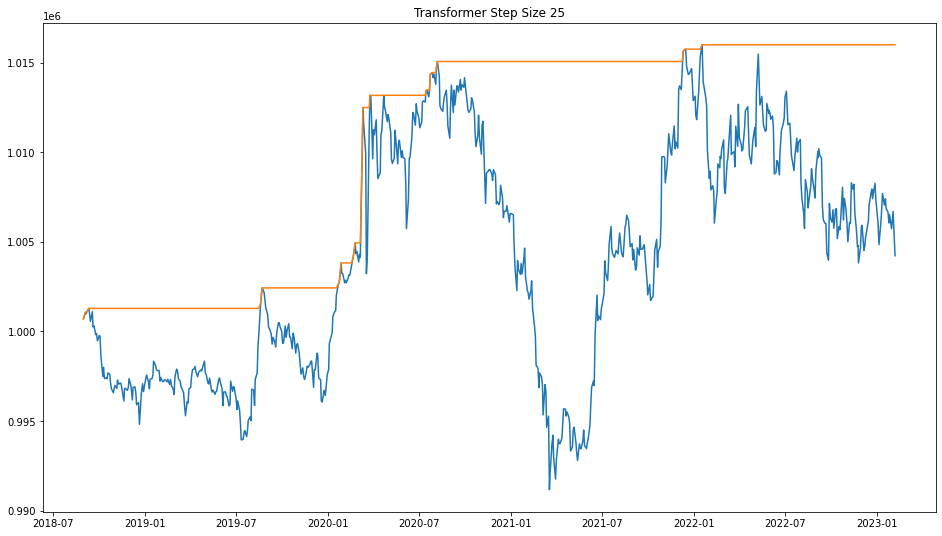

In [ ]:
from pandas.core.arrays.period import period_array

def summ_and_plot(x, y, periods_per_day=10, mult=10_000, capital=1_000_000, contracts=1, adj=252, title="", idx=None):
    # Function to calculate performance summary and plot the cumulative returns.
    rets = backtest(x, y, periods_per_day=periods_per_day, mult=mult, capital=capital, contracts=contracts, idx=idx)

    # Try to reindex to show the timestamps.
    if idx is not None:
      try:
        rets = rets.reindex(idx)
      except:
        pass

    # Display summary table and plot figure.
    summ = perf_summ(rets["pct_pnl"], adj=adj, title=title)
    display(summ)
    plt.rcParams["figure.figsize"] = (16,9)
    plt.plot(rets["portfolio"])
    plt.plot(rets["portfolio"].cummax())
    plt.title(title)
    
    plt.show()
    return summ, rets

rets_idx = df_idx[-(len(x_test)):].reset_index(drop=True)
rets_idx = rets_idx[::10]
rets_agg, tf_rets25 = summ_and_plot(x, y, title="Transformer Step Size 25", idx=rets_idx)

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 50, 26)]     0           []                               
                                                                                                  
 layer_normalization_280 (Layer  (None, 50, 26)      52          ['input_36[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_140 (Mult  (None, 50, 26)      109594      ['layer_normalization_280[0][0]',
 iHeadAttention)                                                  'layer_normalization_280[0][0]']
                                                                                           

15/15 [==============================] - 19s 42ms/step - loss: 1985.3534
Epoch 2/200
14/15 [===========================>..] - ETA: 0s - loss: 1683.7994

15/15 [==============================] - 1s 46ms/step - loss: 1681.7914
Epoch 3/200
15/15 [==============================] - ETA: 0s - loss: 1548.2990

15/15 [==============================] - 1s 41ms/step - loss: 1548.2990
Epoch 4/200
15/15 [==============================] - ETA: 0s - loss: 1247.1316

15/15 [==============================] - 1s 39ms/step - loss: 1247.1316
Epoch 5/200
15/15 [==============================] - ETA: 0s - loss: 1034.6709

15/15 [==============================] - 1s 42ms/step - loss: 1034.6709
Epoch 6/200
15/15 [==============================] - ETA: 0s - loss: 933.0698

15/15 [==============================] - 1s 40ms/step - loss: 933.0698
Epoch 7/200
15/15 [==============================] - ETA: 0s - loss: 788.6921

15/15 [==============================] - 1s 35ms/step - loss: 788.6921
Epoch 8/200
15/15 [==============================] - ETA: 0s - loss: 626.1002

15/15 [==============================] - 0s 30ms/step - loss: 626.1002
Epoch 9/200
15/15 [==============================] - ETA: 0s - loss: 574.2719

15/15 [==============================] - 0s 30ms/step - loss: 574.2719
Epoch 10/200
15/15 [==============================] - ETA: 0s - loss: 460.0607

15/15 [==============================] - 0s 30ms/step - loss: 460.0607
Epoch 11/200
15/15 [==============================] - ETA: 0s - loss: 378.6417

15/15 [==============================] - 0s 32ms/step - loss: 378.6417
Epoch 12/200
15/15 [==============================] - ETA: 0s - loss: 325.9341

15/15 [==============================] - 0s 31ms/step - loss: 325.9341
Epoch 13/200
15/15 [==============================] - ETA: 0s - loss: 260.5778

15/15 [==============================] - 0s 31ms/step - loss: 260.5778
Epoch 14/200
15/15 [==============================] - ETA: 0s - loss: 233.5796

15/15 [==============================] - 0s 31ms/step - loss: 233.5796
Epoch 15/200
15/15 [==============================] - ETA: 0s - loss: 203.4993

15/15 [==============================] - 0s 29ms/step - loss: 203.4993
Epoch 16/200
15/15 [==============================] - ETA: 0s - loss: 174.1262

15/15 [==============================] - 0s 29ms/step - loss: 174.1262
Epoch 17/200
15/15 [==============================] - ETA: 0s - loss: 157.7528

15/15 [==============================] - 0s 29ms/step - loss: 157.7528
Epoch 18/200
15/15 [==============================] - ETA: 0s - loss: 126.5954

15/15 [==============================] - 0s 29ms/step - loss: 126.5954
Epoch 19/200
15/15 [==============================] - ETA: 0s - loss: 104.5135

15/15 [==============================] - 0s 29ms/step - loss: 104.5135
Epoch 20/200
15/15 [==============================] - ETA: 0s - loss: 80.8291

15/15 [==============================] - 0s 29ms/step - loss: 80.8291
Epoch 21/200
15/15 [==============================] - ETA: 0s - loss: 74.7688

15/15 [==============================] - 0s 29ms/step - loss: 74.7688
Epoch 22/200
15/15 [==============================] - ETA: 0s - loss: 70.4410

15/15 [==============================] - 0s 30ms/step - loss: 70.4410
Epoch 23/200
15/15 [==============================] - ETA: 0s - loss: 57.7032

15/15 [==============================] - 0s 29ms/step - loss: 57.7032
Epoch 24/200
15/15 [==============================] - ETA: 0s - loss: 50.5534

15/15 [==============================] - 0s 28ms/step - loss: 50.5534
Epoch 25/200
15/15 [==============================] - ETA: 0s - loss: 45.4742

15/15 [==============================] - 0s 29ms/step - loss: 45.4742
Epoch 26/200
15/15 [==============================] - ETA: 0s - loss: 40.1466

15/15 [==============================] - 0s 29ms/step - loss: 40.1466
Epoch 27/200
15/15 [==============================] - ETA: 0s - loss: 34.9941

15/15 [==============================] - 0s 29ms/step - loss: 34.9941
Epoch 28/200
15/15 [==============================] - ETA: 0s - loss: 28.9971

15/15 [==============================] - 0s 29ms/step - loss: 28.9971
Epoch 29/200
15/15 [==============================] - ETA: 0s - loss: 29.0977

15/15 [==============================] - 0s 32ms/step - loss: 29.0977
Epoch 30/200
15/15 [==============================] - ETA: 0s - loss: 24.3210

15/15 [==============================] - 0s 31ms/step - loss: 24.3210
Epoch 31/200
15/15 [==============================] - ETA: 0s - loss: 21.5925

15/15 [==============================] - 0s 31ms/step - loss: 21.5925
Epoch 32/200
15/15 [==============================] - ETA: 0s - loss: 19.1773

15/15 [==============================] - 1s 34ms/step - loss: 19.1773
Epoch 33/200
15/15 [==============================] - ETA: 0s - loss: 17.5705

15/15 [==============================] - 0s 30ms/step - loss: 17.5705
Epoch 34/200
15/15 [==============================] - ETA: 0s - loss: 17.4647

15/15 [==============================] - 0s 30ms/step - loss: 17.4647
Epoch 35/200
15/15 [==============================] - ETA: 0s - loss: 16.8591

15/15 [==============================] - 0s 30ms/step - loss: 16.8591
Epoch 36/200
15/15 [==============================] - ETA: 0s - loss: 13.2784

15/15 [==============================] - 0s 31ms/step - loss: 13.2784
Epoch 37/200
15/15 [==============================] - ETA: 0s - loss: 12.7240

15/15 [==============================] - 0s 32ms/step - loss: 12.7240
Epoch 38/200
15/15 [==============================] - ETA: 0s - loss: 12.0292

15/15 [==============================] - 0s 29ms/step - loss: 12.0292
Epoch 39/200
15/15 [==============================] - ETA: 0s - loss: 12.0170

15/15 [==============================] - 0s 29ms/step - loss: 12.0170
Epoch 40/200
15/15 [==============================] - ETA: 0s - loss: 11.9359

15/15 [==============================] - 0s 30ms/step - loss: 11.9359
Epoch 41/200
15/15 [==============================] - ETA: 0s - loss: 10.0298

15/15 [==============================] - 0s 29ms/step - loss: 10.0298
Epoch 42/200
15/15 [==============================] - ETA: 0s - loss: 10.4310

15/15 [==============================] - 0s 29ms/step - loss: 10.4310
Epoch 43/200
15/15 [==============================] - ETA: 0s - loss: 10.6927

15/15 [==============================] - 0s 29ms/step - loss: 10.6927
Epoch 44/200
15/15 [==============================] - ETA: 0s - loss: 9.4853

15/15 [==============================] - 0s 30ms/step - loss: 9.4853
Epoch 45/200
15/15 [==============================] - ETA: 0s - loss: 9.3586

15/15 [==============================] - 0s 30ms/step - loss: 9.3586
Epoch 46/200
15/15 [==============================] - ETA: 0s - loss: 8.7329

15/15 [==============================] - 0s 29ms/step - loss: 8.7329
Epoch 47/200
15/15 [==============================] - ETA: 0s - loss: 10.6223

15/15 [==============================] - 0s 29ms/step - loss: 10.6223
Epoch 48/200
15/15 [==============================] - ETA: 0s - loss: 9.1124

15/15 [==============================] - 0s 30ms/step - loss: 9.1124
Epoch 49/200
15/15 [==============================] - ETA: 0s - loss: 9.2512

15/15 [==============================] - 0s 29ms/step - loss: 9.2512
Epoch 50/200
15/15 [==============================] - ETA: 0s - loss: 9.2632

15/15 [==============================] - 0s 30ms/step - loss: 9.2632
Epoch 51/200
15/15 [==============================] - ETA: 0s - loss: 8.4163

15/15 [==============================] - 0s 30ms/step - loss: 8.4163
Epoch 52/200
15/15 [==============================] - ETA: 0s - loss: 9.4063

15/15 [==============================] - 0s 30ms/step - loss: 9.4063
Epoch 53/200
15/15 [==============================] - ETA: 0s - loss: 8.5977

15/15 [==============================] - 0s 30ms/step - loss: 8.5977
Epoch 54/200
15/15 [==============================] - ETA: 0s - loss: 7.9776

15/15 [==============================] - 0s 30ms/step - loss: 7.9776
Epoch 55/200
15/15 [==============================] - ETA: 0s - loss: 8.7908

15/15 [==============================] - 0s 30ms/step - loss: 8.7908
Epoch 56/200
15/15 [==============================] - ETA: 0s - loss: 8.5502

15/15 [==============================] - 0s 29ms/step - loss: 8.5502
Epoch 57/200
15/15 [==============================] - ETA: 0s - loss: 7.9378

15/15 [==============================] - 0s 29ms/step - loss: 7.9378
Epoch 58/200
15/15 [==============================] - ETA: 0s - loss: 8.3976

15/15 [==============================] - 0s 30ms/step - loss: 8.3976
Epoch 59/200
15/15 [==============================] - ETA: 0s - loss: 8.2187

15/15 [==============================] - 0s 29ms/step - loss: 8.2187
Epoch 60/200
15/15 [==============================] - ETA: 0s - loss: 7.9531

15/15 [==============================] - 1s 34ms/step - loss: 7.9531
Epoch 61/200
15/15 [==============================] - ETA: 0s - loss: 7.9384

15/15 [==============================] - 0s 32ms/step - loss: 7.9384
Epoch 62/200
15/15 [==============================] - ETA: 0s - loss: 7.9748

15/15 [==============================] - 0s 32ms/step - loss: 7.9748
Epoch 63/200
15/15 [==============================] - ETA: 0s - loss: 8.1429

15/15 [==============================] - 0s 31ms/step - loss: 8.1429
Epoch 64/200
15/15 [==============================] - ETA: 0s - loss: 8.0843

15/15 [==============================] - 0s 32ms/step - loss: 8.0843
Epoch 65/200
15/15 [==============================] - ETA: 0s - loss: 7.3330

15/15 [==============================] - 0s 32ms/step - loss: 7.3330
Epoch 66/200
15/15 [==============================] - ETA: 0s - loss: 7.9790

15/15 [==============================] - 0s 32ms/step - loss: 7.9790
Epoch 67/200
15/15 [==============================] - ETA: 0s - loss: 8.1765

15/15 [==============================] - 0s 31ms/step - loss: 8.1765
Epoch 68/200
15/15 [==============================] - ETA: 0s - loss: 7.4973

15/15 [==============================] - 0s 30ms/step - loss: 7.4973
Epoch 69/200
15/15 [==============================] - ETA: 0s - loss: 6.8524

15/15 [==============================] - 0s 29ms/step - loss: 6.8524
Epoch 70/200
15/15 [==============================] - ETA: 0s - loss: 7.1668

15/15 [==============================] - 0s 29ms/step - loss: 7.1668
Epoch 71/200
15/15 [==============================] - ETA: 0s - loss: 7.7185

15/15 [==============================] - 0s 29ms/step - loss: 7.7185
Epoch 72/200
15/15 [==============================] - ETA: 0s - loss: 7.6004

15/15 [==============================] - 0s 30ms/step - loss: 7.6004
Epoch 73/200
15/15 [==============================] - ETA: 0s - loss: 7.1011

15/15 [==============================] - 0s 29ms/step - loss: 7.1011
Epoch 74/200
15/15 [==============================] - ETA: 0s - loss: 7.2419

15/15 [==============================] - 0s 29ms/step - loss: 7.2419
Epoch 75/200
15/15 [==============================] - ETA: 0s - loss: 8.1575

15/15 [==============================] - 0s 29ms/step - loss: 8.1575
Epoch 76/200
15/15 [==============================] - ETA: 0s - loss: 7.0328

15/15 [==============================] - 0s 29ms/step - loss: 7.0328
Epoch 77/200
15/15 [==============================] - ETA: 0s - loss: 7.4961

15/15 [==============================] - 0s 30ms/step - loss: 7.4961
Epoch 78/200
15/15 [==============================] - ETA: 0s - loss: 7.0562

15/15 [==============================] - 0s 29ms/step - loss: 7.0562
Epoch 79/200
15/15 [==============================] - ETA: 0s - loss: 7.4979

15/15 [==============================] - 0s 30ms/step - loss: 7.4979
Epoch 80/200
15/15 [==============================] - ETA: 0s - loss: 7.5788

15/15 [==============================] - 0s 29ms/step - loss: 7.5788
Epoch 81/200
15/15 [==============================] - ETA: 0s - loss: 7.1531

15/15 [==============================] - 0s 30ms/step - loss: 7.1531
Epoch 82/200
15/15 [==============================] - ETA: 0s - loss: 7.4606

15/15 [==============================] - 0s 29ms/step - loss: 7.4606
Epoch 83/200
15/15 [==============================] - ETA: 0s - loss: 7.1143

15/15 [==============================] - 0s 30ms/step - loss: 7.1143
Epoch 84/200
15/15 [==============================] - ETA: 0s - loss: 7.2238

15/15 [==============================] - 0s 30ms/step - loss: 7.2238
Epoch 85/200
15/15 [==============================] - ETA: 0s - loss: 7.5234

15/15 [==============================] - 0s 30ms/step - loss: 7.5234
Epoch 86/200
15/15 [==============================] - ETA: 0s - loss: 7.2666

15/15 [==============================] - 0s 30ms/step - loss: 7.2666
Epoch 87/200
15/15 [==============================] - ETA: 0s - loss: 7.2187

15/15 [==============================] - 0s 30ms/step - loss: 7.2187
Epoch 88/200
15/15 [==============================] - ETA: 0s - loss: 6.6751

15/15 [==============================] - 0s 29ms/step - loss: 6.6751
Epoch 89/200
15/15 [==============================] - ETA: 0s - loss: 6.7633

15/15 [==============================] - 0s 29ms/step - loss: 6.7633
Epoch 90/200
15/15 [==============================] - ETA: 0s - loss: 7.0624

15/15 [==============================] - 0s 32ms/step - loss: 7.0624
Epoch 91/200
15/15 [==============================] - ETA: 0s - loss: 7.0748

15/15 [==============================] - 0s 30ms/step - loss: 7.0748
Epoch 92/200
15/15 [==============================] - ETA: 0s - loss: 6.9509

15/15 [==============================] - 0s 31ms/step - loss: 6.9509
Epoch 93/200
15/15 [==============================] - ETA: 0s - loss: 6.6474

15/15 [==============================] - 0s 30ms/step - loss: 6.6474
Epoch 94/200
15/15 [==============================] - ETA: 0s - loss: 6.5539

15/15 [==============================] - 0s 30ms/step - loss: 6.5539
Epoch 95/200
15/15 [==============================] - ETA: 0s - loss: 6.5436

15/15 [==============================] - 0s 32ms/step - loss: 6.5436
Epoch 96/200
15/15 [==============================] - ETA: 0s - loss: 6.7094

15/15 [==============================] - 0s 29ms/step - loss: 6.7094
Epoch 97/200
15/15 [==============================] - ETA: 0s - loss: 6.7031

15/15 [==============================] - 0s 30ms/step - loss: 6.7031
Epoch 98/200
15/15 [==============================] - ETA: 0s - loss: 6.8802

15/15 [==============================] - 0s 30ms/step - loss: 6.8802
Epoch 99/200
15/15 [==============================] - ETA: 0s - loss: 7.0424

15/15 [==============================] - 0s 30ms/step - loss: 7.0424
Epoch 100/200
15/15 [==============================] - ETA: 0s - loss: 6.9682

15/15 [==============================] - 0s 29ms/step - loss: 6.9682
Epoch 101/200
15/15 [==============================] - ETA: 0s - loss: 7.1558

15/15 [==============================] - 0s 30ms/step - loss: 7.1558
Epoch 102/200
15/15 [==============================] - ETA: 0s - loss: 7.2841

15/15 [==============================] - 0s 29ms/step - loss: 7.2841
Epoch 103/200
15/15 [==============================] - ETA: 0s - loss: 6.6983

15/15 [==============================] - 0s 29ms/step - loss: 6.6983
Epoch 104/200
15/15 [==============================] - ETA: 0s - loss: 6.5382

15/15 [==============================] - 0s 29ms/step - loss: 6.5382
Epoch 105/200
15/15 [==============================] - ETA: 0s - loss: 6.2229

15/15 [==============================] - 0s 30ms/step - loss: 6.2229
Epoch 106/200
15/15 [==============================] - ETA: 0s - loss: 6.3984

15/15 [==============================] - 0s 30ms/step - loss: 6.3984
Epoch 107/200
15/15 [==============================] - ETA: 0s - loss: 6.6990

15/15 [==============================] - 0s 30ms/step - loss: 6.6990
Epoch 108/200
15/15 [==============================] - ETA: 0s - loss: 7.0618

15/15 [==============================] - 0s 30ms/step - loss: 7.0618
Epoch 109/200
15/15 [==============================] - ETA: 0s - loss: 6.7122

15/15 [==============================] - 0s 29ms/step - loss: 6.7122
Epoch 110/200
15/15 [==============================] - ETA: 0s - loss: 6.5418

15/15 [==============================] - 0s 30ms/step - loss: 6.5418
Epoch 111/200
15/15 [==============================] - ETA: 0s - loss: 6.7340

15/15 [==============================] - 0s 30ms/step - loss: 6.7340
Epoch 112/200
15/15 [==============================] - ETA: 0s - loss: 7.1100

15/15 [==============================] - 0s 29ms/step - loss: 7.1100
Epoch 113/200
15/15 [==============================] - ETA: 0s - loss: 6.5456

15/15 [==============================] - 0s 29ms/step - loss: 6.5456
Epoch 114/200
15/15 [==============================] - ETA: 0s - loss: 6.4936

15/15 [==============================] - 0s 29ms/step - loss: 6.4936
Epoch 115/200
15/15 [==============================] - ETA: 0s - loss: 6.4189

15/15 [==============================] - 0s 30ms/step - loss: 6.4189
Epoch 116/200
15/15 [==============================] - ETA: 0s - loss: 6.4576

15/15 [==============================] - 0s 29ms/step - loss: 6.4576
Epoch 117/200
15/15 [==============================] - ETA: 0s - loss: 6.3404

15/15 [==============================] - 0s 30ms/step - loss: 6.3404
Epoch 118/200
15/15 [==============================] - ETA: 0s - loss: 6.1224

15/15 [==============================] - 0s 31ms/step - loss: 6.1224
Epoch 119/200
15/15 [==============================] - ETA: 0s - loss: 6.5012

15/15 [==============================] - 0s 30ms/step - loss: 6.5012
Epoch 120/200
15/15 [==============================] - ETA: 0s - loss: 5.9968

15/15 [==============================] - 0s 31ms/step - loss: 5.9968
Epoch 121/200
15/15 [==============================] - ETA: 0s - loss: 6.2952

15/15 [==============================] - 0s 32ms/step - loss: 6.2952
Epoch 122/200
15/15 [==============================] - ETA: 0s - loss: 6.3866

15/15 [==============================] - 0s 32ms/step - loss: 6.3866
Epoch 123/200
15/15 [==============================] - ETA: 0s - loss: 5.6456

15/15 [==============================] - 0s 33ms/step - loss: 5.6456
Epoch 124/200
15/15 [==============================] - ETA: 0s - loss: 5.9823

15/15 [==============================] - 1s 33ms/step - loss: 5.9823
Epoch 125/200
15/15 [==============================] - ETA: 0s - loss: 6.1971

15/15 [==============================] - 0s 33ms/step - loss: 6.1971
Epoch 126/200
15/15 [==============================] - ETA: 0s - loss: 6.0629

15/15 [==============================] - 0s 32ms/step - loss: 6.0629
Epoch 127/200
15/15 [==============================] - ETA: 0s - loss: 6.0873

15/15 [==============================] - 0s 32ms/step - loss: 6.0873
Epoch 128/200
15/15 [==============================] - ETA: 0s - loss: 6.3249

15/15 [==============================] - 0s 31ms/step - loss: 6.3249
Epoch 129/200
15/15 [==============================] - ETA: 0s - loss: 5.6961

15/15 [==============================] - 0s 30ms/step - loss: 5.6961
Epoch 130/200
15/15 [==============================] - ETA: 0s - loss: 5.9714

15/15 [==============================] - 0s 30ms/step - loss: 5.9714
Epoch 131/200
15/15 [==============================] - ETA: 0s - loss: 6.2099

15/15 [==============================] - 0s 31ms/step - loss: 6.2099
Epoch 132/200
15/15 [==============================] - ETA: 0s - loss: 5.8491

15/15 [==============================] - 0s 30ms/step - loss: 5.8491
Epoch 133/200
15/15 [==============================] - ETA: 0s - loss: 5.8622

15/15 [==============================] - 0s 30ms/step - loss: 5.8622
Epoch 134/200
15/15 [==============================] - ETA: 0s - loss: 6.2726

15/15 [==============================] - 0s 31ms/step - loss: 6.2726
Epoch 135/200
15/15 [==============================] - ETA: 0s - loss: 5.7450

15/15 [==============================] - 0s 30ms/step - loss: 5.7450
Epoch 136/200
15/15 [==============================] - ETA: 0s - loss: 6.0870

15/15 [==============================] - 0s 30ms/step - loss: 6.0870
Epoch 137/200
15/15 [==============================] - ETA: 0s - loss: 5.6784

15/15 [==============================] - 0s 30ms/step - loss: 5.6784
Epoch 138/200
15/15 [==============================] - ETA: 0s - loss: 5.5087

15/15 [==============================] - 0s 29ms/step - loss: 5.5087
Epoch 139/200
15/15 [==============================] - ETA: 0s - loss: 6.0332

15/15 [==============================] - 0s 30ms/step - loss: 6.0332
Epoch 140/200
15/15 [==============================] - ETA: 0s - loss: 5.9484

15/15 [==============================] - 0s 31ms/step - loss: 5.9484
Epoch 141/200
15/15 [==============================] - ETA: 0s - loss: 6.0241

15/15 [==============================] - 0s 30ms/step - loss: 6.0241
Epoch 142/200
15/15 [==============================] - ETA: 0s - loss: 5.8013

15/15 [==============================] - 0s 30ms/step - loss: 5.8013
Epoch 143/200
15/15 [==============================] - ETA: 0s - loss: 6.0684

15/15 [==============================] - 0s 30ms/step - loss: 6.0684
Epoch 144/200
15/15 [==============================] - ETA: 0s - loss: 6.1421

15/15 [==============================] - 0s 30ms/step - loss: 6.1421
Epoch 145/200
15/15 [==============================] - ETA: 0s - loss: 5.6544

15/15 [==============================] - 0s 30ms/step - loss: 5.6544
Epoch 146/200
15/15 [==============================] - ETA: 0s - loss: 5.6051

15/15 [==============================] - 0s 30ms/step - loss: 5.6051
Epoch 147/200
15/15 [==============================] - ETA: 0s - loss: 5.9761

15/15 [==============================] - 0s 30ms/step - loss: 5.9761
Epoch 148/200
15/15 [==============================] - ETA: 0s - loss: 6.2966

15/15 [==============================] - 0s 30ms/step - loss: 6.2966
Epoch 149/200
15/15 [==============================] - ETA: 0s - loss: 5.7796

15/15 [==============================] - 0s 29ms/step - loss: 5.7796
Epoch 150/200
15/15 [==============================] - ETA: 0s - loss: 5.5901

15/15 [==============================] - 0s 32ms/step - loss: 5.5901
Epoch 151/200
15/15 [==============================] - ETA: 0s - loss: 5.9042

15/15 [==============================] - 0s 32ms/step - loss: 5.9042
Epoch 152/200
15/15 [==============================] - ETA: 0s - loss: 5.1662

15/15 [==============================] - 0s 30ms/step - loss: 5.1662
Epoch 153/200
15/15 [==============================] - ETA: 0s - loss: 5.7839

15/15 [==============================] - 0s 33ms/step - loss: 5.7839
Epoch 154/200
15/15 [==============================] - ETA: 0s - loss: 5.6273

15/15 [==============================] - 0s 32ms/step - loss: 5.6273
Epoch 155/200
15/15 [==============================] - ETA: 0s - loss: 5.4034

15/15 [==============================] - 0s 32ms/step - loss: 5.4034
Epoch 156/200
15/15 [==============================] - ETA: 0s - loss: 5.4620

15/15 [==============================] - 0s 33ms/step - loss: 5.4620
Epoch 157/200
15/15 [==============================] - ETA: 0s - loss: 5.4208

15/15 [==============================] - 0s 31ms/step - loss: 5.4208
Epoch 158/200
15/15 [==============================] - ETA: 0s - loss: 5.2550

15/15 [==============================] - 0s 32ms/step - loss: 5.2550
Epoch 159/200
15/15 [==============================] - ETA: 0s - loss: 5.5653

15/15 [==============================] - 0s 30ms/step - loss: 5.5653
Epoch 160/200
15/15 [==============================] - ETA: 0s - loss: 5.3929

15/15 [==============================] - 0s 30ms/step - loss: 5.3929
Epoch 161/200
15/15 [==============================] - ETA: 0s - loss: 5.2701

15/15 [==============================] - 0s 30ms/step - loss: 5.2701
Epoch 162/200
15/15 [==============================] - ETA: 0s - loss: 6.1474

15/15 [==============================] - 0s 30ms/step - loss: 6.1474
Epoch 163/200
15/15 [==============================] - ETA: 0s - loss: 5.1624

15/15 [==============================] - 0s 30ms/step - loss: 5.1624
Epoch 164/200
15/15 [==============================] - ETA: 0s - loss: 5.1441

15/15 [==============================] - 0s 30ms/step - loss: 5.1441
Epoch 165/200
15/15 [==============================] - ETA: 0s - loss: 4.8428

15/15 [==============================] - 0s 30ms/step - loss: 4.8428
Epoch 166/200
15/15 [==============================] - ETA: 0s - loss: 5.5003

15/15 [==============================] - 0s 30ms/step - loss: 5.5003
Epoch 167/200
15/15 [==============================] - ETA: 0s - loss: 5.5228

15/15 [==============================] - 0s 30ms/step - loss: 5.5228
Epoch 168/200
15/15 [==============================] - ETA: 0s - loss: 5.5855

15/15 [==============================] - 0s 30ms/step - loss: 5.5855
Epoch 169/200
15/15 [==============================] - ETA: 0s - loss: 5.5658

15/15 [==============================] - 0s 30ms/step - loss: 5.5658
Epoch 170/200
15/15 [==============================] - ETA: 0s - loss: 5.3871

15/15 [==============================] - 0s 30ms/step - loss: 5.3871
Epoch 171/200
15/15 [==============================] - ETA: 0s - loss: 5.5239

15/15 [==============================] - 0s 30ms/step - loss: 5.5239
Epoch 172/200
15/15 [==============================] - ETA: 0s - loss: 5.3238

15/15 [==============================] - 0s 30ms/step - loss: 5.3238
Epoch 173/200
15/15 [==============================] - ETA: 0s - loss: 5.4161

15/15 [==============================] - 0s 30ms/step - loss: 5.4161
Epoch 174/200
15/15 [==============================] - ETA: 0s - loss: 5.3541

15/15 [==============================] - 0s 30ms/step - loss: 5.3541
Epoch 175/200
15/15 [==============================] - ETA: 0s - loss: 5.0515

15/15 [==============================] - 0s 31ms/step - loss: 5.0515
Epoch 176/200
15/15 [==============================] - ETA: 0s - loss: 5.1364

15/15 [==============================] - 0s 30ms/step - loss: 5.1364
Epoch 177/200
15/15 [==============================] - ETA: 0s - loss: 4.9844

15/15 [==============================] - 0s 30ms/step - loss: 4.9844
Epoch 178/200
15/15 [==============================] - ETA: 0s - loss: 5.1672

15/15 [==============================] - 0s 31ms/step - loss: 5.1672
Epoch 179/200
15/15 [==============================] - ETA: 0s - loss: 5.4901

15/15 [==============================] - 0s 30ms/step - loss: 5.4901
Epoch 180/200
15/15 [==============================] - ETA: 0s - loss: 5.5779

15/15 [==============================] - 0s 30ms/step - loss: 5.5779
Epoch 181/200
15/15 [==============================] - ETA: 0s - loss: 5.0368

15/15 [==============================] - 0s 32ms/step - loss: 5.0368
Epoch 182/200
15/15 [==============================] - ETA: 0s - loss: 5.1649

15/15 [==============================] - 0s 32ms/step - loss: 5.1649
Epoch 183/200
15/15 [==============================] - ETA: 0s - loss: 4.8491

15/15 [==============================] - 1s 33ms/step - loss: 4.8491
Epoch 184/200
15/15 [==============================] - ETA: 0s - loss: 5.2203

15/15 [==============================] - 0s 33ms/step - loss: 5.2203
Epoch 185/200
15/15 [==============================] - ETA: 0s - loss: 4.9846

15/15 [==============================] - 0s 32ms/step - loss: 4.9846
Epoch 186/200
15/15 [==============================] - ETA: 0s - loss: 4.5571

15/15 [==============================] - 0s 33ms/step - loss: 4.5571
Epoch 187/200
15/15 [==============================] - ETA: 0s - loss: 4.8640

15/15 [==============================] - 0s 32ms/step - loss: 4.8640
Epoch 188/200
15/15 [==============================] - ETA: 0s - loss: 5.2856

15/15 [==============================] - 0s 33ms/step - loss: 5.2856
Epoch 189/200
15/15 [==============================] - ETA: 0s - loss: 4.6335

15/15 [==============================] - 0s 33ms/step - loss: 4.6335
Epoch 190/200
15/15 [==============================] - ETA: 0s - loss: 4.8952

15/15 [==============================] - 1s 34ms/step - loss: 4.8952
Epoch 191/200
15/15 [==============================] - ETA: 0s - loss: 4.9030

15/15 [==============================] - 0s 32ms/step - loss: 4.9030
Epoch 192/200
15/15 [==============================] - ETA: 0s - loss: 4.8162

15/15 [==============================] - 1s 32ms/step - loss: 4.8162
Epoch 193/200
15/15 [==============================] - ETA: 0s - loss: 4.6070

15/15 [==============================] - 0s 30ms/step - loss: 4.6070
Epoch 194/200
15/15 [==============================] - ETA: 0s - loss: 4.5823

15/15 [==============================] - 0s 33ms/step - loss: 4.5823
Epoch 195/200
15/15 [==============================] - ETA: 0s - loss: 4.8468

15/15 [==============================] - 1s 34ms/step - loss: 4.8468
Epoch 196/200
15/15 [==============================] - ETA: 0s - loss: 5.2607

15/15 [==============================] - 0s 33ms/step - loss: 5.2607
Epoch 197/200
15/15 [==============================] - ETA: 0s - loss: 4.7866

15/15 [==============================] - 0s 32ms/step - loss: 4.7866
Epoch 198/200
15/15 [==============================] - ETA: 0s - loss: 5.1664

15/15 [==============================] - 0s 30ms/step - loss: 5.1664
Epoch 199/200
15/15 [==============================] - ETA: 0s - loss: 5.0711

15/15 [==============================] - 0s 31ms/step - loss: 5.0711
Epoch 200/200
15/15 [==============================] - ETA: 0s - loss: 5.2534

15/15 [==============================] - 0s 30ms/step - loss: 5.2534


  0%|          | 0/139 [00:00<?, ?it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.0024

1/1 [==============================] - 0s 41ms/step - loss: 6.0024
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7829

1/1 [==============================] - 0s 40ms/step - loss: 4.7829
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.5091

1/1 [==============================] - 0s 35ms/step - loss: 5.5091
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.8702

1/1 [==============================] - 0s 35ms/step - loss: 5.8702
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.1604

1/1 [==============================] - 0s 36ms/step - loss: 6.1604


  1%|          | 1/139 [00:00<01:57,  1.18it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.4368

1/1 [==============================] - 0s 37ms/step - loss: 5.4368
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7672

1/1 [==============================] - 0s 35ms/step - loss: 4.7672
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.3149

1/1 [==============================] - 0s 41ms/step - loss: 4.3149
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8690

1/1 [==============================] - 0s 34ms/step - loss: 3.8690
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.1986

1/1 [==============================] - 0s 34ms/step - loss: 3.1986


  1%|▏         | 2/139 [00:01<01:27,  1.57it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8650

1/1 [==============================] - 0s 33ms/step - loss: 4.8650
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.3832

1/1 [==============================] - 0s 34ms/step - loss: 6.3832
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.9429

1/1 [==============================] - 0s 37ms/step - loss: 4.9429
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.9548

1/1 [==============================] - 0s 38ms/step - loss: 2.9548
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.0800

1/1 [==============================] - 0s 33ms/step - loss: 4.0800


  2%|▏         | 3/139 [00:01<01:17,  1.76it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.1911

1/1 [==============================] - 0s 40ms/step - loss: 5.1911
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.2890

1/1 [==============================] - 0s 41ms/step - loss: 5.2890
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5037

1/1 [==============================] - 0s 32ms/step - loss: 3.5037
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.8713

1/1 [==============================] - 0s 39ms/step - loss: 5.8713
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.8532

1/1 [==============================] - 0s 32ms/step - loss: 6.8532


  3%|▎         | 4/139 [00:02<01:05,  2.05it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.2007

1/1 [==============================] - 0s 41ms/step - loss: 4.2007
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.1494

1/1 [==============================] - 0s 45ms/step - loss: 2.1494
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2733

1/1 [==============================] - 0s 35ms/step - loss: 3.2733
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3758

1/1 [==============================] - 0s 34ms/step - loss: 3.3758
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.3644

1/1 [==============================] - 0s 36ms/step - loss: 5.3644


  4%|▎         | 5/139 [00:02<01:03,  2.11it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1615

1/1 [==============================] - 0s 45ms/step - loss: 4.1615
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5386

1/1 [==============================] - 0s 43ms/step - loss: 4.5386
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7775

1/1 [==============================] - 0s 43ms/step - loss: 3.7775
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.7767

1/1 [==============================] - 0s 36ms/step - loss: 3.7767
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5117

1/1 [==============================] - 0s 43ms/step - loss: 4.5117


  4%|▍         | 6/139 [00:03<00:58,  2.28it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.1201

1/1 [==============================] - 0s 39ms/step - loss: 5.1201
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5083

1/1 [==============================] - 0s 36ms/step - loss: 4.5083
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6339

1/1 [==============================] - 0s 46ms/step - loss: 3.6339
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.2272

1/1 [==============================] - 0s 38ms/step - loss: 5.2272
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9704

1/1 [==============================] - 0s 41ms/step - loss: 3.9704


  5%|▌         | 7/139 [00:03<00:57,  2.30it/s]

2/2 [==============================] - 0s 9ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.7263

1/1 [==============================] - 0s 39ms/step - loss: 4.7263
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.0078

1/1 [==============================] - 0s 35ms/step - loss: 3.0078
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0394

1/1 [==============================] - 0s 40ms/step - loss: 4.0394
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3476

1/1 [==============================] - 0s 34ms/step - loss: 3.3476
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.1857

1/1 [==============================] - 0s 40ms/step - loss: 5.1857


  6%|▌         | 8/139 [00:03<00:53,  2.43it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0074

1/1 [==============================] - 0s 41ms/step - loss: 5.0074
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1016

1/1 [==============================] - 0s 37ms/step - loss: 4.1016
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.3273

1/1 [==============================] - 0s 38ms/step - loss: 4.3273
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6977

1/1 [==============================] - 0s 37ms/step - loss: 3.6977
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8541

1/1 [==============================] - 0s 45ms/step - loss: 4.8541


  6%|▋         | 9/139 [00:04<00:55,  2.35it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0520

1/1 [==============================] - 0s 43ms/step - loss: 4.0520
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 8.4986

1/1 [==============================] - 0s 49ms/step - loss: 8.4986
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8750

1/1 [==============================] - 0s 51ms/step - loss: 3.8750
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2880

1/1 [==============================] - 0s 52ms/step - loss: 4.2880
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0698

1/1 [==============================] - 0s 50ms/step - loss: 5.0698


  7%|▋         | 10/139 [00:04<01:00,  2.14it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.2094

1/1 [==============================] - 0s 56ms/step - loss: 4.2094
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.5008

1/1 [==============================] - 0s 55ms/step - loss: 5.5008
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3440

1/1 [==============================] - 0s 57ms/step - loss: 3.3440
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2838

1/1 [==============================] - 0s 54ms/step - loss: 4.2838
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.7447

1/1 [==============================] - 0s 41ms/step - loss: 3.7447


  8%|▊         | 11/139 [00:05<01:02,  2.04it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.9350

1/1 [==============================] - 0s 57ms/step - loss: 4.9350
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.2044

1/1 [==============================] - 0s 54ms/step - loss: 5.2044
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.3884

1/1 [==============================] - 0s 55ms/step - loss: 5.3884
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6989

1/1 [==============================] - 0s 49ms/step - loss: 3.6989
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.0021

1/1 [==============================] - 0s 45ms/step - loss: 6.0021


  9%|▊         | 12/139 [00:05<01:03,  1.99it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4545

1/1 [==============================] - 0s 45ms/step - loss: 3.4545
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.6144

1/1 [==============================] - 0s 53ms/step - loss: 6.6144
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.8366

1/1 [==============================] - 0s 43ms/step - loss: 6.8366
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6463

1/1 [==============================] - 0s 48ms/step - loss: 3.6463
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5019

1/1 [==============================] - 0s 52ms/step - loss: 4.5019


  9%|▉         | 13/139 [00:06<01:03,  1.98it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.6596

1/1 [==============================] - 0s 53ms/step - loss: 4.6596
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.7501

1/1 [==============================] - 0s 49ms/step - loss: 3.7501
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8093

1/1 [==============================] - 0s 59ms/step - loss: 3.8093
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8429

1/1 [==============================] - 0s 56ms/step - loss: 4.8429
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.3045

1/1 [==============================] - 0s 48ms/step - loss: 5.3045


 10%|█         | 14/139 [00:06<01:03,  1.96it/s]

2/2 [==============================] - 0s 15ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4980

1/1 [==============================] - 0s 48ms/step - loss: 4.4980
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.4059

1/1 [==============================] - 0s 55ms/step - loss: 6.4059
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6457

1/1 [==============================] - 0s 38ms/step - loss: 4.6457
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.6854

1/1 [==============================] - 0s 50ms/step - loss: 5.6854
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.2647

1/1 [==============================] - 0s 54ms/step - loss: 6.2647


 11%|█         | 15/139 [00:07<01:02,  1.99it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.9777

1/1 [==============================] - 0s 42ms/step - loss: 4.9777
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.6966

1/1 [==============================] - 0s 39ms/step - loss: 4.6966
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.2404

1/1 [==============================] - 0s 39ms/step - loss: 5.2404
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.2063

1/1 [==============================] - 0s 48ms/step - loss: 6.2063
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2273

1/1 [==============================] - 0s 46ms/step - loss: 5.2273


 12%|█▏        | 16/139 [00:07<01:03,  1.95it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.6024

1/1 [==============================] - 0s 52ms/step - loss: 4.6024
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0190

1/1 [==============================] - 0s 55ms/step - loss: 4.0190
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.7603

1/1 [==============================] - 0s 47ms/step - loss: 4.7603
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.2512

1/1 [==============================] - 0s 38ms/step - loss: 6.2512
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.9447

1/1 [==============================] - 0s 43ms/step - loss: 4.9447


 12%|█▏        | 17/139 [00:08<01:03,  1.91it/s]

2/2 [==============================] - 0s 16ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1091

1/1 [==============================] - 0s 45ms/step - loss: 4.1091
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1636

1/1 [==============================] - 0s 37ms/step - loss: 4.1636
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.0532

1/1 [==============================] - 0s 38ms/step - loss: 5.0532
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5989

1/1 [==============================] - 0s 41ms/step - loss: 4.5989
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2561

1/1 [==============================] - 0s 53ms/step - loss: 5.2561


 13%|█▎        | 18/139 [00:08<00:59,  2.04it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1214

1/1 [==============================] - 0s 40ms/step - loss: 4.1214
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.3194

1/1 [==============================] - 0s 39ms/step - loss: 5.3194
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.1274

1/1 [==============================] - 0s 43ms/step - loss: 5.1274
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8990

1/1 [==============================] - 0s 43ms/step - loss: 4.8990
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.2130

1/1 [==============================] - 0s 47ms/step - loss: 4.2130


 14%|█▎        | 19/139 [00:09<00:57,  2.09it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.2517

1/1 [==============================] - 0s 42ms/step - loss: 4.2517
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1356

1/1 [==============================] - 0s 51ms/step - loss: 4.1356
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.4406

1/1 [==============================] - 0s 42ms/step - loss: 5.4406
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.4085

1/1 [==============================] - 0s 38ms/step - loss: 4.4085
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.0616

1/1 [==============================] - 0s 48ms/step - loss: 6.0616


 14%|█▍        | 20/139 [00:09<00:54,  2.17it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.3295

1/1 [==============================] - 0s 41ms/step - loss: 5.3295
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7463

1/1 [==============================] - 0s 41ms/step - loss: 4.7463
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4723

1/1 [==============================] - 0s 39ms/step - loss: 4.4723
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6753

1/1 [==============================] - 0s 34ms/step - loss: 4.6753
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.5290

1/1 [==============================] - 0s 34ms/step - loss: 5.5290


 15%|█▌        | 21/139 [00:10<00:51,  2.27it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9274

1/1 [==============================] - 0s 43ms/step - loss: 3.9274
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.2382

1/1 [==============================] - 0s 36ms/step - loss: 4.2382
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.3231

1/1 [==============================] - 0s 38ms/step - loss: 5.3231
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8581

1/1 [==============================] - 0s 42ms/step - loss: 4.8581
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8626

1/1 [==============================] - 0s 41ms/step - loss: 3.8626


 16%|█▌        | 22/139 [00:10<00:51,  2.25it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.5147

1/1 [==============================] - 0s 37ms/step - loss: 4.5147
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1176

1/1 [==============================] - 0s 39ms/step - loss: 4.1176
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9928

1/1 [==============================] - 0s 40ms/step - loss: 3.9928
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.6473

1/1 [==============================] - 0s 44ms/step - loss: 6.6473
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.5279

1/1 [==============================] - 0s 41ms/step - loss: 3.5279


 17%|█▋        | 23/139 [00:10<00:48,  2.38it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0158

1/1 [==============================] - 0s 36ms/step - loss: 5.0158
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1931

1/1 [==============================] - 0s 37ms/step - loss: 4.1931
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8890

1/1 [==============================] - 0s 45ms/step - loss: 4.8890
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.4131

1/1 [==============================] - 0s 37ms/step - loss: 3.4131
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.1078

1/1 [==============================] - 0s 41ms/step - loss: 5.1078


 17%|█▋        | 24/139 [00:11<00:49,  2.32it/s]

2/2 [==============================] - 0s 13ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1541

1/1 [==============================] - 0s 48ms/step - loss: 4.1541
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.3643

1/1 [==============================] - 0s 40ms/step - loss: 6.3643
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6044

1/1 [==============================] - 0s 39ms/step - loss: 3.6044
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0627

1/1 [==============================] - 0s 40ms/step - loss: 4.0627
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.3753

1/1 [==============================] - 0s 35ms/step - loss: 5.3753


 18%|█▊        | 25/139 [00:11<00:48,  2.36it/s]

2/2 [==============================] - 0s 9ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.4638

1/1 [==============================] - 0s 38ms/step - loss: 5.4638
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5884

1/1 [==============================] - 0s 34ms/step - loss: 4.5884
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.1882

1/1 [==============================] - 0s 35ms/step - loss: 5.1882
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.4205

1/1 [==============================] - 0s 42ms/step - loss: 5.4205
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2304

1/1 [==============================] - 0s 34ms/step - loss: 5.2304


 19%|█▊        | 26/139 [00:12<00:46,  2.42it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.9294

1/1 [==============================] - 0s 43ms/step - loss: 5.9294
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.4571

1/1 [==============================] - 0s 40ms/step - loss: 5.4571
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6622

1/1 [==============================] - 0s 37ms/step - loss: 4.6622
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.4642

1/1 [==============================] - 0s 42ms/step - loss: 5.4642
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0813

1/1 [==============================] - 0s 33ms/step - loss: 3.0813


 19%|█▉        | 27/139 [00:12<00:44,  2.50it/s]

2/2 [==============================] - 0s 17ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.7008

1/1 [==============================] - 0s 41ms/step - loss: 4.7008
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1586

1/1 [==============================] - 0s 37ms/step - loss: 4.1586
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.6093

1/1 [==============================] - 0s 38ms/step - loss: 5.6093
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.9188

1/1 [==============================] - 0s 39ms/step - loss: 4.9188
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.1376

1/1 [==============================] - 0s 36ms/step - loss: 5.1376


 20%|██        | 28/139 [00:13<00:46,  2.39it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0566

1/1 [==============================] - 0s 40ms/step - loss: 5.0566
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.6959

1/1 [==============================] - 0s 45ms/step - loss: 4.6959
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.8441

1/1 [==============================] - 0s 40ms/step - loss: 5.8441
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0522

1/1 [==============================] - 0s 35ms/step - loss: 4.0522
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.9002

1/1 [==============================] - 0s 39ms/step - loss: 4.9002


 21%|██        | 29/139 [00:13<00:48,  2.28it/s]

2/2 [==============================] - 0s 15ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.4665

1/1 [==============================] - 0s 39ms/step - loss: 6.4665
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.8848

1/1 [==============================] - 0s 39ms/step - loss: 5.8848
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.9082

1/1 [==============================] - 0s 41ms/step - loss: 5.9082
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0995

1/1 [==============================] - 0s 40ms/step - loss: 4.0995
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.9472

1/1 [==============================] - 0s 36ms/step - loss: 4.9472


 22%|██▏       | 30/139 [00:14<00:49,  2.21it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1514

1/1 [==============================] - 0s 38ms/step - loss: 4.1514
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.2624

1/1 [==============================] - 0s 39ms/step - loss: 4.2624
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7076

1/1 [==============================] - 0s 37ms/step - loss: 3.7076
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6520

1/1 [==============================] - 0s 37ms/step - loss: 3.6520
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.1756

1/1 [==============================] - 0s 38ms/step - loss: 5.1756


 22%|██▏       | 31/139 [00:14<00:46,  2.32it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.4887

1/1 [==============================] - 0s 44ms/step - loss: 5.4887
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6866

1/1 [==============================] - 0s 37ms/step - loss: 3.6866
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.5896

1/1 [==============================] - 0s 47ms/step - loss: 5.5896
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3772

1/1 [==============================] - 0s 50ms/step - loss: 4.3772
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.7427

1/1 [==============================] - 0s 39ms/step - loss: 6.7427


 23%|██▎       | 32/139 [00:14<00:48,  2.23it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.6581

1/1 [==============================] - 0s 45ms/step - loss: 5.6581
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7742

1/1 [==============================] - 0s 37ms/step - loss: 4.7742
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.5072

1/1 [==============================] - 0s 40ms/step - loss: 5.5072
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2365

1/1 [==============================] - 0s 36ms/step - loss: 4.2365
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.7562

1/1 [==============================] - 0s 35ms/step - loss: 4.7562


 24%|██▎       | 33/139 [00:15<00:46,  2.30it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.0156

1/1 [==============================] - 0s 42ms/step - loss: 6.0156
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0894

1/1 [==============================] - 0s 36ms/step - loss: 4.0894
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0335

1/1 [==============================] - 0s 39ms/step - loss: 4.0335
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.5281

1/1 [==============================] - 0s 41ms/step - loss: 6.5281
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.7203

1/1 [==============================] - 0s 34ms/step - loss: 3.7203


 24%|██▍       | 34/139 [00:15<00:44,  2.39it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4366

1/1 [==============================] - 0s 45ms/step - loss: 3.4366
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1090

1/1 [==============================] - 0s 42ms/step - loss: 4.1090
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.4406

1/1 [==============================] - 0s 36ms/step - loss: 5.4406
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.2759

1/1 [==============================] - 0s 34ms/step - loss: 5.2759
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.1582

1/1 [==============================] - 0s 35ms/step - loss: 6.1582


 25%|██▌       | 35/139 [00:16<00:45,  2.31it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.7922

1/1 [==============================] - 0s 44ms/step - loss: 3.7922
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.2839

1/1 [==============================] - 0s 48ms/step - loss: 5.2839
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8254

1/1 [==============================] - 0s 57ms/step - loss: 4.8254
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2212

1/1 [==============================] - 0s 42ms/step - loss: 4.2212
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0946

1/1 [==============================] - 0s 43ms/step - loss: 5.0946


 26%|██▌       | 36/139 [00:16<00:46,  2.23it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.1899

1/1 [==============================] - 0s 44ms/step - loss: 6.1899
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7925

1/1 [==============================] - 0s 44ms/step - loss: 4.7925
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0610

1/1 [==============================] - 0s 40ms/step - loss: 4.0610
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.1947

1/1 [==============================] - 0s 36ms/step - loss: 4.1947
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.2066

1/1 [==============================] - 0s 37ms/step - loss: 3.2066


 27%|██▋       | 37/139 [00:17<00:44,  2.31it/s]

2/2 [==============================] - 0s 13ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.2983

1/1 [==============================] - 0s 44ms/step - loss: 5.2983
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.0575

1/1 [==============================] - 0s 38ms/step - loss: 6.0575
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5968

1/1 [==============================] - 0s 39ms/step - loss: 4.5968
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.5263

1/1 [==============================] - 0s 43ms/step - loss: 5.5263
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.6699

1/1 [==============================] - 0s 32ms/step - loss: 5.6699


 27%|██▋       | 38/139 [00:17<00:43,  2.32it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.0270

1/1 [==============================] - 0s 41ms/step - loss: 3.0270
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.9703

1/1 [==============================] - 0s 45ms/step - loss: 4.9703
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3964

1/1 [==============================] - 0s 37ms/step - loss: 3.3964
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.7578

1/1 [==============================] - 0s 47ms/step - loss: 5.7578
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0318

1/1 [==============================] - 0s 41ms/step - loss: 5.0318


 28%|██▊       | 39/139 [00:17<00:43,  2.30it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.8658

1/1 [==============================] - 0s 35ms/step - loss: 5.8658
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3002

1/1 [==============================] - 0s 44ms/step - loss: 4.3002
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8437

1/1 [==============================] - 0s 35ms/step - loss: 4.8437
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2245

1/1 [==============================] - 0s 38ms/step - loss: 4.2245
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.1663

1/1 [==============================] - 0s 42ms/step - loss: 3.1663


 29%|██▉       | 40/139 [00:18<00:44,  2.21it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0708

1/1 [==============================] - 0s 57ms/step - loss: 5.0708
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8390

1/1 [==============================] - 0s 49ms/step - loss: 4.8390
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.1725

1/1 [==============================] - 0s 42ms/step - loss: 4.1725
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0797

1/1 [==============================] - 0s 48ms/step - loss: 4.0797
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.5125

1/1 [==============================] - 0s 46ms/step - loss: 5.5125


 29%|██▉       | 41/139 [00:18<00:44,  2.19it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.6433

1/1 [==============================] - 0s 51ms/step - loss: 5.6433
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.7877

1/1 [==============================] - 0s 52ms/step - loss: 3.7877
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.8726

1/1 [==============================] - 0s 51ms/step - loss: 5.8726
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5684

1/1 [==============================] - 0s 43ms/step - loss: 4.5684
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2732

1/1 [==============================] - 0s 39ms/step - loss: 5.2732


 30%|███       | 42/139 [00:19<00:46,  2.08it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.6171

1/1 [==============================] - 0s 51ms/step - loss: 4.6171
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8818

1/1 [==============================] - 0s 49ms/step - loss: 4.8818
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.0425

1/1 [==============================] - 0s 51ms/step - loss: 3.0425
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6578

1/1 [==============================] - 0s 60ms/step - loss: 4.6578
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.1817

1/1 [==============================] - 0s 40ms/step - loss: 6.1817


 31%|███       | 43/139 [00:19<00:45,  2.11it/s]

2/2 [==============================] - 0s 17ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.7656

1/1 [==============================] - 0s 54ms/step - loss: 4.7656
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.5486

1/1 [==============================] - 0s 53ms/step - loss: 5.5486
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8721

1/1 [==============================] - 0s 56ms/step - loss: 4.8721
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8621

1/1 [==============================] - 0s 51ms/step - loss: 4.8621
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.4609

1/1 [==============================] - 0s 49ms/step - loss: 4.4609


 32%|███▏      | 44/139 [00:20<00:48,  1.96it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.9561

1/1 [==============================] - 0s 67ms/step - loss: 4.9561
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6931

1/1 [==============================] - 0s 59ms/step - loss: 3.6931
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7203

1/1 [==============================] - 0s 52ms/step - loss: 3.7203
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3115

1/1 [==============================] - 0s 50ms/step - loss: 3.3115
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.1119

1/1 [==============================] - 0s 40ms/step - loss: 4.1119


 32%|███▏      | 45/139 [00:20<00:48,  1.93it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.1067

1/1 [==============================] - 0s 40ms/step - loss: 5.1067
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4417

1/1 [==============================] - 0s 45ms/step - loss: 4.4417
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6057

1/1 [==============================] - 0s 53ms/step - loss: 4.6057
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7404

1/1 [==============================] - 0s 56ms/step - loss: 4.7404
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0726

1/1 [==============================] - 0s 47ms/step - loss: 3.0726


 33%|███▎      | 46/139 [00:21<00:49,  1.89it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.1279

1/1 [==============================] - 0s 42ms/step - loss: 6.1279
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.6129

1/1 [==============================] - 0s 49ms/step - loss: 6.6129
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4361

1/1 [==============================] - 0s 57ms/step - loss: 4.4361
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.0382

1/1 [==============================] - 0s 55ms/step - loss: 6.0382
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 7.0865

1/1 [==============================] - 0s 48ms/step - loss: 7.0865


 34%|███▍      | 47/139 [00:22<00:50,  1.84it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4626

1/1 [==============================] - 0s 54ms/step - loss: 4.4626
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5649

1/1 [==============================] - 0s 61ms/step - loss: 4.5649
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.7953

1/1 [==============================] - 0s 58ms/step - loss: 4.7953
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2419

1/1 [==============================] - 0s 43ms/step - loss: 4.2419
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.7081

1/1 [==============================] - 0s 49ms/step - loss: 4.7081


 35%|███▍      | 48/139 [00:22<00:49,  1.84it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.3513

1/1 [==============================] - 0s 43ms/step - loss: 5.3513
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8860

1/1 [==============================] - 0s 53ms/step - loss: 3.8860
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.5093

1/1 [==============================] - 0s 49ms/step - loss: 6.5093
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.8083

1/1 [==============================] - 0s 42ms/step - loss: 5.8083
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.3050

1/1 [==============================] - 0s 51ms/step - loss: 5.3050


 35%|███▌      | 49/139 [00:23<00:48,  1.86it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.4546

1/1 [==============================] - 0s 39ms/step - loss: 6.4546
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.9016

1/1 [==============================] - 0s 53ms/step - loss: 5.9016
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.9474

1/1 [==============================] - 0s 45ms/step - loss: 2.9474
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.2573

1/1 [==============================] - 0s 40ms/step - loss: 3.2573
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3947

1/1 [==============================] - 0s 39ms/step - loss: 4.3947


 36%|███▌      | 50/139 [00:23<00:47,  1.87it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.2795

1/1 [==============================] - 0s 43ms/step - loss: 4.2795
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.9215

1/1 [==============================] - 0s 41ms/step - loss: 5.9215
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.7264

1/1 [==============================] - 0s 34ms/step - loss: 5.7264
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5909

1/1 [==============================] - 0s 34ms/step - loss: 3.5909
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4462

1/1 [==============================] - 0s 36ms/step - loss: 3.4462


 37%|███▋      | 51/139 [00:24<00:45,  1.94it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.2339

1/1 [==============================] - 0s 47ms/step - loss: 5.2339
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0247

1/1 [==============================] - 0s 36ms/step - loss: 4.0247
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.1817

1/1 [==============================] - 0s 44ms/step - loss: 5.1817
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6488

1/1 [==============================] - 0s 41ms/step - loss: 4.6488
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 7.9125

1/1 [==============================] - 0s 34ms/step - loss: 7.9125


 37%|███▋      | 52/139 [00:24<00:41,  2.08it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8718

1/1 [==============================] - 0s 39ms/step - loss: 4.8718
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.9949

1/1 [==============================] - 0s 44ms/step - loss: 4.9949
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.7557

1/1 [==============================] - 0s 40ms/step - loss: 4.7557
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.1006

1/1 [==============================] - 0s 41ms/step - loss: 5.1006
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.1059

1/1 [==============================] - 0s 39ms/step - loss: 5.1059


 38%|███▊      | 53/139 [00:24<00:39,  2.19it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1927

1/1 [==============================] - 0s 44ms/step - loss: 4.1927
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.2880

1/1 [==============================] - 0s 40ms/step - loss: 5.2880
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7626

1/1 [==============================] - 0s 37ms/step - loss: 3.7626
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9535

1/1 [==============================] - 0s 36ms/step - loss: 3.9535
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8226

1/1 [==============================] - 0s 36ms/step - loss: 4.8226


 39%|███▉      | 54/139 [00:25<00:36,  2.33it/s]

2/2 [==============================] - 0s 9ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.6227

1/1 [==============================] - 0s 47ms/step - loss: 4.6227
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.9751

1/1 [==============================] - 0s 38ms/step - loss: 2.9751
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3135

1/1 [==============================] - 0s 39ms/step - loss: 3.3135
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.4570

1/1 [==============================] - 0s 35ms/step - loss: 4.4570
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.9855

1/1 [==============================] - 0s 36ms/step - loss: 5.9855


 40%|███▉      | 55/139 [00:25<00:37,  2.25it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.6910

1/1 [==============================] - 0s 45ms/step - loss: 4.6910
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3282

1/1 [==============================] - 0s 37ms/step - loss: 4.3282
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.4704

1/1 [==============================] - 0s 37ms/step - loss: 5.4704
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.9279

1/1 [==============================] - 0s 41ms/step - loss: 4.9279
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.3724

1/1 [==============================] - 0s 39ms/step - loss: 5.3724


 40%|████      | 56/139 [00:26<00:37,  2.19it/s]

2/2 [==============================] - 0s 13ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.7948

1/1 [==============================] - 0s 38ms/step - loss: 4.7948
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8944

1/1 [==============================] - 0s 42ms/step - loss: 3.8944
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4327

1/1 [==============================] - 0s 40ms/step - loss: 4.4327
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.8212

1/1 [==============================] - 0s 38ms/step - loss: 2.8212
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.6268

1/1 [==============================] - 0s 40ms/step - loss: 2.6268


 41%|████      | 57/139 [00:26<00:36,  2.25it/s]

2/2 [==============================] - 0s 13ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5720

1/1 [==============================] - 0s 41ms/step - loss: 3.5720
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3307

1/1 [==============================] - 0s 51ms/step - loss: 4.3307
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.7804

1/1 [==============================] - 0s 44ms/step - loss: 4.7804
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7881

1/1 [==============================] - 0s 39ms/step - loss: 4.7881
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9632

1/1 [==============================] - 0s 42ms/step - loss: 3.9632


 42%|████▏     | 58/139 [00:27<00:34,  2.32it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.7078

1/1 [==============================] - 0s 40ms/step - loss: 4.7078
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.7693

1/1 [==============================] - 0s 39ms/step - loss: 6.7693
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2708

1/1 [==============================] - 0s 38ms/step - loss: 4.2708
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.1931

1/1 [==============================] - 0s 41ms/step - loss: 6.1931
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5150

1/1 [==============================] - 0s 37ms/step - loss: 4.5150


 42%|████▏     | 59/139 [00:27<00:33,  2.40it/s]

2/2 [==============================] - 0s 9ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5273

1/1 [==============================] - 0s 39ms/step - loss: 3.5273
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.1128

1/1 [==============================] - 0s 43ms/step - loss: 6.1128
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.9313

1/1 [==============================] - 0s 41ms/step - loss: 2.9313
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.1109

1/1 [==============================] - 0s 47ms/step - loss: 3.1109
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.2320

1/1 [==============================] - 0s 44ms/step - loss: 3.2320


 43%|████▎     | 60/139 [00:28<00:35,  2.23it/s]

2/2 [==============================] - 0s 15ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.8563

1/1 [==============================] - 0s 37ms/step - loss: 5.8563
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3998

1/1 [==============================] - 0s 43ms/step - loss: 4.3998
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5777

1/1 [==============================] - 0s 44ms/step - loss: 3.5777
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7371

1/1 [==============================] - 0s 45ms/step - loss: 4.7371
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9059

1/1 [==============================] - 0s 37ms/step - loss: 3.9059


 44%|████▍     | 61/139 [00:28<00:36,  2.16it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4595

1/1 [==============================] - 0s 45ms/step - loss: 3.4595
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4295

1/1 [==============================] - 0s 46ms/step - loss: 3.4295
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8127

1/1 [==============================] - 0s 41ms/step - loss: 4.8127
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.4071

1/1 [==============================] - 0s 39ms/step - loss: 4.4071
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.4392

1/1 [==============================] - 0s 41ms/step - loss: 5.4392


 45%|████▍     | 62/139 [00:28<00:35,  2.18it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.4525

1/1 [==============================] - 0s 42ms/step - loss: 5.4525
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.0816

1/1 [==============================] - 0s 47ms/step - loss: 5.0816
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0636

1/1 [==============================] - 0s 39ms/step - loss: 4.0636
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0189

1/1 [==============================] - 0s 40ms/step - loss: 4.0189
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.5668

1/1 [==============================] - 0s 40ms/step - loss: 3.5668


 45%|████▌     | 63/139 [00:29<00:35,  2.14it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5080

1/1 [==============================] - 0s 41ms/step - loss: 3.5080
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7978

1/1 [==============================] - 0s 44ms/step - loss: 4.7978
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.9863

1/1 [==============================] - 0s 44ms/step - loss: 4.9863
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.4025

1/1 [==============================] - 0s 39ms/step - loss: 3.4025
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9939

1/1 [==============================] - 0s 36ms/step - loss: 3.9939


 46%|████▌     | 64/139 [00:29<00:33,  2.26it/s]

2/2 [==============================] - 0s 13ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4806

1/1 [==============================] - 0s 42ms/step - loss: 3.4806
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4181

1/1 [==============================] - 0s 41ms/step - loss: 3.4181
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7844

1/1 [==============================] - 0s 42ms/step - loss: 3.7844
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.1954

1/1 [==============================] - 0s 41ms/step - loss: 6.1954
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.1976

1/1 [==============================] - 0s 40ms/step - loss: 3.1976


 47%|████▋     | 65/139 [00:30<00:34,  2.17it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6496

1/1 [==============================] - 0s 45ms/step - loss: 3.6496
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4843

1/1 [==============================] - 0s 33ms/step - loss: 3.4843
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.3603

1/1 [==============================] - 0s 44ms/step - loss: 5.3603
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.2972

1/1 [==============================] - 0s 43ms/step - loss: 5.2972
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.0939

1/1 [==============================] - 0s 41ms/step - loss: 6.0939


 47%|████▋     | 66/139 [00:30<00:33,  2.17it/s]

2/2 [==============================] - 0s 15ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.4888

1/1 [==============================] - 0s 42ms/step - loss: 5.4888
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6098

1/1 [==============================] - 0s 40ms/step - loss: 3.6098
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.7369

1/1 [==============================] - 0s 40ms/step - loss: 5.7369
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6947

1/1 [==============================] - 0s 36ms/step - loss: 4.6947
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8523

1/1 [==============================] - 0s 37ms/step - loss: 2.8523


 48%|████▊     | 67/139 [00:31<00:31,  2.30it/s]

2/2 [==============================] - 0s 19ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.5026

1/1 [==============================] - 0s 49ms/step - loss: 4.5026
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7726

1/1 [==============================] - 0s 42ms/step - loss: 4.7726
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.3791

1/1 [==============================] - 0s 49ms/step - loss: 4.3791
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.8138

1/1 [==============================] - 0s 42ms/step - loss: 5.8138
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.5331

1/1 [==============================] - 0s 35ms/step - loss: 5.5331


 49%|████▉     | 68/139 [00:31<00:32,  2.19it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.7193

1/1 [==============================] - 0s 39ms/step - loss: 5.7193
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4505

1/1 [==============================] - 0s 46ms/step - loss: 4.4505
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.4803

1/1 [==============================] - 0s 43ms/step - loss: 5.4803
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5716

1/1 [==============================] - 0s 37ms/step - loss: 3.5716
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8324

1/1 [==============================] - 0s 49ms/step - loss: 3.8324


 50%|████▉     | 69/139 [00:32<00:30,  2.29it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.3626

1/1 [==============================] - 0s 49ms/step - loss: 4.3626
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8231

1/1 [==============================] - 0s 41ms/step - loss: 4.8231
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2168

1/1 [==============================] - 0s 53ms/step - loss: 4.2168
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5486

1/1 [==============================] - 0s 45ms/step - loss: 3.5486
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8642

1/1 [==============================] - 0s 36ms/step - loss: 2.8642


 50%|█████     | 70/139 [00:32<00:30,  2.26it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.7754

1/1 [==============================] - 0s 40ms/step - loss: 5.7754
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.8369

1/1 [==============================] - 0s 48ms/step - loss: 5.8369
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5855

1/1 [==============================] - 0s 40ms/step - loss: 4.5855
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6959

1/1 [==============================] - 0s 37ms/step - loss: 4.6959
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.6298

1/1 [==============================] - 0s 40ms/step - loss: 3.6298


 51%|█████     | 71/139 [00:33<00:30,  2.22it/s]

2/2 [==============================] - 0s 17ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.9686

1/1 [==============================] - 0s 41ms/step - loss: 4.9686
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4955

1/1 [==============================] - 0s 45ms/step - loss: 4.4955
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.1722

1/1 [==============================] - 0s 62ms/step - loss: 4.1722
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.7170

1/1 [==============================] - 0s 53ms/step - loss: 3.7170
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3096

1/1 [==============================] - 0s 50ms/step - loss: 3.3096


 52%|█████▏    | 72/139 [00:33<00:30,  2.22it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.6469

1/1 [==============================] - 0s 51ms/step - loss: 4.6469
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1638

1/1 [==============================] - 0s 59ms/step - loss: 4.1638
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.0914

1/1 [==============================] - 0s 47ms/step - loss: 5.0914
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.3627

1/1 [==============================] - 0s 43ms/step - loss: 5.3627
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9218

1/1 [==============================] - 0s 49ms/step - loss: 3.9218


 53%|█████▎    | 73/139 [00:34<00:31,  2.10it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.4903

1/1 [==============================] - 0s 62ms/step - loss: 5.4903
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.2468

1/1 [==============================] - 0s 55ms/step - loss: 5.2468
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0306

1/1 [==============================] - 0s 49ms/step - loss: 4.0306
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.0151

1/1 [==============================] - 0s 51ms/step - loss: 6.0151
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.3355

1/1 [==============================] - 0s 46ms/step - loss: 6.3355


 53%|█████▎    | 74/139 [00:34<00:32,  2.01it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1587

1/1 [==============================] - 0s 47ms/step - loss: 4.1587
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6205

1/1 [==============================] - 0s 40ms/step - loss: 3.6205
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8893

1/1 [==============================] - 0s 38ms/step - loss: 3.8893
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.4086

1/1 [==============================] - 0s 51ms/step - loss: 3.4086
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3059

1/1 [==============================] - 0s 48ms/step - loss: 4.3059


 54%|█████▍    | 75/139 [00:35<00:31,  2.03it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0907

1/1 [==============================] - 0s 46ms/step - loss: 4.0907
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9816

1/1 [==============================] - 0s 50ms/step - loss: 3.9816
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.5315

1/1 [==============================] - 0s 51ms/step - loss: 5.5315
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5737

1/1 [==============================] - 0s 49ms/step - loss: 3.5737
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.7509

1/1 [==============================] - 0s 45ms/step - loss: 4.7509


 55%|█████▍    | 76/139 [00:35<00:32,  1.95it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.4399

1/1 [==============================] - 0s 61ms/step - loss: 6.4399
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2889

1/1 [==============================] - 0s 49ms/step - loss: 3.2889
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2050

1/1 [==============================] - 0s 44ms/step - loss: 4.2050
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2047

1/1 [==============================] - 0s 41ms/step - loss: 4.2047
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0236

1/1 [==============================] - 0s 49ms/step - loss: 5.0236


 55%|█████▌    | 77/139 [00:36<00:32,  1.90it/s]

2/2 [==============================] - 0s 21ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.7829

1/1 [==============================] - 0s 65ms/step - loss: 4.7829
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.1335

1/1 [==============================] - 0s 45ms/step - loss: 3.1335
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.0023

1/1 [==============================] - 0s 44ms/step - loss: 3.0023
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.8590

1/1 [==============================] - 0s 48ms/step - loss: 6.8590
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6614

1/1 [==============================] - 0s 48ms/step - loss: 4.6614


 56%|█████▌    | 78/139 [00:36<00:32,  1.87it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.1881

1/1 [==============================] - 0s 66ms/step - loss: 5.1881
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3022

1/1 [==============================] - 0s 45ms/step - loss: 4.3022
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5900

1/1 [==============================] - 0s 58ms/step - loss: 4.5900
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2271

1/1 [==============================] - 0s 58ms/step - loss: 4.2271
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0152

1/1 [==============================] - 0s 66ms/step - loss: 3.0152


 57%|█████▋    | 79/139 [00:37<00:37,  1.59it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5467

1/1 [==============================] - 0s 62ms/step - loss: 3.5467
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 7.0796

1/1 [==============================] - 0s 45ms/step - loss: 7.0796
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0627

1/1 [==============================] - 0s 60ms/step - loss: 4.0627
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.7750

1/1 [==============================] - 0s 52ms/step - loss: 3.7750
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.1066

1/1 [==============================] - 0s 54ms/step - loss: 4.1066


 58%|█████▊    | 80/139 [00:38<00:35,  1.64it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8221

1/1 [==============================] - 0s 60ms/step - loss: 4.8221
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.2756

1/1 [==============================] - 0s 63ms/step - loss: 5.2756
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5610

1/1 [==============================] - 0s 53ms/step - loss: 4.5610
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.4191

1/1 [==============================] - 0s 54ms/step - loss: 5.4191
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3112

1/1 [==============================] - 0s 55ms/step - loss: 4.3112


 58%|█████▊    | 81/139 [00:39<00:40,  1.43it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.7024

1/1 [==============================] - 0s 46ms/step - loss: 2.7024
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3630

1/1 [==============================] - 0s 45ms/step - loss: 3.3630
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.3637

1/1 [==============================] - 0s 39ms/step - loss: 4.3637
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7113

1/1 [==============================] - 0s 47ms/step - loss: 4.7113
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.8822

1/1 [==============================] - 0s 40ms/step - loss: 5.8822


 59%|█████▉    | 82/139 [00:39<00:36,  1.57it/s]

2/2 [==============================] - 0s 15ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1639

1/1 [==============================] - 0s 56ms/step - loss: 4.1639
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.4414

1/1 [==============================] - 0s 45ms/step - loss: 5.4414
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0816

1/1 [==============================] - 0s 40ms/step - loss: 4.0816
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6442

1/1 [==============================] - 0s 39ms/step - loss: 3.6442
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.0552

1/1 [==============================] - 0s 37ms/step - loss: 4.0552


 60%|█████▉    | 83/139 [00:39<00:32,  1.75it/s]

2/2 [==============================] - 0s 9ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6395

1/1 [==============================] - 0s 41ms/step - loss: 3.6395
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9447

1/1 [==============================] - 0s 39ms/step - loss: 3.9447
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4328

1/1 [==============================] - 0s 45ms/step - loss: 4.4328
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.2398

1/1 [==============================] - 0s 48ms/step - loss: 2.2398
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.6882

1/1 [==============================] - 0s 40ms/step - loss: 3.6882


 60%|██████    | 84/139 [00:40<00:30,  1.81it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.8264

1/1 [==============================] - 0s 37ms/step - loss: 3.8264
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.6848

1/1 [==============================] - 0s 39ms/step - loss: 5.6848
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5241

1/1 [==============================] - 0s 34ms/step - loss: 4.5241
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8289

1/1 [==============================] - 0s 37ms/step - loss: 3.8289
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9771

1/1 [==============================] - 0s 35ms/step - loss: 3.9771


 61%|██████    | 85/139 [00:40<00:27,  1.97it/s]

2/2 [==============================] - 0s 9ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0780

1/1 [==============================] - 0s 45ms/step - loss: 4.0780
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9449

1/1 [==============================] - 0s 40ms/step - loss: 3.9449
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.1678

1/1 [==============================] - 0s 39ms/step - loss: 5.1678
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.9948

1/1 [==============================] - 0s 35ms/step - loss: 2.9948
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9307

1/1 [==============================] - 0s 34ms/step - loss: 3.9307


 62%|██████▏   | 86/139 [00:41<00:25,  2.08it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.4387

1/1 [==============================] - 0s 48ms/step - loss: 5.4387
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.9104

1/1 [==============================] - 0s 36ms/step - loss: 4.9104
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3798

1/1 [==============================] - 0s 50ms/step - loss: 3.3798
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6666

1/1 [==============================] - 0s 40ms/step - loss: 4.6666
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5491

1/1 [==============================] - 0s 44ms/step - loss: 4.5491


 63%|██████▎   | 87/139 [00:41<00:24,  2.12it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0518

1/1 [==============================] - 0s 46ms/step - loss: 4.0518
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8383

1/1 [==============================] - 0s 41ms/step - loss: 3.8383
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.1386

1/1 [==============================] - 0s 44ms/step - loss: 5.1386
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.4189

1/1 [==============================] - 0s 35ms/step - loss: 3.4189
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5479

1/1 [==============================] - 0s 36ms/step - loss: 4.5479


 63%|██████▎   | 88/139 [00:42<00:24,  2.06it/s]

2/2 [==============================] - 0s 16ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8939

1/1 [==============================] - 0s 43ms/step - loss: 4.8939
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8973

1/1 [==============================] - 0s 41ms/step - loss: 3.8973
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6921

1/1 [==============================] - 0s 44ms/step - loss: 4.6921
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8674

1/1 [==============================] - 0s 38ms/step - loss: 3.8674
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.6391

1/1 [==============================] - 0s 34ms/step - loss: 5.6391


 64%|██████▍   | 89/139 [00:42<00:22,  2.18it/s]

2/2 [==============================] - 0s 9ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9237

1/1 [==============================] - 0s 43ms/step - loss: 3.9237
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8756

1/1 [==============================] - 0s 46ms/step - loss: 4.8756
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.1817

1/1 [==============================] - 0s 50ms/step - loss: 4.1817
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.8801

1/1 [==============================] - 0s 42ms/step - loss: 5.8801
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 7.2650

1/1 [==============================] - 0s 36ms/step - loss: 7.2650


 65%|██████▍   | 90/139 [00:43<00:22,  2.18it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.3643

1/1 [==============================] - 0s 45ms/step - loss: 5.3643
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6258

1/1 [==============================] - 0s 53ms/step - loss: 3.6258
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2701

1/1 [==============================] - 0s 41ms/step - loss: 4.2701
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.8023

1/1 [==============================] - 0s 39ms/step - loss: 2.8023
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4868

1/1 [==============================] - 0s 40ms/step - loss: 3.4868


 65%|██████▌   | 91/139 [00:43<00:23,  2.08it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.6715

1/1 [==============================] - 0s 44ms/step - loss: 5.6715
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8871

1/1 [==============================] - 0s 43ms/step - loss: 4.8871
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2933

1/1 [==============================] - 0s 44ms/step - loss: 3.2933
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3868

1/1 [==============================] - 0s 40ms/step - loss: 4.3868
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0151

1/1 [==============================] - 0s 45ms/step - loss: 3.0151


 66%|██████▌   | 92/139 [00:44<00:21,  2.19it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.2127

1/1 [==============================] - 0s 43ms/step - loss: 4.2127
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3205

1/1 [==============================] - 0s 51ms/step - loss: 4.3205
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.0326

1/1 [==============================] - 0s 39ms/step - loss: 3.0326
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8540

1/1 [==============================] - 0s 38ms/step - loss: 3.8540
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4578

1/1 [==============================] - 0s 33ms/step - loss: 3.4578


 67%|██████▋   | 93/139 [00:44<00:20,  2.23it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1780

1/1 [==============================] - 0s 41ms/step - loss: 4.1780
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5805

1/1 [==============================] - 0s 39ms/step - loss: 3.5805
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.5607

1/1 [==============================] - 0s 35ms/step - loss: 5.5607
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.1882

1/1 [==============================] - 0s 41ms/step - loss: 3.1882
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.4963

1/1 [==============================] - 0s 45ms/step - loss: 4.4963


 68%|██████▊   | 94/139 [00:44<00:20,  2.16it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.5957

1/1 [==============================] - 0s 44ms/step - loss: 5.5957
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8360

1/1 [==============================] - 0s 44ms/step - loss: 3.8360
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.9259

1/1 [==============================] - 0s 42ms/step - loss: 5.9259
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.1007

1/1 [==============================] - 0s 48ms/step - loss: 5.1007
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3160

1/1 [==============================] - 0s 42ms/step - loss: 4.3160


 68%|██████▊   | 95/139 [00:45<00:20,  2.13it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2825

1/1 [==============================] - 0s 46ms/step - loss: 3.2825
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8734

1/1 [==============================] - 0s 43ms/step - loss: 3.8734
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8365

1/1 [==============================] - 0s 43ms/step - loss: 3.8365
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0811

1/1 [==============================] - 0s 42ms/step - loss: 4.0811
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.4076

1/1 [==============================] - 0s 39ms/step - loss: 2.4076


 69%|██████▉   | 96/139 [00:45<00:19,  2.24it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0711

1/1 [==============================] - 0s 45ms/step - loss: 5.0711
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6536

1/1 [==============================] - 0s 42ms/step - loss: 3.6536
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5332

1/1 [==============================] - 0s 46ms/step - loss: 3.5332
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2392

1/1 [==============================] - 0s 34ms/step - loss: 4.2392
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.7216

1/1 [==============================] - 0s 40ms/step - loss: 3.7216


 70%|██████▉   | 97/139 [00:46<00:19,  2.12it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2912

1/1 [==============================] - 0s 38ms/step - loss: 3.2912
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.7005

1/1 [==============================] - 0s 38ms/step - loss: 3.7005
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2291

1/1 [==============================] - 0s 42ms/step - loss: 4.2291
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.0662

1/1 [==============================] - 0s 39ms/step - loss: 5.0662
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.9396

1/1 [==============================] - 0s 36ms/step - loss: 4.9396


 71%|███████   | 98/139 [00:46<00:18,  2.27it/s]

2/2 [==============================] - 0s 9ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.4666

1/1 [==============================] - 0s 50ms/step - loss: 5.4666
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3647

1/1 [==============================] - 0s 42ms/step - loss: 4.3647
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2721

1/1 [==============================] - 0s 54ms/step - loss: 3.2721
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5203

1/1 [==============================] - 0s 37ms/step - loss: 4.5203
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6079

1/1 [==============================] - 0s 38ms/step - loss: 4.6079


 71%|███████   | 99/139 [00:47<00:17,  2.25it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.5644

1/1 [==============================] - 0s 49ms/step - loss: 4.5644
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9577

1/1 [==============================] - 0s 43ms/step - loss: 3.9577
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3206

1/1 [==============================] - 0s 44ms/step - loss: 3.3206
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0104

1/1 [==============================] - 0s 38ms/step - loss: 4.0104
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6274

1/1 [==============================] - 0s 40ms/step - loss: 4.6274


 72%|███████▏  | 100/139 [00:47<00:18,  2.16it/s]

2/2 [==============================] - 0s 15ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4398

1/1 [==============================] - 0s 50ms/step - loss: 4.4398
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.2066

1/1 [==============================] - 0s 36ms/step - loss: 5.2066
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8997

1/1 [==============================] - 0s 44ms/step - loss: 3.8997
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6897

1/1 [==============================] - 0s 37ms/step - loss: 4.6897
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.7116

1/1 [==============================] - 0s 34ms/step - loss: 4.7116


 73%|███████▎  | 101/139 [00:48<00:16,  2.24it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.2361

1/1 [==============================] - 0s 39ms/step - loss: 4.2361
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0275

1/1 [==============================] - 0s 42ms/step - loss: 4.0275
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.7772

1/1 [==============================] - 0s 41ms/step - loss: 5.7772
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8809

1/1 [==============================] - 0s 43ms/step - loss: 3.8809
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8663

1/1 [==============================] - 0s 41ms/step - loss: 4.8663


 73%|███████▎  | 102/139 [00:48<00:17,  2.17it/s]

2/2 [==============================] - 0s 13ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.9942

1/1 [==============================] - 0s 63ms/step - loss: 4.9942
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0936

1/1 [==============================] - 0s 56ms/step - loss: 4.0936
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7649

1/1 [==============================] - 0s 53ms/step - loss: 3.7649
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.9840

1/1 [==============================] - 0s 51ms/step - loss: 4.9840
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.1664

1/1 [==============================] - 0s 45ms/step - loss: 3.1664


 74%|███████▍  | 103/139 [00:49<00:16,  2.15it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0214

1/1 [==============================] - 0s 55ms/step - loss: 5.0214
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8901

1/1 [==============================] - 0s 50ms/step - loss: 3.8901
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3905

1/1 [==============================] - 0s 46ms/step - loss: 3.3905
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2563

1/1 [==============================] - 0s 52ms/step - loss: 4.2563
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.3681

1/1 [==============================] - 0s 55ms/step - loss: 2.3681


 75%|███████▍  | 104/139 [00:49<00:16,  2.11it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5711

1/1 [==============================] - 0s 72ms/step - loss: 3.5711
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9854

1/1 [==============================] - 0s 49ms/step - loss: 3.9854
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.1917

1/1 [==============================] - 0s 52ms/step - loss: 4.1917
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.4360

1/1 [==============================] - 0s 57ms/step - loss: 5.4360
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.5990

1/1 [==============================] - 0s 55ms/step - loss: 3.5990


 76%|███████▌  | 105/139 [00:50<00:20,  1.66it/s]

2/2 [==============================] - 0s 9ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9218

1/1 [==============================] - 0s 57ms/step - loss: 3.9218
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.0263

1/1 [==============================] - 0s 53ms/step - loss: 5.0263
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5527

1/1 [==============================] - 0s 43ms/step - loss: 4.5527
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.2329

1/1 [==============================] - 0s 44ms/step - loss: 5.2329
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5986

1/1 [==============================] - 0s 40ms/step - loss: 4.5986


 76%|███████▋  | 106/139 [00:50<00:19,  1.72it/s]

2/2 [==============================] - 0s 17ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.6009

1/1 [==============================] - 0s 80ms/step - loss: 4.6009
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.4235

1/1 [==============================] - 0s 44ms/step - loss: 2.4235
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6597

1/1 [==============================] - 0s 40ms/step - loss: 4.6597
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.7439

1/1 [==============================] - 0s 37ms/step - loss: 3.7439
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.9418

1/1 [==============================] - 0s 54ms/step - loss: 2.9418


 77%|███████▋  | 107/139 [00:51<00:18,  1.76it/s]

2/2 [==============================] - 0s 16ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.5649

1/1 [==============================] - 0s 65ms/step - loss: 5.5649
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4055

1/1 [==============================] - 0s 64ms/step - loss: 3.4055
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9877

1/1 [==============================] - 0s 57ms/step - loss: 3.9877
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5037

1/1 [==============================] - 0s 53ms/step - loss: 3.5037
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.5665

1/1 [==============================] - 0s 53ms/step - loss: 3.5665


 78%|███████▊  | 108/139 [00:52<00:17,  1.77it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.8117

1/1 [==============================] - 0s 73ms/step - loss: 2.8117
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2972

1/1 [==============================] - 0s 50ms/step - loss: 3.2972
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4980

1/1 [==============================] - 0s 35ms/step - loss: 4.4980
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9437

1/1 [==============================] - 0s 35ms/step - loss: 3.9437
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0068

1/1 [==============================] - 0s 35ms/step - loss: 5.0068


 78%|███████▊  | 109/139 [00:52<00:16,  1.77it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2267

1/1 [==============================] - 0s 36ms/step - loss: 3.2267
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1334

1/1 [==============================] - 0s 45ms/step - loss: 4.1334
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2404

1/1 [==============================] - 0s 58ms/step - loss: 4.2404
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3197

1/1 [==============================] - 0s 54ms/step - loss: 4.3197
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.5389

1/1 [==============================] - 0s 48ms/step - loss: 3.5389


 79%|███████▉  | 110/139 [00:53<00:15,  1.85it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5129

1/1 [==============================] - 0s 55ms/step - loss: 3.5129
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.6933

1/1 [==============================] - 0s 52ms/step - loss: 5.6933
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6291

1/1 [==============================] - 0s 54ms/step - loss: 3.6291
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.0390

1/1 [==============================] - 0s 53ms/step - loss: 5.0390
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2409

1/1 [==============================] - 0s 67ms/step - loss: 5.2409


 80%|███████▉  | 111/139 [00:53<00:17,  1.57it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8538

1/1 [==============================] - 0s 43ms/step - loss: 4.8538
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.9824

1/1 [==============================] - 0s 41ms/step - loss: 1.9824
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6686

1/1 [==============================] - 0s 39ms/step - loss: 4.6686
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7680

1/1 [==============================] - 0s 41ms/step - loss: 4.7680
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.2747

1/1 [==============================] - 0s 40ms/step - loss: 4.2747


 81%|████████  | 112/139 [00:54<00:15,  1.70it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.5429

1/1 [==============================] - 0s 43ms/step - loss: 5.5429
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0186

1/1 [==============================] - 0s 37ms/step - loss: 4.0186
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8818

1/1 [==============================] - 0s 42ms/step - loss: 4.8818
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0051

1/1 [==============================] - 0s 37ms/step - loss: 4.0051
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.0271

1/1 [==============================] - 0s 42ms/step - loss: 4.0271


 81%|████████▏ | 113/139 [00:54<00:14,  1.83it/s]

2/2 [==============================] - 0s 19ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.8598

1/1 [==============================] - 0s 48ms/step - loss: 3.8598
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3519

1/1 [==============================] - 0s 37ms/step - loss: 3.3519
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.4027

1/1 [==============================] - 0s 48ms/step - loss: 3.4027
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7019

1/1 [==============================] - 0s 41ms/step - loss: 4.7019
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.8739

1/1 [==============================] - 0s 40ms/step - loss: 5.8739


 82%|████████▏ | 114/139 [00:55<00:12,  1.96it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5776

1/1 [==============================] - 0s 50ms/step - loss: 3.5776
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.7606

1/1 [==============================] - 0s 42ms/step - loss: 3.7606
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8836

1/1 [==============================] - 0s 49ms/step - loss: 3.8836
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8824

1/1 [==============================] - 0s 38ms/step - loss: 3.8824
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.4565

1/1 [==============================] - 0s 37ms/step - loss: 4.4565


 83%|████████▎ | 115/139 [00:55<00:11,  2.03it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.7759

1/1 [==============================] - 0s 40ms/step - loss: 2.7759
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.7575

1/1 [==============================] - 0s 43ms/step - loss: 3.7575
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3824

1/1 [==============================] - 0s 45ms/step - loss: 3.3824
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6191

1/1 [==============================] - 0s 45ms/step - loss: 3.6191
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2909

1/1 [==============================] - 0s 39ms/step - loss: 5.2909


 83%|████████▎ | 116/139 [00:57<00:16,  1.35it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.3087

1/1 [==============================] - 0s 45ms/step - loss: 4.3087
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0991

1/1 [==============================] - 0s 39ms/step - loss: 4.0991
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9710

1/1 [==============================] - 0s 42ms/step - loss: 3.9710
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3966

1/1 [==============================] - 0s 35ms/step - loss: 4.3966
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4785

1/1 [==============================] - 0s 36ms/step - loss: 3.4785


 84%|████████▍ | 117/139 [00:57<00:14,  1.56it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1125

1/1 [==============================] - 0s 40ms/step - loss: 4.1125
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.8245

1/1 [==============================] - 0s 37ms/step - loss: 5.8245
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8002

1/1 [==============================] - 0s 35ms/step - loss: 4.8002
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0557

1/1 [==============================] - 0s 37ms/step - loss: 4.0557
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.3220

1/1 [==============================] - 0s 38ms/step - loss: 5.3220


 85%|████████▍ | 118/139 [00:58<00:12,  1.65it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6701

1/1 [==============================] - 0s 56ms/step - loss: 3.6701
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7124

1/1 [==============================] - 0s 42ms/step - loss: 4.7124
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.0045

1/1 [==============================] - 0s 40ms/step - loss: 3.0045
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.1401

1/1 [==============================] - 0s 37ms/step - loss: 5.1401
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.8972

1/1 [==============================] - 0s 35ms/step - loss: 5.8972


 86%|████████▌ | 119/139 [00:58<00:11,  1.74it/s]

2/2 [==============================] - 0s 15ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.1698

1/1 [==============================] - 0s 51ms/step - loss: 3.1698
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.1017

1/1 [==============================] - 0s 47ms/step - loss: 3.1017
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.9466

1/1 [==============================] - 0s 44ms/step - loss: 4.9466
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.2182

1/1 [==============================] - 0s 42ms/step - loss: 5.2182
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.4992

1/1 [==============================] - 0s 41ms/step - loss: 5.4992


 86%|████████▋ | 120/139 [00:59<00:10,  1.86it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8684

1/1 [==============================] - 0s 42ms/step - loss: 4.8684
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7441

1/1 [==============================] - 0s 43ms/step - loss: 4.7441
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4333

1/1 [==============================] - 0s 45ms/step - loss: 4.4333
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7586

1/1 [==============================] - 0s 42ms/step - loss: 4.7586
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0485

1/1 [==============================] - 0s 39ms/step - loss: 5.0485


 87%|████████▋ | 121/139 [00:59<00:09,  1.95it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4757

1/1 [==============================] - 0s 44ms/step - loss: 4.4757
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4574

1/1 [==============================] - 0s 41ms/step - loss: 4.4574
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2503

1/1 [==============================] - 0s 35ms/step - loss: 4.2503
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6944

1/1 [==============================] - 0s 34ms/step - loss: 2.6944
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.9310

1/1 [==============================] - 0s 36ms/step - loss: 2.9310


 88%|████████▊ | 122/139 [00:59<00:08,  2.03it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8960

1/1 [==============================] - 0s 53ms/step - loss: 4.8960
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3903

1/1 [==============================] - 0s 44ms/step - loss: 4.3903
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2851

1/1 [==============================] - 0s 34ms/step - loss: 4.2851
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8464

1/1 [==============================] - 0s 38ms/step - loss: 3.8464
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.7316

1/1 [==============================] - 0s 54ms/step - loss: 4.7316


 88%|████████▊ | 123/139 [01:00<00:08,  1.97it/s]

2/2 [==============================] - 0s 9ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.7242

1/1 [==============================] - 0s 44ms/step - loss: 2.7242
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3353

1/1 [==============================] - 0s 41ms/step - loss: 3.3353
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5694

1/1 [==============================] - 0s 38ms/step - loss: 3.5694
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.1796

1/1 [==============================] - 0s 36ms/step - loss: 3.1796
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3360

1/1 [==============================] - 0s 37ms/step - loss: 3.3360


 89%|████████▉ | 124/139 [01:00<00:07,  1.93it/s]

2/2 [==============================] - 0s 14ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1976

1/1 [==============================] - 0s 47ms/step - loss: 4.1976
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4571

1/1 [==============================] - 0s 35ms/step - loss: 3.4571
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.8138

1/1 [==============================] - 0s 35ms/step - loss: 5.8138
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7686

1/1 [==============================] - 0s 36ms/step - loss: 4.7686
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5100

1/1 [==============================] - 0s 35ms/step - loss: 4.5100


 90%|████████▉ | 125/139 [01:01<00:07,  1.97it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.5945

1/1 [==============================] - 0s 52ms/step - loss: 4.5945
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.0515

1/1 [==============================] - 0s 39ms/step - loss: 3.0515
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.0207

1/1 [==============================] - 0s 35ms/step - loss: 5.0207
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.2882

1/1 [==============================] - 0s 39ms/step - loss: 3.2882
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.2298

1/1 [==============================] - 0s 35ms/step - loss: 4.2298


 91%|█████████ | 126/139 [01:01<00:06,  2.10it/s]

2/2 [==============================] - 0s 9ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.8576

1/1 [==============================] - 0s 48ms/step - loss: 5.8576
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2152

1/1 [==============================] - 0s 38ms/step - loss: 3.2152
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.7283

1/1 [==============================] - 0s 40ms/step - loss: 4.7283
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2340

1/1 [==============================] - 0s 35ms/step - loss: 4.2340
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3440

1/1 [==============================] - 0s 35ms/step - loss: 3.3440


 91%|█████████▏| 127/139 [01:02<00:06,  1.99it/s]

2/2 [==============================] - 0s 13ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3539

1/1 [==============================] - 0s 43ms/step - loss: 3.3539
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3919

1/1 [==============================] - 0s 40ms/step - loss: 4.3919
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6441

1/1 [==============================] - 0s 37ms/step - loss: 4.6441
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5928

1/1 [==============================] - 0s 39ms/step - loss: 3.5928
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3057

1/1 [==============================] - 0s 39ms/step - loss: 4.3057


 92%|█████████▏| 128/139 [01:02<00:05,  2.04it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3122

1/1 [==============================] - 0s 41ms/step - loss: 3.3122
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.3928

1/1 [==============================] - 0s 46ms/step - loss: 2.3928
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8298

1/1 [==============================] - 0s 41ms/step - loss: 3.8298
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8973

1/1 [==============================] - 0s 40ms/step - loss: 3.8973
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6272

1/1 [==============================] - 0s 38ms/step - loss: 4.6272


 93%|█████████▎| 129/139 [01:03<00:05,  1.98it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.2144

1/1 [==============================] - 0s 42ms/step - loss: 2.2144
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0284

1/1 [==============================] - 0s 41ms/step - loss: 4.0284
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9057

1/1 [==============================] - 0s 36ms/step - loss: 3.9057
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9127

1/1 [==============================] - 0s 36ms/step - loss: 3.9127
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.5932

1/1 [==============================] - 0s 38ms/step - loss: 3.5932


 94%|█████████▎| 130/139 [01:03<00:04,  1.98it/s]

2/2 [==============================] - 0s 8ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4535

1/1 [==============================] - 0s 58ms/step - loss: 4.4535
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0952

1/1 [==============================] - 0s 52ms/step - loss: 4.0952
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.5653

1/1 [==============================] - 0s 43ms/step - loss: 2.5653
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6675

1/1 [==============================] - 0s 49ms/step - loss: 4.6675
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.3549

1/1 [==============================] - 0s 36ms/step - loss: 5.3549


 94%|█████████▍| 131/139 [01:04<00:04,  1.95it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1558

1/1 [==============================] - 0s 46ms/step - loss: 4.1558
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2510

1/1 [==============================] - 0s 42ms/step - loss: 3.2510
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.6330

1/1 [==============================] - 0s 38ms/step - loss: 5.6330
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9486

1/1 [==============================] - 0s 44ms/step - loss: 3.9486
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0788

1/1 [==============================] - 0s 43ms/step - loss: 5.0788


 95%|█████████▍| 132/139 [01:05<00:03,  1.81it/s]

2/2 [==============================] - 0s 17ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.1603

1/1 [==============================] - 0s 52ms/step - loss: 5.1603
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.7447

1/1 [==============================] - 0s 57ms/step - loss: 6.7447
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.6568

1/1 [==============================] - 0s 49ms/step - loss: 2.6568
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.4224

1/1 [==============================] - 0s 54ms/step - loss: 5.4224
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.9052

1/1 [==============================] - 0s 47ms/step - loss: 5.9052


 96%|█████████▌| 133/139 [01:05<00:03,  1.77it/s]

2/2 [==============================] - 0s 10ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0492

1/1 [==============================] - 0s 48ms/step - loss: 5.0492
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5029

1/1 [==============================] - 0s 34ms/step - loss: 4.5029
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.8886

1/1 [==============================] - 0s 59ms/step - loss: 2.8886
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8907

1/1 [==============================] - 0s 42ms/step - loss: 3.8907
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.5209

1/1 [==============================] - 0s 42ms/step - loss: 3.5209


 96%|█████████▋| 134/139 [01:06<00:02,  1.70it/s]

2/2 [==============================] - 0s 11ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.3530

1/1 [==============================] - 0s 56ms/step - loss: 4.3530
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4314

1/1 [==============================] - 0s 47ms/step - loss: 4.4314
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.9548

1/1 [==============================] - 0s 51ms/step - loss: 4.9548
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5181

1/1 [==============================] - 0s 46ms/step - loss: 4.5181
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.4387

1/1 [==============================] - 0s 44ms/step - loss: 5.4387


 97%|█████████▋| 135/139 [01:06<00:02,  1.73it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.7488

1/1 [==============================] - 0s 63ms/step - loss: 3.7488
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.7662

1/1 [==============================] - 0s 45ms/step - loss: 3.7662
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8470

1/1 [==============================] - 0s 44ms/step - loss: 3.8470
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3514

1/1 [==============================] - 0s 48ms/step - loss: 3.3514
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4415

1/1 [==============================] - 0s 50ms/step - loss: 3.4415


 98%|█████████▊| 136/139 [01:07<00:01,  1.75it/s]

2/2 [==============================] - 0s 12ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.2114

1/1 [==============================] - 0s 80ms/step - loss: 5.2114
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5222

1/1 [==============================] - 0s 64ms/step - loss: 4.5222
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.7991

1/1 [==============================] - 0s 53ms/step - loss: 5.7991
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5036

1/1 [==============================] - 0s 44ms/step - loss: 4.5036
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.0334

1/1 [==============================] - 0s 54ms/step - loss: 4.0334


 99%|█████████▊| 137/139 [01:08<00:01,  1.66it/s]

2/2 [==============================] - 0s 15ms/step
50
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.9698

1/1 [==============================] - 0s 74ms/step - loss: 2.9698
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2058

1/1 [==============================] - 0s 47ms/step - loss: 3.2058
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.4899

1/1 [==============================] - 0s 46ms/step - loss: 3.4899
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.4852

1/1 [==============================] - 0s 37ms/step - loss: 3.4852
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.7192

1/1 [==============================] - 0s 40ms/step - loss: 2.7192


 99%|█████████▉| 138/139 [01:08<00:00,  1.69it/s]

1/1 [==============================] - 0s 68ms/step
10
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6722

1/1 [==============================] - 0s 49ms/step - loss: 3.6722
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.6393

1/1 [==============================] - 0s 48ms/step - loss: 5.6393
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 7.0512

1/1 [==============================] - 0s 56ms/step - loss: 7.0512
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9578

1/1 [==============================] - 0s 47ms/step - loss: 3.9578
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8003

1/1 [==============================] - 0s 37ms/step - loss: 2.8003


100%|██████████| 139/139 [01:09<00:00,  2.01it/s]


,Transformer Step Size 50
Annualized Return,0.004436
Annualized Volatility,0.015120
Annualized Sharpe Ratio,0.293380
Annualized Sortino Ratio,0.497178
Skewness,1.239393
Kurtosis,8.321042
VaR (0.05),-0.001464
CVaR (0.05),-0.001873
Min,-0.003189
Max,0.006835


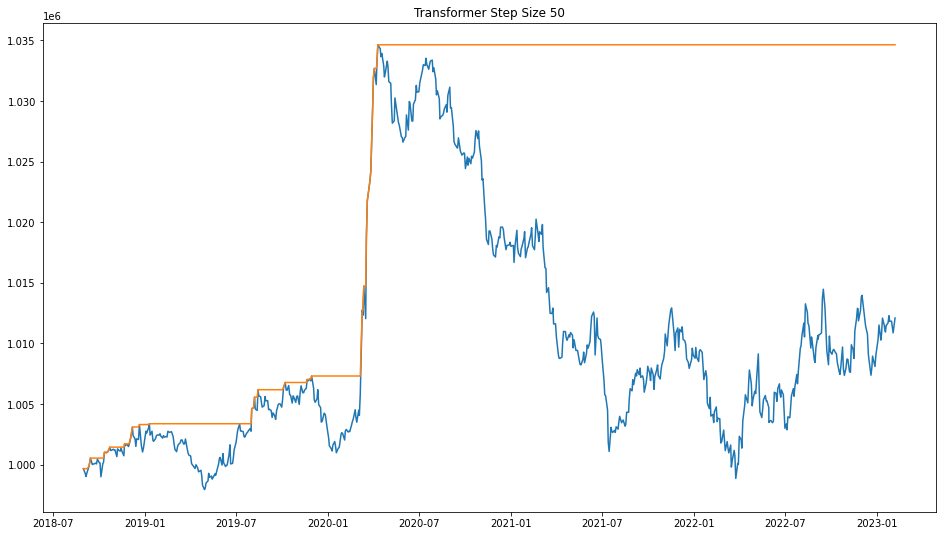

In [ ]:
# Get the baseline model. 
# If not using partial functions, uncomment this line:
# get_base_model(x_train, y_train, **TRANSFORMER_KWARGS)
base_m = partial_base_model()

x, y = run_stepped_inc(
    base_m, x_test, y_test, step_size=50, epochs=5, batch_size=64,
)

# Start building aggregate return DataFrame for comparison.
rets_agg["Transformer Step Size 50"], tf_rets50 = summ_and_plot(x, y, title="Transformer Step Size 50", idx=rets_idx)

## Creating The Transformer Model

- code creates a Transformer model, compiles it with mean squared error loss and Adam optimizer, and fits it to training data. 
- It then uses the trained model to predict on test data in increments of 50 time periods, with each increment retraining the model on all data up to the current time period. 
- The results are summarized and plotted.

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 50, 26)]     0           []                               
                                                                                                  
 layer_normalization_288 (Layer  (None, 50, 26)      52          ['input_37[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_144 (Mult  (None, 50, 26)      109594      ['layer_normalization_288[0][0]',
 iHeadAttention)                                                  'layer_normalization_288[0][0]']
                                                                                           

15/15 [==============================] - 13s 34ms/step - loss: 1938.0647
Epoch 2/200
15/15 [==============================] - ETA: 0s - loss: 1750.6924

15/15 [==============================] - 0s 29ms/step - loss: 1750.6924
Epoch 3/200
15/15 [==============================] - ETA: 0s - loss: 1387.6199

15/15 [==============================] - 0s 28ms/step - loss: 1387.6199
Epoch 4/200
15/15 [==============================] - ETA: 0s - loss: 1278.1113

15/15 [==============================] - 0s 28ms/step - loss: 1278.1113
Epoch 5/200
15/15 [==============================] - ETA: 0s - loss: 1105.0448

15/15 [==============================] - 0s 29ms/step - loss: 1105.0448
Epoch 6/200
15/15 [==============================] - ETA: 0s - loss: 976.7825

15/15 [==============================] - 0s 29ms/step - loss: 976.7825
Epoch 7/200
15/15 [==============================] - ETA: 0s - loss: 840.8408

15/15 [==============================] - 0s 28ms/step - loss: 840.8408
Epoch 8/200
15/15 [==============================] - ETA: 0s - loss: 696.1198

15/15 [==============================] - 0s 28ms/step - loss: 696.1198
Epoch 9/200
15/15 [==============================] - ETA: 0s - loss: 653.2047

15/15 [==============================] - 0s 28ms/step - loss: 653.2047
Epoch 10/200
15/15 [==============================] - ETA: 0s - loss: 554.7759

15/15 [==============================] - 0s 28ms/step - loss: 554.7759
Epoch 11/200
15/15 [==============================] - ETA: 0s - loss: 458.0639

15/15 [==============================] - 0s 29ms/step - loss: 458.0639
Epoch 12/200
15/15 [==============================] - ETA: 0s - loss: 348.3932

15/15 [==============================] - 0s 29ms/step - loss: 348.3932
Epoch 13/200
15/15 [==============================] - ETA: 0s - loss: 310.9707

15/15 [==============================] - 0s 29ms/step - loss: 310.9707
Epoch 14/200
15/15 [==============================] - ETA: 0s - loss: 259.3914

15/15 [==============================] - 0s 29ms/step - loss: 259.3914
Epoch 15/200
15/15 [==============================] - ETA: 0s - loss: 228.2986

15/15 [==============================] - 0s 28ms/step - loss: 228.2986
Epoch 16/200
15/15 [==============================] - ETA: 0s - loss: 212.0990

15/15 [==============================] - 0s 29ms/step - loss: 212.0990
Epoch 17/200
15/15 [==============================] - ETA: 0s - loss: 158.1759

15/15 [==============================] - 0s 29ms/step - loss: 158.1759
Epoch 18/200
15/15 [==============================] - ETA: 0s - loss: 144.1486

15/15 [==============================] - 0s 28ms/step - loss: 144.1486
Epoch 19/200
15/15 [==============================] - ETA: 0s - loss: 124.7045

15/15 [==============================] - 0s 30ms/step - loss: 124.7045
Epoch 20/200
15/15 [==============================] - ETA: 0s - loss: 110.7780

15/15 [==============================] - 0s 29ms/step - loss: 110.7780
Epoch 21/200
15/15 [==============================] - ETA: 0s - loss: 87.7397

15/15 [==============================] - 0s 29ms/step - loss: 87.7397
Epoch 22/200
15/15 [==============================] - ETA: 0s - loss: 68.3998

15/15 [==============================] - 0s 29ms/step - loss: 68.3998
Epoch 23/200
15/15 [==============================] - ETA: 0s - loss: 52.6009

15/15 [==============================] - 0s 32ms/step - loss: 52.6009
Epoch 24/200
15/15 [==============================] - ETA: 0s - loss: 47.3385

15/15 [==============================] - 0s 30ms/step - loss: 47.3385
Epoch 25/200
15/15 [==============================] - ETA: 0s - loss: 38.1374

15/15 [==============================] - 0s 30ms/step - loss: 38.1374
Epoch 26/200
15/15 [==============================] - ETA: 0s - loss: 33.4889

15/15 [==============================] - 0s 32ms/step - loss: 33.4889
Epoch 27/200
15/15 [==============================] - ETA: 0s - loss: 28.3428

15/15 [==============================] - 1s 33ms/step - loss: 28.3428
Epoch 28/200
15/15 [==============================] - ETA: 0s - loss: 24.2223

15/15 [==============================] - 0s 32ms/step - loss: 24.2223
Epoch 29/200
15/15 [==============================] - ETA: 0s - loss: 20.3624

15/15 [==============================] - 0s 33ms/step - loss: 20.3624
Epoch 30/200
15/15 [==============================] - ETA: 0s - loss: 17.6452

15/15 [==============================] - 0s 32ms/step - loss: 17.6452
Epoch 31/200
15/15 [==============================] - ETA: 0s - loss: 15.1635

15/15 [==============================] - 0s 29ms/step - loss: 15.1635
Epoch 32/200
15/15 [==============================] - ETA: 0s - loss: 12.7463

15/15 [==============================] - 0s 29ms/step - loss: 12.7463
Epoch 33/200
15/15 [==============================] - ETA: 0s - loss: 11.8628

15/15 [==============================] - 0s 29ms/step - loss: 11.8628
Epoch 34/200
15/15 [==============================] - ETA: 0s - loss: 10.8528

15/15 [==============================] - 0s 30ms/step - loss: 10.8528
Epoch 35/200
15/15 [==============================] - ETA: 0s - loss: 11.2848

15/15 [==============================] - 0s 29ms/step - loss: 11.2848
Epoch 36/200
15/15 [==============================] - ETA: 0s - loss: 9.9470

15/15 [==============================] - 0s 30ms/step - loss: 9.9470
Epoch 37/200
15/15 [==============================] - ETA: 0s - loss: 9.2232

15/15 [==============================] - 0s 29ms/step - loss: 9.2232
Epoch 38/200
15/15 [==============================] - ETA: 0s - loss: 8.7506

15/15 [==============================] - 0s 29ms/step - loss: 8.7506
Epoch 39/200
15/15 [==============================] - ETA: 0s - loss: 7.7902

15/15 [==============================] - 0s 30ms/step - loss: 7.7902
Epoch 40/200
15/15 [==============================] - ETA: 0s - loss: 9.3403

15/15 [==============================] - 0s 29ms/step - loss: 9.3403
Epoch 41/200
15/15 [==============================] - ETA: 0s - loss: 8.1839

15/15 [==============================] - 0s 30ms/step - loss: 8.1839
Epoch 42/200
15/15 [==============================] - ETA: 0s - loss: 7.6782

15/15 [==============================] - 0s 30ms/step - loss: 7.6782
Epoch 43/200
15/15 [==============================] - ETA: 0s - loss: 8.7134

15/15 [==============================] - 0s 29ms/step - loss: 8.7134
Epoch 44/200
15/15 [==============================] - ETA: 0s - loss: 8.1590

15/15 [==============================] - 0s 29ms/step - loss: 8.1590
Epoch 45/200
15/15 [==============================] - ETA: 0s - loss: 8.3995

15/15 [==============================] - 0s 29ms/step - loss: 8.3995
Epoch 46/200
15/15 [==============================] - ETA: 0s - loss: 8.5527

15/15 [==============================] - 0s 29ms/step - loss: 8.5527
Epoch 47/200
15/15 [==============================] - ETA: 0s - loss: 8.1032

15/15 [==============================] - 0s 29ms/step - loss: 8.1032
Epoch 48/200
15/15 [==============================] - ETA: 0s - loss: 8.6566

15/15 [==============================] - 0s 29ms/step - loss: 8.6566
Epoch 49/200
15/15 [==============================] - ETA: 0s - loss: 8.0587

15/15 [==============================] - 0s 28ms/step - loss: 8.0587
Epoch 50/200
15/15 [==============================] - ETA: 0s - loss: 7.9425

15/15 [==============================] - 0s 29ms/step - loss: 7.9425
Epoch 51/200
15/15 [==============================] - ETA: 0s - loss: 8.0618

15/15 [==============================] - 0s 29ms/step - loss: 8.0618
Epoch 52/200
15/15 [==============================] - ETA: 0s - loss: 7.8606

15/15 [==============================] - 0s 30ms/step - loss: 7.8606
Epoch 53/200
15/15 [==============================] - ETA: 0s - loss: 8.0277

15/15 [==============================] - 0s 33ms/step - loss: 8.0277
Epoch 54/200
15/15 [==============================] - ETA: 0s - loss: 7.9422

15/15 [==============================] - 0s 31ms/step - loss: 7.9422
Epoch 55/200
15/15 [==============================] - ETA: 0s - loss: 7.9597

15/15 [==============================] - 0s 32ms/step - loss: 7.9597
Epoch 56/200
15/15 [==============================] - ETA: 0s - loss: 7.5170

15/15 [==============================] - 0s 31ms/step - loss: 7.5170
Epoch 57/200
15/15 [==============================] - ETA: 0s - loss: 7.6093

15/15 [==============================] - 0s 31ms/step - loss: 7.6093
Epoch 58/200
15/15 [==============================] - ETA: 0s - loss: 7.9128

15/15 [==============================] - 0s 31ms/step - loss: 7.9128
Epoch 59/200
15/15 [==============================] - ETA: 0s - loss: 7.1540

15/15 [==============================] - 0s 31ms/step - loss: 7.1540
Epoch 60/200
15/15 [==============================] - ETA: 0s - loss: 7.0518

15/15 [==============================] - 0s 31ms/step - loss: 7.0518
Epoch 61/200
15/15 [==============================] - ETA: 0s - loss: 7.2408

15/15 [==============================] - 0s 29ms/step - loss: 7.2408
Epoch 62/200
15/15 [==============================] - ETA: 0s - loss: 7.7376

15/15 [==============================] - 0s 29ms/step - loss: 7.7376
Epoch 63/200
15/15 [==============================] - ETA: 0s - loss: 6.9617

15/15 [==============================] - 0s 29ms/step - loss: 6.9617
Epoch 64/200
15/15 [==============================] - ETA: 0s - loss: 6.9833

15/15 [==============================] - 0s 30ms/step - loss: 6.9833
Epoch 65/200
15/15 [==============================] - ETA: 0s - loss: 7.3270

15/15 [==============================] - 0s 29ms/step - loss: 7.3270
Epoch 66/200
15/15 [==============================] - ETA: 0s - loss: 6.3783

15/15 [==============================] - 0s 29ms/step - loss: 6.3783
Epoch 67/200
15/15 [==============================] - ETA: 0s - loss: 7.0010

15/15 [==============================] - 0s 29ms/step - loss: 7.0010
Epoch 68/200
15/15 [==============================] - ETA: 0s - loss: 6.7226

15/15 [==============================] - 0s 29ms/step - loss: 6.7226
Epoch 69/200
15/15 [==============================] - ETA: 0s - loss: 7.3371

15/15 [==============================] - 0s 29ms/step - loss: 7.3371
Epoch 70/200
15/15 [==============================] - ETA: 0s - loss: 7.2490

15/15 [==============================] - 0s 29ms/step - loss: 7.2490
Epoch 71/200
15/15 [==============================] - ETA: 0s - loss: 7.1787

15/15 [==============================] - 0s 30ms/step - loss: 7.1787
Epoch 72/200
15/15 [==============================] - ETA: 0s - loss: 6.8248

15/15 [==============================] - 0s 28ms/step - loss: 6.8248
Epoch 73/200
15/15 [==============================] - ETA: 0s - loss: 6.8600

15/15 [==============================] - 0s 31ms/step - loss: 6.8600
Epoch 74/200
15/15 [==============================] - ETA: 0s - loss: 6.5742

15/15 [==============================] - 0s 30ms/step - loss: 6.5742
Epoch 75/200
15/15 [==============================] - ETA: 0s - loss: 7.1442

15/15 [==============================] - 0s 29ms/step - loss: 7.1442
Epoch 76/200
15/15 [==============================] - ETA: 0s - loss: 6.7767

15/15 [==============================] - 0s 29ms/step - loss: 6.7767
Epoch 77/200
15/15 [==============================] - ETA: 0s - loss: 6.8304

15/15 [==============================] - 0s 29ms/step - loss: 6.8304
Epoch 78/200
15/15 [==============================] - ETA: 0s - loss: 6.5545

15/15 [==============================] - 0s 30ms/step - loss: 6.5545
Epoch 79/200
15/15 [==============================] - ETA: 0s - loss: 6.7816

15/15 [==============================] - 0s 30ms/step - loss: 6.7816
Epoch 80/200
15/15 [==============================] - ETA: 0s - loss: 7.0003

15/15 [==============================] - 0s 29ms/step - loss: 7.0003
Epoch 81/200
15/15 [==============================] - ETA: 0s - loss: 6.9446

15/15 [==============================] - 0s 30ms/step - loss: 6.9446
Epoch 82/200
15/15 [==============================] - ETA: 0s - loss: 6.9039

15/15 [==============================] - 0s 30ms/step - loss: 6.9039
Epoch 83/200
15/15 [==============================] - ETA: 0s - loss: 6.1676

15/15 [==============================] - 0s 32ms/step - loss: 6.1676
Epoch 84/200
15/15 [==============================] - ETA: 0s - loss: 6.5327

15/15 [==============================] - 0s 31ms/step - loss: 6.5327
Epoch 85/200
15/15 [==============================] - ETA: 0s - loss: 6.8497

15/15 [==============================] - 0s 31ms/step - loss: 6.8497
Epoch 86/200
15/15 [==============================] - ETA: 0s - loss: 5.8624

15/15 [==============================] - 0s 30ms/step - loss: 5.8624
Epoch 87/200
15/15 [==============================] - ETA: 0s - loss: 6.3809

15/15 [==============================] - 0s 31ms/step - loss: 6.3809
Epoch 88/200
15/15 [==============================] - ETA: 0s - loss: 6.6897

15/15 [==============================] - 0s 32ms/step - loss: 6.6897
Epoch 89/200
15/15 [==============================] - ETA: 0s - loss: 6.4466

15/15 [==============================] - 0s 32ms/step - loss: 6.4466
Epoch 90/200
15/15 [==============================] - ETA: 0s - loss: 6.7767

15/15 [==============================] - 0s 32ms/step - loss: 6.7767
Epoch 91/200
15/15 [==============================] - ETA: 0s - loss: 6.2492

15/15 [==============================] - 0s 30ms/step - loss: 6.2492
Epoch 92/200
15/15 [==============================] - ETA: 0s - loss: 6.1507

15/15 [==============================] - 0s 30ms/step - loss: 6.1507
Epoch 93/200
15/15 [==============================] - ETA: 0s - loss: 6.1913

15/15 [==============================] - 0s 30ms/step - loss: 6.1913
Epoch 94/200
15/15 [==============================] - ETA: 0s - loss: 6.1364

15/15 [==============================] - 0s 28ms/step - loss: 6.1364
Epoch 95/200
15/15 [==============================] - ETA: 0s - loss: 6.5217

15/15 [==============================] - 0s 30ms/step - loss: 6.5217
Epoch 96/200
15/15 [==============================] - ETA: 0s - loss: 6.2812

15/15 [==============================] - 0s 30ms/step - loss: 6.2812
Epoch 97/200
15/15 [==============================] - ETA: 0s - loss: 6.5821

15/15 [==============================] - 0s 30ms/step - loss: 6.5821
Epoch 98/200
15/15 [==============================] - ETA: 0s - loss: 6.1074

15/15 [==============================] - 0s 30ms/step - loss: 6.1074
Epoch 99/200
15/15 [==============================] - ETA: 0s - loss: 6.0394

15/15 [==============================] - 0s 29ms/step - loss: 6.0394
Epoch 100/200
15/15 [==============================] - ETA: 0s - loss: 6.4573

15/15 [==============================] - 0s 29ms/step - loss: 6.4573
Epoch 101/200
15/15 [==============================] - ETA: 0s - loss: 6.3941

15/15 [==============================] - 0s 30ms/step - loss: 6.3941
Epoch 102/200
15/15 [==============================] - ETA: 0s - loss: 5.5990

15/15 [==============================] - 0s 30ms/step - loss: 5.5990
Epoch 103/200
15/15 [==============================] - ETA: 0s - loss: 5.8948

15/15 [==============================] - 0s 29ms/step - loss: 5.8948
Epoch 104/200
15/15 [==============================] - ETA: 0s - loss: 5.5621

15/15 [==============================] - 0s 29ms/step - loss: 5.5621
Epoch 105/200
15/15 [==============================] - ETA: 0s - loss: 6.2000

15/15 [==============================] - 0s 29ms/step - loss: 6.2000
Epoch 106/200
15/15 [==============================] - ETA: 0s - loss: 5.5794

15/15 [==============================] - 0s 30ms/step - loss: 5.5794
Epoch 107/200
15/15 [==============================] - ETA: 0s - loss: 5.9384

15/15 [==============================] - 0s 29ms/step - loss: 5.9384
Epoch 108/200
15/15 [==============================] - ETA: 0s - loss: 6.0660

15/15 [==============================] - 0s 30ms/step - loss: 6.0660
Epoch 109/200
15/15 [==============================] - ETA: 0s - loss: 5.7028

15/15 [==============================] - 0s 30ms/step - loss: 5.7028
Epoch 110/200
15/15 [==============================] - ETA: 0s - loss: 5.7990

15/15 [==============================] - 0s 30ms/step - loss: 5.7990
Epoch 111/200
15/15 [==============================] - ETA: 0s - loss: 6.0966

15/15 [==============================] - 0s 30ms/step - loss: 6.0966
Epoch 112/200
15/15 [==============================] - ETA: 0s - loss: 5.7155

15/15 [==============================] - 0s 29ms/step - loss: 5.7155
Epoch 113/200
15/15 [==============================] - ETA: 0s - loss: 5.6623

15/15 [==============================] - 0s 30ms/step - loss: 5.6623
Epoch 114/200
15/15 [==============================] - ETA: 0s - loss: 5.6289

15/15 [==============================] - 1s 34ms/step - loss: 5.6289
Epoch 115/200
15/15 [==============================] - ETA: 0s - loss: 5.9045

15/15 [==============================] - 0s 31ms/step - loss: 5.9045
Epoch 116/200
15/15 [==============================] - ETA: 0s - loss: 5.9388

15/15 [==============================] - 0s 31ms/step - loss: 5.9388
Epoch 117/200
15/15 [==============================] - ETA: 0s - loss: 5.2945

15/15 [==============================] - 0s 30ms/step - loss: 5.2945
Epoch 118/200
15/15 [==============================] - ETA: 0s - loss: 5.9157

15/15 [==============================] - 0s 32ms/step - loss: 5.9157
Epoch 119/200
15/15 [==============================] - ETA: 0s - loss: 5.5494

15/15 [==============================] - 0s 32ms/step - loss: 5.5494
Epoch 120/200
15/15 [==============================] - ETA: 0s - loss: 5.7252

15/15 [==============================] - 0s 32ms/step - loss: 5.7252
Epoch 121/200
15/15 [==============================] - ETA: 0s - loss: 5.0597

15/15 [==============================] - 0s 32ms/step - loss: 5.0597
Epoch 122/200
15/15 [==============================] - ETA: 0s - loss: 6.7861

15/15 [==============================] - 0s 29ms/step - loss: 6.7861
Epoch 123/200
15/15 [==============================] - ETA: 0s - loss: 5.7730

15/15 [==============================] - 0s 30ms/step - loss: 5.7730
Epoch 124/200
15/15 [==============================] - ETA: 0s - loss: 5.7455

15/15 [==============================] - 0s 30ms/step - loss: 5.7455
Epoch 125/200
15/15 [==============================] - ETA: 0s - loss: 5.7390

15/15 [==============================] - 0s 30ms/step - loss: 5.7390
Epoch 126/200
15/15 [==============================] - ETA: 0s - loss: 5.7031

15/15 [==============================] - 0s 29ms/step - loss: 5.7031
Epoch 127/200
15/15 [==============================] - ETA: 0s - loss: 5.6284

15/15 [==============================] - 0s 29ms/step - loss: 5.6284
Epoch 128/200
15/15 [==============================] - ETA: 0s - loss: 5.3696

15/15 [==============================] - 0s 29ms/step - loss: 5.3696
Epoch 129/200
15/15 [==============================] - ETA: 0s - loss: 5.5165

15/15 [==============================] - 0s 29ms/step - loss: 5.5165
Epoch 130/200
15/15 [==============================] - ETA: 0s - loss: 5.8919

15/15 [==============================] - 0s 30ms/step - loss: 5.8919
Epoch 131/200
15/15 [==============================] - ETA: 0s - loss: 5.5240

15/15 [==============================] - 0s 29ms/step - loss: 5.5240
Epoch 132/200
15/15 [==============================] - ETA: 0s - loss: 5.2445

15/15 [==============================] - 0s 30ms/step - loss: 5.2445
Epoch 133/200
15/15 [==============================] - ETA: 0s - loss: 5.8466

15/15 [==============================] - 0s 29ms/step - loss: 5.8466
Epoch 134/200
15/15 [==============================] - ETA: 0s - loss: 5.6760

15/15 [==============================] - 0s 31ms/step - loss: 5.6760
Epoch 135/200
15/15 [==============================] - ETA: 0s - loss: 5.6857

15/15 [==============================] - 0s 30ms/step - loss: 5.6857
Epoch 136/200
15/15 [==============================] - ETA: 0s - loss: 5.0061

15/15 [==============================] - 0s 30ms/step - loss: 5.0061
Epoch 137/200
15/15 [==============================] - ETA: 0s - loss: 5.5474

15/15 [==============================] - 0s 30ms/step - loss: 5.5474
Epoch 138/200
15/15 [==============================] - ETA: 0s - loss: 5.4965

15/15 [==============================] - 0s 29ms/step - loss: 5.4965
Epoch 139/200
15/15 [==============================] - ETA: 0s - loss: 5.4619

15/15 [==============================] - 0s 30ms/step - loss: 5.4619
Epoch 140/200
15/15 [==============================] - ETA: 0s - loss: 5.5890

15/15 [==============================] - 0s 29ms/step - loss: 5.5890
Epoch 141/200
15/15 [==============================] - ETA: 0s - loss: 5.2750

15/15 [==============================] - 0s 30ms/step - loss: 5.2750
Epoch 142/200
15/15 [==============================] - ETA: 0s - loss: 5.0829

15/15 [==============================] - 0s 29ms/step - loss: 5.0829
Epoch 143/200
15/15 [==============================] - ETA: 0s - loss: 5.6176

15/15 [==============================] - 0s 30ms/step - loss: 5.6176
Epoch 144/200
15/15 [==============================] - ETA: 0s - loss: 5.0919

15/15 [==============================] - 0s 32ms/step - loss: 5.0919
Epoch 145/200
15/15 [==============================] - ETA: 0s - loss: 5.4930

15/15 [==============================] - 0s 32ms/step - loss: 5.4930
Epoch 146/200
15/15 [==============================] - ETA: 0s - loss: 5.2280

15/15 [==============================] - 0s 31ms/step - loss: 5.2280
Epoch 147/200
15/15 [==============================] - ETA: 0s - loss: 5.4119

15/15 [==============================] - 0s 30ms/step - loss: 5.4119
Epoch 148/200
15/15 [==============================] - ETA: 0s - loss: 5.7032

15/15 [==============================] - 0s 30ms/step - loss: 5.7032
Epoch 149/200
15/15 [==============================] - ETA: 0s - loss: 5.4495

15/15 [==============================] - 0s 30ms/step - loss: 5.4495
Epoch 150/200
15/15 [==============================] - ETA: 0s - loss: 5.4824

15/15 [==============================] - 0s 31ms/step - loss: 5.4824
Epoch 151/200
15/15 [==============================] - ETA: 0s - loss: 5.8870

15/15 [==============================] - 0s 31ms/step - loss: 5.8870
Epoch 152/200
15/15 [==============================] - ETA: 0s - loss: 5.1815

15/15 [==============================] - 0s 32ms/step - loss: 5.1815
Epoch 153/200
15/15 [==============================] - ETA: 0s - loss: 5.3573

15/15 [==============================] - 0s 29ms/step - loss: 5.3573
Epoch 154/200
15/15 [==============================] - ETA: 0s - loss: 5.7135

15/15 [==============================] - 0s 30ms/step - loss: 5.7135
Epoch 155/200
15/15 [==============================] - ETA: 0s - loss: 5.5080

15/15 [==============================] - 0s 30ms/step - loss: 5.5080
Epoch 156/200
15/15 [==============================] - ETA: 0s - loss: 5.2097

15/15 [==============================] - 0s 30ms/step - loss: 5.2097
Epoch 157/200
15/15 [==============================] - ETA: 0s - loss: 5.3834

15/15 [==============================] - 0s 30ms/step - loss: 5.3834
Epoch 158/200
15/15 [==============================] - ETA: 0s - loss: 5.1923

15/15 [==============================] - 0s 29ms/step - loss: 5.1923
Epoch 159/200
15/15 [==============================] - ETA: 0s - loss: 5.0658

15/15 [==============================] - 0s 30ms/step - loss: 5.0658
Epoch 160/200
15/15 [==============================] - ETA: 0s - loss: 5.1153

15/15 [==============================] - 0s 30ms/step - loss: 5.1153
Epoch 161/200
15/15 [==============================] - ETA: 0s - loss: 4.8098

15/15 [==============================] - 0s 29ms/step - loss: 4.8098
Epoch 162/200
15/15 [==============================] - ETA: 0s - loss: 5.2186

15/15 [==============================] - 0s 30ms/step - loss: 5.2186
Epoch 163/200
15/15 [==============================] - ETA: 0s - loss: 5.3396

15/15 [==============================] - 0s 30ms/step - loss: 5.3396
Epoch 164/200
15/15 [==============================] - ETA: 0s - loss: 5.0105

15/15 [==============================] - 0s 29ms/step - loss: 5.0105
Epoch 165/200
15/15 [==============================] - ETA: 0s - loss: 5.2572

15/15 [==============================] - 0s 30ms/step - loss: 5.2572
Epoch 166/200
15/15 [==============================] - ETA: 0s - loss: 5.0297

15/15 [==============================] - 0s 29ms/step - loss: 5.0297
Epoch 167/200
15/15 [==============================] - ETA: 0s - loss: 4.7281

15/15 [==============================] - 0s 29ms/step - loss: 4.7281
Epoch 168/200
15/15 [==============================] - ETA: 0s - loss: 4.8803

15/15 [==============================] - 0s 30ms/step - loss: 4.8803
Epoch 169/200
15/15 [==============================] - ETA: 0s - loss: 4.7355

15/15 [==============================] - 0s 29ms/step - loss: 4.7355
Epoch 170/200
15/15 [==============================] - ETA: 0s - loss: 5.1948

15/15 [==============================] - 0s 30ms/step - loss: 5.1948
Epoch 171/200
15/15 [==============================] - ETA: 0s - loss: 4.8867

15/15 [==============================] - 0s 29ms/step - loss: 4.8867
Epoch 172/200
15/15 [==============================] - ETA: 0s - loss: 4.6659

15/15 [==============================] - 0s 29ms/step - loss: 4.6659
Epoch 173/200
15/15 [==============================] - ETA: 0s - loss: 4.8314

15/15 [==============================] - 0s 29ms/step - loss: 4.8314
Epoch 174/200
15/15 [==============================] - ETA: 0s - loss: 4.7644

15/15 [==============================] - 0s 29ms/step - loss: 4.7644
Epoch 175/200
15/15 [==============================] - ETA: 0s - loss: 4.9484

15/15 [==============================] - 0s 32ms/step - loss: 4.9484
Epoch 176/200
15/15 [==============================] - ETA: 0s - loss: 4.8136

15/15 [==============================] - 0s 31ms/step - loss: 4.8136
Epoch 177/200
15/15 [==============================] - ETA: 0s - loss: 5.0156

15/15 [==============================] - 0s 32ms/step - loss: 5.0156
Epoch 178/200
15/15 [==============================] - ETA: 0s - loss: 5.1428

15/15 [==============================] - 0s 30ms/step - loss: 5.1428
Epoch 179/200
15/15 [==============================] - ETA: 0s - loss: 5.1617

15/15 [==============================] - 0s 31ms/step - loss: 5.1617
Epoch 180/200
15/15 [==============================] - ETA: 0s - loss: 4.9849

15/15 [==============================] - 1s 34ms/step - loss: 4.9849
Epoch 181/200
15/15 [==============================] - ETA: 0s - loss: 5.0926

15/15 [==============================] - 0s 31ms/step - loss: 5.0926
Epoch 182/200
15/15 [==============================] - ETA: 0s - loss: 4.9241

15/15 [==============================] - 0s 31ms/step - loss: 4.9241
Epoch 183/200
15/15 [==============================] - ETA: 0s - loss: 4.7197

15/15 [==============================] - 0s 31ms/step - loss: 4.7197
Epoch 184/200
15/15 [==============================] - ETA: 0s - loss: 4.3928

15/15 [==============================] - 0s 30ms/step - loss: 4.3928
Epoch 185/200
15/15 [==============================] - ETA: 0s - loss: 4.8591

15/15 [==============================] - 0s 30ms/step - loss: 4.8591
Epoch 186/200
15/15 [==============================] - ETA: 0s - loss: 4.9202

15/15 [==============================] - 0s 30ms/step - loss: 4.9202
Epoch 187/200
15/15 [==============================] - ETA: 0s - loss: 4.4894

15/15 [==============================] - 0s 29ms/step - loss: 4.4894
Epoch 188/200
15/15 [==============================] - ETA: 0s - loss: 4.8284

15/15 [==============================] - 0s 30ms/step - loss: 4.8284
Epoch 189/200
15/15 [==============================] - ETA: 0s - loss: 4.4792

15/15 [==============================] - 0s 30ms/step - loss: 4.4792
Epoch 190/200
15/15 [==============================] - ETA: 0s - loss: 4.9912

15/15 [==============================] - 0s 29ms/step - loss: 4.9912
Epoch 191/200
15/15 [==============================] - ETA: 0s - loss: 4.9343

15/15 [==============================] - 0s 31ms/step - loss: 4.9343
Epoch 192/200
15/15 [==============================] - ETA: 0s - loss: 4.5707

15/15 [==============================] - 0s 30ms/step - loss: 4.5707
Epoch 193/200
15/15 [==============================] - ETA: 0s - loss: 4.3567

15/15 [==============================] - 0s 31ms/step - loss: 4.3567
Epoch 194/200
15/15 [==============================] - ETA: 0s - loss: 4.6188

15/15 [==============================] - 0s 30ms/step - loss: 4.6188
Epoch 195/200
15/15 [==============================] - ETA: 0s - loss: 4.9949

15/15 [==============================] - 0s 30ms/step - loss: 4.9949
Epoch 196/200
15/15 [==============================] - ETA: 0s - loss: 4.4102

15/15 [==============================] - 0s 30ms/step - loss: 4.4102
Epoch 197/200
15/15 [==============================] - ETA: 0s - loss: 4.9911

15/15 [==============================] - 0s 31ms/step - loss: 4.9911
Epoch 198/200
15/15 [==============================] - ETA: 0s - loss: 4.5384

15/15 [==============================] - 0s 30ms/step - loss: 4.5384
Epoch 199/200
15/15 [==============================] - ETA: 0s - loss: 4.6225

15/15 [==============================] - 0s 32ms/step - loss: 4.6225
Epoch 200/200
15/15 [==============================] - ETA: 0s - loss: 5.1069

15/15 [==============================] - 0s 30ms/step - loss: 5.1069


  0%|          | 0/70 [00:00<?, ?it/s]

4/4 [==============================] - 0s 9ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9878

2/2 [==============================] - 0s 32ms/step - loss: 3.8081
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4265

2/2 [==============================] - 0s 32ms/step - loss: 4.7403
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8269

2/2 [==============================] - 0s 30ms/step - loss: 3.4202
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1231

2/2 [==============================] - 0s 36ms/step - loss: 5.1183
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1400

2/2 [==============================] - 0s 35ms/step - loss: 4.2977


  1%|▏         | 1/70 [00:00<01:03,  1.08it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2144

2/2 [==============================] - 0s 31ms/step - loss: 4.8426
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6305

2/2 [==============================] - 0s 29ms/step - loss: 5.3380
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4492

2/2 [==============================] - 0s 32ms/step - loss: 4.9946
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1852

2/2 [==============================] - 0s 28ms/step - loss: 5.5297
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3161

2/2 [==============================] - 0s 30ms/step - loss: 4.4100


  3%|▎         | 2/70 [00:01<00:58,  1.16it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7283

2/2 [==============================] - 0s 33ms/step - loss: 4.8525
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 2.5538

2/2 [==============================] - 0s 28ms/step - loss: 3.1079
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6483

2/2 [==============================] - 0s 25ms/step - loss: 4.5055
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.6696

2/2 [==============================] - 0s 30ms/step - loss: 4.8844
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9291

2/2 [==============================] - 0s 25ms/step - loss: 5.0194


  4%|▍         | 3/70 [00:02<00:55,  1.21it/s]

4/4 [==============================] - 0s 6ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4853

2/2 [==============================] - 0s 30ms/step - loss: 4.0877
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.7582

2/2 [==============================] - 0s 27ms/step - loss: 6.0566
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6601

2/2 [==============================] - 0s 29ms/step - loss: 3.9537
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1874

2/2 [==============================] - 0s 41ms/step - loss: 4.4082
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.6692

2/2 [==============================] - 0s 25ms/step - loss: 5.1214


  6%|▌         | 4/70 [00:03<00:52,  1.25it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 7.1524

2/2 [==============================] - 0s 29ms/step - loss: 5.9464
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9495

2/2 [==============================] - 0s 29ms/step - loss: 4.9382
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 6.1969

2/2 [==============================] - 0s 32ms/step - loss: 5.2646
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8655

2/2 [==============================] - 0s 27ms/step - loss: 4.2788
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1798

2/2 [==============================] - 0s 26ms/step - loss: 4.4730


  7%|▋         | 5/70 [00:04<00:51,  1.26it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.6600

2/2 [==============================] - 0s 28ms/step - loss: 5.5166
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2361

2/2 [==============================] - 0s 30ms/step - loss: 4.7372
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8437

2/2 [==============================] - 0s 30ms/step - loss: 5.0655
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2681

2/2 [==============================] - 0s 29ms/step - loss: 3.6970
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2998

2/2 [==============================] - 0s 32ms/step - loss: 5.3449


  9%|▊         | 6/70 [00:04<00:44,  1.43it/s]

4/4 [==============================] - 0s 6ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.1746

2/2 [==============================] - 0s 29ms/step - loss: 3.3948
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0447

2/2 [==============================] - 0s 26ms/step - loss: 4.7872
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3002

2/2 [==============================] - 0s 36ms/step - loss: 4.9004
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7847

2/2 [==============================] - 0s 34ms/step - loss: 5.3329
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5219

2/2 [==============================] - 0s 35ms/step - loss: 3.5863


 10%|█         | 7/70 [00:05<00:45,  1.37it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4373

2/2 [==============================] - 0s 27ms/step - loss: 4.0254
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 6.3856

2/2 [==============================] - 0s 27ms/step - loss: 5.6181
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9461

2/2 [==============================] - 0s 28ms/step - loss: 4.5350
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2500

2/2 [==============================] - 0s 30ms/step - loss: 4.5715
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 6.4659

2/2 [==============================] - 0s 30ms/step - loss: 5.9235


 11%|█▏        | 8/70 [00:06<00:46,  1.34it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4056

2/2 [==============================] - 0s 26ms/step - loss: 5.4050
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5682

2/2 [==============================] - 0s 29ms/step - loss: 4.6829
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8944

2/2 [==============================] - 0s 26ms/step - loss: 4.1941
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.9956

2/2 [==============================] - 0s 39ms/step - loss: 4.9478
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7331

2/2 [==============================] - 0s 39ms/step - loss: 3.8343


 13%|█▎        | 9/70 [00:06<00:46,  1.31it/s]

4/4 [==============================] - 0s 10ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7744

2/2 [==============================] - 0s 34ms/step - loss: 4.1686
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9817

2/2 [==============================] - 0s 34ms/step - loss: 3.6744
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2072

2/2 [==============================] - 0s 34ms/step - loss: 4.2196
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0367

2/2 [==============================] - 0s 35ms/step - loss: 3.8780
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6393

2/2 [==============================] - 0s 35ms/step - loss: 5.0777


 14%|█▍        | 10/70 [00:07<00:43,  1.38it/s]

4/4 [==============================] - 0s 10ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9524

2/2 [==============================] - 0s 38ms/step - loss: 3.9488
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9908

2/2 [==============================] - 0s 36ms/step - loss: 4.1449
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6322

2/2 [==============================] - 0s 42ms/step - loss: 3.5649
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6411

2/2 [==============================] - 0s 33ms/step - loss: 3.5386
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1034

2/2 [==============================] - 0s 40ms/step - loss: 4.3514


 16%|█▌        | 11/70 [00:08<00:45,  1.31it/s]

4/4 [==============================] - 0s 9ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3055

2/2 [==============================] - 0s 51ms/step - loss: 4.5798
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2546

2/2 [==============================] - 0s 41ms/step - loss: 4.8797
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8594

2/2 [==============================] - 0s 38ms/step - loss: 3.5954
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5278

2/2 [==============================] - 0s 33ms/step - loss: 3.4245
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.7137

2/2 [==============================] - 0s 36ms/step - loss: 5.0972


 17%|█▋        | 12/70 [00:09<00:45,  1.27it/s]

4/4 [==============================] - 0s 9ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7292

2/2 [==============================] - 0s 34ms/step - loss: 5.8963
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8446

2/2 [==============================] - 0s 32ms/step - loss: 4.5265
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4551

2/2 [==============================] - 0s 33ms/step - loss: 5.8496
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8431

2/2 [==============================] - 0s 33ms/step - loss: 3.5405
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6610

2/2 [==============================] - 0s 33ms/step - loss: 3.6666


 19%|█▊        | 13/70 [00:10<00:45,  1.25it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0237

2/2 [==============================] - 0s 28ms/step - loss: 5.5110
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.0843

2/2 [==============================] - 0s 32ms/step - loss: 3.8132
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8230

2/2 [==============================] - 0s 27ms/step - loss: 4.6730
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8936

2/2 [==============================] - 0s 33ms/step - loss: 4.0880
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8611

2/2 [==============================] - 0s 27ms/step - loss: 4.7063


 20%|██        | 14/70 [00:10<00:40,  1.40it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9961

2/2 [==============================] - 0s 37ms/step - loss: 4.4742
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4230

2/2 [==============================] - 0s 26ms/step - loss: 5.8280
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5604

2/2 [==============================] - 0s 25ms/step - loss: 4.0030
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0444

2/2 [==============================] - 0s 32ms/step - loss: 3.7665
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0075

2/2 [==============================] - 0s 25ms/step - loss: 4.4871


 21%|██▏       | 15/70 [00:11<00:40,  1.34it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2277

2/2 [==============================] - 0s 29ms/step - loss: 3.5819
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4753

2/2 [==============================] - 0s 29ms/step - loss: 4.3216
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5863

2/2 [==============================] - 0s 28ms/step - loss: 5.2193
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5989

2/2 [==============================] - 0s 25ms/step - loss: 4.2002
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.6736

2/2 [==============================] - 0s 29ms/step - loss: 5.1056


 23%|██▎       | 16/70 [00:11<00:35,  1.51it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9109

2/2 [==============================] - 0s 34ms/step - loss: 4.8004
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 2.7780

2/2 [==============================] - 0s 26ms/step - loss: 2.8539
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7511

2/2 [==============================] - 0s 28ms/step - loss: 4.3904
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1858

2/2 [==============================] - 0s 26ms/step - loss: 3.9270
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.9718

2/2 [==============================] - 0s 32ms/step - loss: 5.3526


 24%|██▍       | 17/70 [00:12<00:32,  1.63it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5990

2/2 [==============================] - 0s 35ms/step - loss: 4.3944
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9754

2/2 [==============================] - 0s 28ms/step - loss: 4.6430
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4536

2/2 [==============================] - 0s 27ms/step - loss: 5.3523
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2300

2/2 [==============================] - 0s 29ms/step - loss: 3.8244
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4353

2/2 [==============================] - 0s 29ms/step - loss: 4.1783


 26%|██▌       | 18/70 [00:13<00:34,  1.49it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4034

2/2 [==============================] - 0s 39ms/step - loss: 4.8657
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8482

2/2 [==============================] - 0s 32ms/step - loss: 4.4086
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 6.5655

2/2 [==============================] - 0s 28ms/step - loss: 5.1717
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0586

2/2 [==============================] - 0s 27ms/step - loss: 4.0361
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3620

2/2 [==============================] - 0s 32ms/step - loss: 4.8366


 27%|██▋       | 19/70 [00:14<00:35,  1.42it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8347

2/2 [==============================] - 0s 26ms/step - loss: 4.9861
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4669

2/2 [==============================] - 0s 29ms/step - loss: 4.6666
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2979

2/2 [==============================] - 0s 28ms/step - loss: 3.3672
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8563

2/2 [==============================] - 0s 34ms/step - loss: 4.4157
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5704

2/2 [==============================] - 0s 28ms/step - loss: 3.9872


 29%|██▊       | 20/70 [00:14<00:32,  1.53it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1968

2/2 [==============================] - 0s 31ms/step - loss: 5.4701
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5702

2/2 [==============================] - 0s 28ms/step - loss: 5.0524
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8955

2/2 [==============================] - 0s 35ms/step - loss: 4.6889
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1479

2/2 [==============================] - 0s 26ms/step - loss: 3.5773
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8584

2/2 [==============================] - 0s 27ms/step - loss: 3.8138


 30%|███       | 21/70 [00:15<00:33,  1.44it/s]

4/4 [==============================] - 0s 10ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2201

2/2 [==============================] - 0s 34ms/step - loss: 3.2049
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9800

2/2 [==============================] - 0s 28ms/step - loss: 4.4503
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0024

2/2 [==============================] - 0s 33ms/step - loss: 4.0642
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1495

2/2 [==============================] - 0s 31ms/step - loss: 4.2726
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 6.1155

2/2 [==============================] - 0s 26ms/step - loss: 5.1832


 31%|███▏      | 22/70 [00:16<00:34,  1.39it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2541

2/2 [==============================] - 0s 29ms/step - loss: 5.4775
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3847

2/2 [==============================] - 0s 29ms/step - loss: 4.6436
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1140

2/2 [==============================] - 0s 26ms/step - loss: 4.6751
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0952

2/2 [==============================] - 0s 33ms/step - loss: 4.1606
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7123

2/2 [==============================] - 0s 29ms/step - loss: 5.4011


 33%|███▎      | 23/70 [00:16<00:34,  1.35it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6881

2/2 [==============================] - 0s 27ms/step - loss: 4.6777
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3967

2/2 [==============================] - 0s 34ms/step - loss: 4.9240
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2472

2/2 [==============================] - 0s 29ms/step - loss: 4.6048
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3023

2/2 [==============================] - 0s 27ms/step - loss: 4.9860
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5939

2/2 [==============================] - 0s 32ms/step - loss: 4.7201


 34%|███▍      | 24/70 [00:17<00:31,  1.48it/s]

4/4 [==============================] - 0s 6ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4788

2/2 [==============================] - 0s 31ms/step - loss: 4.9204
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7340

2/2 [==============================] - 0s 34ms/step - loss: 5.5583
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8464

2/2 [==============================] - 0s 28ms/step - loss: 5.2926
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0776

2/2 [==============================] - 0s 31ms/step - loss: 5.2430
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5185

2/2 [==============================] - 0s 28ms/step - loss: 4.0089


 36%|███▌      | 25/70 [00:18<00:31,  1.41it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3359

2/2 [==============================] - 0s 28ms/step - loss: 4.7480
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9998

2/2 [==============================] - 0s 27ms/step - loss: 4.4455
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.1914

2/2 [==============================] - 0s 26ms/step - loss: 3.3306
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5153

2/2 [==============================] - 0s 33ms/step - loss: 4.4289
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2552

2/2 [==============================] - 0s 26ms/step - loss: 4.3375


 37%|███▋      | 26/70 [00:19<00:32,  1.36it/s]

4/4 [==============================] - 0s 9ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5102

2/2 [==============================] - 0s 34ms/step - loss: 5.3301
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1915

2/2 [==============================] - 0s 31ms/step - loss: 4.5037
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.0462

2/2 [==============================] - 0s 26ms/step - loss: 3.5118
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2013

2/2 [==============================] - 0s 32ms/step - loss: 4.5370
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6336

2/2 [==============================] - 0s 29ms/step - loss: 3.9096


 39%|███▊      | 27/70 [00:19<00:32,  1.33it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 2.9254

2/2 [==============================] - 0s 29ms/step - loss: 3.4783
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0154

2/2 [==============================] - 0s 51ms/step - loss: 3.4624
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6691

2/2 [==============================] - 0s 45ms/step - loss: 5.0298
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8102

2/2 [==============================] - 0s 42ms/step - loss: 4.1415
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5512

2/2 [==============================] - 0s 40ms/step - loss: 4.6631


 40%|████      | 28/70 [00:20<00:29,  1.42it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6583

2/2 [==============================] - 0s 33ms/step - loss: 3.5894
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0529

2/2 [==============================] - 0s 44ms/step - loss: 4.7076
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2603

2/2 [==============================] - 0s 35ms/step - loss: 5.0966
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9116

2/2 [==============================] - 0s 34ms/step - loss: 3.8347
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8581

2/2 [==============================] - 0s 39ms/step - loss: 5.6125


 41%|████▏     | 29/70 [00:21<00:27,  1.48it/s]

4/4 [==============================] - 0s 9ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7540

2/2 [==============================] - 0s 37ms/step - loss: 4.2206
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8106

2/2 [==============================] - 0s 37ms/step - loss: 5.1311
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9214

2/2 [==============================] - 0s 39ms/step - loss: 4.5691
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.4322

2/2 [==============================] - 0s 33ms/step - loss: 3.3312
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.4945

2/2 [==============================] - 0s 31ms/step - loss: 3.6067


 43%|████▎     | 30/70 [00:21<00:26,  1.51it/s]

4/4 [==============================] - 0s 9ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7602

2/2 [==============================] - 0s 49ms/step - loss: 4.6899
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9509

2/2 [==============================] - 0s 34ms/step - loss: 3.9990
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2878

2/2 [==============================] - 0s 44ms/step - loss: 4.4816
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5045

2/2 [==============================] - 0s 39ms/step - loss: 5.3221
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5086

2/2 [==============================] - 0s 41ms/step - loss: 4.8240


 44%|████▍     | 31/70 [00:22<00:28,  1.37it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 2.7244

2/2 [==============================] - 0s 48ms/step - loss: 2.8132
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8101

2/2 [==============================] - 0s 44ms/step - loss: 4.5535
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 6.3934

2/2 [==============================] - 0s 41ms/step - loss: 5.8303
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.3617

2/2 [==============================] - 0s 35ms/step - loss: 3.5520
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2558

2/2 [==============================] - 0s 35ms/step - loss: 4.1705


 46%|████▌     | 32/70 [00:23<00:29,  1.30it/s]

4/4 [==============================] - 0s 10ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3143

2/2 [==============================] - 0s 38ms/step - loss: 4.6111
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7271

2/2 [==============================] - 0s 37ms/step - loss: 3.4278
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3528

2/2 [==============================] - 0s 48ms/step - loss: 4.8519
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4112

2/2 [==============================] - 0s 42ms/step - loss: 5.1982
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5979

2/2 [==============================] - 0s 42ms/step - loss: 4.9712


 47%|████▋     | 33/70 [00:24<00:27,  1.34it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3762

2/2 [==============================] - 0s 28ms/step - loss: 4.7114
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1126

2/2 [==============================] - 0s 26ms/step - loss: 4.2717
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.4578

2/2 [==============================] - 0s 27ms/step - loss: 3.4998
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0870

2/2 [==============================] - 0s 35ms/step - loss: 5.3444
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2585

2/2 [==============================] - 0s 26ms/step - loss: 4.7638


 49%|████▊     | 34/70 [00:24<00:27,  1.30it/s]

4/4 [==============================] - 0s 6ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8573

2/2 [==============================] - 0s 33ms/step - loss: 3.4654
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7992

2/2 [==============================] - 0s 28ms/step - loss: 3.8884
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8867

2/2 [==============================] - 0s 26ms/step - loss: 3.5351
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6916

2/2 [==============================] - 0s 29ms/step - loss: 3.9882
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6656

2/2 [==============================] - 0s 29ms/step - loss: 4.2285


 50%|█████     | 35/70 [00:25<00:24,  1.45it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9722

2/2 [==============================] - 0s 30ms/step - loss: 4.9039
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1470

2/2 [==============================] - 0s 27ms/step - loss: 4.0737
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1911

2/2 [==============================] - 0s 44ms/step - loss: 4.4227
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2881

2/2 [==============================] - 0s 31ms/step - loss: 3.0200
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4446

2/2 [==============================] - 0s 28ms/step - loss: 4.8896


 51%|█████▏    | 36/70 [00:25<00:22,  1.53it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4108

2/2 [==============================] - 0s 29ms/step - loss: 4.8893
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4296

2/2 [==============================] - 0s 27ms/step - loss: 4.6046
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9853

2/2 [==============================] - 0s 24ms/step - loss: 5.2668
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.4287

2/2 [==============================] - 0s 25ms/step - loss: 3.6637
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 2.8777

2/2 [==============================] - 0s 29ms/step - loss: 3.2062


 53%|█████▎    | 37/70 [00:26<00:23,  1.43it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3038

2/2 [==============================] - 0s 34ms/step - loss: 3.7927
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9858

2/2 [==============================] - 0s 31ms/step - loss: 3.4211
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5019

2/2 [==============================] - 0s 30ms/step - loss: 4.3227
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1680

2/2 [==============================] - 0s 31ms/step - loss: 3.9209
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6797

2/2 [==============================] - 0s 30ms/step - loss: 4.3359


 54%|█████▍    | 38/70 [00:27<00:23,  1.38it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 2.8095

2/2 [==============================] - 0s 31ms/step - loss: 3.0109
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2344

2/2 [==============================] - 0s 29ms/step - loss: 4.5017
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7875

2/2 [==============================] - 0s 29ms/step - loss: 4.2214
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8177

2/2 [==============================] - 0s 29ms/step - loss: 4.5089
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8711

2/2 [==============================] - 0s 33ms/step - loss: 4.2219


 56%|█████▌    | 39/70 [00:28<00:23,  1.34it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5539

2/2 [==============================] - 0s 27ms/step - loss: 4.5636
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3435

2/2 [==============================] - 0s 27ms/step - loss: 4.1358
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5333

2/2 [==============================] - 0s 32ms/step - loss: 4.2269
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6010

2/2 [==============================] - 0s 27ms/step - loss: 3.7730
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9485

2/2 [==============================] - 0s 28ms/step - loss: 4.9075


 57%|█████▋    | 40/70 [00:29<00:22,  1.31it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6943

2/2 [==============================] - 0s 29ms/step - loss: 4.1696
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0254

2/2 [==============================] - 0s 30ms/step - loss: 5.0683
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2269

2/2 [==============================] - 0s 25ms/step - loss: 4.2975
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.4654

2/2 [==============================] - 0s 29ms/step - loss: 3.6061
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1889

2/2 [==============================] - 0s 26ms/step - loss: 4.3740


 59%|█████▊    | 41/70 [00:29<00:19,  1.45it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4247

2/2 [==============================] - 0s 28ms/step - loss: 4.4917
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7706

2/2 [==============================] - 0s 28ms/step - loss: 3.8534
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 7.1915

2/2 [==============================] - 0s 26ms/step - loss: 5.9914
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.1194

2/2 [==============================] - 0s 29ms/step - loss: 3.4790
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4756

2/2 [==============================] - 0s 33ms/step - loss: 4.5645


 60%|██████    | 42/70 [00:30<00:20,  1.39it/s]

4/4 [==============================] - 0s 6ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.3318

2/2 [==============================] - 0s 27ms/step - loss: 3.6818
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0938

2/2 [==============================] - 0s 27ms/step - loss: 5.1538
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 2.8392

2/2 [==============================] - 0s 27ms/step - loss: 3.4594
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 2.6822

2/2 [==============================] - 0s 31ms/step - loss: 3.0337
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1627

2/2 [==============================] - 0s 30ms/step - loss: 4.8753


 61%|██████▏   | 43/70 [00:30<00:17,  1.52it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3419

2/2 [==============================] - 0s 31ms/step - loss: 4.6287
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8048

2/2 [==============================] - 0s 31ms/step - loss: 5.0528
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0994

2/2 [==============================] - 0s 29ms/step - loss: 3.5601
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.1570

2/2 [==============================] - 0s 35ms/step - loss: 3.6386
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7542

2/2 [==============================] - 0s 33ms/step - loss: 4.7447


 63%|██████▎   | 44/70 [00:31<00:15,  1.63it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8137

2/2 [==============================] - 0s 29ms/step - loss: 5.4754
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2127

2/2 [==============================] - 0s 29ms/step - loss: 2.9839
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 6.1666

2/2 [==============================] - 0s 27ms/step - loss: 5.1619
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8898

2/2 [==============================] - 0s 26ms/step - loss: 5.2966
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3967

2/2 [==============================] - 0s 25ms/step - loss: 3.9945


 64%|██████▍   | 45/70 [00:32<00:16,  1.48it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4672

2/2 [==============================] - 0s 39ms/step - loss: 3.8897
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3143

2/2 [==============================] - 0s 25ms/step - loss: 3.7645
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7435

2/2 [==============================] - 0s 28ms/step - loss: 4.4469
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5844

2/2 [==============================] - 0s 25ms/step - loss: 4.4089
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9069

2/2 [==============================] - 0s 28ms/step - loss: 4.1175


 66%|██████▌   | 46/70 [00:32<00:15,  1.60it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.3032

2/2 [==============================] - 0s 36ms/step - loss: 4.4523
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8872

2/2 [==============================] - 0s 30ms/step - loss: 4.9219
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4823

2/2 [==============================] - 0s 27ms/step - loss: 3.8187
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 6.4961

2/2 [==============================] - 0s 25ms/step - loss: 6.1396
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 2.9901

2/2 [==============================] - 0s 25ms/step - loss: 3.9387


 67%|██████▋   | 47/70 [00:33<00:13,  1.70it/s]

4/4 [==============================] - 0s 6ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9173

2/2 [==============================] - 0s 28ms/step - loss: 4.5856
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1780

2/2 [==============================] - 0s 26ms/step - loss: 4.0080
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.4643

2/2 [==============================] - 0s 34ms/step - loss: 3.9799
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.3842

2/2 [==============================] - 0s 35ms/step - loss: 4.0917
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8715

2/2 [==============================] - 0s 29ms/step - loss: 3.9602


 69%|██████▊   | 48/70 [00:34<00:14,  1.54it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.3484

2/2 [==============================] - 0s 53ms/step - loss: 3.6188
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8250

2/2 [==============================] - 0s 39ms/step - loss: 3.9493
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.0012

2/2 [==============================] - 0s 34ms/step - loss: 3.2023
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.1751

2/2 [==============================] - 0s 51ms/step - loss: 4.1226
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8281

2/2 [==============================] - 0s 42ms/step - loss: 4.3521


 70%|███████   | 49/70 [00:34<00:13,  1.52it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8683

2/2 [==============================] - 0s 44ms/step - loss: 3.9841
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9313

2/2 [==============================] - 0s 46ms/step - loss: 4.7890
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0081

2/2 [==============================] - 0s 44ms/step - loss: 3.8013
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.3430

2/2 [==============================] - 0s 31ms/step - loss: 3.4790
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2298

2/2 [==============================] - 0s 45ms/step - loss: 4.0789


 71%|███████▏  | 50/70 [00:35<00:14,  1.38it/s]

4/4 [==============================] - 0s 9ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2705

2/2 [==============================] - 0s 39ms/step - loss: 4.0971
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2662

2/2 [==============================] - 0s 31ms/step - loss: 4.6656
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7522

2/2 [==============================] - 0s 34ms/step - loss: 4.6456
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1750

2/2 [==============================] - 0s 38ms/step - loss: 3.9753
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0913

2/2 [==============================] - 0s 41ms/step - loss: 4.7677


 73%|███████▎  | 51/70 [00:36<00:14,  1.30it/s]

4/4 [==============================] - 0s 10ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2541

2/2 [==============================] - 0s 44ms/step - loss: 4.4764
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9938

2/2 [==============================] - 0s 37ms/step - loss: 4.6387
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5809

2/2 [==============================] - 0s 31ms/step - loss: 3.6711
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8520

2/2 [==============================] - 0s 38ms/step - loss: 3.6318
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6572

2/2 [==============================] - 0s 35ms/step - loss: 3.4923


 74%|███████▍  | 52/70 [00:37<00:13,  1.38it/s]

4/4 [==============================] - 0s 10ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4122

2/2 [==============================] - 0s 49ms/step - loss: 4.7095
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4172

2/2 [==============================] - 0s 50ms/step - loss: 5.0846
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9544

2/2 [==============================] - 0s 38ms/step - loss: 4.1495
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3095

2/2 [==============================] - 0s 34ms/step - loss: 4.9517
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5091

2/2 [==============================] - 0s 45ms/step - loss: 4.1403


 76%|███████▌  | 53/70 [00:37<00:12,  1.38it/s]

4/4 [==============================] - 0s 10ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.0263

2/2 [==============================] - 0s 37ms/step - loss: 3.1425
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1261

2/2 [==============================] - 0s 42ms/step - loss: 3.5764
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9562

2/2 [==============================] - 0s 34ms/step - loss: 4.3900
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1940

2/2 [==============================] - 0s 39ms/step - loss: 4.0867
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6523

2/2 [==============================] - 0s 50ms/step - loss: 5.3846


 77%|███████▋  | 54/70 [00:38<00:11,  1.41it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9295

2/2 [==============================] - 0s 31ms/step - loss: 3.8483
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7923

2/2 [==============================] - 0s 40ms/step - loss: 3.7233
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1851

2/2 [==============================] - 0s 34ms/step - loss: 3.7509
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5228

2/2 [==============================] - 0s 30ms/step - loss: 4.3131
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0332

2/2 [==============================] - 0s 30ms/step - loss: 4.8689


 79%|███████▊  | 55/70 [00:39<00:11,  1.33it/s]

4/4 [==============================] - 0s 6ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2162

2/2 [==============================] - 0s 34ms/step - loss: 4.3309
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6325

2/2 [==============================] - 0s 26ms/step - loss: 4.0931
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4519

2/2 [==============================] - 0s 28ms/step - loss: 3.8278
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7305

2/2 [==============================] - 0s 28ms/step - loss: 4.7029
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 2.6880

2/2 [==============================] - 0s 31ms/step - loss: 3.4232


 80%|████████  | 56/70 [00:40<00:10,  1.30it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5609

2/2 [==============================] - 0s 31ms/step - loss: 3.5004
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5374

2/2 [==============================] - 0s 32ms/step - loss: 3.6459
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2158

2/2 [==============================] - 0s 27ms/step - loss: 3.8789
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 7.3575

2/2 [==============================] - 0s 30ms/step - loss: 6.2727
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1210

2/2 [==============================] - 0s 30ms/step - loss: 4.1866


 81%|████████▏ | 57/70 [00:41<00:10,  1.29it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9067

2/2 [==============================] - 0s 33ms/step - loss: 4.1214
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6192

2/2 [==============================] - 0s 30ms/step - loss: 3.9619
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3592

2/2 [==============================] - 0s 27ms/step - loss: 4.1022
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1132

2/2 [==============================] - 0s 28ms/step - loss: 3.9700
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4544

2/2 [==============================] - 0s 27ms/step - loss: 4.0160


 83%|████████▎ | 58/70 [00:41<00:08,  1.45it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8886

2/2 [==============================] - 0s 34ms/step - loss: 4.9495
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.0199

2/2 [==============================] - 0s 39ms/step - loss: 3.5029
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4550

2/2 [==============================] - 0s 29ms/step - loss: 4.8915
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2307

2/2 [==============================] - 0s 29ms/step - loss: 5.3320
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1139

2/2 [==============================] - 0s 37ms/step - loss: 4.7083


 84%|████████▍ | 59/70 [00:42<00:07,  1.39it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 2.8421

2/2 [==============================] - 0s 31ms/step - loss: 3.0539
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6306

2/2 [==============================] - 0s 29ms/step - loss: 3.9997
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5295

2/2 [==============================] - 0s 33ms/step - loss: 3.5079
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9962

2/2 [==============================] - 0s 27ms/step - loss: 4.0808
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6925

2/2 [==============================] - 0s 29ms/step - loss: 3.5127


 86%|████████▌ | 60/70 [00:42<00:06,  1.53it/s]

4/4 [==============================] - 0s 6ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8533

2/2 [==============================] - 0s 29ms/step - loss: 4.8341
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1301

2/2 [==============================] - 0s 28ms/step - loss: 3.5024
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4998

2/2 [==============================] - 0s 30ms/step - loss: 4.4440
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.3757

2/2 [==============================] - 0s 38ms/step - loss: 4.1817
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0697

2/2 [==============================] - 0s 29ms/step - loss: 4.0230


 87%|████████▋ | 61/70 [00:43<00:06,  1.42it/s]

4/4 [==============================] - 0s 6ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5424

2/2 [==============================] - 0s 31ms/step - loss: 4.0620
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8458

2/2 [==============================] - 0s 27ms/step - loss: 3.9944
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.4599

2/2 [==============================] - 0s 28ms/step - loss: 3.4317
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 6.1625

2/2 [==============================] - 0s 37ms/step - loss: 5.0233
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3255

2/2 [==============================] - 0s 26ms/step - loss: 3.8520


 89%|████████▊ | 62/70 [00:44<00:05,  1.55it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9485

2/2 [==============================] - 0s 33ms/step - loss: 3.9012
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9448

2/2 [==============================] - 0s 28ms/step - loss: 5.3922
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2899

2/2 [==============================] - 0s 30ms/step - loss: 4.1985
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8441

2/2 [==============================] - 0s 28ms/step - loss: 4.4720
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 2.9849

2/2 [==============================] - 0s 28ms/step - loss: 3.7174


 90%|█████████ | 63/70 [00:44<00:04,  1.65it/s]

4/4 [==============================] - 0s 7ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.3724

2/2 [==============================] - 0s 30ms/step - loss: 3.7805
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1674

2/2 [==============================] - 0s 29ms/step - loss: 3.2628
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8265

2/2 [==============================] - 0s 34ms/step - loss: 4.8372
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7326

2/2 [==============================] - 0s 28ms/step - loss: 4.3324
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0961

2/2 [==============================] - 0s 26ms/step - loss: 3.9387


 91%|█████████▏| 64/70 [00:45<00:03,  1.73it/s]

4/4 [==============================] - 0s 9ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5470

2/2 [==============================] - 0s 30ms/step - loss: 5.0073
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2216

2/2 [==============================] - 0s 29ms/step - loss: 4.4061
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6548

2/2 [==============================] - 0s 26ms/step - loss: 3.3962
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 6.6463

2/2 [==============================] - 0s 33ms/step - loss: 6.1405
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1506

2/2 [==============================] - 0s 34ms/step - loss: 4.2804


 93%|█████████▎| 65/70 [00:45<00:02,  1.77it/s]

4/4 [==============================] - 0s 9ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0452

2/2 [==============================] - 0s 27ms/step - loss: 4.1258
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9466

2/2 [==============================] - 0s 32ms/step - loss: 3.9628
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7244

2/2 [==============================] - 0s 40ms/step - loss: 4.2963
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7039

2/2 [==============================] - 0s 33ms/step - loss: 3.7947
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6750

2/2 [==============================] - 0s 33ms/step - loss: 5.1536


 94%|█████████▍| 66/70 [00:46<00:02,  1.58it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6780

2/2 [==============================] - 0s 29ms/step - loss: 3.3569
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8312

2/2 [==============================] - 0s 24ms/step - loss: 4.9616
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5991

2/2 [==============================] - 0s 28ms/step - loss: 3.8784
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3635

2/2 [==============================] - 0s 34ms/step - loss: 4.6472
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4580

2/2 [==============================] - 0s 31ms/step - loss: 4.8873


 96%|█████████▌| 67/70 [00:47<00:02,  1.47it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.1723

2/2 [==============================] - 0s 36ms/step - loss: 3.2383
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6997

2/2 [==============================] - 0s 26ms/step - loss: 4.8148
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4626

2/2 [==============================] - 0s 31ms/step - loss: 4.1962
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8500

2/2 [==============================] - 0s 27ms/step - loss: 4.5298
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.4171

2/2 [==============================] - 0s 32ms/step - loss: 3.3127


 97%|█████████▋| 68/70 [00:47<00:01,  1.61it/s]

4/4 [==============================] - 0s 8ms/step
100
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9358

2/2 [==============================] - 0s 29ms/step - loss: 3.3254
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0174

2/2 [==============================] - 0s 32ms/step - loss: 4.1312
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 2.9813

2/2 [==============================] - 0s 30ms/step - loss: 2.8528
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8530

2/2 [==============================] - 0s 30ms/step - loss: 3.4655
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 2.7179

2/2 [==============================] - 0s 29ms/step - loss: 3.2668


 99%|█████████▊| 69/70 [00:48<00:00,  1.47it/s]

1/1 [==============================] - 0s 22ms/step
10
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5630

1/1 [==============================] - 0s 35ms/step - loss: 3.5630
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.3013

1/1 [==============================] - 0s 33ms/step - loss: 2.3013
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5840

1/1 [==============================] - 0s 31ms/step - loss: 3.5840
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 8.5146

1/1 [==============================] - 0s 32ms/step - loss: 8.5146
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.3885

1/1 [==============================] - 0s 36ms/step - loss: 2.3885


100%|██████████| 70/70 [00:49<00:00,  1.43it/s]


,Transformer Step Size 100
Annualized Return,-0.016719
Annualized Volatility,0.015906
Annualized Sharpe Ratio,-1.051066
Annualized Sortino Ratio,-1.315397
Skewness,-1.017467
Kurtosis,7.546752
VaR (0.05),-0.001610
CVaR (0.05),-0.002504
Min,-0.007253
Max,0.003880


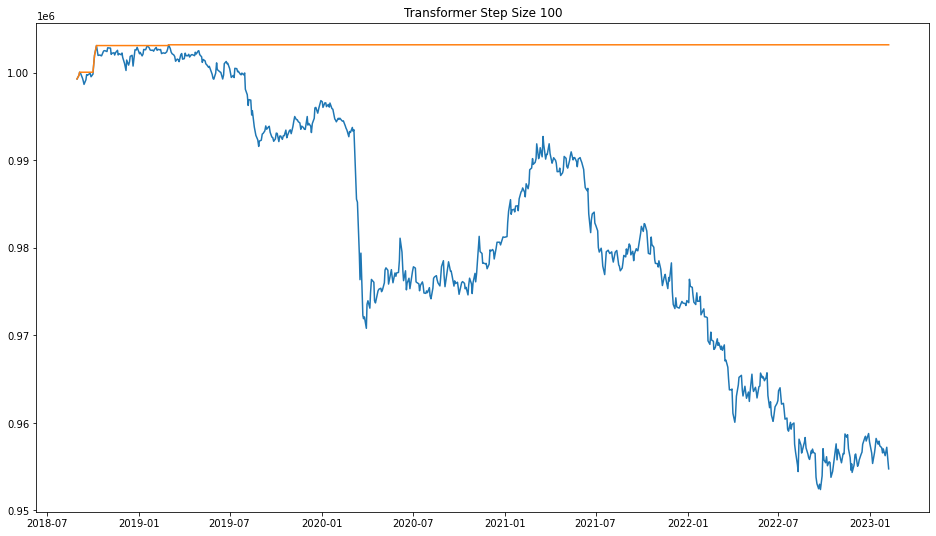

In [ ]:
# Get the baseline model. 
# If not using partial functions, uncomment this line:
# get_base_model(x_train, y_train, **TRANSFORMER_KWARGS)
base_m = partial_base_model()

x, y = run_stepped_inc(
    base_m, x_test, y_test, step_size=100, epochs=5, batch_size=64,
)
rets_agg["Transformer Step Size 100"], tf_rets100 = summ_and_plot(x, y, title="Transformer Step Size 100", idx=rets_idx)

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 50, 26)]     0           []                               
                                                                                                  
 layer_normalization_296 (Layer  (None, 50, 26)      52          ['input_38[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_148 (Mult  (None, 50, 26)      109594      ['layer_normalization_296[0][0]',
 iHeadAttention)                                                  'layer_normalization_296[0][0]']
                                                                                           

15/15 [==============================] - 13s 34ms/step - loss: 29268.2109
Epoch 2/200
15/15 [==============================] - ETA: 0s - loss: 16899.6855

15/15 [==============================] - 0s 30ms/step - loss: 16899.6855
Epoch 3/200
15/15 [==============================] - ETA: 0s - loss: 9542.0811

15/15 [==============================] - 0s 30ms/step - loss: 9542.0811
Epoch 4/200
15/15 [==============================] - ETA: 0s - loss: 5942.8047

15/15 [==============================] - 0s 29ms/step - loss: 5942.8047
Epoch 5/200
15/15 [==============================] - ETA: 0s - loss: 3229.7375

15/15 [==============================] - 0s 30ms/step - loss: 3229.7375
Epoch 6/200
15/15 [==============================] - ETA: 0s - loss: 2319.5044

15/15 [==============================] - 0s 32ms/step - loss: 2319.5044
Epoch 7/200
15/15 [==============================] - ETA: 0s - loss: 1879.3970

15/15 [==============================] - 0s 30ms/step - loss: 1879.3970
Epoch 8/200
15/15 [==============================] - ETA: 0s - loss: 1711.5793

15/15 [==============================] - 0s 30ms/step - loss: 1711.5793
Epoch 9/200
15/15 [==============================] - ETA: 0s - loss: 1561.5784

15/15 [==============================] - 0s 29ms/step - loss: 1561.5784
Epoch 10/200
15/15 [==============================] - ETA: 0s - loss: 1433.3169

15/15 [==============================] - 0s 28ms/step - loss: 1433.3169
Epoch 11/200
15/15 [==============================] - ETA: 0s - loss: 1484.6416

15/15 [==============================] - 0s 28ms/step - loss: 1484.6416
Epoch 12/200
15/15 [==============================] - ETA: 0s - loss: 1351.5188

15/15 [==============================] - 0s 28ms/step - loss: 1351.5188
Epoch 13/200
15/15 [==============================] - ETA: 0s - loss: 1421.7018

15/15 [==============================] - 0s 28ms/step - loss: 1421.7018
Epoch 14/200
15/15 [==============================] - ETA: 0s - loss: 1373.4081

15/15 [==============================] - 0s 28ms/step - loss: 1373.4081
Epoch 15/200
15/15 [==============================] - ETA: 0s - loss: 1265.2240

15/15 [==============================] - 0s 28ms/step - loss: 1265.2240
Epoch 16/200
15/15 [==============================] - ETA: 0s - loss: 1169.5662

15/15 [==============================] - 0s 28ms/step - loss: 1169.5662
Epoch 17/200
15/15 [==============================] - ETA: 0s - loss: 1186.5336

15/15 [==============================] - 0s 28ms/step - loss: 1186.5336
Epoch 18/200
15/15 [==============================] - ETA: 0s - loss: 1158.6918

15/15 [==============================] - 0s 28ms/step - loss: 1158.6918
Epoch 19/200
15/15 [==============================] - ETA: 0s - loss: 1011.2920

15/15 [==============================] - 0s 29ms/step - loss: 1011.2920
Epoch 20/200
15/15 [==============================] - ETA: 0s - loss: 1025.2878

15/15 [==============================] - 0s 28ms/step - loss: 1025.2878
Epoch 21/200
15/15 [==============================] - ETA: 0s - loss: 956.4047

15/15 [==============================] - 0s 27ms/step - loss: 956.4047
Epoch 22/200
15/15 [==============================] - ETA: 0s - loss: 864.4663

15/15 [==============================] - 0s 28ms/step - loss: 864.4663
Epoch 23/200
15/15 [==============================] - ETA: 0s - loss: 764.0419

15/15 [==============================] - 0s 27ms/step - loss: 764.0419
Epoch 24/200
15/15 [==============================] - ETA: 0s - loss: 783.7775

15/15 [==============================] - 0s 29ms/step - loss: 783.7775
Epoch 25/200
15/15 [==============================] - ETA: 0s - loss: 733.3665

15/15 [==============================] - 0s 29ms/step - loss: 733.3665
Epoch 26/200
15/15 [==============================] - ETA: 0s - loss: 690.8146

15/15 [==============================] - 0s 28ms/step - loss: 690.8146
Epoch 27/200
15/15 [==============================] - ETA: 0s - loss: 588.3199

15/15 [==============================] - 0s 28ms/step - loss: 588.3199
Epoch 28/200
15/15 [==============================] - ETA: 0s - loss: 589.0209

15/15 [==============================] - 0s 28ms/step - loss: 589.0209
Epoch 29/200
15/15 [==============================] - ETA: 0s - loss: 535.5421

15/15 [==============================] - 0s 29ms/step - loss: 535.5421
Epoch 30/200
15/15 [==============================] - ETA: 0s - loss: 455.5003

15/15 [==============================] - 0s 29ms/step - loss: 455.5003
Epoch 31/200
15/15 [==============================] - ETA: 0s - loss: 387.8806

15/15 [==============================] - 0s 28ms/step - loss: 387.8806
Epoch 32/200
15/15 [==============================] - ETA: 0s - loss: 383.4046

15/15 [==============================] - 0s 29ms/step - loss: 383.4046
Epoch 33/200
15/15 [==============================] - ETA: 0s - loss: 338.4278

15/15 [==============================] - 1s 33ms/step - loss: 338.4278
Epoch 34/200
15/15 [==============================] - ETA: 0s - loss: 274.8938

15/15 [==============================] - 0s 30ms/step - loss: 274.8938
Epoch 35/200
15/15 [==============================] - ETA: 0s - loss: 244.2822

15/15 [==============================] - 0s 31ms/step - loss: 244.2822
Epoch 36/200
15/15 [==============================] - ETA: 0s - loss: 203.2392

15/15 [==============================] - 0s 30ms/step - loss: 203.2392
Epoch 37/200
15/15 [==============================] - ETA: 0s - loss: 167.7179

15/15 [==============================] - 0s 31ms/step - loss: 167.7179
Epoch 38/200
15/15 [==============================] - ETA: 0s - loss: 150.7734

15/15 [==============================] - 0s 32ms/step - loss: 150.7734
Epoch 39/200
15/15 [==============================] - ETA: 0s - loss: 135.3991

15/15 [==============================] - 0s 31ms/step - loss: 135.3991
Epoch 40/200
15/15 [==============================] - ETA: 0s - loss: 108.8914

15/15 [==============================] - 0s 31ms/step - loss: 108.8914
Epoch 41/200
15/15 [==============================] - ETA: 0s - loss: 94.8393

15/15 [==============================] - 0s 29ms/step - loss: 94.8393
Epoch 42/200
15/15 [==============================] - ETA: 0s - loss: 83.3932

15/15 [==============================] - 0s 29ms/step - loss: 83.3932
Epoch 43/200
15/15 [==============================] - ETA: 0s - loss: 60.3087

15/15 [==============================] - 0s 28ms/step - loss: 60.3087
Epoch 44/200
15/15 [==============================] - ETA: 0s - loss: 54.5885

15/15 [==============================] - 0s 29ms/step - loss: 54.5885
Epoch 45/200
15/15 [==============================] - ETA: 0s - loss: 42.7230

15/15 [==============================] - 0s 29ms/step - loss: 42.7230
Epoch 46/200
15/15 [==============================] - ETA: 0s - loss: 40.7131

15/15 [==============================] - 0s 29ms/step - loss: 40.7131
Epoch 47/200
15/15 [==============================] - ETA: 0s - loss: 28.5548

15/15 [==============================] - 0s 29ms/step - loss: 28.5548
Epoch 48/200
15/15 [==============================] - ETA: 0s - loss: 28.3576

15/15 [==============================] - 0s 29ms/step - loss: 28.3576
Epoch 49/200
15/15 [==============================] - ETA: 0s - loss: 25.7741

15/15 [==============================] - 0s 29ms/step - loss: 25.7741
Epoch 50/200
15/15 [==============================] - ETA: 0s - loss: 24.3839

15/15 [==============================] - 0s 29ms/step - loss: 24.3839
Epoch 51/200
15/15 [==============================] - ETA: 0s - loss: 21.7353

15/15 [==============================] - 0s 29ms/step - loss: 21.7353
Epoch 52/200
15/15 [==============================] - ETA: 0s - loss: 18.6993

15/15 [==============================] - 0s 30ms/step - loss: 18.6993
Epoch 53/200
15/15 [==============================] - ETA: 0s - loss: 18.3133

15/15 [==============================] - 0s 29ms/step - loss: 18.3133
Epoch 54/200
15/15 [==============================] - ETA: 0s - loss: 17.5893

15/15 [==============================] - 0s 29ms/step - loss: 17.5893
Epoch 55/200
15/15 [==============================] - ETA: 0s - loss: 16.8367

15/15 [==============================] - 0s 29ms/step - loss: 16.8367
Epoch 56/200
15/15 [==============================] - ETA: 0s - loss: 14.6651

15/15 [==============================] - 0s 29ms/step - loss: 14.6651
Epoch 57/200
15/15 [==============================] - ETA: 0s - loss: 14.9969

15/15 [==============================] - 0s 30ms/step - loss: 14.9969
Epoch 58/200
15/15 [==============================] - ETA: 0s - loss: 15.4833

15/15 [==============================] - 0s 28ms/step - loss: 15.4833
Epoch 59/200
15/15 [==============================] - ETA: 0s - loss: 13.7540

15/15 [==============================] - 0s 28ms/step - loss: 13.7540
Epoch 60/200
15/15 [==============================] - ETA: 0s - loss: 14.2354

15/15 [==============================] - 0s 29ms/step - loss: 14.2354
Epoch 61/200
15/15 [==============================] - ETA: 0s - loss: 13.8947

15/15 [==============================] - 0s 29ms/step - loss: 13.8947
Epoch 62/200
15/15 [==============================] - ETA: 0s - loss: 14.0584

15/15 [==============================] - 0s 29ms/step - loss: 14.0584
Epoch 63/200
15/15 [==============================] - ETA: 0s - loss: 13.4377

15/15 [==============================] - 0s 31ms/step - loss: 13.4377
Epoch 64/200
15/15 [==============================] - ETA: 0s - loss: 13.0574

15/15 [==============================] - 0s 31ms/step - loss: 13.0574
Epoch 65/200
15/15 [==============================] - ETA: 0s - loss: 13.7325

15/15 [==============================] - 0s 31ms/step - loss: 13.7325
Epoch 66/200
15/15 [==============================] - ETA: 0s - loss: 12.2981

15/15 [==============================] - 0s 29ms/step - loss: 12.2981
Epoch 67/200
15/15 [==============================] - ETA: 0s - loss: 12.4440

15/15 [==============================] - 0s 30ms/step - loss: 12.4440
Epoch 68/200
15/15 [==============================] - ETA: 0s - loss: 12.7437

15/15 [==============================] - 0s 31ms/step - loss: 12.7437
Epoch 69/200
15/15 [==============================] - ETA: 0s - loss: 12.2167

15/15 [==============================] - 0s 31ms/step - loss: 12.2167
Epoch 70/200
15/15 [==============================] - ETA: 0s - loss: 11.7881

15/15 [==============================] - 0s 31ms/step - loss: 11.7881
Epoch 71/200
15/15 [==============================] - ETA: 0s - loss: 11.1825

15/15 [==============================] - 0s 29ms/step - loss: 11.1825
Epoch 72/200
15/15 [==============================] - ETA: 0s - loss: 11.2791

15/15 [==============================] - 0s 29ms/step - loss: 11.2791
Epoch 73/200
15/15 [==============================] - ETA: 0s - loss: 11.1972

15/15 [==============================] - 0s 29ms/step - loss: 11.1972
Epoch 74/200
15/15 [==============================] - ETA: 0s - loss: 10.6683

15/15 [==============================] - 0s 29ms/step - loss: 10.6683
Epoch 75/200
15/15 [==============================] - ETA: 0s - loss: 11.1560

15/15 [==============================] - 0s 29ms/step - loss: 11.1560
Epoch 76/200
15/15 [==============================] - ETA: 0s - loss: 10.0666

15/15 [==============================] - 0s 29ms/step - loss: 10.0666
Epoch 77/200
15/15 [==============================] - ETA: 0s - loss: 11.0063

15/15 [==============================] - 0s 28ms/step - loss: 11.0063
Epoch 78/200
15/15 [==============================] - ETA: 0s - loss: 10.2554

15/15 [==============================] - 0s 29ms/step - loss: 10.2554
Epoch 79/200
15/15 [==============================] - ETA: 0s - loss: 10.8987

15/15 [==============================] - 0s 29ms/step - loss: 10.8987
Epoch 80/200
15/15 [==============================] - ETA: 0s - loss: 11.2533

15/15 [==============================] - 0s 29ms/step - loss: 11.2533
Epoch 81/200
15/15 [==============================] - ETA: 0s - loss: 10.6607

15/15 [==============================] - 0s 29ms/step - loss: 10.6607
Epoch 82/200
15/15 [==============================] - ETA: 0s - loss: 10.1576

15/15 [==============================] - 0s 31ms/step - loss: 10.1576
Epoch 83/200
15/15 [==============================] - ETA: 0s - loss: 10.5113

15/15 [==============================] - 0s 29ms/step - loss: 10.5113
Epoch 84/200
15/15 [==============================] - ETA: 0s - loss: 9.8606

15/15 [==============================] - 0s 29ms/step - loss: 9.8606
Epoch 85/200
15/15 [==============================] - ETA: 0s - loss: 9.6765

15/15 [==============================] - 0s 29ms/step - loss: 9.6765
Epoch 86/200
15/15 [==============================] - ETA: 0s - loss: 9.3367

15/15 [==============================] - 0s 29ms/step - loss: 9.3367
Epoch 87/200
15/15 [==============================] - ETA: 0s - loss: 10.2700

15/15 [==============================] - 0s 29ms/step - loss: 10.2700
Epoch 88/200
15/15 [==============================] - ETA: 0s - loss: 9.0436

15/15 [==============================] - 0s 28ms/step - loss: 9.0436
Epoch 89/200
15/15 [==============================] - ETA: 0s - loss: 9.1629

15/15 [==============================] - 0s 29ms/step - loss: 9.1629
Epoch 90/200
15/15 [==============================] - ETA: 0s - loss: 9.9039

15/15 [==============================] - 0s 28ms/step - loss: 9.9039
Epoch 91/200
15/15 [==============================] - ETA: 0s - loss: 8.6750

15/15 [==============================] - 0s 29ms/step - loss: 8.6750
Epoch 92/200
15/15 [==============================] - ETA: 0s - loss: 10.0706

15/15 [==============================] - 0s 29ms/step - loss: 10.0706
Epoch 93/200
15/15 [==============================] - ETA: 0s - loss: 9.8926

15/15 [==============================] - 0s 30ms/step - loss: 9.8926
Epoch 94/200
15/15 [==============================] - ETA: 0s - loss: 10.1356

15/15 [==============================] - 0s 31ms/step - loss: 10.1356
Epoch 95/200
15/15 [==============================] - ETA: 0s - loss: 9.1991

15/15 [==============================] - 0s 32ms/step - loss: 9.1991
Epoch 96/200
15/15 [==============================] - ETA: 0s - loss: 9.2775

15/15 [==============================] - 0s 30ms/step - loss: 9.2775
Epoch 97/200
15/15 [==============================] - ETA: 0s - loss: 8.8605

15/15 [==============================] - 0s 31ms/step - loss: 8.8605
Epoch 98/200
15/15 [==============================] - ETA: 0s - loss: 8.9114

15/15 [==============================] - 0s 29ms/step - loss: 8.9114
Epoch 99/200
15/15 [==============================] - ETA: 0s - loss: 8.8252

15/15 [==============================] - 0s 33ms/step - loss: 8.8252
Epoch 100/200
15/15 [==============================] - ETA: 0s - loss: 8.3152

15/15 [==============================] - 0s 31ms/step - loss: 8.3152
Epoch 101/200
15/15 [==============================] - ETA: 0s - loss: 8.2545

15/15 [==============================] - 0s 32ms/step - loss: 8.2545
Epoch 102/200
15/15 [==============================] - ETA: 0s - loss: 8.1201

15/15 [==============================] - 0s 30ms/step - loss: 8.1201
Epoch 103/200
15/15 [==============================] - ETA: 0s - loss: 8.8339

15/15 [==============================] - 0s 29ms/step - loss: 8.8339
Epoch 104/200
15/15 [==============================] - ETA: 0s - loss: 8.5096

15/15 [==============================] - 0s 29ms/step - loss: 8.5096
Epoch 105/200
15/15 [==============================] - ETA: 0s - loss: 8.2991

15/15 [==============================] - 0s 29ms/step - loss: 8.2991
Epoch 106/200
15/15 [==============================] - ETA: 0s - loss: 8.9417

15/15 [==============================] - 0s 28ms/step - loss: 8.9417
Epoch 107/200
15/15 [==============================] - ETA: 0s - loss: 8.1680

15/15 [==============================] - 0s 29ms/step - loss: 8.1680
Epoch 108/200
15/15 [==============================] - ETA: 0s - loss: 9.1216

15/15 [==============================] - 0s 29ms/step - loss: 9.1216
Epoch 109/200
15/15 [==============================] - ETA: 0s - loss: 8.7060

15/15 [==============================] - 0s 29ms/step - loss: 8.7060
Epoch 110/200
15/15 [==============================] - ETA: 0s - loss: 8.7851

15/15 [==============================] - 0s 29ms/step - loss: 8.7851
Epoch 111/200
15/15 [==============================] - ETA: 0s - loss: 7.7201

15/15 [==============================] - 0s 29ms/step - loss: 7.7201
Epoch 112/200
15/15 [==============================] - ETA: 0s - loss: 7.8731

15/15 [==============================] - 0s 29ms/step - loss: 7.8731
Epoch 113/200
15/15 [==============================] - ETA: 0s - loss: 8.2447

15/15 [==============================] - 0s 29ms/step - loss: 8.2447
Epoch 114/200
15/15 [==============================] - ETA: 0s - loss: 8.3370

15/15 [==============================] - 0s 29ms/step - loss: 8.3370
Epoch 115/200
15/15 [==============================] - ETA: 0s - loss: 8.2346

15/15 [==============================] - 0s 28ms/step - loss: 8.2346
Epoch 116/200
15/15 [==============================] - ETA: 0s - loss: 7.9921

15/15 [==============================] - 0s 29ms/step - loss: 7.9921
Epoch 117/200
15/15 [==============================] - ETA: 0s - loss: 8.7979

15/15 [==============================] - 0s 28ms/step - loss: 8.7979
Epoch 118/200
15/15 [==============================] - ETA: 0s - loss: 7.9603

15/15 [==============================] - 0s 29ms/step - loss: 7.9603
Epoch 119/200
15/15 [==============================] - ETA: 0s - loss: 7.6060

15/15 [==============================] - 0s 29ms/step - loss: 7.6060
Epoch 120/200
15/15 [==============================] - ETA: 0s - loss: 7.6860

15/15 [==============================] - 0s 29ms/step - loss: 7.6860
Epoch 121/200
15/15 [==============================] - ETA: 0s - loss: 7.5635

15/15 [==============================] - 0s 29ms/step - loss: 7.5635
Epoch 122/200
15/15 [==============================] - ETA: 0s - loss: 7.6732

15/15 [==============================] - 0s 29ms/step - loss: 7.6732
Epoch 123/200
15/15 [==============================] - ETA: 0s - loss: 7.7437

15/15 [==============================] - 0s 30ms/step - loss: 7.7437
Epoch 124/200
15/15 [==============================] - ETA: 0s - loss: 7.4870

15/15 [==============================] - 0s 29ms/step - loss: 7.4870
Epoch 125/200
15/15 [==============================] - ETA: 0s - loss: 7.4683

15/15 [==============================] - 0s 33ms/step - loss: 7.4683
Epoch 126/200
15/15 [==============================] - ETA: 0s - loss: 8.2232

15/15 [==============================] - 0s 29ms/step - loss: 8.2232
Epoch 127/200
15/15 [==============================] - ETA: 0s - loss: 8.2429

15/15 [==============================] - 0s 30ms/step - loss: 8.2429
Epoch 128/200
15/15 [==============================] - ETA: 0s - loss: 8.1769

15/15 [==============================] - 0s 31ms/step - loss: 8.1769
Epoch 129/200
15/15 [==============================] - ETA: 0s - loss: 7.0219

15/15 [==============================] - 0s 30ms/step - loss: 7.0219
Epoch 130/200
15/15 [==============================] - ETA: 0s - loss: 8.2366

15/15 [==============================] - 0s 33ms/step - loss: 8.2366
Epoch 131/200
15/15 [==============================] - ETA: 0s - loss: 6.9034

15/15 [==============================] - 0s 30ms/step - loss: 6.9034
Epoch 132/200
15/15 [==============================] - ETA: 0s - loss: 7.2856

15/15 [==============================] - 0s 32ms/step - loss: 7.2856
Epoch 133/200
15/15 [==============================] - ETA: 0s - loss: 7.2933

15/15 [==============================] - 0s 29ms/step - loss: 7.2933
Epoch 134/200
15/15 [==============================] - ETA: 0s - loss: 6.9801

15/15 [==============================] - 0s 29ms/step - loss: 6.9801
Epoch 135/200
15/15 [==============================] - ETA: 0s - loss: 7.6411

15/15 [==============================] - 0s 29ms/step - loss: 7.6411
Epoch 136/200
15/15 [==============================] - ETA: 0s - loss: 7.6184

15/15 [==============================] - 0s 29ms/step - loss: 7.6184
Epoch 137/200
15/15 [==============================] - ETA: 0s - loss: 7.4768

15/15 [==============================] - 0s 30ms/step - loss: 7.4768
Epoch 138/200
15/15 [==============================] - ETA: 0s - loss: 7.6133

15/15 [==============================] - 0s 28ms/step - loss: 7.6133
Epoch 139/200
15/15 [==============================] - ETA: 0s - loss: 7.2754

15/15 [==============================] - 0s 30ms/step - loss: 7.2754
Epoch 140/200
15/15 [==============================] - ETA: 0s - loss: 7.1859

15/15 [==============================] - 0s 29ms/step - loss: 7.1859
Epoch 141/200
15/15 [==============================] - ETA: 0s - loss: 7.0823

15/15 [==============================] - 0s 29ms/step - loss: 7.0823
Epoch 142/200
15/15 [==============================] - ETA: 0s - loss: 7.7334

15/15 [==============================] - 0s 29ms/step - loss: 7.7334
Epoch 143/200
15/15 [==============================] - ETA: 0s - loss: 7.6670

15/15 [==============================] - 0s 30ms/step - loss: 7.6670
Epoch 144/200
15/15 [==============================] - ETA: 0s - loss: 7.5306

15/15 [==============================] - 0s 28ms/step - loss: 7.5306
Epoch 145/200
15/15 [==============================] - ETA: 0s - loss: 7.0358

15/15 [==============================] - 0s 29ms/step - loss: 7.0358
Epoch 146/200
15/15 [==============================] - ETA: 0s - loss: 6.9914

15/15 [==============================] - 0s 30ms/step - loss: 6.9914
Epoch 147/200
15/15 [==============================] - ETA: 0s - loss: 7.2636

15/15 [==============================] - 0s 29ms/step - loss: 7.2636
Epoch 148/200
15/15 [==============================] - ETA: 0s - loss: 7.1799

15/15 [==============================] - 0s 29ms/step - loss: 7.1799
Epoch 149/200
15/15 [==============================] - ETA: 0s - loss: 7.7897

15/15 [==============================] - 0s 29ms/step - loss: 7.7897
Epoch 150/200
15/15 [==============================] - ETA: 0s - loss: 6.4415

15/15 [==============================] - 0s 29ms/step - loss: 6.4415
Epoch 151/200
15/15 [==============================] - ETA: 0s - loss: 7.4741

15/15 [==============================] - 0s 29ms/step - loss: 7.4741
Epoch 152/200
15/15 [==============================] - ETA: 0s - loss: 7.1116

15/15 [==============================] - 0s 29ms/step - loss: 7.1116
Epoch 153/200
15/15 [==============================] - ETA: 0s - loss: 6.6789

15/15 [==============================] - 0s 29ms/step - loss: 6.6789
Epoch 154/200
15/15 [==============================] - ETA: 0s - loss: 6.6409

15/15 [==============================] - 0s 29ms/step - loss: 6.6409
Epoch 155/200
15/15 [==============================] - ETA: 0s - loss: 7.2009

15/15 [==============================] - 0s 29ms/step - loss: 7.2009
Epoch 156/200
15/15 [==============================] - ETA: 0s - loss: 6.5608

15/15 [==============================] - 0s 30ms/step - loss: 6.5608
Epoch 157/200
15/15 [==============================] - ETA: 0s - loss: 6.7029

15/15 [==============================] - 0s 29ms/step - loss: 6.7029
Epoch 158/200
15/15 [==============================] - ETA: 0s - loss: 6.5883

15/15 [==============================] - 0s 29ms/step - loss: 6.5883
Epoch 159/200
15/15 [==============================] - ETA: 0s - loss: 7.0657

15/15 [==============================] - 0s 30ms/step - loss: 7.0657
Epoch 160/200
15/15 [==============================] - ETA: 0s - loss: 6.9322

15/15 [==============================] - 0s 30ms/step - loss: 6.9322
Epoch 161/200
15/15 [==============================] - ETA: 0s - loss: 6.7018

15/15 [==============================] - 0s 30ms/step - loss: 6.7018
Epoch 162/200
15/15 [==============================] - ETA: 0s - loss: 6.3724

15/15 [==============================] - 0s 29ms/step - loss: 6.3724
Epoch 163/200
15/15 [==============================] - ETA: 0s - loss: 6.3536

15/15 [==============================] - 0s 29ms/step - loss: 6.3536
Epoch 164/200
15/15 [==============================] - ETA: 0s - loss: 6.9777

15/15 [==============================] - 0s 30ms/step - loss: 6.9777
Epoch 165/200
15/15 [==============================] - ETA: 0s - loss: 6.6461

15/15 [==============================] - 0s 29ms/step - loss: 6.6461
Epoch 166/200
15/15 [==============================] - ETA: 0s - loss: 5.9382

15/15 [==============================] - 0s 29ms/step - loss: 5.9382
Epoch 167/200
15/15 [==============================] - ETA: 0s - loss: 6.1126

15/15 [==============================] - 0s 29ms/step - loss: 6.1126
Epoch 168/200
15/15 [==============================] - ETA: 0s - loss: 6.0828

15/15 [==============================] - 0s 30ms/step - loss: 6.0828
Epoch 169/200
15/15 [==============================] - ETA: 0s - loss: 5.7343

15/15 [==============================] - 0s 29ms/step - loss: 5.7343
Epoch 170/200
15/15 [==============================] - ETA: 0s - loss: 6.1155

15/15 [==============================] - 0s 29ms/step - loss: 6.1155
Epoch 171/200
15/15 [==============================] - ETA: 0s - loss: 6.1333

15/15 [==============================] - 0s 30ms/step - loss: 6.1333
Epoch 172/200
15/15 [==============================] - ETA: 0s - loss: 6.4819

15/15 [==============================] - 0s 29ms/step - loss: 6.4819
Epoch 173/200
15/15 [==============================] - ETA: 0s - loss: 5.7485

15/15 [==============================] - 0s 29ms/step - loss: 5.7485
Epoch 174/200
15/15 [==============================] - ETA: 0s - loss: 5.9929

15/15 [==============================] - 0s 29ms/step - loss: 5.9929
Epoch 175/200
15/15 [==============================] - ETA: 0s - loss: 5.7072

15/15 [==============================] - 0s 29ms/step - loss: 5.7072
Epoch 176/200
15/15 [==============================] - ETA: 0s - loss: 6.4501

15/15 [==============================] - 0s 29ms/step - loss: 6.4501
Epoch 177/200
15/15 [==============================] - ETA: 0s - loss: 6.2340

15/15 [==============================] - 0s 29ms/step - loss: 6.2340
Epoch 178/200
15/15 [==============================] - ETA: 0s - loss: 5.6268

15/15 [==============================] - 0s 29ms/step - loss: 5.6268
Epoch 179/200
15/15 [==============================] - ETA: 0s - loss: 5.9319

15/15 [==============================] - 0s 29ms/step - loss: 5.9319
Epoch 180/200
15/15 [==============================] - ETA: 0s - loss: 5.7760

15/15 [==============================] - 0s 29ms/step - loss: 5.7760
Epoch 181/200
15/15 [==============================] - ETA: 0s - loss: 6.0212

15/15 [==============================] - 0s 29ms/step - loss: 6.0212
Epoch 182/200
15/15 [==============================] - ETA: 0s - loss: 6.2196

15/15 [==============================] - 0s 29ms/step - loss: 6.2196
Epoch 183/200
15/15 [==============================] - ETA: 0s - loss: 6.0931

15/15 [==============================] - 0s 28ms/step - loss: 6.0931
Epoch 184/200
15/15 [==============================] - ETA: 0s - loss: 6.3725

15/15 [==============================] - 0s 29ms/step - loss: 6.3725
Epoch 185/200
15/15 [==============================] - ETA: 0s - loss: 5.7835

15/15 [==============================] - 0s 29ms/step - loss: 5.7835
Epoch 186/200
15/15 [==============================] - ETA: 0s - loss: 5.7143

15/15 [==============================] - 0s 29ms/step - loss: 5.7143
Epoch 187/200
15/15 [==============================] - ETA: 0s - loss: 5.3298

15/15 [==============================] - 0s 31ms/step - loss: 5.3298
Epoch 188/200
15/15 [==============================] - ETA: 0s - loss: 5.7318

15/15 [==============================] - 0s 31ms/step - loss: 5.7318
Epoch 189/200
15/15 [==============================] - ETA: 0s - loss: 6.2858

15/15 [==============================] - 0s 30ms/step - loss: 6.2858
Epoch 190/200
15/15 [==============================] - ETA: 0s - loss: 5.6738

15/15 [==============================] - 0s 30ms/step - loss: 5.6738
Epoch 191/200
15/15 [==============================] - ETA: 0s - loss: 5.2158

15/15 [==============================] - 0s 31ms/step - loss: 5.2158
Epoch 192/200
15/15 [==============================] - ETA: 0s - loss: 5.5352

15/15 [==============================] - 0s 31ms/step - loss: 5.5352
Epoch 193/200
15/15 [==============================] - ETA: 0s - loss: 5.6746

15/15 [==============================] - 0s 32ms/step - loss: 5.6746
Epoch 194/200
15/15 [==============================] - ETA: 0s - loss: 5.1732

15/15 [==============================] - 0s 30ms/step - loss: 5.1732
Epoch 195/200
15/15 [==============================] - ETA: 0s - loss: 4.7468

15/15 [==============================] - 0s 32ms/step - loss: 4.7468
Epoch 196/200
15/15 [==============================] - ETA: 0s - loss: 5.4424

15/15 [==============================] - 0s 30ms/step - loss: 5.4424
Epoch 197/200
15/15 [==============================] - ETA: 0s - loss: 5.4699

15/15 [==============================] - 0s 29ms/step - loss: 5.4699
Epoch 198/200
15/15 [==============================] - ETA: 0s - loss: 5.2428

15/15 [==============================] - 0s 29ms/step - loss: 5.2428
Epoch 199/200
15/15 [==============================] - ETA: 0s - loss: 5.3234

15/15 [==============================] - 0s 29ms/step - loss: 5.3234
Epoch 200/200
15/15 [==============================] - ETA: 0s - loss: 4.9165

15/15 [==============================] - 0s 29ms/step - loss: 4.9165


  0%|          | 0/14 [00:00<?, ?it/s]

16/16 [==============================] - 0s 6ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 5.6067

8/8 [==============================] - 0s 29ms/step - loss: 5.6783
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 5.0350

8/8 [==============================] - 0s 29ms/step - loss: 4.8755
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 5.1754

8/8 [==============================] - 0s 30ms/step - loss: 5.1906
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 5.3396

8/8 [==============================] - 0s 28ms/step - loss: 5.4277
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 5.2388

8/8 [==============================] - 0s 28ms/step - loss: 5.0795
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 5.4671

8/8 [==============================] - 0s 29ms/step - loss: 5.5485
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5221

8/8 [==============================] - 0s 31ms/step - loss: 4.4956
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5861

8/8 [==============================] - 0s 29ms/step - loss: 4.5210
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 5.2767

8/8 [==============================] - 0s 28ms/step - loss: 5.4271
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 5.5952

8/8 [==============================] - 0s 28ms/step - loss: 5.4812


  7%|▋         | 1/14 [00:03<00:41,  3.16s/it]

16/16 [==============================] - 0s 6ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 5.4698

8/8 [==============================] - 0s 29ms/step - loss: 5.3160
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 4.7344

8/8 [==============================] - 0s 30ms/step - loss: 4.8784
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 5.1280

8/8 [==============================] - 0s 29ms/step - loss: 4.9284
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 4.4524

8/8 [==============================] - 0s 29ms/step - loss: 4.6017
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 4.8544

8/8 [==============================] - 0s 30ms/step - loss: 4.8668
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 4.9173

8/8 [==============================] - 0s 29ms/step - loss: 4.9621
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5507

8/8 [==============================] - 0s 29ms/step - loss: 4.4984
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 5.3679

8/8 [==============================] - 0s 29ms/step - loss: 5.1468
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 5.2884

8/8 [==============================] - 0s 30ms/step - loss: 5.1134
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 5.0238

8/8 [==============================] - 0s 29ms/step - loss: 5.0821


 14%|█▍        | 2/14 [00:05<00:35,  2.95s/it]

16/16 [==============================] - 0s 6ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2413

8/8 [==============================] - 0s 29ms/step - loss: 4.3655
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 4.8878

8/8 [==============================] - 0s 30ms/step - loss: 4.8268
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 4.9645

8/8 [==============================] - 0s 28ms/step - loss: 4.9333
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2091

8/8 [==============================] - 0s 29ms/step - loss: 4.3006
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5260

8/8 [==============================] - 0s 28ms/step - loss: 4.5343
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5890

8/8 [==============================] - 0s 29ms/step - loss: 4.5011
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 4.8270

8/8 [==============================] - 0s 31ms/step - loss: 4.8127
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 4.7876

8/8 [==============================] - 0s 31ms/step - loss: 4.7939
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5541

8/8 [==============================] - 0s 29ms/step - loss: 4.5569
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 5.1517

8/8 [==============================] - 0s 30ms/step - loss: 5.1318


 21%|██▏       | 3/14 [00:08<00:31,  2.82s/it]

16/16 [==============================] - 0s 7ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 4.7400

8/8 [==============================] - 0s 31ms/step - loss: 4.7008
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 4.4662

8/8 [==============================] - 0s 30ms/step - loss: 4.5161
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1131

8/8 [==============================] - 0s 29ms/step - loss: 4.1958
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 4.0652

8/8 [==============================] - 0s 30ms/step - loss: 4.0629
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 5.0442

8/8 [==============================] - 0s 30ms/step - loss: 5.1284
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2692

8/8 [==============================] - 0s 31ms/step - loss: 4.2881
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 3.9704

8/8 [==============================] - 0s 33ms/step - loss: 3.8651
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2278

8/8 [==============================] - 0s 33ms/step - loss: 4.3845
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 4.7964

8/8 [==============================] - 0s 29ms/step - loss: 4.8036
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 4.0941

8/8 [==============================] - 0s 30ms/step - loss: 4.2009


 29%|██▊       | 4/14 [00:11<00:28,  2.81s/it]

16/16 [==============================] - 0s 6ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.9475

8/8 [==============================] - 0s 32ms/step - loss: 3.9009
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1047

8/8 [==============================] - 0s 29ms/step - loss: 4.1627
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 4.4784

8/8 [==============================] - 0s 29ms/step - loss: 4.3014
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5792

8/8 [==============================] - 0s 29ms/step - loss: 4.5982
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 3.8667

8/8 [==============================] - 0s 28ms/step - loss: 3.8628
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 4.4708

8/8 [==============================] - 0s 30ms/step - loss: 4.3661
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6812

8/8 [==============================] - 0s 29ms/step - loss: 3.7491
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1674

8/8 [==============================] - 0s 29ms/step - loss: 4.2645
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5135

8/8 [==============================] - 0s 31ms/step - loss: 4.4283
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1622

8/8 [==============================] - 0s 28ms/step - loss: 4.0212


 36%|███▌      | 5/14 [00:14<00:25,  2.79s/it]

16/16 [==============================] - 0s 6ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 4.0195

8/8 [==============================] - 0s 29ms/step - loss: 4.1054
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5126

8/8 [==============================] - 0s 30ms/step - loss: 4.4642
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 3.8668

8/8 [==============================] - 0s 28ms/step - loss: 3.9594
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5592

8/8 [==============================] - 0s 28ms/step - loss: 3.6728
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 3.8370

8/8 [==============================] - 0s 29ms/step - loss: 3.8869
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5773

8/8 [==============================] - 0s 29ms/step - loss: 3.6056
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2546

8/8 [==============================] - 0s 30ms/step - loss: 4.1992
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1715

8/8 [==============================] - 0s 29ms/step - loss: 4.0732
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 4.0974

8/8 [==============================] - 0s 28ms/step - loss: 4.0650
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 3.7604

8/8 [==============================] - 0s 30ms/step - loss: 3.7762


 43%|████▎     | 6/14 [00:16<00:22,  2.79s/it]

16/16 [==============================] - 0s 6ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.7264

8/8 [==============================] - 0s 29ms/step - loss: 3.7776
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1133

8/8 [==============================] - 0s 29ms/step - loss: 4.1648
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 4.0916

8/8 [==============================] - 0s 29ms/step - loss: 4.1041
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 3.1398

8/8 [==============================] - 0s 30ms/step - loss: 3.2004
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5944

8/8 [==============================] - 0s 30ms/step - loss: 3.7604
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 3.7284

8/8 [==============================] - 0s 29ms/step - loss: 3.8826
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 3.8414

8/8 [==============================] - 0s 30ms/step - loss: 3.7848
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4261

8/8 [==============================] - 0s 29ms/step - loss: 3.4762
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 3.9413

8/8 [==============================] - 0s 30ms/step - loss: 3.8866
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 3.3637

8/8 [==============================] - 0s 29ms/step - loss: 3.4872


 50%|█████     | 7/14 [00:19<00:19,  2.79s/it]

16/16 [==============================] - 0s 6ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5919

8/8 [==============================] - 0s 31ms/step - loss: 3.6558
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6750

8/8 [==============================] - 0s 31ms/step - loss: 3.6003
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5993

8/8 [==============================] - 0s 29ms/step - loss: 3.4743
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6968

8/8 [==============================] - 0s 28ms/step - loss: 3.6890
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2466

8/8 [==============================] - 0s 30ms/step - loss: 4.1440
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2177

8/8 [==============================] - 0s 30ms/step - loss: 4.1013
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6139

8/8 [==============================] - 0s 28ms/step - loss: 3.6205
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 3.7392

8/8 [==============================] - 0s 31ms/step - loss: 3.8555
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6266

8/8 [==============================] - 0s 34ms/step - loss: 3.7277
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6426

8/8 [==============================] - 0s 33ms/step - loss: 3.5776


 57%|█████▋    | 8/14 [00:22<00:16,  2.80s/it]

16/16 [==============================] - 0s 8ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.9038

8/8 [==============================] - 0s 30ms/step - loss: 3.8329
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 3.7755

8/8 [==============================] - 0s 31ms/step - loss: 3.7754
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5799

8/8 [==============================] - 0s 36ms/step - loss: 3.5483
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 3.7766

8/8 [==============================] - 0s 33ms/step - loss: 3.7246
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 3.3183

8/8 [==============================] - 0s 34ms/step - loss: 3.3211
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4023

8/8 [==============================] - 0s 31ms/step - loss: 3.4381
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4116

8/8 [==============================] - 0s 31ms/step - loss: 3.2690
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 3.3675

8/8 [==============================] - 0s 30ms/step - loss: 3.3281
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 3.9571

8/8 [==============================] - 0s 32ms/step - loss: 3.9259
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 3.3268

8/8 [==============================] - 0s 33ms/step - loss: 3.3632


 64%|██████▍   | 9/14 [00:25<00:14,  2.90s/it]

16/16 [==============================] - 0s 6ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6255

8/8 [==============================] - 0s 29ms/step - loss: 3.6080
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 3.2157

8/8 [==============================] - 0s 29ms/step - loss: 3.1833
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 3.7288

8/8 [==============================] - 0s 31ms/step - loss: 3.6911
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4580

8/8 [==============================] - 0s 30ms/step - loss: 3.4469
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 3.2347

8/8 [==============================] - 0s 30ms/step - loss: 3.3375
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5776

8/8 [==============================] - 0s 30ms/step - loss: 3.6695
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6111

8/8 [==============================] - 0s 31ms/step - loss: 3.5286
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4920

8/8 [==============================] - 0s 35ms/step - loss: 3.4021
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4340

8/8 [==============================] - 0s 31ms/step - loss: 3.3069
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5062

8/8 [==============================] - 0s 32ms/step - loss: 3.4785


 71%|███████▏  | 10/14 [00:28<00:11,  2.88s/it]

16/16 [==============================] - 0s 6ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.2830

8/8 [==============================] - 0s 30ms/step - loss: 3.3692
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 3.1227

8/8 [==============================] - 0s 33ms/step - loss: 3.1650
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4205

8/8 [==============================] - 0s 33ms/step - loss: 3.2915
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 3.0290

8/8 [==============================] - 0s 30ms/step - loss: 2.9863
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5381

8/8 [==============================] - 0s 31ms/step - loss: 3.6418
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4890

8/8 [==============================] - 0s 32ms/step - loss: 3.4676
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4753

8/8 [==============================] - 0s 32ms/step - loss: 3.5013
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 2.9409

8/8 [==============================] - 0s 33ms/step - loss: 2.9008
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6806

8/8 [==============================] - 0s 31ms/step - loss: 3.6458
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 3.2531

8/8 [==============================] - 0s 32ms/step - loss: 3.1716


 79%|███████▊  | 11/14 [00:33<00:10,  3.67s/it]

16/16 [==============================] - 0s 8ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4112

8/8 [==============================] - 0s 35ms/step - loss: 3.2558
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 3.2580

8/8 [==============================] - 0s 29ms/step - loss: 3.3219
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 3.2336

8/8 [==============================] - 0s 29ms/step - loss: 3.1465
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 3.0997

8/8 [==============================] - 0s 30ms/step - loss: 3.1417
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 3.0376

8/8 [==============================] - 0s 30ms/step - loss: 2.9619
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 3.0183

8/8 [==============================] - 0s 29ms/step - loss: 2.9798
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 3.2225

8/8 [==============================] - 0s 32ms/step - loss: 3.1115
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 3.1614

8/8 [==============================] - 0s 32ms/step - loss: 3.1917
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4000

8/8 [==============================] - 0s 31ms/step - loss: 3.2674
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 3.1344

8/8 [==============================] - 0s 31ms/step - loss: 3.0206


 86%|████████▌ | 12/14 [00:36<00:06,  3.40s/it]

16/16 [==============================] - 0s 7ms/step
500
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.1950

8/8 [==============================] - 0s 31ms/step - loss: 3.2196
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 3.1171

8/8 [==============================] - 0s 32ms/step - loss: 3.1546
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 3.1398

8/8 [==============================] - 0s 30ms/step - loss: 3.0201
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 3.0873

8/8 [==============================] - 0s 32ms/step - loss: 3.1299
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 3.2094

8/8 [==============================] - 0s 30ms/step - loss: 3.1435
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5929

8/8 [==============================] - 0s 29ms/step - loss: 3.6577
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 2.9805

8/8 [==============================] - 0s 31ms/step - loss: 3.0604
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 3.0543

8/8 [==============================] - 0s 32ms/step - loss: 2.9602
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 3.2856

8/8 [==============================] - 0s 31ms/step - loss: 3.4259
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 2.7652

8/8 [==============================] - 0s 29ms/step - loss: 2.8775


 93%|█████████▎| 13/14 [00:39<00:03,  3.24s/it]

13/13 [==============================] - 0s 9ms/step
410
Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 3.0015

7/7 [==============================] - 0s 36ms/step - loss: 3.0015
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 3.1215

7/7 [==============================] - 0s 30ms/step - loss: 3.1215
Epoch 3/10
5/7 [====================>.........] - ETA: 0s - loss: 3.4737

7/7 [==============================] - 0s 28ms/step - loss: 3.2744
Epoch 4/10
7/7 [==============================] - ETA: 0s - loss: 2.9233

7/7 [==============================] - 0s 29ms/step - loss: 2.9233
Epoch 5/10
7/7 [==============================] - ETA: 0s - loss: 3.4134

7/7 [==============================] - 0s 30ms/step - loss: 3.4134
Epoch 6/10
7/7 [==============================] - ETA: 0s - loss: 2.8597

7/7 [==============================] - 0s 30ms/step - loss: 2.8597
Epoch 7/10
5/7 [====================>.........] - ETA: 0s - loss: 3.1052

7/7 [==============================] - 0s 28ms/step - loss: 3.1182
Epoch 8/10
7/7 [==============================] - ETA: 0s - loss: 2.9019

7/7 [==============================] - 0s 30ms/step - loss: 2.9019
Epoch 9/10
5/7 [====================>.........] - ETA: 0s - loss: 2.9393

7/7 [==============================] - 0s 28ms/step - loss: 3.0054
Epoch 10/10
5/7 [====================>.........] - ETA: 0s - loss: 2.6997

7/7 [==============================] - 0s 28ms/step - loss: 2.8014


100%|██████████| 14/14 [00:42<00:00,  3.04s/it]


,Transformer Step Size 500
Annualized Return,0.007873
Annualized Volatility,0.015717
Annualized Sharpe Ratio,0.500914
Annualized Sortino Ratio,0.699582
Skewness,0.287507
Kurtosis,9.247760
VaR (0.05),-0.001436
CVaR (0.05),-0.002187
Min,-0.006644
Max,0.007126


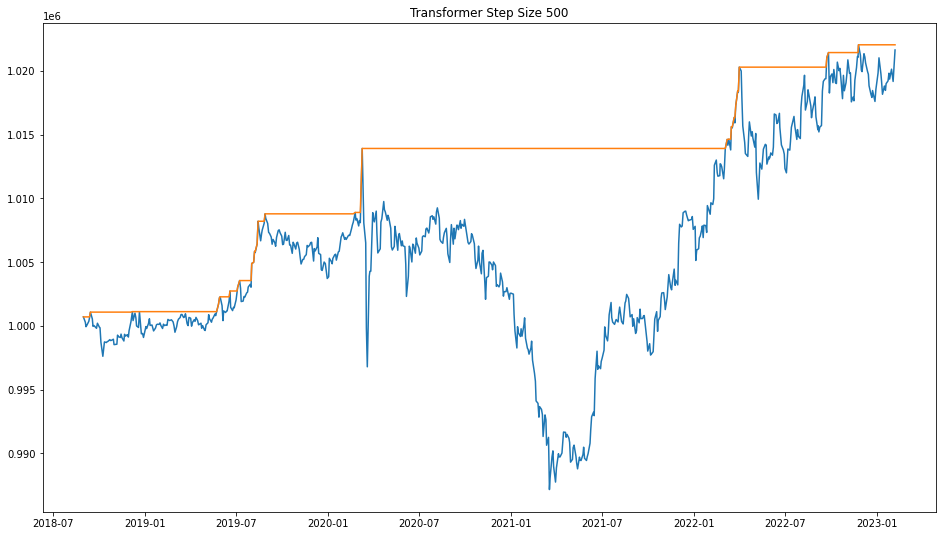

In [ ]:
# Get the baseline model. 
# If not using partial functions, uncomment this line:
# get_base_model(x_train, y_train, **TRANSFORMER_KWARGS)
base_m = partial_base_model()

x, y = run_stepped_inc(
    base_m, x_test, y_test, step_size=500, epochs=10, batch_size=64,
)
rets_agg["Transformer Step Size 500"], tf_rets500 = summ_and_plot(x, y, title="Transformer Step Size 500", idx=rets_idx)

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 50, 26)]     0           []                               
                                                                                                  
 layer_normalization_304 (Layer  (None, 50, 26)      52          ['input_39[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_152 (Mult  (None, 50, 26)      109594      ['layer_normalization_304[0][0]',
 iHeadAttention)                                                  'layer_normalization_304[0][0]']
                                                                                           

15/15 [==============================] - 13s 33ms/step - loss: 7364.2002
Epoch 2/200
15/15 [==============================] - ETA: 0s - loss: 3397.1365

15/15 [==============================] - 0s 28ms/step - loss: 3397.1365
Epoch 3/200
15/15 [==============================] - ETA: 0s - loss: 1703.3783

15/15 [==============================] - 0s 28ms/step - loss: 1703.3783
Epoch 4/200
15/15 [==============================] - ETA: 0s - loss: 1510.8884

15/15 [==============================] - 0s 29ms/step - loss: 1510.8884
Epoch 5/200
15/15 [==============================] - ETA: 0s - loss: 1359.4058

15/15 [==============================] - 0s 27ms/step - loss: 1359.4058
Epoch 6/200
15/15 [==============================] - ETA: 0s - loss: 1305.5519

15/15 [==============================] - 0s 28ms/step - loss: 1305.5519
Epoch 7/200
15/15 [==============================] - ETA: 0s - loss: 1173.9788

15/15 [==============================] - 0s 28ms/step - loss: 1173.9788
Epoch 8/200
15/15 [==============================] - ETA: 0s - loss: 1121.8687

15/15 [==============================] - 0s 28ms/step - loss: 1121.8687
Epoch 9/200
15/15 [==============================] - ETA: 0s - loss: 1115.9211

15/15 [==============================] - 0s 28ms/step - loss: 1115.9211
Epoch 10/200
15/15 [==============================] - ETA: 0s - loss: 973.3065

15/15 [==============================] - 0s 29ms/step - loss: 973.3065
Epoch 11/200
15/15 [==============================] - ETA: 0s - loss: 913.7767

15/15 [==============================] - 0s 28ms/step - loss: 913.7767
Epoch 12/200
15/15 [==============================] - ETA: 0s - loss: 848.7675

15/15 [==============================] - 0s 28ms/step - loss: 848.7675
Epoch 13/200
15/15 [==============================] - ETA: 0s - loss: 803.1354

15/15 [==============================] - 0s 29ms/step - loss: 803.1354
Epoch 14/200
15/15 [==============================] - ETA: 0s - loss: 726.6362

15/15 [==============================] - 0s 28ms/step - loss: 726.6362
Epoch 15/200
15/15 [==============================] - ETA: 0s - loss: 641.0675

15/15 [==============================] - 0s 28ms/step - loss: 641.0675
Epoch 16/200
15/15 [==============================] - ETA: 0s - loss: 527.6082

15/15 [==============================] - 0s 29ms/step - loss: 527.6082
Epoch 17/200
15/15 [==============================] - ETA: 0s - loss: 450.0322

15/15 [==============================] - 0s 28ms/step - loss: 450.0322
Epoch 18/200
15/15 [==============================] - ETA: 0s - loss: 431.0991

15/15 [==============================] - 0s 28ms/step - loss: 431.0991
Epoch 19/200
15/15 [==============================] - ETA: 0s - loss: 349.8642

15/15 [==============================] - 0s 30ms/step - loss: 349.8642
Epoch 20/200
15/15 [==============================] - ETA: 0s - loss: 293.3461

15/15 [==============================] - 0s 32ms/step - loss: 293.3461
Epoch 21/200
15/15 [==============================] - ETA: 0s - loss: 255.6693

15/15 [==============================] - 0s 31ms/step - loss: 255.6693
Epoch 22/200
15/15 [==============================] - ETA: 0s - loss: 208.9829

15/15 [==============================] - 0s 30ms/step - loss: 208.9829
Epoch 23/200
15/15 [==============================] - ETA: 0s - loss: 168.2604

15/15 [==============================] - 0s 31ms/step - loss: 168.2604
Epoch 24/200
15/15 [==============================] - ETA: 0s - loss: 145.5303

15/15 [==============================] - 0s 30ms/step - loss: 145.5303
Epoch 25/200
15/15 [==============================] - ETA: 0s - loss: 112.4927

15/15 [==============================] - 0s 30ms/step - loss: 112.4927
Epoch 26/200
15/15 [==============================] - ETA: 0s - loss: 90.4237

15/15 [==============================] - 0s 30ms/step - loss: 90.4237
Epoch 27/200
15/15 [==============================] - ETA: 0s - loss: 71.1806

15/15 [==============================] - 0s 30ms/step - loss: 71.1806
Epoch 28/200
15/15 [==============================] - ETA: 0s - loss: 50.2249

15/15 [==============================] - 0s 28ms/step - loss: 50.2249
Epoch 29/200
15/15 [==============================] - ETA: 0s - loss: 47.0086

15/15 [==============================] - 0s 28ms/step - loss: 47.0086
Epoch 30/200
15/15 [==============================] - ETA: 0s - loss: 33.8482

15/15 [==============================] - 0s 28ms/step - loss: 33.8482
Epoch 31/200
15/15 [==============================] - ETA: 0s - loss: 26.4008

15/15 [==============================] - 0s 29ms/step - loss: 26.4008
Epoch 32/200
15/15 [==============================] - ETA: 0s - loss: 22.3691

15/15 [==============================] - 0s 29ms/step - loss: 22.3691
Epoch 33/200
15/15 [==============================] - ETA: 0s - loss: 19.5726

15/15 [==============================] - 0s 29ms/step - loss: 19.5726
Epoch 34/200
15/15 [==============================] - ETA: 0s - loss: 17.5409

15/15 [==============================] - 0s 28ms/step - loss: 17.5409
Epoch 35/200
15/15 [==============================] - ETA: 0s - loss: 14.2365

15/15 [==============================] - 0s 29ms/step - loss: 14.2365
Epoch 36/200
15/15 [==============================] - ETA: 0s - loss: 13.4628

15/15 [==============================] - 0s 29ms/step - loss: 13.4628
Epoch 37/200
15/15 [==============================] - ETA: 0s - loss: 12.2851

15/15 [==============================] - 0s 29ms/step - loss: 12.2851
Epoch 38/200
15/15 [==============================] - ETA: 0s - loss: 12.2969

15/15 [==============================] - 0s 28ms/step - loss: 12.2969
Epoch 39/200
15/15 [==============================] - ETA: 0s - loss: 11.7540

15/15 [==============================] - 0s 29ms/step - loss: 11.7540
Epoch 40/200
15/15 [==============================] - ETA: 0s - loss: 10.5072

15/15 [==============================] - 0s 28ms/step - loss: 10.5072
Epoch 41/200
15/15 [==============================] - ETA: 0s - loss: 9.9820 

15/15 [==============================] - 0s 28ms/step - loss: 9.9820
Epoch 42/200
15/15 [==============================] - ETA: 0s - loss: 12.4114

15/15 [==============================] - 0s 28ms/step - loss: 12.4114
Epoch 43/200
15/15 [==============================] - ETA: 0s - loss: 10.7892

15/15 [==============================] - 0s 28ms/step - loss: 10.7892
Epoch 44/200
15/15 [==============================] - ETA: 0s - loss: 9.7585

15/15 [==============================] - 0s 29ms/step - loss: 9.7585
Epoch 45/200
15/15 [==============================] - ETA: 0s - loss: 10.3474

15/15 [==============================] - 0s 28ms/step - loss: 10.3474
Epoch 46/200
15/15 [==============================] - ETA: 0s - loss: 9.6403

15/15 [==============================] - 0s 29ms/step - loss: 9.6403
Epoch 47/200
15/15 [==============================] - ETA: 0s - loss: 10.0447

15/15 [==============================] - 0s 29ms/step - loss: 10.0447
Epoch 48/200
15/15 [==============================] - ETA: 0s - loss: 9.9846 

15/15 [==============================] - 0s 29ms/step - loss: 9.9846
Epoch 49/200
15/15 [==============================] - ETA: 0s - loss: 10.4362

15/15 [==============================] - 0s 28ms/step - loss: 10.4362
Epoch 50/200
15/15 [==============================] - ETA: 0s - loss: 9.8284

15/15 [==============================] - 0s 30ms/step - loss: 9.8284
Epoch 51/200
15/15 [==============================] - ETA: 0s - loss: 8.9768

15/15 [==============================] - 0s 30ms/step - loss: 8.9768
Epoch 52/200
15/15 [==============================] - ETA: 0s - loss: 9.1114

15/15 [==============================] - 0s 30ms/step - loss: 9.1114
Epoch 53/200
15/15 [==============================] - ETA: 0s - loss: 9.6317

15/15 [==============================] - 0s 30ms/step - loss: 9.6317
Epoch 54/200
15/15 [==============================] - ETA: 0s - loss: 8.6207

15/15 [==============================] - 0s 30ms/step - loss: 8.6207
Epoch 55/200
15/15 [==============================] - ETA: 0s - loss: 8.7816

15/15 [==============================] - 0s 32ms/step - loss: 8.7816
Epoch 56/200
15/15 [==============================] - ETA: 0s - loss: 8.9859

15/15 [==============================] - 0s 31ms/step - loss: 8.9859
Epoch 57/200
15/15 [==============================] - ETA: 0s - loss: 8.6157

15/15 [==============================] - 0s 33ms/step - loss: 8.6157
Epoch 58/200
15/15 [==============================] - ETA: 0s - loss: 8.3743

15/15 [==============================] - 0s 31ms/step - loss: 8.3743
Epoch 59/200
15/15 [==============================] - ETA: 0s - loss: 8.2269

15/15 [==============================] - 0s 29ms/step - loss: 8.2269
Epoch 60/200
15/15 [==============================] - ETA: 0s - loss: 8.4523

15/15 [==============================] - 0s 30ms/step - loss: 8.4523
Epoch 61/200
15/15 [==============================] - ETA: 0s - loss: 8.2613

15/15 [==============================] - 0s 30ms/step - loss: 8.2613
Epoch 62/200
15/15 [==============================] - ETA: 0s - loss: 8.3818

15/15 [==============================] - 0s 30ms/step - loss: 8.3818
Epoch 63/200
15/15 [==============================] - ETA: 0s - loss: 8.3423

15/15 [==============================] - 0s 29ms/step - loss: 8.3423
Epoch 64/200
15/15 [==============================] - ETA: 0s - loss: 7.8914

15/15 [==============================] - 0s 29ms/step - loss: 7.8914
Epoch 65/200
15/15 [==============================] - ETA: 0s - loss: 7.9347

15/15 [==============================] - 0s 29ms/step - loss: 7.9347
Epoch 66/200
15/15 [==============================] - ETA: 0s - loss: 8.3777

15/15 [==============================] - 0s 29ms/step - loss: 8.3777
Epoch 67/200
15/15 [==============================] - ETA: 0s - loss: 8.8179

15/15 [==============================] - 0s 29ms/step - loss: 8.8179
Epoch 68/200
15/15 [==============================] - ETA: 0s - loss: 8.2243

15/15 [==============================] - 0s 29ms/step - loss: 8.2243
Epoch 69/200
15/15 [==============================] - ETA: 0s - loss: 7.5802

15/15 [==============================] - 0s 29ms/step - loss: 7.5802
Epoch 70/200
15/15 [==============================] - ETA: 0s - loss: 8.2156

15/15 [==============================] - 0s 29ms/step - loss: 8.2156
Epoch 71/200
15/15 [==============================] - ETA: 0s - loss: 7.8495

15/15 [==============================] - 0s 29ms/step - loss: 7.8495
Epoch 72/200
15/15 [==============================] - ETA: 0s - loss: 7.4681

15/15 [==============================] - 0s 29ms/step - loss: 7.4681
Epoch 73/200
15/15 [==============================] - ETA: 0s - loss: 7.9686

15/15 [==============================] - 0s 29ms/step - loss: 7.9686
Epoch 74/200
15/15 [==============================] - ETA: 0s - loss: 7.0704

15/15 [==============================] - 0s 29ms/step - loss: 7.0704
Epoch 75/200
15/15 [==============================] - ETA: 0s - loss: 7.3337

15/15 [==============================] - 0s 29ms/step - loss: 7.3337
Epoch 76/200
15/15 [==============================] - ETA: 0s - loss: 7.7607

15/15 [==============================] - 0s 29ms/step - loss: 7.7607
Epoch 77/200
15/15 [==============================] - ETA: 0s - loss: 8.1305

15/15 [==============================] - 0s 29ms/step - loss: 8.1305
Epoch 78/200
15/15 [==============================] - ETA: 0s - loss: 7.3149

15/15 [==============================] - 0s 29ms/step - loss: 7.3149
Epoch 79/200
15/15 [==============================] - ETA: 0s - loss: 7.4186

15/15 [==============================] - 0s 28ms/step - loss: 7.4186
Epoch 80/200
15/15 [==============================] - ETA: 0s - loss: 7.6553

15/15 [==============================] - 0s 29ms/step - loss: 7.6553
Epoch 81/200
15/15 [==============================] - ETA: 0s - loss: 6.5727

15/15 [==============================] - 0s 32ms/step - loss: 6.5727
Epoch 82/200
15/15 [==============================] - ETA: 0s - loss: 7.4697

15/15 [==============================] - 0s 31ms/step - loss: 7.4697
Epoch 83/200
15/15 [==============================] - ETA: 0s - loss: 6.8047

15/15 [==============================] - 0s 29ms/step - loss: 6.8047
Epoch 84/200
15/15 [==============================] - ETA: 0s - loss: 7.2980

15/15 [==============================] - 0s 31ms/step - loss: 7.2980
Epoch 85/200
15/15 [==============================] - ETA: 0s - loss: 6.6885

15/15 [==============================] - 0s 31ms/step - loss: 6.6885
Epoch 86/200
15/15 [==============================] - ETA: 0s - loss: 6.8685

15/15 [==============================] - 0s 32ms/step - loss: 6.8685
Epoch 87/200
15/15 [==============================] - ETA: 0s - loss: 7.3358

15/15 [==============================] - 0s 31ms/step - loss: 7.3358
Epoch 88/200
15/15 [==============================] - ETA: 0s - loss: 6.9359

15/15 [==============================] - 0s 31ms/step - loss: 6.9359
Epoch 89/200
15/15 [==============================] - ETA: 0s - loss: 6.5456

15/15 [==============================] - 0s 31ms/step - loss: 6.5456
Epoch 90/200
15/15 [==============================] - ETA: 0s - loss: 7.1198

15/15 [==============================] - 0s 29ms/step - loss: 7.1198
Epoch 91/200
15/15 [==============================] - ETA: 0s - loss: 6.3901

15/15 [==============================] - 0s 30ms/step - loss: 6.3901
Epoch 92/200
15/15 [==============================] - ETA: 0s - loss: 6.9934

15/15 [==============================] - 0s 29ms/step - loss: 6.9934
Epoch 93/200
15/15 [==============================] - ETA: 0s - loss: 6.4080

15/15 [==============================] - 0s 30ms/step - loss: 6.4080
Epoch 94/200
15/15 [==============================] - ETA: 0s - loss: 6.9142

15/15 [==============================] - 0s 29ms/step - loss: 6.9142
Epoch 95/200
15/15 [==============================] - ETA: 0s - loss: 6.5981

15/15 [==============================] - 0s 29ms/step - loss: 6.5981
Epoch 96/200
15/15 [==============================] - ETA: 0s - loss: 6.7771

15/15 [==============================] - 0s 29ms/step - loss: 6.7771
Epoch 97/200
15/15 [==============================] - ETA: 0s - loss: 7.0037

15/15 [==============================] - 0s 29ms/step - loss: 7.0037
Epoch 98/200
15/15 [==============================] - ETA: 0s - loss: 6.7091

15/15 [==============================] - 0s 29ms/step - loss: 6.7091
Epoch 99/200
15/15 [==============================] - ETA: 0s - loss: 6.6043

15/15 [==============================] - 0s 29ms/step - loss: 6.6043
Epoch 100/200
15/15 [==============================] - ETA: 0s - loss: 6.3431

15/15 [==============================] - 0s 28ms/step - loss: 6.3431
Epoch 101/200
15/15 [==============================] - ETA: 0s - loss: 6.3794

15/15 [==============================] - 0s 29ms/step - loss: 6.3794
Epoch 102/200
15/15 [==============================] - ETA: 0s - loss: 6.5948

15/15 [==============================] - 0s 29ms/step - loss: 6.5948
Epoch 103/200
15/15 [==============================] - ETA: 0s - loss: 7.0840

15/15 [==============================] - 0s 29ms/step - loss: 7.0840
Epoch 104/200
15/15 [==============================] - ETA: 0s - loss: 6.4717

15/15 [==============================] - 0s 29ms/step - loss: 6.4717
Epoch 105/200
15/15 [==============================] - ETA: 0s - loss: 6.7215

15/15 [==============================] - 0s 29ms/step - loss: 6.7215
Epoch 106/200
15/15 [==============================] - ETA: 0s - loss: 6.2403

15/15 [==============================] - 0s 29ms/step - loss: 6.2403
Epoch 107/200
15/15 [==============================] - ETA: 0s - loss: 6.5237

15/15 [==============================] - 0s 29ms/step - loss: 6.5237
Epoch 108/200
15/15 [==============================] - ETA: 0s - loss: 5.8219

15/15 [==============================] - 0s 29ms/step - loss: 5.8219
Epoch 109/200
15/15 [==============================] - ETA: 0s - loss: 6.3315

15/15 [==============================] - 0s 28ms/step - loss: 6.3315
Epoch 110/200
15/15 [==============================] - ETA: 0s - loss: 6.0368

15/15 [==============================] - 0s 28ms/step - loss: 6.0368
Epoch 111/200
15/15 [==============================] - ETA: 0s - loss: 6.3845

15/15 [==============================] - 0s 29ms/step - loss: 6.3845
Epoch 112/200
15/15 [==============================] - ETA: 0s - loss: 5.9408

15/15 [==============================] - 0s 30ms/step - loss: 5.9408
Epoch 113/200
15/15 [==============================] - ETA: 0s - loss: 6.1612

15/15 [==============================] - 0s 29ms/step - loss: 6.1612
Epoch 114/200
15/15 [==============================] - ETA: 0s - loss: 6.4746

15/15 [==============================] - 0s 30ms/step - loss: 6.4746
Epoch 115/200
15/15 [==============================] - ETA: 0s - loss: 5.9519

15/15 [==============================] - 0s 29ms/step - loss: 5.9519
Epoch 116/200
14/15 [===========================>..] - ETA: 0s - loss: 5.9143

15/15 [==============================] - 1s 35ms/step - loss: 5.9618
Epoch 117/200
15/15 [==============================] - ETA: 0s - loss: 5.8980

15/15 [==============================] - 0s 31ms/step - loss: 5.8980
Epoch 118/200
15/15 [==============================] - ETA: 0s - loss: 6.1952

15/15 [==============================] - 0s 30ms/step - loss: 6.1952
Epoch 119/200
15/15 [==============================] - ETA: 0s - loss: 5.7706

15/15 [==============================] - 0s 31ms/step - loss: 5.7706
Epoch 120/200
15/15 [==============================] - ETA: 0s - loss: 5.4602

15/15 [==============================] - 0s 31ms/step - loss: 5.4602
Epoch 121/200
15/15 [==============================] - ETA: 0s - loss: 5.6959

15/15 [==============================] - 0s 30ms/step - loss: 5.6959
Epoch 122/200
15/15 [==============================] - ETA: 0s - loss: 5.6858

15/15 [==============================] - 0s 30ms/step - loss: 5.6858
Epoch 123/200
15/15 [==============================] - ETA: 0s - loss: 5.8286

15/15 [==============================] - 0s 28ms/step - loss: 5.8286
Epoch 124/200
15/15 [==============================] - ETA: 0s - loss: 5.8696

15/15 [==============================] - 0s 29ms/step - loss: 5.8696
Epoch 125/200
15/15 [==============================] - ETA: 0s - loss: 5.8345

15/15 [==============================] - 0s 29ms/step - loss: 5.8345
Epoch 126/200
15/15 [==============================] - ETA: 0s - loss: 5.3842

15/15 [==============================] - 0s 30ms/step - loss: 5.3842
Epoch 127/200
15/15 [==============================] - ETA: 0s - loss: 5.5917

15/15 [==============================] - 0s 29ms/step - loss: 5.5917
Epoch 128/200
15/15 [==============================] - ETA: 0s - loss: 5.0964

15/15 [==============================] - 0s 29ms/step - loss: 5.0964
Epoch 129/200
15/15 [==============================] - ETA: 0s - loss: 5.6294

15/15 [==============================] - 0s 28ms/step - loss: 5.6294
Epoch 130/200
15/15 [==============================] - ETA: 0s - loss: 5.6905

15/15 [==============================] - 0s 29ms/step - loss: 5.6905
Epoch 131/200
15/15 [==============================] - ETA: 0s - loss: 5.1611

15/15 [==============================] - 0s 29ms/step - loss: 5.1611
Epoch 132/200
15/15 [==============================] - ETA: 0s - loss: 5.5153

15/15 [==============================] - 0s 28ms/step - loss: 5.5153
Epoch 133/200
15/15 [==============================] - ETA: 0s - loss: 5.5209

15/15 [==============================] - 0s 29ms/step - loss: 5.5209
Epoch 134/200
15/15 [==============================] - ETA: 0s - loss: 5.5151

15/15 [==============================] - 0s 29ms/step - loss: 5.5151
Epoch 135/200
15/15 [==============================] - ETA: 0s - loss: 5.9670

15/15 [==============================] - 0s 29ms/step - loss: 5.9670
Epoch 136/200
15/15 [==============================] - ETA: 0s - loss: 5.4229

15/15 [==============================] - 0s 29ms/step - loss: 5.4229
Epoch 137/200
15/15 [==============================] - ETA: 0s - loss: 5.8090

15/15 [==============================] - 0s 29ms/step - loss: 5.8090
Epoch 138/200
15/15 [==============================] - ETA: 0s - loss: 5.4084

15/15 [==============================] - 0s 29ms/step - loss: 5.4084
Epoch 139/200
15/15 [==============================] - ETA: 0s - loss: 5.3569

15/15 [==============================] - 0s 30ms/step - loss: 5.3569
Epoch 140/200
15/15 [==============================] - ETA: 0s - loss: 4.7849

15/15 [==============================] - 0s 30ms/step - loss: 4.7849
Epoch 141/200
15/15 [==============================] - ETA: 0s - loss: 4.8724

15/15 [==============================] - 0s 29ms/step - loss: 4.8724
Epoch 142/200
15/15 [==============================] - ETA: 0s - loss: 5.2980

15/15 [==============================] - 0s 30ms/step - loss: 5.2980
Epoch 143/200
15/15 [==============================] - ETA: 0s - loss: 5.5317

15/15 [==============================] - 0s 31ms/step - loss: 5.5317
Epoch 144/200
15/15 [==============================] - ETA: 0s - loss: 5.2147

15/15 [==============================] - 0s 31ms/step - loss: 5.2147
Epoch 145/200
15/15 [==============================] - ETA: 0s - loss: 5.0831

15/15 [==============================] - 0s 30ms/step - loss: 5.0831
Epoch 146/200
15/15 [==============================] - ETA: 0s - loss: 5.2272

15/15 [==============================] - 0s 30ms/step - loss: 5.2272
Epoch 147/200
15/15 [==============================] - ETA: 0s - loss: 5.0984

15/15 [==============================] - 0s 31ms/step - loss: 5.0984
Epoch 148/200
15/15 [==============================] - ETA: 0s - loss: 5.1852

15/15 [==============================] - 0s 32ms/step - loss: 5.1852
Epoch 149/200
15/15 [==============================] - ETA: 0s - loss: 5.0243

15/15 [==============================] - 0s 32ms/step - loss: 5.0243
Epoch 150/200
15/15 [==============================] - ETA: 0s - loss: 5.1829

15/15 [==============================] - 0s 31ms/step - loss: 5.1829
Epoch 151/200
15/15 [==============================] - ETA: 0s - loss: 5.5757

15/15 [==============================] - 0s 31ms/step - loss: 5.5757
Epoch 152/200
15/15 [==============================] - ETA: 0s - loss: 4.8924

15/15 [==============================] - 0s 29ms/step - loss: 4.8924
Epoch 153/200
15/15 [==============================] - ETA: 0s - loss: 5.1750

15/15 [==============================] - 0s 29ms/step - loss: 5.1750
Epoch 154/200
15/15 [==============================] - ETA: 0s - loss: 5.0542

15/15 [==============================] - 0s 30ms/step - loss: 5.0542
Epoch 155/200
15/15 [==============================] - ETA: 0s - loss: 5.0163

15/15 [==============================] - 0s 29ms/step - loss: 5.0163
Epoch 156/200
15/15 [==============================] - ETA: 0s - loss: 5.1799

15/15 [==============================] - 0s 29ms/step - loss: 5.1799
Epoch 157/200
15/15 [==============================] - ETA: 0s - loss: 5.1038

15/15 [==============================] - 0s 28ms/step - loss: 5.1038
Epoch 158/200
15/15 [==============================] - ETA: 0s - loss: 4.9393

15/15 [==============================] - 0s 29ms/step - loss: 4.9393
Epoch 159/200
15/15 [==============================] - ETA: 0s - loss: 4.8047

15/15 [==============================] - 0s 31ms/step - loss: 4.8047
Epoch 160/200
15/15 [==============================] - ETA: 0s - loss: 4.5871

15/15 [==============================] - 0s 30ms/step - loss: 4.5871
Epoch 161/200
15/15 [==============================] - ETA: 0s - loss: 4.7644

15/15 [==============================] - 0s 29ms/step - loss: 4.7644
Epoch 162/200
15/15 [==============================] - ETA: 0s - loss: 4.7743

15/15 [==============================] - 0s 29ms/step - loss: 4.7743
Epoch 163/200
15/15 [==============================] - ETA: 0s - loss: 4.8274

15/15 [==============================] - 0s 29ms/step - loss: 4.8274
Epoch 164/200
15/15 [==============================] - ETA: 0s - loss: 4.9020

15/15 [==============================] - 0s 29ms/step - loss: 4.9020
Epoch 165/200
15/15 [==============================] - ETA: 0s - loss: 4.4343

15/15 [==============================] - 0s 31ms/step - loss: 4.4343
Epoch 166/200
15/15 [==============================] - ETA: 0s - loss: 4.8424

15/15 [==============================] - 0s 29ms/step - loss: 4.8424
Epoch 167/200
15/15 [==============================] - ETA: 0s - loss: 4.5797

15/15 [==============================] - 0s 29ms/step - loss: 4.5797
Epoch 168/200
15/15 [==============================] - ETA: 0s - loss: 4.3254

15/15 [==============================] - 0s 29ms/step - loss: 4.3254
Epoch 169/200
15/15 [==============================] - ETA: 0s - loss: 4.7868

15/15 [==============================] - 0s 29ms/step - loss: 4.7868
Epoch 170/200
15/15 [==============================] - ETA: 0s - loss: 4.4102

15/15 [==============================] - 0s 28ms/step - loss: 4.4102
Epoch 171/200
15/15 [==============================] - ETA: 0s - loss: 4.4292

15/15 [==============================] - 0s 29ms/step - loss: 4.4292
Epoch 172/200
15/15 [==============================] - ETA: 0s - loss: 4.4486

15/15 [==============================] - 0s 29ms/step - loss: 4.4486
Epoch 173/200
15/15 [==============================] - ETA: 0s - loss: 4.6147

15/15 [==============================] - 0s 29ms/step - loss: 4.6147
Epoch 174/200
15/15 [==============================] - ETA: 0s - loss: 3.9315

15/15 [==============================] - 0s 31ms/step - loss: 3.9315
Epoch 175/200
15/15 [==============================] - ETA: 0s - loss: 3.9957

15/15 [==============================] - 0s 30ms/step - loss: 3.9957
Epoch 176/200
15/15 [==============================] - ETA: 0s - loss: 4.6555

15/15 [==============================] - 0s 30ms/step - loss: 4.6555
Epoch 177/200
15/15 [==============================] - ETA: 0s - loss: 4.2191

15/15 [==============================] - 0s 30ms/step - loss: 4.2191
Epoch 178/200
15/15 [==============================] - ETA: 0s - loss: 4.4080

15/15 [==============================] - 0s 30ms/step - loss: 4.4080
Epoch 179/200
15/15 [==============================] - ETA: 0s - loss: 4.3505

15/15 [==============================] - 0s 32ms/step - loss: 4.3505
Epoch 180/200
15/15 [==============================] - ETA: 0s - loss: 4.4280

15/15 [==============================] - 0s 30ms/step - loss: 4.4280
Epoch 181/200
15/15 [==============================] - ETA: 0s - loss: 4.1066

15/15 [==============================] - 0s 31ms/step - loss: 4.1066
Epoch 182/200
15/15 [==============================] - ETA: 0s - loss: 3.9516

15/15 [==============================] - 0s 29ms/step - loss: 3.9516
Epoch 183/200
15/15 [==============================] - ETA: 0s - loss: 4.0751

15/15 [==============================] - 0s 29ms/step - loss: 4.0751
Epoch 184/200
15/15 [==============================] - ETA: 0s - loss: 3.9273

15/15 [==============================] - 0s 29ms/step - loss: 3.9273
Epoch 185/200
15/15 [==============================] - ETA: 0s - loss: 4.1360

15/15 [==============================] - 0s 29ms/step - loss: 4.1360
Epoch 186/200
15/15 [==============================] - ETA: 0s - loss: 3.7826

15/15 [==============================] - 0s 29ms/step - loss: 3.7826
Epoch 187/200
15/15 [==============================] - ETA: 0s - loss: 3.7802

15/15 [==============================] - 0s 30ms/step - loss: 3.7802
Epoch 188/200
15/15 [==============================] - ETA: 0s - loss: 3.9509

15/15 [==============================] - 0s 29ms/step - loss: 3.9509
Epoch 189/200
15/15 [==============================] - ETA: 0s - loss: 3.5699

15/15 [==============================] - 0s 29ms/step - loss: 3.5699
Epoch 190/200
15/15 [==============================] - ETA: 0s - loss: 3.8314

15/15 [==============================] - 0s 31ms/step - loss: 3.8314
Epoch 191/200
15/15 [==============================] - ETA: 0s - loss: 3.8952

15/15 [==============================] - 0s 29ms/step - loss: 3.8952
Epoch 192/200
15/15 [==============================] - ETA: 0s - loss: 3.4761

15/15 [==============================] - 0s 29ms/step - loss: 3.4761
Epoch 193/200
15/15 [==============================] - ETA: 0s - loss: 3.2290

15/15 [==============================] - 0s 29ms/step - loss: 3.2290
Epoch 194/200
15/15 [==============================] - ETA: 0s - loss: 3.4658

15/15 [==============================] - 0s 29ms/step - loss: 3.4658
Epoch 195/200
15/15 [==============================] - ETA: 0s - loss: 3.6643

15/15 [==============================] - 0s 29ms/step - loss: 3.6643
Epoch 196/200
15/15 [==============================] - ETA: 0s - loss: 3.4685

15/15 [==============================] - 0s 29ms/step - loss: 3.4685
Epoch 197/200
15/15 [==============================] - ETA: 0s - loss: 3.4041

15/15 [==============================] - 0s 30ms/step - loss: 3.4041
Epoch 198/200
15/15 [==============================] - ETA: 0s - loss: 3.3262

15/15 [==============================] - 0s 29ms/step - loss: 3.3262
Epoch 199/200
15/15 [==============================] - ETA: 0s - loss: 3.4628

15/15 [==============================] - 0s 29ms/step - loss: 3.4628
Epoch 200/200
15/15 [==============================] - ETA: 0s - loss: 3.5948

15/15 [==============================] - 0s 29ms/step - loss: 3.5948


  0%|          | 0/5 [00:00<?, ?it/s]

50/50 [==============================] - 1s 7ms/step
1600
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 3.1027

25/25 [==============================] - 1s 29ms/step - loss: 3.1027
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 3.2503

25/25 [==============================] - 1s 30ms/step - loss: 3.2503
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 2.8534

25/25 [==============================] - 1s 29ms/step - loss: 2.8534
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 2.8937

25/25 [==============================] - 1s 29ms/step - loss: 2.8937
Epoch 5/10
24/25 [===========================>..] - ETA: 0s - loss: 2.8822

25/25 [==============================] - 1s 32ms/step - loss: 2.8709
Epoch 6/10
25/25 [==============================] - ETA: 0s - loss: 2.6228

25/25 [==============================] - 1s 30ms/step - loss: 2.6228
Epoch 7/10
25/25 [==============================] - ETA: 0s - loss: 2.5305

25/25 [==============================] - 1s 30ms/step - loss: 2.5305
Epoch 8/10
25/25 [==============================] - ETA: 0s - loss: 2.3394

25/25 [==============================] - 1s 31ms/step - loss: 2.3394
Epoch 9/10
25/25 [==============================] - ETA: 0s - loss: 2.4201

25/25 [==============================] - 1s 32ms/step - loss: 2.4201
Epoch 10/10
25/25 [==============================] - ETA: 0s - loss: 2.1997

25/25 [==============================] - 1s 30ms/step - loss: 2.1997


 20%|██        | 1/5 [00:11<00:45, 11.31s/it]

50/50 [==============================] - 0s 7ms/step
1600
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 2.2465

25/25 [==============================] - 1s 29ms/step - loss: 2.2465
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 2.0912

25/25 [==============================] - 1s 30ms/step - loss: 2.0912
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 2.1288

25/25 [==============================] - 1s 29ms/step - loss: 2.1288
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 1.9939

25/25 [==============================] - 1s 29ms/step - loss: 1.9939
Epoch 5/10
25/25 [==============================] - ETA: 0s - loss: 1.8663

25/25 [==============================] - 1s 29ms/step - loss: 1.8663
Epoch 6/10
25/25 [==============================] - ETA: 0s - loss: 1.6510

25/25 [==============================] - 1s 29ms/step - loss: 1.6510
Epoch 7/10
25/25 [==============================] - ETA: 0s - loss: 1.7225

25/25 [==============================] - 1s 29ms/step - loss: 1.7225
Epoch 8/10
25/25 [==============================] - ETA: 0s - loss: 1.7283

25/25 [==============================] - 1s 29ms/step - loss: 1.7283
Epoch 9/10
25/25 [==============================] - ETA: 0s - loss: 1.6162

25/25 [==============================] - 1s 30ms/step - loss: 1.6162
Epoch 10/10
25/25 [==============================] - ETA: 0s - loss: 1.4737

25/25 [==============================] - 1s 31ms/step - loss: 1.4737


 40%|████      | 2/5 [00:19<00:27,  9.28s/it]

50/50 [==============================] - 0s 7ms/step
1600
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.4426

25/25 [==============================] - 1s 31ms/step - loss: 1.4426
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.4002

25/25 [==============================] - 1s 30ms/step - loss: 1.4002
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.4119

25/25 [==============================] - 1s 32ms/step - loss: 1.4119
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 1.4140

25/25 [==============================] - 1s 30ms/step - loss: 1.4140
Epoch 5/10
25/25 [==============================] - ETA: 0s - loss: 1.3199

25/25 [==============================] - 1s 30ms/step - loss: 1.3199
Epoch 6/10
25/25 [==============================] - ETA: 0s - loss: 1.1878

25/25 [==============================] - 1s 29ms/step - loss: 1.1878
Epoch 7/10
25/25 [==============================] - ETA: 0s - loss: 1.2604

25/25 [==============================] - 1s 30ms/step - loss: 1.2604
Epoch 8/10
25/25 [==============================] - ETA: 0s - loss: 1.1596

25/25 [==============================] - 1s 30ms/step - loss: 1.1596
Epoch 9/10
25/25 [==============================] - ETA: 0s - loss: 1.1986

25/25 [==============================] - 1s 30ms/step - loss: 1.1986
Epoch 10/10
25/25 [==============================] - ETA: 0s - loss: 1.0834

25/25 [==============================] - 1s 30ms/step - loss: 1.0834


 60%|██████    | 3/5 [00:27<00:17,  8.85s/it]

50/50 [==============================] - 0s 6ms/step
1600
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.0305

25/25 [==============================] - 1s 29ms/step - loss: 1.0305
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.0241

25/25 [==============================] - 1s 29ms/step - loss: 1.0241
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.0313

25/25 [==============================] - 1s 30ms/step - loss: 1.0313
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.9723

25/25 [==============================] - 1s 30ms/step - loss: 0.9723
Epoch 5/10
25/25 [==============================] - ETA: 0s - loss: 0.9299

25/25 [==============================] - 1s 29ms/step - loss: 0.9299
Epoch 6/10
25/25 [==============================] - ETA: 0s - loss: 0.9471

25/25 [==============================] - 1s 31ms/step - loss: 0.9471
Epoch 7/10
25/25 [==============================] - ETA: 0s - loss: 0.8926

25/25 [==============================] - 1s 31ms/step - loss: 0.8926
Epoch 8/10
25/25 [==============================] - ETA: 0s - loss: 0.8991

25/25 [==============================] - 1s 30ms/step - loss: 0.8991
Epoch 9/10
25/25 [==============================] - ETA: 0s - loss: 0.9020

25/25 [==============================] - 1s 31ms/step - loss: 0.9020
Epoch 10/10
25/25 [==============================] - ETA: 0s - loss: 0.7994

25/25 [==============================] - 1s 31ms/step - loss: 0.7994


 80%|████████  | 4/5 [00:38<00:09,  9.57s/it]

16/16 [==============================] - 1s 8ms/step
510
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 0.7947

8/8 [==============================] - 0s 39ms/step - loss: 0.8342
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 0.8654

8/8 [==============================] - 0s 31ms/step - loss: 0.8261
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 0.8310

8/8 [==============================] - 0s 31ms/step - loss: 0.8310
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 0.7915

8/8 [==============================] - 0s 32ms/step - loss: 0.7842
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 0.7168

8/8 [==============================] - 0s 31ms/step - loss: 0.7474
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 0.7375

8/8 [==============================] - 0s 31ms/step - loss: 0.7154
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 0.7696

8/8 [==============================] - 0s 29ms/step - loss: 0.7400
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 0.7667

8/8 [==============================] - 0s 32ms/step - loss: 0.7588
Epoch 9/10
8/8 [==============================] - ETA: 0s - loss: 0.7784

8/8 [==============================] - 0s 36ms/step - loss: 0.7784
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 0.7328

8/8 [==============================] - 0s 30ms/step - loss: 0.7112


100%|██████████| 5/5 [00:41<00:00,  8.33s/it]


,Transformer Step Size 1600
Annualized Return,0.007337
Annualized Volatility,0.015868
Annualized Sharpe Ratio,0.462344
Annualized Sortino Ratio,0.633580
Skewness,0.191136
Kurtosis,9.342595
VaR (0.05),-0.001438
CVaR (0.05),-0.002232
Min,-0.006644
Max,0.007137


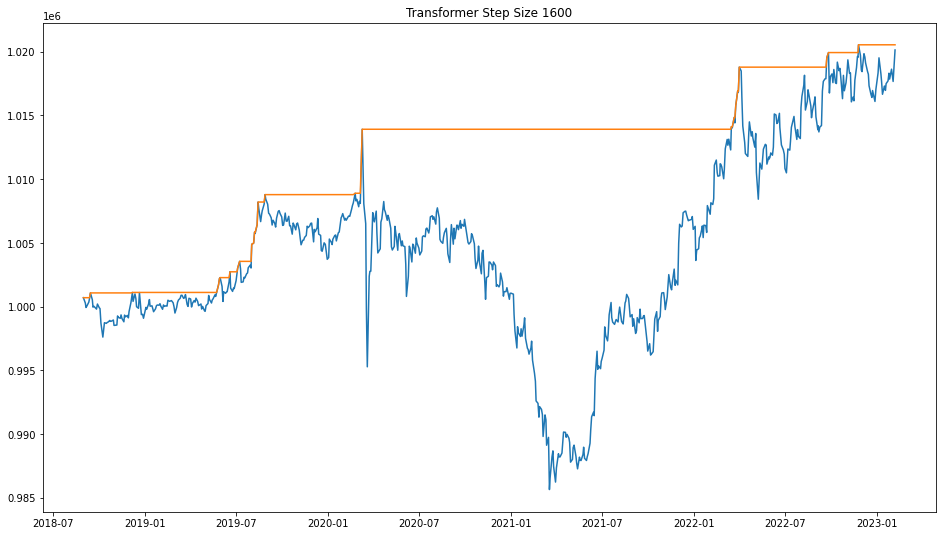

In [ ]:
# Get the baseline model. 
# If not using partial functions, uncomment this line:
# get_base_model(x_train, y_train, **TRANSFORMER_KWARGS)
base_m = partial_base_model()

x, y = run_stepped_inc(
    base_m, x_test, y_test, step_size=1600, epochs=10, batch_size=64,
)
rets_agg["Transformer Step Size 1600"], tf_rets1600 = summ_and_plot(x, y, title="Transformer Step Size 1600", idx=rets_idx)

## Build And Training The Transformer Model

- Code builds a transformer model with specific parameters, compiles it with the Adam optimizer using mean squared error as the loss function, and trains it on the training data with early stopping.
- It uses the trained model to make predictions on the test data using the function run_stepped_inc with a step size of 50 or 500, and plots the results using the function summ_and_plot. 
- The purpose of this code is to experiment with different step sizes and evaluate the performance of the transformer model on the test data.

,Transformer Step Size 25,Transformer Step Size 50,Transformer Step Size 100,Transformer Step Size 500,Transformer Step Size 1600
Annualized Return,0.001597,0.004436,-0.016719,0.007873,0.007337
Annualized Volatility,0.015893,0.015120,0.015906,0.015717,0.015868
Annualized Sharpe Ratio,0.100507,0.293380,-1.051066,0.500914,0.462344
Annualized Sortino Ratio,0.147316,0.497178,-1.315397,0.699582,0.633580
Skewness,0.354698,1.239393,-1.017467,0.287507,0.191136
Kurtosis,8.358336,8.321042,7.546752,9.247760,9.342595
VaR (0.05),-0.001503,-0.001464,-0.001610,-0.001436,-0.001438
CVaR (0.05),-0.002147,-0.001873,-0.002504,-0.002187,-0.002232
Min,-0.006622,-0.003189,-0.007253,-0.006644,-0.006644
Max,0.007074,0.006835,0.003880,0.007126,0.007137


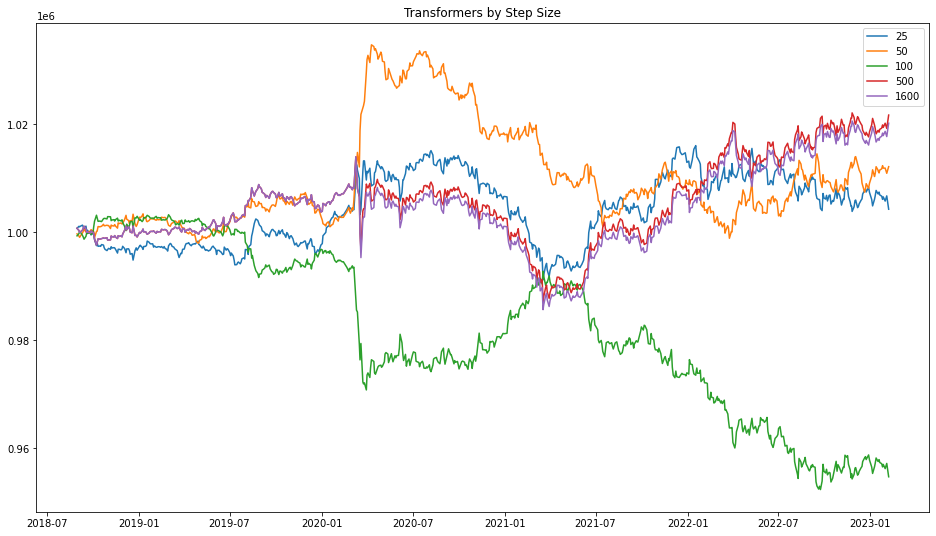

In [ ]:
# Summary of the data for the transformer models.
display(rets_agg)

# Plot the cumulative portfolio value for each model,
# note that we assume a multiplier of 10,000, and an 
# initial capital base of $1m.
plt.plot(tf_rets25["portfolio"], label="25")
plt.plot(tf_rets50["portfolio"], label="50")
plt.plot(tf_rets100["portfolio"], label="100")
plt.plot(tf_rets500["portfolio"], label="500")
plt.plot(tf_rets1600["portfolio"], label="1600")

plt.title('Transformers by Step Size')
plt.legend()
plt.show()

100%|██████████| 64/64 [00:23<00:00,  2.69it/s]


,XGBoost Step Size of 25
Annualized Return,0.032066
Annualized Volatility,0.018440
Annualized Sharpe Ratio,1.738998
Annualized Sortino Ratio,2.695393
Skewness,-0.136526
Kurtosis,0.983057
VaR (0.05),-0.001564
CVaR (0.05),-0.002413
Min,-0.003664
Max,0.003828


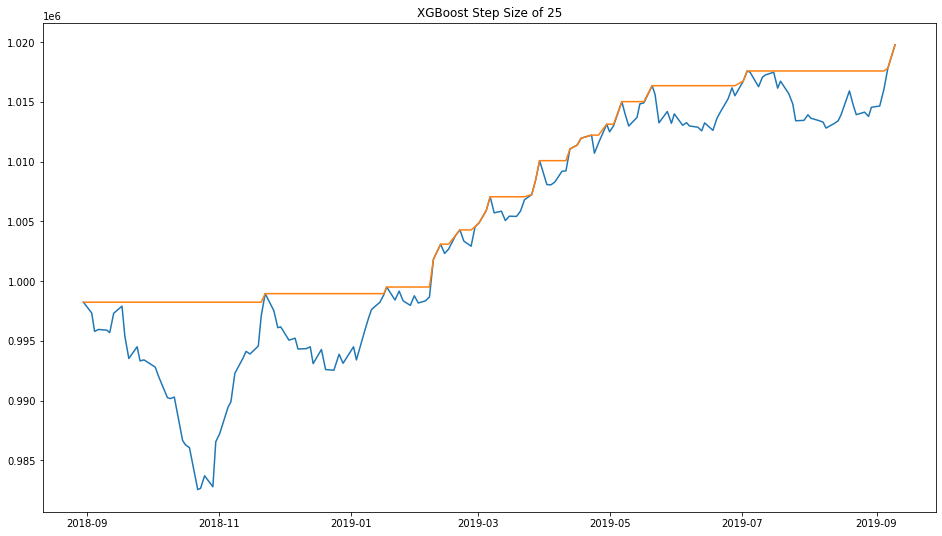

In [ ]:
from xgboost import XGBRegressor

# XGBoost and Regression Models.
df_train_mod = df_train.copy()
df_test_mod = df_test.copy()

df_all = pd.concat([df_train, df_test], axis=0).drop_duplicates().reset_index(drop=True).copy()

x_all_mod = df_all.drop(TARGET_COL, axis=1)
y_all_mod = df_all[TARGET_COL].values

x_train_mod = df_train_mod.drop(TARGET_COL, axis=1)
y_train_mod = df_train_mod[TARGET_COL].values

x_test_mod = df_test_mod.drop(TARGET_COL, axis=1)
y_test_mod = df_test_mod[TARGET_COL].values

xgb_model = XGBRegressor(effect_learner_objective="reg:squarederror", verbosity=0)

x, y = run_stepped_retrain(xgb_model, x_all_mod, y_all_mod, step_size=25)
rets_agg["XGBoost Step Size 25"], xgb_rets = summ_and_plot(x, y, title="XGBoost Step Size of 25", idx=rets_idx)


100%|██████████| 317/317 [01:57<00:00,  2.70it/s]


,XGBoost Step Size of 5
Annualized Return,0.009334
Annualized Volatility,0.017986
Annualized Sharpe Ratio,0.518973
Annualized Sortino Ratio,0.895210
Skewness,0.406343
Kurtosis,1.174753
VaR (0.05),-0.001670
CVaR (0.05),-0.002192
Min,-0.002996
Max,0.003589


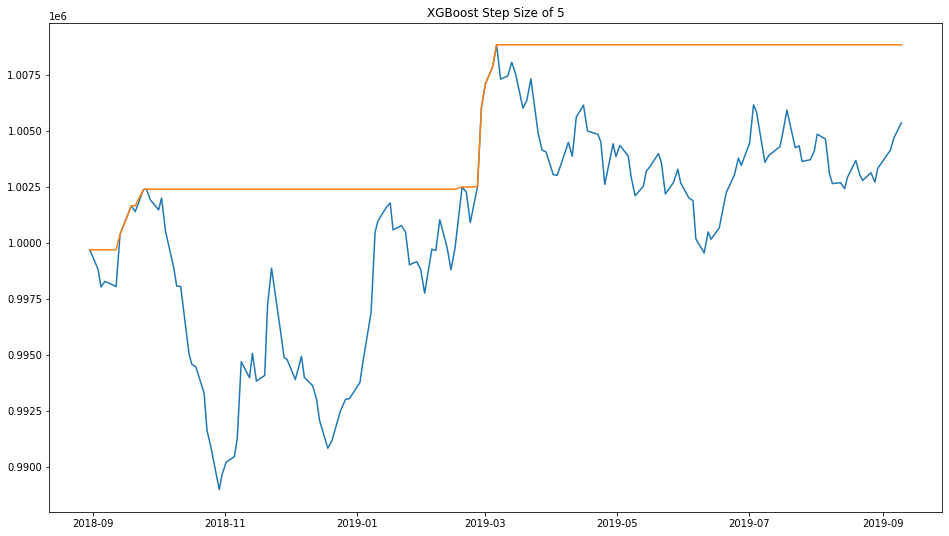

'\nFinally, the results are added to the rets_agg dictionary under the key "XGBoost Step Size 5",\nand the xgb_rets variable is assigned the returned values from summ_and_plot.\n'

In [ ]:
xgb_model = XGBRegressor(effect_learner_objective="reg:squarederror", verbosity=0)
x, y = run_stepped_retrain(xgb_model, x_all_mod, y_all_mod, step_size=5)
rets_agg["XGBoost Step Size 5"], xgb_rets = summ_and_plot(x, y, title="XGBoost Step Size of 5", idx=rets_idx)


'''
Finally, the results are added to the rets_agg dictionary under the key "XGBoost Step Size 5",
and the xgb_rets variable is assigned the returned values from summ_and_plot.
'''


100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


,XGBoost Step Size 100
Annualized Return,0.015073
Annualized Volatility,0.016717
Annualized Sharpe Ratio,0.901652
Annualized Sortino Ratio,1.405391
Skewness,-0.114703
Kurtosis,0.256461
VaR (0.05),-0.001959
CVaR (0.05),-0.002274
Min,-0.002741
Max,0.003025


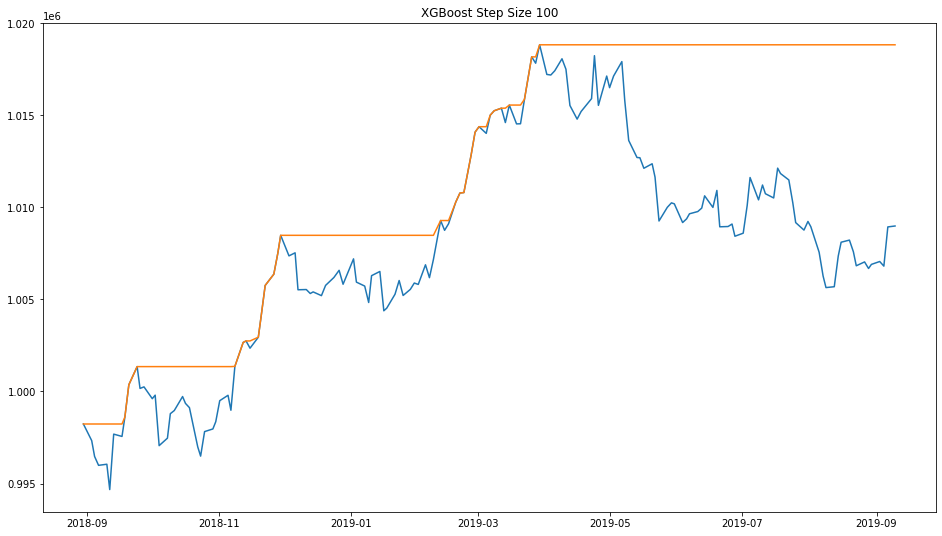

In [ ]:
xgb_model = XGBRegressor(effect_learner_objective="reg:squarederror", verbosity=0)
x, y = run_stepped_retrain(xgb_model, x_all_mod, y_all_mod, step_size=100)
rets_agg["XGBoost Step Size 100"], xgb_rets = summ_and_plot(x, y, title="XGBoost Step Size 100", idx=rets_idx)

100%|██████████| 64/64 [00:10<00:00,  5.99it/s]


,Random Forest Step Size 25
Annualized Return,-0.016785
Annualized Volatility,0.017303
Annualized Sharpe Ratio,-0.970022
Annualized Sortino Ratio,-1.649114
Skewness,0.180400
Kurtosis,0.052764
VaR (0.05),-0.001813
CVaR (0.05),-0.002267
Min,-0.002722
Max,0.002811


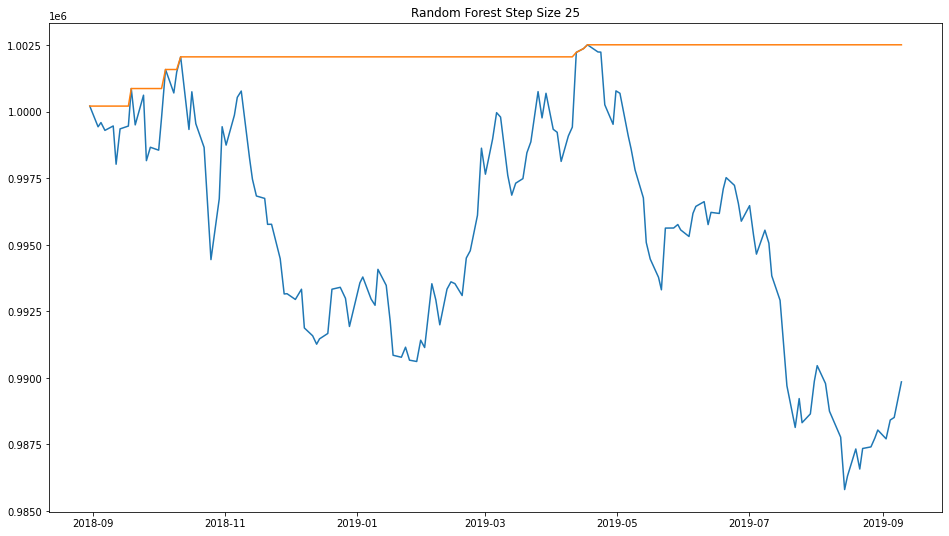

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=10, random_state=1)
x, y = run_stepped_retrain(forest, x_all_mod.values, y_all_mod, step_size=25)
# Note that this is highly overfit.
rets_agg["Random Forest Step Size 25"], rf_rets = summ_and_plot(x, y, title="Random Forest Step Size 25", idx=rets_idx)

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


,Random Forest Step Size 1600
Annualized Return,0.006413
Annualized Volatility,0.017547
Annualized Sharpe Ratio,0.365484
Annualized Sortino Ratio,0.567430
Skewness,-0.049848
Kurtosis,0.402083
VaR (0.05),-0.001964
CVaR (0.05),-0.002411
Min,-0.002990
Max,0.003326


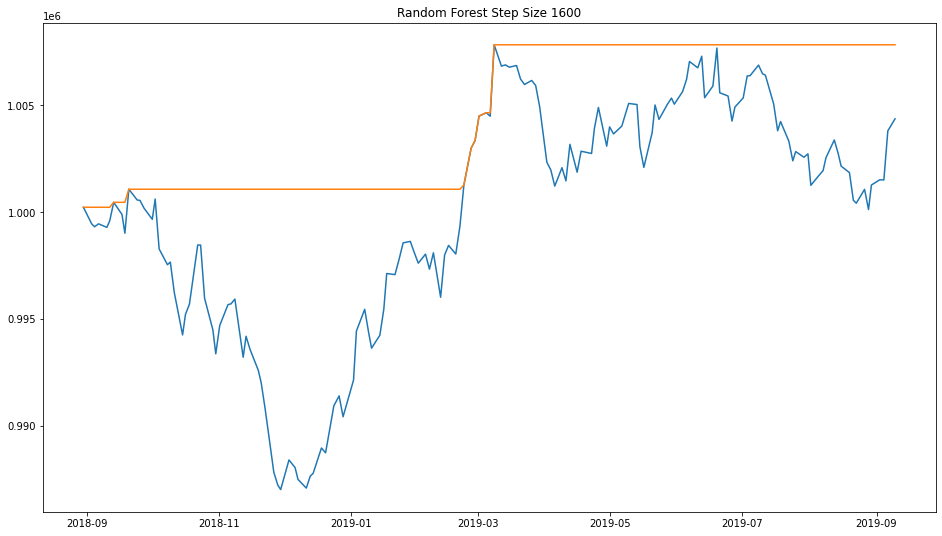

In [ ]:
forest = RandomForestRegressor(n_estimators=10, random_state=1)
x, y = run_stepped_retrain(forest, x_all_mod.values, y_all_mod, step_size=1600)
# Increasing step size improves performance.
rets_agg["Random Forest Step Size 1600"], rf_rets = summ_and_plot(x, y, title="Random Forest Step Size 1600", idx=rets_idx)

100%|██████████| 317/317 [00:52<00:00,  6.01it/s]


,Random Forest Step Size 5
Annualized Return,-0.014200
Annualized Volatility,0.018385
Annualized Sharpe Ratio,-0.772374
Annualized Sortino Ratio,-1.183401
Skewness,-0.202349
Kurtosis,0.762003
VaR (0.05),-0.002051
CVaR (0.05),-0.002730
Min,-0.003872
Max,0.003074


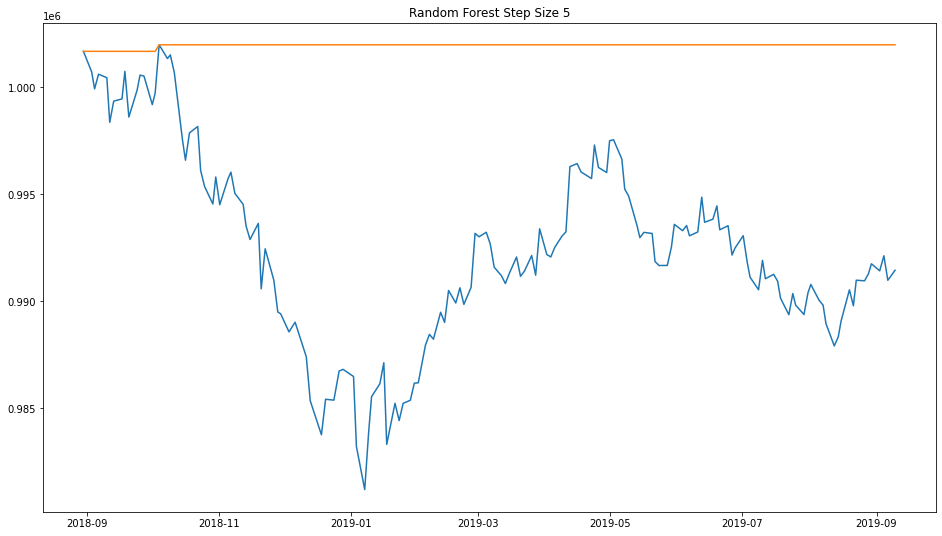

In [ ]:
forest = RandomForestRegressor(n_estimators=10, random_state=1)
x, y = run_stepped_retrain(forest, x_all_mod.values, y_all_mod, step_size=5)
# Increasing step size improves performance.
rets_agg["Random Forest Step Size 5"], rf_rets = summ_and_plot(x, y, title="Random Forest Step Size 5", idx=rets_idx)

100%|██████████| 64/64 [00:00<00:00, 201.93it/s]


,Linear Regression Step Size 25
Annualized Return,-0.053008
Annualized Volatility,0.017002
Annualized Sharpe Ratio,-3.117818
Annualized Sortino Ratio,-4.846550
Skewness,-0.010857
Kurtosis,0.277707
VaR (0.05),-0.002026
CVaR (0.05),-0.002491
Min,-0.003362
Max,0.002942


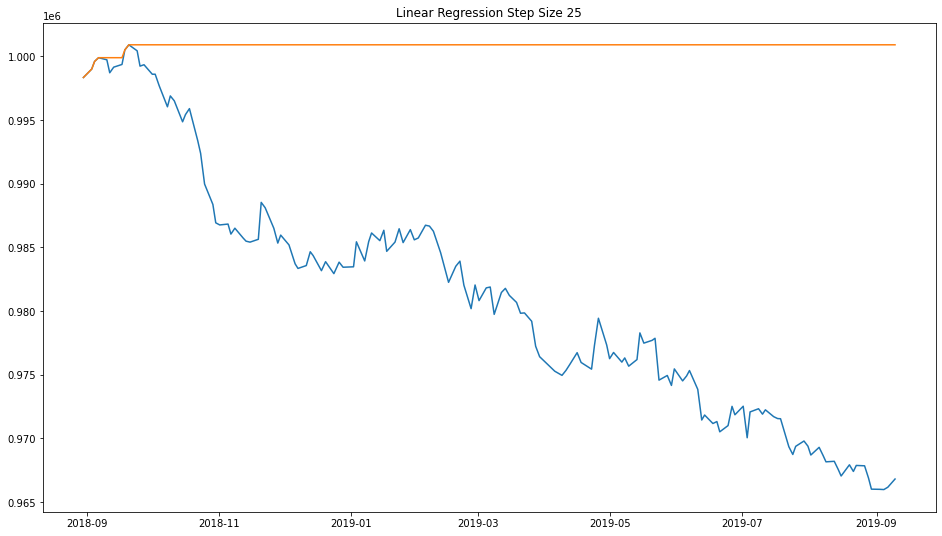

In [ ]:
# Try normal regression.
from sklearn.linear_model import LinearRegression

mod = LinearRegression()
x, y = run_stepped_retrain(mod, x_all_mod.values, y_all_mod, step_size=25)
rets_agg["Linear Regression Step Size 25"], rf_rets = summ_and_plot(x, y, title="Linear Regression Step Size 25", idx=rets_idx)

In [ ]:
stoof = rets_agg.reindex(sorted(rets_agg.columns), axis=1).round(3)
stoof

,Linear Regression Step Size 25,Random Forest Step Size 1600,Random Forest Step Size 25,Random Forest Step Size 5,Transformer Step Size 100,Transformer Step Size 1600,Transformer Step Size 25,Transformer Step Size 50,Transformer Step Size 500,XGBoost Step Size 100,XGBoost Step Size 25,XGBoost Step Size 5
Annualized Return,-0.053,0.006,-0.017,-0.014,-0.017,0.007,0.002,0.004,0.008,0.015,0.032,0.009
Annualized Volatility,0.017,0.018,0.017,0.018,0.016,0.016,0.016,0.015,0.016,0.017,0.018,0.018
Annualized Sharpe Ratio,-3.118,0.365,-0.970,-0.772,-1.051,0.462,0.101,0.293,0.501,0.902,1.739,0.519
Annualized Sortino Ratio,-4.847,0.567,-1.649,-1.183,-1.315,0.634,0.147,0.497,0.700,1.405,2.695,0.895
Skewness,-0.011,-0.050,0.180,-0.202,-1.017,0.191,0.355,1.239,0.288,-0.115,-0.137,0.406
Kurtosis,0.278,0.402,0.053,0.762,7.547,9.343,8.358,8.321,9.248,0.256,0.983,1.175
VaR (0.05),-0.002,-0.002,-0.002,-0.002,-0.002,-0.001,-0.002,-0.001,-0.001,-0.002,-0.002,-0.002
CVaR (0.05),-0.002,-0.002,-0.002,-0.003,-0.003,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002
Min,-0.003,-0.003,-0.003,-0.004,-0.007,-0.007,-0.007,-0.003,-0.007,-0.003,-0.004,-0.003
Max,0.003,0.003,0.003,0.003,0.004,0.007,0.007,0.007,0.007,0.003,0.004,0.004


In [ ]:
print(stoof.loc[['Annualized Return', 'Annualized Sharpe Ratio', 'Annualized Sortino Ratio', 'Calmar Ratio', 'Max Drawdown'], ['Transformer Step Size 1600', 'Random Forest Step Size 1600', 'XGBoost Step Size 25', 'Linear Regression Step Size 25']])

                          Transformer Step Size 1600  \
Annualized Return                              0.007   
Annualized Sharpe Ratio                        0.462   
Annualized Sortino Ratio                       0.634   
Calmar Ratio                                   0.263   
Max Drawdown                                  -0.028   

                          Random Forest Step Size 1600  XGBoost Step Size 25  \
Annualized Return                                0.006                 0.032   
Annualized Sharpe Ratio                          0.365                 1.739   
Annualized Sortino Ratio                         0.567                 2.695   
Calmar Ratio                                     0.457                 2.042   
Max Drawdown                                    -0.014                -0.016   

                          Linear Regression Step Size 25  
Annualized Return                                 -0.053  
Annualized Sharpe Ratio                           -3.118  
Annua